In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
train_data = pd.read_csv('./data/train.csv')
valid_data = pd.read_csv('./data/valid.csv')
test_data = pd.read_csv('./data/test.csv')

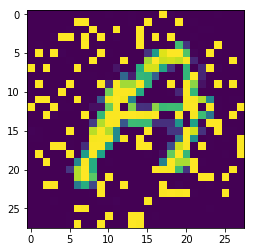

In [3]:
im = train_data.iloc[65:66,1:785]
im1 = np.reshape(np.ravel(im), (28,28))
plt.imshow(im1)

In [4]:
def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1.0/(1.0+np.exp(-x))

In [5]:
def sigmoid_prime(x):
    return sigmoid(x)* (1- sigmoid(x))

In [40]:
def tanh(x):
    x = np.clip(x, -500, 500)
    return (np.exp(x)- np.exp(-x))/(np.exp(x)+ np.exp(-x))

In [41]:
def tanh_prime(x):
    return 1 - (tanh(x)**2)

In [42]:
def relu(x):
    x[x<0] = 0
    return x

In [43]:
def relu_prime(x):
    x[x<0] = 0
    x[x>0] = 1
    return x

In [44]:
def softmax(x):
    m = np.amax(x, axis=1)
    m= m[:, np.newaxis]
    tot = np.sum((np.exp(x-m)), axis =1)
    tot = tot[:, np.newaxis]
    return (np.exp(x-m)/ tot)

In [11]:
def weight_init(sizes):
    num_layers = len(sizes)
    biases = []
    weights = []
    np.random.seed(1234)
    for i in range(num_layers-1):
        
        biases.append(np.random.randn(1, sizes[i+1]))
        biases[-1] = biases[-1] / np.sqrt(sizes[i])
        weights.append(np.random.randn(sizes[i], sizes[i+1]))
        weights[-1] = weights[-1] / np.sqrt(sizes[i])
    return biases, weights

In [12]:
def forward_pass(x, y, sizes, b, w, activation):
    #sizes.append(len(y.unique()))
    #sizes.insert(0, np.shape(x)[1])
    
    ai = x
    a = [x]
    z = []
    if activation == 'sigmoid':
        for bi, wi in zip(b[:-1], w[:-1]):
            #print(wi.shape)
            zi = np.dot(ai,wi)+bi
            z.append(zi)
            ai= sigmoid(zi)
            a.append(ai)
            
    elif activation == 'tanh':
        for bi, wi in zip(b[:-1], w[:-1]):
            #print(wi.shape)
            zi = np.dot(ai,wi)+bi
            z.append(zi)
            ai= tanh(zi)
            a.append(ai)  
            
    elif activation == 'relu':
        for bi, wi in zip(b[:-1], w[:-1]):
            #print(wi.shape)
            zi = np.dot(ai,wi)+bi
            z.append(zi)
            ai= relu(zi)
            a.append(ai)              
            
    for bi, wi in zip(b[-1:], w[-1:]):
        #print(wi.shape)
        zi = np.dot(ai,wi)+bi
        z.append(zi)
        #print(zi)
        ai= softmax(zi)
        #print(ai)
        a.append(ai)
        
    return z, a

In [13]:
def one_hot(y):
    m= np.shape(y)[0]
    n = 10
    y_one_hot = np.zeros((m,n))
    for i in range(m):
        y_one_hot[i, int(y[i])] = 1
    return y_one_hot

In [14]:
def loss_fn(x, y, y_pred, sizes, b, w, loss):
    y_one_hot = one_hot(y)
    if loss =='ce':
        tot = -1* (np.sum(y_one_hot* np.log(y_pred))) 
    elif loss =='sq':
        tot = 0.5 * np.sum((y_one_hot- y_pred)**2)
    return tot

In [15]:
def loss_fn_reg(x, y, y_pred, sizes, b, w, loss, lamb):
    y_one_hot = one_hot(y)
    wei_tot =0
    for i in range(len(w)):
        wei_tot+= np.sum(w[i]*w[i])
        
    if loss =='ce':
        tot = -1* (np.sum(y_one_hot* np.log(y_pred))) + (lamb * wei_tot)
    elif loss =='sq':
        tot = 0.5 * np.sum((y_one_hot- y_pred)**2) + (lamb * wei_tot)
    return tot

In [16]:
def back_prop(x, y, sizes, b ,w , z, a, activation, loss):
    y_one_hot = one_hot(y)
    grad_b =[]
    grad_w =[]
    
    for bi, wi in zip(b,w):
        grad_b.append(np.zeros(bi.shape))
        #print(bi.shape)
        grad_w.append(np.zeros(wi.shape))
        #print(wi.shape)
    
    if loss == 'ce':
        delta=  a[-1] - y_one_hot 
        grad_b[-1] = np.sum(delta, axis =0).reshape(1,np.shape(delta)[1]) 
        grad_w[-1] = (np.dot(a[-2].T , delta))
        
    elif loss == 'sq':
        delta=  a[-1] * (a[-1] - y_one_hot)
        grad_b[-1] = np.sum(delta, axis =0).reshape(1,np.shape(delta)[1]) 
        grad_w[-1] = (np.dot(a[-2].T , delta))
    
    if activation == 'sigmoid':
        for i in range(2, len(sizes)):
            delta = np.dot(delta , w[1-i].T)* sigmoid_prime(z[-i])
            grad_b[-i] = np.sum(delta, axis =0).reshape(1,np.shape(delta)[1]) 
            grad_w[-i] = (np.dot(a[-1-i].T , delta)) 
            
    elif activation =='tanh':
        for i in range(2, len(sizes)):
            delta = np.dot(delta , w[1-i].T)* tanh_prime(z[-i])
            grad_b[-i] = np.sum(delta, axis =0).reshape(1,np.shape(delta)[1]) 
            grad_w[-i] = (np.dot(a[-1-i].T , delta)) 
            
    elif activation =='relu':
        for i in range(2, len(sizes)):
            delta = np.dot(delta , w[1-i].T)* relu_prime(z[-i])
            grad_b[-i] = np.sum(delta, axis =0).reshape(1,np.shape(delta)[1]) 
            grad_w[-i] = (np.dot(a[-1-i].T , delta))   
            
    return grad_b, grad_w

In [17]:
def back_prop_reg(x, y, sizes, b ,w , z, a, activation, loss, lamb):
    y_one_hot = one_hot(y)
    grad_b =[]
    grad_w =[]
    
    for bi, wi in zip(b,w):
        grad_b.append(np.zeros(bi.shape))
        #print(bi.shape)
        grad_w.append(np.zeros(wi.shape))
        #print(wi.shape)
    
    if loss == 'ce':
        delta=  a[-1] - y_one_hot 
        grad_b[-1] = np.sum(delta, axis =0).reshape(1,np.shape(delta)[1]) 
        grad_w[-1] = np.dot(a[-2].T , delta) + lamb * w[-1]
        
    elif loss == 'sq':
        delta=  a[-1] * (a[-1] - y_one_hot)
        grad_b[-1] = np.sum(delta, axis =0).reshape(1,np.shape(delta)[1]) 
        grad_w[-1] = (np.dot(a[-2].T , delta)) + lamb * w[-1]
    
    if activation == 'sigmoid':
        for i in range(2, len(sizes)):
            delta = np.dot(delta , w[1-i].T)* sigmoid_prime(z[-i])
            grad_b[-i] = np.sum(delta, axis =0).reshape(1,np.shape(delta)[1]) 
            grad_w[-i] = (np.dot(a[-1-i].T , delta)) + lamb * w[-i]
            
    elif activation =='tanh':
        for i in range(2, len(sizes)):
            delta = np.dot(delta , w[1-i].T)* tanh_prime(z[-i])
            grad_b[-i] = np.sum(delta, axis =0).reshape(1,np.shape(delta)[1]) 
            grad_w[-i] = (np.dot(a[-1-i].T , delta)) + lamb * w[-i]
            
    elif activation =='relu':
        for i in range(2, len(sizes)):
            delta = np.dot(delta , w[1-i].T)* relu_prime(z[-i])
            grad_b[-i] = np.sum(delta, axis =0).reshape(1,np.shape(delta)[1]) 
            grad_w[-i] = (np.dot(a[-1-i].T , delta))+ lamb * w[-i]
            
    return grad_b, grad_w

In [74]:
def error(x, y, y_pred, sizes, b,w):
    n = len(y)
    #z, a = forward_pass(x, y, sizes, b, w)
    result =  np.argmax(y_pred, axis=1)
    result = result[:, np.newaxis]
    
    return np.round(((1- ((result ==y).astype(int).sum()/ n))*100 ), 2)

In [19]:
import pickle

def save_weights(list_of_weights, epoch, save_dir):
    with open(save_dir + 'weights_{}.pkl'.format(epoch), 'wb') as f:
        pickle.dump(list_of_weights, f)

def load_weights(state, save_dir):
    with open(save_dir +'weights_{}.pkl'.format(state), 'rb') as f:
        list_of_weights = pickle.load(f)
    return list_of_weights


In [20]:
def gd(train_data, valid_data, test_data, epochs, batch_size, hidden_sizes, lr, activation, loss,  save_dir, expt_dir,
       anneal='false', pretrain= 'false', state=1 , testing = 'false'):
    
    train_data_arr = np.array(train_data)
    x = train_data_arr[:,1:785]
    y = train_data_arr[:,785:]
    m = np.shape(x)[0]
    
    valid_data_arr = np.array(valid_data)
    x_valid = valid_data_arr[:,1:785]
    y_valid = valid_data_arr[:,785:]
    m_valid = np.shape(x_valid)[0]
    
    test_data_arr = np.array(test_data)
    x_test = test_data_arr[:,1:785]
    y_test = test_data_arr[:,785:]
    m_test = np.shape(x_test)[0]
    
    sizes = hidden_sizes
    sizes.append(len(np.unique(y)))
    sizes.insert(0, np.shape(x)[1])
    
    if (testing =='true'):
        
        params = load_weights(state, save_dir)
        b= params[:len(sizes)-1]
        w= params[len(sizes)-1:]
        
        y = np.zeros((m_test,1))
        
        z,a = forward_pass(x, y, sizes, b, w, activation)
        y_pred = a[-1]
        y_pred_labels = np.argmax(a[-1], axis=1)
        y_pred_df_labels = pd.DataFrame(y_pred_labels)
        y_pred_df_labels.to_csv(expt_dir + 'predictions_{}.csv'.format(state))
        return
        
    elif (pretrain == 'true' and testing =='false'):
        params = load_weights(state, save_dir)
        b= params[:len(sizes)-1]
        w= params[len(sizes)-1:]
        
        
    elif (pretrain == 'false' and testing =='false'):
        b, w = weight_init(sizes)
    
    train_loss_epoch= []
    valid_loss_epoch= []
    
    valid_error_epoch =[]
        
    file = open( expt_dir + "log_train.txt", "w")
    file.close()
    file1 = open(expt_dir +"log_val.txt", "w")
    file1.close()
    
    epoch = 1
    t=1
    while epoch <= epochs:
        np.random.shuffle(train_data_arr)
        x = train_data_arr[:,1:785]
        y = train_data_arr[:,785:]
        
        for k in range(0, m, batch_size):
            xi = x[k: k+batch_size, :] 
            yi = y[k: k+batch_size, :] 
            
            xi_valid =  x_valid[k: k+batch_size, :] 
            yi_valid = y_valid[k: k+batch_size, :] 
            
#             g_b= []
#             g_w= []
            
#             for bi, wi in zip(b,w):
#                 g_b.append(np.zeros(bi.shape))
#                 g_w.append(np.zeros(wi.shape))
                
            zi, ai = forward_pass(xi, yi, sizes, b, w, activation)
                
            grad_b, grad_w = back_prop(xi, yi, sizes, b , w , zi, ai, activation, loss)   
            g_w = grad_w
            g_b = grad_b
#             for x1,y1 in zip(xi,yi):
#                 x1 = x1[:, np.newaxis].T
#                 y1 = y1[:, np.newaxis].T
                
#                 z1, a1 = forward_pass(x1, y1, sizes, b, w, activation)
                
#                 grad_b, grad_w = back_prop(x1, y1, sizes, b , w , z1, a1, activation, loss)
                
#                 for l in range(len(w)):
#                     g_w[l] += (grad_w[l] /batch_size)
#                     g_b[l] += (grad_b[l] /batch_size)
                
                
            
            for j in range(len(w)):
                w[j] = w[j]- (lr* g_w[j])
                b[j] = b[j]- (lr* g_b[j])
            
            if t%100==0:
                z, a = forward_pass(x, y, sizes, b, w, activation)
                z_valid, a_valid = forward_pass(x_valid, y_valid, sizes, b, w,  activation)
                
                train_loss= (loss_fn(x, y, a[-1], sizes, b, w, loss)) / m
                valid_loss=(loss_fn(x_valid, y_valid, a_valid[-1], sizes, b, w, loss)) / m_valid
                    
                train_error=(error(x, y, a[-1], sizes, b,w))
                valid_error=(error(x_valid, y_valid, a_valid[-1], sizes, b, w))
                
                file = open(expt_dir +"log_train.txt", "a") 
                print("Training: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4}".format(epoch, 
                                                t, train_loss, train_error, lr))
                file.write("Training: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4} \n".format(epoch, 
                                                t, train_loss, train_error, lr))
                file.close()
                
                file1 = open(expt_dir +"log_val.txt", "a") 
                print("Validation: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4}".format(epoch, 
                                        t, valid_loss, valid_error, lr))
                file1.write("Validation: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4} \n".format(epoch, 
                                                t, train_loss, train_error, lr))
                file1.close()
                print('')
                
            t+=1
        z, a = forward_pass(x, y, sizes, b, w, activation)
        z_valid, a_valid = forward_pass(x_valid, y_valid, sizes, b, w,  activation)

        
        valid_error_epoch.append(error(x, y, a[-1], sizes, b,w))
        
        if (anneal == 'true' and epoch != 1):
            if (valid_error_epoch[-1]> valid_error_epoch[-2]):
                lr = lr/2
                params = load_weights(epoch-1, save_dir)
                b= params[:len(sizes)-1]
                w= params[len(sizes)-1:]
         
            else:
                params = b + w
                save_weights(params, epoch, save_dir)
                epoch+=1
                
                train_loss_epoch.append(loss_fn(x, y, a[-1], sizes, b, w, loss) / m)
                valid_loss_epoch.append(loss_fn(x_valid, y_valid, a_valid[-1], sizes, b, w, loss) / m_valid)
            
        else:
            params = b+ w
            save_weights(params, epoch, save_dir)
            epoch+=1
            
            train_loss_epoch.append(loss_fn(x, y, a[-1], sizes, b, w, loss) / m)
            valid_loss_epoch.append(loss_fn(x_valid, y_valid, a_valid[-1], sizes, b, w, loss) / m_valid)
            
    return b,w, train_loss_epoch, valid_loss_epoch

In [21]:
def momentum_gd(train_data, valid_data, test_data, epochs, batch_size, hidden_sizes, lr, activation, loss,  save_dir, expt_dir,
         gamma=0.9, anneal='false', pretrain= 'false', state=1 , testing = 'false'):
    
    train_data_arr = np.array(train_data)
    x = train_data_arr[:,1:785]
    y = train_data_arr[:,785:]
    m = np.shape(x)[0]
    
    valid_data_arr = np.array(valid_data)
    x_valid = valid_data_arr[:,1:785]
    y_valid = valid_data_arr[:,785:]
    m_valid = np.shape(x_valid)[0]
    
    test_data_arr = np.array(test_data)
    x_test = test_data_arr[:,1:785]
    y_test = test_data_arr[:,785:]
    m_test = np.shape(x_test)[0]
    
    sizes = hidden_sizes
    sizes.append(len(np.unique(y)))
    sizes.insert(0, np.shape(x)[1])
    
    if (testing =='true'):
        
        params = load_weights(state, save_dir)
        b= params[:len(sizes)-1]
        w= params[len(sizes)-1:]
        
        y = np.zeros((m_test,1))
        
        z,a = forward_pass(x, y, sizes, b, w, activation)
        y_pred = a[-1]
        y_pred_labels = np.argmax(a[-1], axis=1)
        y_pred_df_labels = pd.DataFrame(y_pred_labels)
        y_pred_df_labels.to_csv(expt_dir + 'predictions_{}.csv'.format(state))
        return
        
    elif (pretrain == 'true' and testing =='false'):
        params = load_weights(state, save_dir)
        b= params[:len(sizes)-1]
        w= params[len(sizes)-1:]
        
        
    elif (pretrain == 'false' and testing =='false'):
        b, w = weight_init(sizes)
        
    update_b =[]
    update_w = []
    
    train_loss_epoch= []
    valid_loss_epoch= []
    
    valid_error_epoch =[]
    
    file = open( expt_dir + "log_train.txt", "w")
    file.close()
    file1 = open(expt_dir +"log_val.txt", "w")
    file1.close()
    
    epoch = 1
    t=1
    for bi, wi in zip(b,w):
        update_b.append(np.zeros(bi.shape))
        update_w.append(np.zeros(wi.shape))
       
    while epoch <= epochs:
        np.random.shuffle(train_data_arr)
        x = train_data_arr[:,1:785]
        y = train_data_arr[:,785:]
        
        
        for k in range(0, m, batch_size):
            xi = x[k: k+batch_size, :] 
            yi = y[k: k+batch_size, :] 
            
            xi_valid =  x_valid[k: k+batch_size, :] 
            yi_valid = y_valid[k: k+batch_size, :] 
#             g_b= []
#             g_w= []
            
#             for bi, wi in zip(b,w):
#                 g_b.append(np.zeros(bi.shape))
#                 g_w.append(np.zeros(wi.shape))
                
            zi, ai = forward_pass(xi, yi, sizes, b, w, activation)
                
            grad_b, grad_w = back_prop(xi, yi, sizes, b , w , zi, ai, activation, loss)   
            g_w = grad_w
            g_b = grad_b
#             for x1,y1 in zip(xi,yi):
#                 x1 = x1[:, np.newaxis].T
#                 y1 = y1[:, np.newaxis].T
                
#                 z1, a1 = forward_pass(x1, y1, sizes, b, w, activation)
                
#                 grad_b, grad_w = back_prop(x1, y1, sizes, b , w , z1, a1, activation, loss)
                
#                 for l in range(len(w)):
#                     g_w[l] += (grad_w[l] /batch_size)
#                     g_b[l] += (grad_b[l] /batch_size)
                
                
            
            for j in range(len(w)):
                update_w[j] = (gamma * update_w[j]) + (lr* g_w[j])
                update_b[j] = (gamma * update_b[j]) + (lr* g_b[j])
                
                w[j] = w[j]- (update_w[j])
                b[j] = b[j]- (update_b[j])
            
            if t%100 ==0:
                z, a = forward_pass(x, y, sizes, b, w, activation)
                z_valid, a_valid = forward_pass(x_valid, y_valid, sizes, b, w,  activation)
                
                train_loss= (loss_fn(x, y, a[-1], sizes, b, w, loss)) / m
                valid_loss=(loss_fn(x_valid, y_valid, a_valid[-1], sizes, b, w, loss)) / m_valid
                    
                train_error=(error(x, y, a[-1], sizes, b,w))
                valid_error=(error(x_valid, y_valid, a_valid[-1], sizes, b, w))
                
                file = open(expt_dir +"log_train.txt", "a") 
                print("Training: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4}".format(epoch, 
                                                t, train_loss, train_error, lr))
                file.write("Training: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4} \n".format(epoch, 
                                                t, train_loss, train_error, lr))
                file.close()
                
                file1 = open(expt_dir +"log_val.txt", "a") 
                print("Validation: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4}".format(epoch, 
                                        t, valid_loss, valid_error, lr))
                file1.write("Validation: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4} \n".format(epoch, 
                                                t, train_loss, train_error, lr))
                file1.close()
                print('')
            t+=1    
            
        z, a = forward_pass(x, y, sizes, b, w, activation)
        z_valid, a_valid = forward_pass(x_valid, y_valid, sizes, b, w,  activation)

        
        
        valid_error_epoch.append(error(x, y, a[-1], sizes, b,w))
        
        if (anneal == 'true' and epoch != 1):
            if (valid_error_epoch[-1]> valid_error_epoch[-2]):
                lr = lr/2
                params = load_weights(epoch-1, save_dir)
                b= params[:len(sizes)-1]
                w= params[len(sizes)-1:]
         
            else:
                params = b + w
                save_weights(params, epoch, save_dir)
                epoch+=1
                train_loss_epoch.append(loss_fn(x, y, a[-1], sizes, b, w, loss) / m)
                valid_loss_epoch.append(loss_fn(x_valid, y_valid, a_valid[-1], sizes, b, w, loss) / m_valid)
        else:
            params = b+ w
            save_weights(params, epoch, save_dir)
            epoch+=1
            train_loss_epoch.append(loss_fn(x, y, a[-1], sizes, b, w, loss) / m)
            valid_loss_epoch.append(loss_fn(x_valid, y_valid, a_valid[-1], sizes, b, w, loss) / m_valid)
    return b,w, train_loss_epoch, valid_loss_epoch

In [233]:
def nestrov_gd(train_data, valid_data, test_data, epochs, batch_size, hidden_sizes, lr, activation, loss,  save_dir, expt_dir,
         gamma=0.9, anneal='false', pretrain= 'false', state=1 , testing = 'false'):
    
    train_data_arr = np.array(train_data)
    x = train_data_arr[:,1:785]
    y = train_data_arr[:,785:]
    m = np.shape(x)[0]
    
    valid_data_arr = np.array(valid_data)
    x_valid = valid_data_arr[:,1:785]
    y_valid = valid_data_arr[:,785:]
    m_valid = np.shape(x_valid)[0]
    
    test_data_arr = np.array(test_data)
    x_test = test_data_arr[:,1:785]
    y_test = test_data_arr[:,785:]
    m_test = np.shape(x_test)[0]
    
    sizes = hidden_sizes
    sizes.append(len(np.unique(y)))
    sizes.insert(0, np.shape(x)[1])
    
    if (testing =='true'):
        
        params = load_weights(state, save_dir)
        b= params[:len(sizes)-1]
        w= params[len(sizes)-1:]
        
        y = np.zeros((m_test,1))
        
        z,a = forward_pass(x, y, sizes, b, w, activation)
        y_pred = a[-1]
        y_pred_labels = np.argmax(a[-1], axis=1)
        y_pred_df_labels = pd.DataFrame(y_pred_labels)
        y_pred_df_labels.to_csv(expt_dir + 'predictions_{}.csv'.format(state))
        return
        
    elif (pretrain == 'true' and testing =='false'):
        params = load_weights(state, save_dir)
        b= params[:len(sizes)-1]
        w= params[len(sizes)-1:]
        
        
    elif (pretrain == 'false' and testing =='false'):
        b, w = weight_init(sizes)
        
    update_b =[]
    update_w = []
    b_la =[]
    w_la= []
    
    train_loss_epoch= []
    valid_loss_epoch= []
    
    valid_error_epoch =[]
        
    file = open( expt_dir + "log_train.txt", "w")
    file.close()
    file1 = open(expt_dir +"log_val.txt", "w")
    file1.close()
    t=1
    epoch = 1
    
    for bi, wi in zip(b,w):
        update_b.append(np.zeros(bi.shape))
        b_la.append(np.zeros(bi.shape))
                
        update_w.append(np.zeros(wi.shape))
        w_la.append(np.zeros(wi.shape))
       
    while epoch <= epochs:
        np.random.shuffle(train_data_arr)
        x = train_data_arr[:,1:785]
        y = train_data_arr[:,785:]
        
        
        for k in range(0, m, batch_size):
            xi = x[k: k+batch_size, :] 
            yi = y[k: k+batch_size, :] 
            
            xi_valid =  x_valid[k: k+batch_size, :] 
            yi_valid = y_valid[k: k+batch_size, :] 

            for j in range(len(w)):
             
                w_la[j] = w[j]- gamma * update_w[j]
                b_la[j] = b[j]- gamma * update_b[j]
                
            zi, ai = forward_pass(xi, yi, sizes, b_la, w_la, activation)
                
            grad_b, grad_w = back_prop(xi, yi, sizes, b_la , w_la , zi, ai, activation, loss)   
            g_w = grad_w
            g_b = grad_b

            
            for j in range(len(w)):
                update_w[j] = (gamma * update_w[j]) + (lr* g_w[j])
                update_b[j] = (gamma * update_b[j]) + (lr* g_b[j])
                
                w[j] = w[j]- (update_w[j])
                b[j] = b[j]- (update_b[j])
            
            if t%100 ==0:
                z, a = forward_pass(x, y, sizes, b, w, activation)
                z_valid, a_valid = forward_pass(x_valid, y_valid, sizes, b, w,  activation)
                
                train_loss= (loss_fn(x, y, a[-1], sizes, b, w, loss)) / m
                valid_loss=(loss_fn(x_valid, y_valid, a_valid[-1], sizes, b, w, loss)) / m_valid
                    
                train_error=(error(x, y, a[-1], sizes, b,w))
                valid_error=(error(x_valid, y_valid, a_valid[-1], sizes, b, w))
                
                file = open(expt_dir +"log_train.txt", "a") 
                print("Training: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4}".format(epoch, 
                                                t, train_loss, train_error, lr))
                file.write("Training: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4} \n".format(epoch, 
                                                t, train_loss, train_error, lr))
                file.close()
                
                file1 = open(expt_dir +"log_val.txt", "a") 
                print("Validation: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4}".format(epoch, 
                                        t, valid_loss, valid_error, lr))
                file1.write("Validation: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4} \n".format(epoch, 
                                                t, train_loss, train_error, lr))
                file1.close()
                print('')
            t+=1    
            
        z, a = forward_pass(x, y, sizes, b, w, activation)
        z_valid, a_valid = forward_pass(x_valid, y_valid, sizes, b, w,  activation)

        
        
        valid_error_epoch.append(error(x, y, a[-1], sizes, b,w))
        
        if (anneal == 'true' and epoch != 1):
            if (valid_error_epoch[-1]> valid_error_epoch[-2]):
                lr = lr/2
                params = load_weights(epoch-1, save_dir)
                b= params[:len(sizes)-1]
                w= params[len(sizes)-1:]
         
            else:
                params = b + w
                save_weights(params, epoch, save_dir)
                epoch+=1
                train_loss_epoch.append(loss_fn(x, y, a[-1], sizes, b, w, loss) / m)
                valid_loss_epoch.append(loss_fn(x_valid, y_valid, a_valid[-1], sizes, b, w, loss) / m_valid)
        else:
            params = b+ w
            save_weights(params, epoch, save_dir)
            epoch+=1
            train_loss_epoch.append(loss_fn(x, y, a[-1], sizes, b, w, loss) / m)
            valid_loss_epoch.append(loss_fn(x_valid, y_valid, a_valid[-1], sizes, b, w, loss) / m_valid)
    return b,w, train_loss_epoch, valid_loss_epoch

In [234]:
def adam(train_data, valid_data, test_data, epochs, batch_size, hidden_sizes, lr, activation, loss,  save_dir, expt_dir,
         eps= 1e-08, beta1 = 0.9, beta2= 0.99, anneal='false', pretrain= 'false', state=1 , testing = 'false'):
    
    train_data_arr = np.array(train_data)
    n = np.shape(train_data_arr)[1]
    x = train_data_arr[:,1:n]
    y = train_data_arr[:,n:]
    m = np.shape(x)[0]
    
    valid_data_arr = np.array(valid_data)
    x_valid = valid_data_arr[:,1:785]
    y_valid = valid_data_arr[:,785:]
    m_valid = np.shape(x_valid)[0]
    
    test_data_arr = np.array(test_data)
    x_test = test_data_arr[:,1:785]
    y_test = test_data_arr[:,785:]
    m_test = np.shape(x_test)[0]
    
    sizes = hidden_sizes
    sizes.append(len(np.unique(y)))
    sizes.insert(0, np.shape(x)[1])
    
    if (testing =='true'):
        
        params = load_weights(state, save_dir)
        b= params[:len(sizes)-1]
        w= params[len(sizes)-1:]
        
        y = np.zeros((m_test,1))
        
        z,a = forward_pass(x, y, sizes, b, w, activation)
        y_pred = a[-1]
        y_pred_labels = np.argmax(a[-1], axis=1)
        y_pred_df_labels = pd.DataFrame(y_pred_labels)
        y_pred_df_labels.to_csv(expt_dir + 'predictions_{}.csv'.format(state))
        return
        
    elif (pretrain == 'true' and testing =='false'):
        params = load_weights(state, save_dir)
        b= params[:len(sizes)-1]
        w= params[len(sizes)-1:]
        
        
    elif (pretrain == 'false' and testing =='false'):
        b, w = weight_init(sizes)
    

    
    m_b =[]
    m_w =[]
    v_b =[]
    v_w = []
    
    m_b1 =[]
    m_w1 =[]
    v_b1 =[]
    v_w1 = []
    
    train_loss_epoch= []
    valid_loss_epoch= []
    
    valid_error_epoch =[]
    
    file = open( expt_dir + "log_train.txt", "w")
    file.close()
    file1 = open(expt_dir +"log_val.txt", "w")
    file1.close()
    
    t = 1
    epoch = 1
    
    z, a = forward_pass(x, y, sizes, b, w, activation)
    z_valid, a_valid = forward_pass(x_valid, y_valid, sizes, b, w,  activation)

    train_loss_epoch.append(loss_fn(x, y, a[-1], sizes, b, w, loss) / m)
    valid_loss_epoch.append(loss_fn(x_valid, y_valid, a_valid[-1], sizes, b, w, loss) / m_valid)
    
    for bi, wi in zip(b,w):
        v_b.append(np.zeros(bi.shape))
        m_b.append(np.zeros(bi.shape))
                
        v_w.append(np.zeros(wi.shape))
        m_w.append(np.zeros(wi.shape)) 
        
        v_b1.append(np.zeros(bi.shape))
        m_b1.append(np.zeros(bi.shape))
                
        v_w1.append(np.zeros(wi.shape))
        m_w1.append(np.zeros(wi.shape))
       
    while epoch <= epochs:
        np.random.shuffle(train_data_arr)
        x = train_data_arr[:,1:785]
        y = train_data_arr[:,785:]
        
        
        for k in range(0, m, batch_size):
            xi = x[k: k+batch_size, :] 
            yi = y[k: k+batch_size, :] 
            
            xi_valid =  x_valid[k: k+batch_size, :] 
            yi_valid = y_valid[k: k+batch_size, :] 
  
#             g_b= []
#             g_w= []
            
#             for bi, wi in zip(b,w):
#                 g_b.append(np.zeros(bi.shape))
#                 g_w.append(np.zeros(wi.shape))
                
            zi, ai = forward_pass(xi, yi, sizes, b, w, activation)
                
            grad_b, grad_w = back_prop(xi, yi, sizes, b , w , zi, ai, activation, loss)   
            g_w = grad_w
            g_b = grad_b
#             for x1,y1 in zip(xi,yi):
#                 x1 = x1[:, np.newaxis].T
#                 y1 = y1[:, np.newaxis].T
                
#                 z1, a1 = forward_pass(x1, y1, sizes, b, w, activation)
                
#                 grad_b, grad_w = back_prop(x1, y1, sizes, b , w , z1, a1, activation, loss)
                
#                 for l in range(len(w)):
#                     g_w[l] += (grad_w[l] /batch_size)
#                     g_b[l] += (grad_b[l] /batch_size)
                
            for j in range(len(w)):
                m_w[j] = beta1 * m_w[j] + (1-beta1) *(g_w[j])
                m_b[j] = beta1 * m_b[j] + (1-beta1) *(g_b[j])
                
                v_w[j] = beta2 * v_w[j] + (1-beta2) * (g_w[j]**2)
                v_b[j] = beta2 * v_b[j] + (1-beta2) *(g_b[j]**2)
                
                m_w1[j] = m_w[j] / (1- (math.pow(beta1,t)))
                m_b1[j] = m_b[j] / (1- (math.pow(beta1,t)))
                
                v_w1[j] = v_w[j] / (1- (math.pow(beta2,t)))
                v_b1[j] = v_b[j] / (1- (math.pow(beta2,t)))
                
                
                w[j] = w[j]- (lr/ (np.sqrt(v_w1[j] + eps)) * m_w1[j])
                b[j] = b[j]- (lr/ (np.sqrt(v_b1[j] + eps)) * m_b1[j])
            
            
            
            if (t%100)==0:
                z, a = forward_pass(x, y, sizes, b, w, activation)
                z_valid, a_valid = forward_pass(x_valid, y_valid, sizes, b, w,  activation)
                
                train_loss= (loss_fn(x, y, a[-1], sizes, b, w, loss)) / m
                valid_loss=(loss_fn(x_valid, y_valid, a_valid[-1], sizes, b, w, loss)) / m_valid
                    
                train_error=(error(x, y, a[-1], sizes, b,w))
                valid_error=(error(x_valid, y_valid, a_valid[-1], sizes, b, w))
                
                file = open(expt_dir +"log_train.txt", "a") 
                print("Training: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4}".format(epoch, 
                                                t, train_loss, train_error, lr))
                file.write("Training: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4} \n".format(epoch, 
                                                t, train_loss, train_error, lr))
                file.close()
                
                file1 = open(expt_dir +"log_val.txt", "a") 
                print("Validation: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4}".format(epoch, 
                                        t, valid_loss, valid_error, lr))
                file1.write("Validation: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4} \n".format(epoch, 
                                                t, train_loss, train_error, lr))
                file1.close()
                print('')
                
            t+=1
            
        z, a = forward_pass(x, y, sizes, b, w, activation)
        z_valid, a_valid = forward_pass(x_valid, y_valid, sizes, b, w,  activation)

        valid_error_epoch.append(error(x, y, a[-1], sizes, b,w))
        
        if (anneal == 'true' and epoch != 1):
            if (valid_error_epoch[-1]> valid_error_epoch[-2]):
                lr = lr/2
                params = load_weights(epoch-1, save_dir)
                b= params[:len(sizes)-1]
                w= params[len(sizes)-1:]
         
            else:
                params = b + w
                save_weights(params, epoch, save_dir)
                epoch+=1
                train_loss_epoch.append(loss_fn(x, y, a[-1], sizes, b, w, loss) / m)
                valid_loss_epoch.append(loss_fn(x_valid, y_valid, a_valid[-1], sizes, b, w, loss) / m_valid)
        else:
            params = b+ w
            save_weights(params, epoch, save_dir)
            epoch+=1
            train_loss_epoch.append(loss_fn(x, y, a[-1], sizes, b, w, loss) / m)
            valid_loss_epoch.append(loss_fn(x_valid, y_valid, a_valid[-1], sizes, b, w, loss) / m_valid)
    return b,w, train_loss_epoch, valid_loss_epoch

In [235]:
def adam_reg(train_data, valid_data, test_data, epochs, batch_size, hidden_sizes, lr, activation, loss,  save_dir, expt_dir,
         eps= 1e-08, beta1 = 0.9, beta2= 0.99, anneal='false', pretrain= 'false', state=1 , testing = 'false', lamb=0.1):
    
    train_data_arr = np.array(train_data)
    x = train_data_arr[:,1:785]
    y = train_data_arr[:,785:]
    m = np.shape(x)[0]
    
    valid_data_arr = np.array(valid_data)
    x_valid = valid_data_arr[:,1:785]
    y_valid = valid_data_arr[:,785:]
    m_valid = np.shape(x_valid)[0]
    
    test_data_arr = np.array(test_data)
    x_test = test_data_arr[:,1:785]
    y_test = test_data_arr[:,785:]
    m_test = np.shape(x_test)[0]
    
    sizes = hidden_sizes
    sizes.append(len(np.unique(y)))
    sizes.insert(0, np.shape(x)[1])
    
    if (testing =='true'):
        
        params = load_weights(state, save_dir)
        b= params[:len(sizes)-1]
        w= params[len(sizes)-1:]
        
        y = np.zeros((m_test,1))
        
        z,a = forward_pass(x, y, sizes, b, w, activation)
        y_pred = a[-1]
        y_pred_labels = np.argmax(a[-1], axis=1)
        y_pred_df_labels = pd.DataFrame(y_pred_labels)
        y_pred_df_labels.to_csv(expt_dir + 'predictions_{}.csv'.format(state))
        return
        
    elif (pretrain == 'true' and testing =='false'):
        params = load_weights(state, save_dir)
        b= params[:len(sizes)-1]
        w= params[len(sizes)-1:]
        
        
    elif (pretrain == 'false' and testing =='false'):
        b, w = weight_init(sizes)
    
    m_b =[]
    m_w =[]
    v_b =[]
    v_w = []
    
    m_b1 =[]
    m_w1 =[]
    v_b1 =[]
    v_w1 = []
    
    train_loss_epoch= []
    valid_loss_epoch= []
    
    valid_error_epoch =[]
    
    file = open( expt_dir + "log_train.txt", "w")
    file.close()
    file1 = open(expt_dir +"log_val.txt", "w")
    file1.close()
    
    t = 1
    epoch = 1
    
    for bi, wi in zip(b,w):
        v_b.append(np.zeros(bi.shape))
        m_b.append(np.zeros(bi.shape))
                
        v_w.append(np.zeros(wi.shape))
        m_w.append(np.zeros(wi.shape)) 
        
        v_b1.append(np.zeros(bi.shape))
        m_b1.append(np.zeros(bi.shape))
                
        v_w1.append(np.zeros(wi.shape))
        m_w1.append(np.zeros(wi.shape))
       
    while epoch <= epochs:
        np.random.shuffle(train_data_arr)
        x = train_data_arr[:,1:785]
        y = train_data_arr[:,785:]
        
        
        for k in range(0, m, batch_size):
            xi = x[k: k+batch_size, :] 
            yi = y[k: k+batch_size, :] 
            
            xi_valid =  x_valid[k: k+batch_size, :] 
            yi_valid = y_valid[k: k+batch_size, :] 
  
#             g_b= []
#             g_w= []
            
#             for bi, wi in zip(b,w):
#                 g_b.append(np.zeros(bi.shape))
#                 g_w.append(np.zeros(wi.shape))
                
            zi, ai = forward_pass(xi, yi, sizes, b, w, activation)
                
            grad_b, grad_w = back_prop_reg(xi, yi, sizes, b , w , zi, ai, activation, loss, lamb)   
            g_w = grad_w
            g_b = grad_b
#             for x1,y1 in zip(xi,yi):
#                 x1 = x1[:, np.newaxis].T
#                 y1 = y1[:, np.newaxis].T
                
#                 z1, a1 = forward_pass(x1, y1, sizes, b, w, activation)
                
#                 grad_b, grad_w = back_prop(x1, y1, sizes, b , w , z1, a1, activation, loss)
                
#                 for l in range(len(w)):
#                     g_w[l] += (grad_w[l] /batch_size)
#                     g_b[l] += (grad_b[l] /batch_size)
                
            for j in range(len(w)):
                m_w[j] = beta1 * m_w[j] + (1-beta1) *(g_w[j])
                m_b[j] = beta1 * m_b[j] + (1-beta1) *(g_b[j])
                
                v_w[j] = beta2 * v_w[j] + (1-beta2) * (g_w[j]**2)
                v_b[j] = beta2 * v_b[j] + (1-beta2) *(g_b[j]**2)
                
                m_w1[j] = m_w[j] / (1- (math.pow(beta1,t)))
                m_b1[j] = m_b[j] / (1- (math.pow(beta1,t)))
                
                v_w1[j] = v_w[j] / (1- (math.pow(beta2,t)))
                v_b1[j] = v_b[j] / (1- (math.pow(beta2,t)))
                
                
                w[j] = w[j]- (lr/ (np.sqrt(v_w1[j] + eps)) * m_w1[j])
                b[j] = b[j]- (lr/ (np.sqrt(v_b1[j] + eps)) * m_b1[j])
            
            
            
            if (t%100)==0:
                z, a = forward_pass(x, y, sizes, b, w, activation)
                z_valid, a_valid = forward_pass(x_valid, y_valid, sizes, b, w,  activation)
                
                train_loss= (loss_fn_reg(x, y, a[-1], sizes, b, w, loss, lamb)) / m
                valid_loss=(loss_fn_reg(x_valid, y_valid, a_valid[-1], sizes, b, w, loss, lamb)) / m_valid
                    
                train_error=(error(x, y, a[-1], sizes, b,w))
                valid_error=(error(x_valid, y_valid, a_valid[-1], sizes, b, w))
                
                file = open(expt_dir +"log_train.txt", "a") 
                print("Training: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4}".format(epoch, 
                                                t, train_loss, train_error, lr))
                file.write("Training: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4} \n".format(epoch, 
                                                t, train_loss, train_error, lr))
                file.close()
                
                file1 = open(expt_dir +"log_val.txt", "a") 
                print("Validation: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4}".format(epoch, 
                                        t, valid_loss, valid_error, lr))
                file1.write("Validation: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4} \n".format(epoch, 
                                                t, train_loss, train_error, lr))
                file1.close()
                print('')
                
            t+=1
            
        z, a = forward_pass(x, y, sizes, b, w, activation)
        z_valid, a_valid = forward_pass(x_valid, y_valid, sizes, b, w,  activation)

        valid_error_epoch.append(error(x, y, a[-1], sizes, b,w))
        
        if (anneal == 'true' and epoch != 1):
            if (valid_error_epoch[-1]> valid_error_epoch[-2]):
                lr = lr/2
                params = load_weights(epoch-1, save_dir)
                b= params[:len(sizes)-1]
                w= params[len(sizes)-1:]
         
            else:
                params = b + w
                save_weights(params, epoch, save_dir)
                epoch+=1
                train_loss_epoch.append(loss_fn_reg(x, y, a[-1], sizes, b, w, loss, lamb) / m)
                valid_loss_epoch.append(loss_fn_reg(x_valid, y_valid, a_valid[-1], sizes, b, w, loss, lamb) / m_valid)
        else:
            params = b+ w
            save_weights(params, epoch, save_dir)
            epoch+=1
            train_loss_epoch.append(loss_fn_reg(x, y, a[-1], sizes, b, w, loss, lamb) / m)
            valid_loss_epoch.append(loss_fn_reg(x_valid, y_valid, a_valid[-1], sizes, b, w, loss, lamb) / m_valid)
    return b,w, train_loss_epoch, valid_loss_epoch

In [236]:
def adam_reg1(train_data, valid_data, test_data, epochs, batch_size, hidden_sizes, lr, activation, loss,  save_dir, expt_dir,
         eps= 1e-08, beta1 = 0.9, beta2= 0.99, anneal='false', pretrain= 'false', state=1 , testing = 'false', lamb=0.1):
    from sklearn.decomposition import PCA 
    train_data_arr = np.array(train_data)
    x = train_data_arr[:,1:785]
    y = train_data_arr[:,785:]
    
    pca = PCA(n_components=500).fit(x)
    x =pca.transform(x)
    
    m = np.shape(x)[0]
    
    valid_data_arr = np.array(valid_data)
    x_valid = valid_data_arr[:,1:785]
    x_valid =pca.transform(x_valid)
    
    y_valid = valid_data_arr[:,785:]
    m_valid = np.shape(x_valid)[0]
    
    test_data_arr = np.array(test_data)
    x_test = test_data_arr[:,1:785]
    
    x_test =pca.transform(x_test)
    #y_test = test_data_arr[:,785:]
    m_test = np.shape(x_test)[0]
    
    sizes = hidden_sizes
    sizes.append(len(np.unique(y)))
    sizes.insert(0, np.shape(x)[1])
    
    if (testing =='true'):
        
        params = load_weights(state, save_dir)
        b= params[:len(sizes)-1]
        w= params[len(sizes)-1:]
        
        y = np.zeros((m_test,1))
        
        z,a = forward_pass(x_test, y, sizes, b, w, activation)
        y_pred = a[-1]
        #print(y_pred)
        y_pred_labels = np.argmax(a[-1], axis=1)
        y_pred_df_labels = pd.DataFrame(y_pred_labels)
        y_pred_df_labels.to_csv(expt_dir + 'predictions_{}.csv'.format(state))
        return b,w, y_pred_labels, y_pred_df_labels
       
        
    elif (pretrain == 'true' and testing =='false'):
        params = load_weights(state, save_dir)
        b= params[:len(sizes)-1]
        w= params[len(sizes)-1:]
        
        
    elif (pretrain == 'false' and testing =='false'):
        b, w = weight_init(sizes)
    
    m_b =[]
    m_w =[]
    v_b =[]
    v_w = []
    
    m_b1 =[]
    m_w1 =[]
    v_b1 =[]
    v_w1 = []
    
    train_loss_epoch= []
    valid_loss_epoch= []
    
    valid_error_epoch =[]
    
    file = open( expt_dir + "log_train.txt", "w")
    file.close()
    file1 = open(expt_dir +"log_val.txt", "w")
    file1.close()
    
    t = 1
    epoch = 1
    
    for bi, wi in zip(b,w):
        v_b.append(np.zeros(bi.shape))
        m_b.append(np.zeros(bi.shape))
                
        v_w.append(np.zeros(wi.shape))
        m_w.append(np.zeros(wi.shape)) 
        
        v_b1.append(np.zeros(bi.shape))
        m_b1.append(np.zeros(bi.shape))
                
        v_w1.append(np.zeros(wi.shape))
        m_w1.append(np.zeros(wi.shape))
       
    while epoch <= epochs:
        np.random.shuffle(train_data_arr)
        x = train_data_arr[:,1:785]
        x= pca.transform(x)
        y = train_data_arr[:,785:]
        
        
        for k in range(0, m, batch_size):
            xi = x[k: k+batch_size, :] 
            yi = y[k: k+batch_size, :] 
            
            xi_valid = x_valid[k: k+batch_size, :] 
            yi_valid = y_valid[k: k+batch_size, :] 
  
#             g_b= []
#             g_w= []
            
#             for bi, wi in zip(b,w):
#                 g_b.append(np.zeros(bi.shape))
#                 g_w.append(np.zeros(wi.shape))
                
            zi, ai = forward_pass(xi, yi, sizes, b, w, activation)
                
            grad_b, grad_w = back_prop_reg(xi, yi, sizes, b , w , zi, ai, activation, loss, lamb)   
            g_w = grad_w
            g_b = grad_b
#             for x1,y1 in zip(xi,yi):
#                 x1 = x1[:, np.newaxis].T
#                 y1 = y1[:, np.newaxis].T
                
#                 z1, a1 = forward_pass(x1, y1, sizes, b, w, activation)
                
#                 grad_b, grad_w = back_prop(x1, y1, sizes, b , w , z1, a1, activation, loss)
                
#                 for l in range(len(w)):
#                     g_w[l] += (grad_w[l] /batch_size)
#                     g_b[l] += (grad_b[l] /batch_size)
                
            for j in range(len(w)):
                m_w[j] = beta1 * m_w[j] + (1-beta1) *(g_w[j])
                m_b[j] = beta1 * m_b[j] + (1-beta1) *(g_b[j])
                
                v_w[j] = beta2 * v_w[j] + (1-beta2) * (g_w[j]**2)
                v_b[j] = beta2 * v_b[j] + (1-beta2) *(g_b[j]**2)
                
                m_w1[j] = m_w[j] / (1- (math.pow(beta1,t)))
                m_b1[j] = m_b[j] / (1- (math.pow(beta1,t)))
                
                v_w1[j] = v_w[j] / (1- (math.pow(beta2,t)))
                v_b1[j] = v_b[j] / (1- (math.pow(beta2,t)))
                
                
                w[j] = w[j]- (lr/ (np.sqrt(v_w1[j] + eps)) * m_w1[j])
                b[j] = b[j]- (lr/ (np.sqrt(v_b1[j] + eps)) * m_b1[j])
            
            
            
            if (t%100)==0:
                z, a = forward_pass(x, y, sizes, b, w, activation)
                z_valid, a_valid = forward_pass(x_valid, y_valid, sizes, b, w,  activation)
                
                train_loss= (loss_fn_reg(x, y, a[-1], sizes, b, w, loss, lamb)) / m
                valid_loss=(loss_fn_reg(x_valid, y_valid, a_valid[-1], sizes, b, w, loss, lamb)) / m_valid
                    
                train_error=(error(x, y, a[-1], sizes, b,w))
                valid_error=(error(x_valid, y_valid, a_valid[-1], sizes, b, w))
                
                file = open(expt_dir +"log_train.txt", "a") 
                print("Training: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4}".format(epoch, 
                                                t, train_loss, train_error, lr))
                file.write("Training: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4} \n".format(epoch, 
                                                t, train_loss, train_error, lr))
                file.close()
                
                file1 = open(expt_dir +"log_val.txt", "a") 
                print("Validation: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4}".format(epoch, 
                                        t, valid_loss, valid_error, lr))
                file1.write("Validation: Epoch {0}, Step {1}, Loss {2}, Error {3}, lr {4} \n".format(epoch, 
                                                t, train_loss, train_error, lr))
                file1.close()
                print('')
                
            t+=1
            
        z, a = forward_pass(x, y, sizes, b, w, activation)
        z_valid, a_valid = forward_pass(x_valid, y_valid, sizes, b, w,  activation)

        valid_error_epoch.append(error(x, y, a[-1], sizes, b,w))
        
        if (anneal == 'true' and epoch != 1):
            if (valid_error_epoch[-1]> valid_error_epoch[-2]):
                lr = lr/2
                params = load_weights(epoch-1, save_dir)
                b= params[:len(sizes)-1]
                w= params[len(sizes)-1:]
         
            else:
                params = b + w
                save_weights(params, epoch, save_dir)
                epoch+=1
                train_loss_epoch.append(loss_fn_reg(x, y, a[-1], sizes, b, w, loss, lamb) / m)
                valid_loss_epoch.append(loss_fn_reg(x_valid, y_valid, a_valid[-1], sizes, b, w, loss, lamb) / m_valid)
        else:
            params = b+ w
            save_weights(params, epoch, save_dir)
            epoch+=1
            train_loss_epoch.append(loss_fn_reg(x, y, a[-1], sizes, b, w, loss, lamb) / m)
            valid_loss_epoch.append(loss_fn_reg(x_valid, y_valid, a_valid[-1], sizes, b, w, loss, lamb) / m_valid)
    return b,w, train_loss_epoch, valid_loss_epoch

In [209]:
params =load_weights(2, 'save_dir/best/')

In [210]:
len(params)

8

In [219]:
np.shape(params[4])

(200, 300)

In [25]:
def total_error(data, hidden_sizes, b, w, activation):
    valid_data_arr = np.array(data)
    x = valid_data_arr[:,1:785]
    y = valid_data_arr[:,785:]
    m = np.shape(x)[0]
    
    sizes = hidden_sizes
    sizes.append(len(np.unique(y)))
    sizes.insert(0, np.shape(x)[1])
    z, a = forward_pass(x, y, sizes, b, w,activation)
    
    return error(x, y, a[-1],sizes, b, w)

In [26]:
def test_pred_export(data, hidden_sizes, b, w, activation, expt_dir, out):
    test_data_arr = np.array(data)
    x = test_data_arr[:,1:785]
    
    m = np.shape(x)[0]
    y = np.zeros((m,1))
    
    sizes = hidden_sizes
    sizes.append(len(np.unique(y)))
    sizes.insert(0, np.shape(x)[1])
    
    z,a = forward_pass(x, y, sizes, b, w, activation)
    y_pred = a[-1]
    y_pred_labels = np.argmax(a[-1], axis=1)
    y_pred_df_labels = pd.DataFrame(y_pred_labels)
    y_pred_df_labels.to_csv(expt_dir + 'predictions_{}.csv'.format(out))
    return
    
    

In [ ]:
b_tr, w_tr, train_loss_tr, valid_loss_tr = adam(train_data, valid_data, test_data, epochs= 10, batch_size= 20, hidden_sizes=[200,200,200], lr= 0.001, 
           activation ='relu', loss ='ce', save_dir = 'save_dir/weights/', expt_dir ='expt_dir/', beta1= 0.9, beta2=0.999, anneal ='true', pretrain= 'false', state=10 , testing = 'false')

In [ ]:
b_tr1, w_tr1, train_loss_tr1, valid_loss_tr1 = adam_reg(train_data, valid_data, test_data, epochs= 10, batch_size= 20, hidden_sizes=[200,200,200,200], lr= 0.001, 
           activation ='relu', loss ='ce', save_dir = 'save_dir/weights/', expt_dir ='expt_dir/', beta1= 0.9, beta2=0.999, anneal ='true', pretrain= 'true', state=10 , testing = 'false', lamb=0.1)

In [249]:
b_tr1, w_tr1, train_loss_tr1, valid_loss_tr1 = adam_reg(tr, va, te, epochs= 10, batch_size= 20, hidden_sizes=[200,200,200,200], lr= 0.001, 
           activation ='relu', loss ='ce', save_dir = 'save_dir/weights/', expt_dir ='expt_dir/', beta1= 0.9, beta2=0.999, anneal ='true', pretrain= 'false', state=10 , testing = 'false', lamb=0.1)

ValueError: zero-size array to reduction operation maximum which has no identity

In [251]:
np.amax(tr, axis=1)

array([412.43654543, 341.84095766, 469.92057088, ..., 447.61355909,
       425.43704139, 374.40971233])

In [ ]:
## question 1:

In [75]:
b_50 ,w_50, train_loss_50, valid_loss_50 = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[50], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', anneal ='true', pretrain= 'false', state=1 , testing = 'false')

Training: Epoch 1, Step 100, Loss 2.236495904222881, Error 81.91, lr 0.001
Validation: Epoch 1, Step 100, Loss 2.235732624958961, Error 81.74, lr 0.001

Training: Epoch 1, Step 200, Loss 2.1582117562493863, Error 76.42, lr 0.001
Validation: Epoch 1, Step 200, Loss 2.160686161072404, Error 76.74, lr 0.001

Training: Epoch 1, Step 300, Loss 2.0681005857838732, Error 69.59, lr 0.001
Validation: Epoch 1, Step 300, Loss 2.071071807293326, Error 70.16, lr 0.001

Training: Epoch 1, Step 400, Loss 1.9873069966356407, Error 65.44, lr 0.001
Validation: Epoch 1, Step 400, Loss 1.9884838151702744, Error 65.44, lr 0.001

Training: Epoch 1, Step 500, Loss 1.8840880833769158, Error 59.07, lr 0.001
Validation: Epoch 1, Step 500, Loss 1.8892491424177686, Error 60.12, lr 0.001

Training: Epoch 1, Step 600, Loss 1.7886593517101492, Error 57.12, lr 0.001
Validation: Epoch 1, Step 600, Loss 1.7912425115769652, Error 57.84, lr 0.001

Training: Epoch 1, Step 700, Loss 1.7131308970749686, Error 53.04, lr 0.00

Training: Epoch 2, Step 5400, Loss 0.9935115468930521, Error 34.08, lr 0.001
Validation: Epoch 2, Step 5400, Loss 1.0369524269759613, Error 35.54, lr 0.001

Training: Epoch 2, Step 5500, Loss 0.9635510651476245, Error 32.97, lr 0.001
Validation: Epoch 2, Step 5500, Loss 1.009705058413303, Error 34.66, lr 0.001

Training: Epoch 3, Step 5600, Loss 0.9956340730575054, Error 34.04, lr 0.001
Validation: Epoch 3, Step 5600, Loss 1.0367097982697153, Error 36.06, lr 0.001

Training: Epoch 3, Step 5700, Loss 0.9100142957175785, Error 30.74, lr 0.001
Validation: Epoch 3, Step 5700, Loss 0.9593433851310196, Error 32.92, lr 0.001

Training: Epoch 3, Step 5800, Loss 0.947467447863942, Error 32.92, lr 0.001
Validation: Epoch 3, Step 5800, Loss 0.9954536966895808, Error 33.72, lr 0.001

Training: Epoch 3, Step 5900, Loss 0.914613454628195, Error 31.53, lr 0.001
Validation: Epoch 3, Step 5900, Loss 0.9675746457396419, Error 33.3, lr 0.001

Training: Epoch 3, Step 6000, Loss 0.9148878980539469, Error 3

Training: Epoch 4, Step 10700, Loss 0.8627669034002798, Error 28.68, lr 0.001
Validation: Epoch 4, Step 10700, Loss 0.9310359755952508, Error 30.78, lr 0.001

Training: Epoch 4, Step 10800, Loss 0.8526620802849324, Error 28.5, lr 0.001
Validation: Epoch 4, Step 10800, Loss 0.9094626003600522, Error 30.56, lr 0.001

Training: Epoch 4, Step 10900, Loss 0.8573619422574206, Error 28.52, lr 0.001
Validation: Epoch 4, Step 10900, Loss 0.9163741699201313, Error 30.82, lr 0.001

Training: Epoch 4, Step 11000, Loss 0.8361383568396876, Error 27.89, lr 0.001
Validation: Epoch 4, Step 11000, Loss 0.913644155134442, Error 30.46, lr 0.001

Training: Epoch 5, Step 11100, Loss 0.8578859307785506, Error 28.64, lr 0.001
Validation: Epoch 5, Step 11100, Loss 0.9394710943871214, Error 31.42, lr 0.001

Training: Epoch 5, Step 11200, Loss 0.8498540268306617, Error 28.43, lr 0.001
Validation: Epoch 5, Step 11200, Loss 0.9210290073384906, Error 30.96, lr 0.001

Training: Epoch 5, Step 11300, Loss 0.8401282723

Training: Epoch 5, Step 15900, Loss 0.8062025680558758, Error 26.55, lr 0.0005
Validation: Epoch 5, Step 15900, Loss 0.8894361909159958, Error 29.38, lr 0.0005

Training: Epoch 5, Step 16000, Loss 0.7953724931211359, Error 26.32, lr 0.0005
Validation: Epoch 5, Step 16000, Loss 0.8714943364388964, Error 28.66, lr 0.0005

Training: Epoch 5, Step 16100, Loss 0.7920590621775021, Error 26.16, lr 0.0005
Validation: Epoch 5, Step 16100, Loss 0.8654122161948246, Error 28.4, lr 0.0005

Training: Epoch 5, Step 16200, Loss 0.7995701771470227, Error 26.32, lr 0.0005
Validation: Epoch 5, Step 16200, Loss 0.8723612215590841, Error 28.84, lr 0.0005

Training: Epoch 5, Step 16300, Loss 0.7955585509288484, Error 26.29, lr 0.0005
Validation: Epoch 5, Step 16300, Loss 0.8750900154028286, Error 29.46, lr 0.0005

Training: Epoch 5, Step 16400, Loss 0.8013286229514779, Error 26.61, lr 0.0005
Validation: Epoch 5, Step 16400, Loss 0.8875779326520747, Error 29.34, lr 0.0005

Training: Epoch 5, Step 16500, Loss

Training: Epoch 7, Step 21100, Loss 0.7556971738058503, Error 24.87, lr 0.0005
Validation: Epoch 7, Step 21100, Loss 0.8154247425789563, Error 27.42, lr 0.0005

Training: Epoch 7, Step 21200, Loss 0.7846384478322811, Error 26.1, lr 0.0005
Validation: Epoch 7, Step 21200, Loss 0.8336586053712653, Error 27.92, lr 0.0005

Training: Epoch 7, Step 21300, Loss 0.7643377214800312, Error 25.25, lr 0.0005
Validation: Epoch 7, Step 21300, Loss 0.8213797702668939, Error 27.84, lr 0.0005

Training: Epoch 7, Step 21400, Loss 0.7697282750504633, Error 25.49, lr 0.0005
Validation: Epoch 7, Step 21400, Loss 0.8297925137018769, Error 28.16, lr 0.0005

Training: Epoch 7, Step 21500, Loss 0.7585229512633515, Error 25.27, lr 0.0005
Validation: Epoch 7, Step 21500, Loss 0.8233479737474678, Error 27.64, lr 0.0005

Training: Epoch 7, Step 21600, Loss 0.7543566828143566, Error 24.96, lr 0.0005
Validation: Epoch 7, Step 21600, Loss 0.8315727549637874, Error 27.66, lr 0.0005

Training: Epoch 7, Step 21700, Loss

Training: Epoch 9, Step 26300, Loss 0.7425515758292706, Error 24.19, lr 0.0005
Validation: Epoch 9, Step 26300, Loss 0.8173791584513732, Error 26.34, lr 0.0005

Training: Epoch 9, Step 26400, Loss 0.7523985614946697, Error 24.56, lr 0.0005
Validation: Epoch 9, Step 26400, Loss 0.8333564190323719, Error 27.34, lr 0.0005

Training: Epoch 9, Step 26500, Loss 0.7403078278990625, Error 24.16, lr 0.0005
Validation: Epoch 9, Step 26500, Loss 0.8203617120022947, Error 26.44, lr 0.0005

Training: Epoch 9, Step 26600, Loss 0.7469227638654908, Error 24.39, lr 0.0005
Validation: Epoch 9, Step 26600, Loss 0.8285371958630503, Error 26.68, lr 0.0005

Training: Epoch 9, Step 26700, Loss 0.756331123570206, Error 24.91, lr 0.0005
Validation: Epoch 9, Step 26700, Loss 0.8354468544741775, Error 27.1, lr 0.0005

Training: Epoch 9, Step 26800, Loss 0.7643603460962126, Error 24.99, lr 0.0005
Validation: Epoch 9, Step 26800, Loss 0.8352170881559187, Error 27.3, lr 0.0005

Training: Epoch 9, Step 26900, Loss 0

Training: Epoch 11, Step 31400, Loss 0.729159626930576, Error 23.54, lr 0.0005
Validation: Epoch 11, Step 31400, Loss 0.8199825948419506, Error 25.9, lr 0.0005

Training: Epoch 11, Step 31500, Loss 0.7254086404959936, Error 23.41, lr 0.0005
Validation: Epoch 11, Step 31500, Loss 0.8175939482142196, Error 26.1, lr 0.0005

Training: Epoch 11, Step 31600, Loss 0.7054047820097156, Error 22.81, lr 0.0005
Validation: Epoch 11, Step 31600, Loss 0.7982975045410637, Error 25.6, lr 0.0005

Training: Epoch 11, Step 31700, Loss 0.7187860909006811, Error 23.15, lr 0.0005
Validation: Epoch 11, Step 31700, Loss 0.7922145105900803, Error 25.3, lr 0.0005

Training: Epoch 11, Step 31800, Loss 0.721407651515103, Error 23.21, lr 0.0005
Validation: Epoch 11, Step 31800, Loss 0.7999457285007358, Error 25.48, lr 0.0005

Training: Epoch 11, Step 31900, Loss 0.7062367810101989, Error 22.81, lr 0.0005
Validation: Epoch 11, Step 31900, Loss 0.7919715992885981, Error 25.78, lr 0.0005

Training: Epoch 11, Step 320

Training: Epoch 13, Step 36500, Loss 0.704748923130578, Error 23.04, lr 0.0005
Validation: Epoch 13, Step 36500, Loss 0.7753311523269348, Error 25.36, lr 0.0005

Training: Epoch 13, Step 36600, Loss 0.6932920934631355, Error 22.28, lr 0.0005
Validation: Epoch 13, Step 36600, Loss 0.7826069003699269, Error 25.06, lr 0.0005

Training: Epoch 13, Step 36700, Loss 0.7088939063648492, Error 23.15, lr 0.0005
Validation: Epoch 13, Step 36700, Loss 0.77418026895873, Error 25.34, lr 0.0005

Training: Epoch 13, Step 36800, Loss 0.6942605416152344, Error 22.59, lr 0.0005
Validation: Epoch 13, Step 36800, Loss 0.770981759311488, Error 25.04, lr 0.0005

Training: Epoch 13, Step 36900, Loss 0.6915943675782585, Error 22.48, lr 0.0005
Validation: Epoch 13, Step 36900, Loss 0.7575719308635827, Error 24.48, lr 0.0005

Training: Epoch 13, Step 37000, Loss 0.6945127845959274, Error 22.44, lr 0.0005
Validation: Epoch 13, Step 37000, Loss 0.7799369104653003, Error 25.46, lr 0.0005

Training: Epoch 13, Step 3

Training: Epoch 15, Step 41600, Loss 0.6732011874658667, Error 21.69, lr 0.0005
Validation: Epoch 15, Step 41600, Loss 0.75804507072163, Error 24.54, lr 0.0005

Training: Epoch 15, Step 41700, Loss 0.6678188294384072, Error 21.63, lr 0.0005
Validation: Epoch 15, Step 41700, Loss 0.7565212590028892, Error 24.3, lr 0.0005

Training: Epoch 15, Step 41800, Loss 0.6693249496254213, Error 21.75, lr 0.0005
Validation: Epoch 15, Step 41800, Loss 0.7579405149503644, Error 24.7, lr 0.0005

Training: Epoch 15, Step 41900, Loss 0.6610776878535499, Error 21.46, lr 0.0005
Validation: Epoch 15, Step 41900, Loss 0.7563100790506617, Error 24.32, lr 0.0005

Training: Epoch 15, Step 42000, Loss 0.6602706252430586, Error 21.36, lr 0.0005
Validation: Epoch 15, Step 42000, Loss 0.7485729552440229, Error 24.32, lr 0.0005

Training: Epoch 15, Step 42100, Loss 0.6670792089453945, Error 21.42, lr 0.0005
Validation: Epoch 15, Step 42100, Loss 0.7555410356128912, Error 24.54, lr 0.0005

Training: Epoch 15, Step 4

Training: Epoch 16, Step 46700, Loss 0.6512321059494369, Error 20.87, lr 0.0005
Validation: Epoch 16, Step 46700, Loss 0.7640933625418566, Error 24.28, lr 0.0005

Training: Epoch 17, Step 46800, Loss 0.6510222768445755, Error 20.85, lr 0.0005
Validation: Epoch 17, Step 46800, Loss 0.7590141518599359, Error 24.54, lr 0.0005

Training: Epoch 17, Step 46900, Loss 0.6576861315380299, Error 21.05, lr 0.0005
Validation: Epoch 17, Step 46900, Loss 0.7562640175484259, Error 24.4, lr 0.0005

Training: Epoch 17, Step 47000, Loss 0.6652292777756087, Error 21.41, lr 0.0005
Validation: Epoch 17, Step 47000, Loss 0.7514292557821949, Error 24.26, lr 0.0005

Training: Epoch 17, Step 47100, Loss 0.658066765314648, Error 21.13, lr 0.0005
Validation: Epoch 17, Step 47100, Loss 0.7652742373892767, Error 24.6, lr 0.0005

Training: Epoch 17, Step 47200, Loss 0.6578703574162955, Error 21.16, lr 0.0005
Validation: Epoch 17, Step 47200, Loss 0.763095080207664, Error 24.58, lr 0.0005

Training: Epoch 17, Step 4

Training: Epoch 17, Step 51800, Loss 0.6349928858048776, Error 20.5, lr 0.00025
Validation: Epoch 17, Step 51800, Loss 0.7482806704281826, Error 24.14, lr 0.00025

Training: Epoch 17, Step 51900, Loss 0.6298581660123765, Error 20.22, lr 0.00025
Validation: Epoch 17, Step 51900, Loss 0.7489431932594657, Error 24.0, lr 0.00025

Training: Epoch 17, Step 52000, Loss 0.6303149955073324, Error 20.27, lr 0.00025
Validation: Epoch 17, Step 52000, Loss 0.7434243171505079, Error 23.46, lr 0.00025

Training: Epoch 17, Step 52100, Loss 0.6322258650001278, Error 20.34, lr 0.00025
Validation: Epoch 17, Step 52100, Loss 0.7422647228907997, Error 23.38, lr 0.00025

Training: Epoch 17, Step 52200, Loss 0.6288636998186837, Error 20.21, lr 0.00025
Validation: Epoch 17, Step 52200, Loss 0.7436583331612877, Error 23.74, lr 0.00025

Training: Epoch 18, Step 52300, Loss 0.6334363661662649, Error 20.39, lr 0.00025
Validation: Epoch 18, Step 52300, Loss 0.7491575681251518, Error 24.48, lr 0.00025

Training: Ep

Training: Epoch 19, Step 56800, Loss 0.6322615903013418, Error 20.13, lr 0.00025
Validation: Epoch 19, Step 56800, Loss 0.7427612791317297, Error 23.68, lr 0.00025

Training: Epoch 19, Step 56900, Loss 0.6304281596554753, Error 20.19, lr 0.00025
Validation: Epoch 19, Step 56900, Loss 0.7376198600315426, Error 23.68, lr 0.00025

Training: Epoch 19, Step 57000, Loss 0.6291164626410721, Error 20.29, lr 0.00025
Validation: Epoch 19, Step 57000, Loss 0.7399344952751933, Error 23.7, lr 0.00025

Training: Epoch 19, Step 57100, Loss 0.638254187547838, Error 20.65, lr 0.00025
Validation: Epoch 19, Step 57100, Loss 0.7394860535977767, Error 23.44, lr 0.00025

Training: Epoch 19, Step 57200, Loss 0.6250262303671594, Error 20.15, lr 0.00025
Validation: Epoch 19, Step 57200, Loss 0.7327412908797484, Error 23.42, lr 0.00025

Training: Epoch 19, Step 57300, Loss 0.6218441061515075, Error 19.97, lr 0.00025
Validation: Epoch 19, Step 57300, Loss 0.7244082138206179, Error 23.04, lr 0.00025

Training: Ep

Training: Epoch 20, Step 61800, Loss 0.6109223610447467, Error 19.68, lr 0.000125
Validation: Epoch 20, Step 61800, Loss 0.7252619700425883, Error 23.44, lr 0.000125

Training: Epoch 20, Step 61900, Loss 0.6087944266374149, Error 19.59, lr 0.000125
Validation: Epoch 20, Step 61900, Loss 0.7203931668892516, Error 22.92, lr 0.000125

Training: Epoch 20, Step 62000, Loss 0.6062843788206541, Error 19.53, lr 0.000125
Validation: Epoch 20, Step 62000, Loss 0.7213619332988279, Error 23.22, lr 0.000125

Training: Epoch 20, Step 62100, Loss 0.6095306315437301, Error 19.6, lr 0.000125
Validation: Epoch 20, Step 62100, Loss 0.7195399169770371, Error 23.0, lr 0.000125

Training: Epoch 20, Step 62200, Loss 0.6100597548586403, Error 19.54, lr 0.000125
Validation: Epoch 20, Step 62200, Loss 0.7228533337696774, Error 22.74, lr 0.000125

Training: Epoch 20, Step 62300, Loss 0.6107484081851485, Error 19.58, lr 0.000125
Validation: Epoch 20, Step 62300, Loss 0.722674550468622, Error 22.98, lr 0.000125

T

In [76]:
with open('losses/train_loss_50.txt', 'w') as f:
    for item in train_loss_50:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_50.txt', 'w') as f:
    for item in valid_loss_50:
        f.write("%s\n" % item)

In [77]:
b_100 ,w_100, train_loss_100, valid_loss_100 = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[100], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', anneal ='true', pretrain= 'false', state=1 , testing = 'false')

Training: Epoch 1, Step 100, Loss 2.118694683319586, Error 74.09, lr 0.001
Validation: Epoch 1, Step 100, Loss 2.1247517650420344, Error 74.44, lr 0.001

Training: Epoch 1, Step 200, Loss 2.0019192762918454, Error 64.67, lr 0.001
Validation: Epoch 1, Step 200, Loss 2.00628989988844, Error 64.06, lr 0.001

Training: Epoch 1, Step 300, Loss 1.8334256542403828, Error 56.89, lr 0.001
Validation: Epoch 1, Step 300, Loss 1.8434352415663278, Error 57.62, lr 0.001

Training: Epoch 1, Step 400, Loss 1.678169471954419, Error 51.91, lr 0.001
Validation: Epoch 1, Step 400, Loss 1.6852836428298925, Error 53.24, lr 0.001

Training: Epoch 1, Step 500, Loss 1.5957204859238574, Error 49.23, lr 0.001
Validation: Epoch 1, Step 500, Loss 1.6034526184861606, Error 49.26, lr 0.001

Training: Epoch 1, Step 600, Loss 1.5049844260820002, Error 44.51, lr 0.001
Validation: Epoch 1, Step 600, Loss 1.5098557355221816, Error 44.74, lr 0.001

Training: Epoch 1, Step 700, Loss 1.4320213027446034, Error 45.94, lr 0.00

Training: Epoch 2, Step 5400, Loss 0.8909724045693367, Error 29.7, lr 0.001
Validation: Epoch 2, Step 5400, Loss 0.9354897567467156, Error 31.76, lr 0.001

Training: Epoch 2, Step 5500, Loss 0.8348708590344327, Error 27.78, lr 0.001
Validation: Epoch 2, Step 5500, Loss 0.8826106073823947, Error 30.5, lr 0.001

Training: Epoch 3, Step 5600, Loss 0.8411474180717858, Error 27.73, lr 0.001
Validation: Epoch 3, Step 5600, Loss 0.885124486936416, Error 30.02, lr 0.001

Training: Epoch 3, Step 5700, Loss 0.8484209522620367, Error 28.64, lr 0.001
Validation: Epoch 3, Step 5700, Loss 0.8879471889770632, Error 30.4, lr 0.001

Training: Epoch 3, Step 5800, Loss 0.8484265296807983, Error 28.89, lr 0.001
Validation: Epoch 3, Step 5800, Loss 0.9014937825404813, Error 31.18, lr 0.001

Training: Epoch 3, Step 5900, Loss 0.8349627914130257, Error 27.69, lr 0.001
Validation: Epoch 3, Step 5900, Loss 0.892426981141473, Error 29.74, lr 0.001

Training: Epoch 3, Step 6000, Loss 0.8448489885426077, Error 27

Training: Epoch 4, Step 10700, Loss 0.7886499927396432, Error 26.08, lr 0.001
Validation: Epoch 4, Step 10700, Loss 0.8400699082203208, Error 27.32, lr 0.001

Training: Epoch 4, Step 10800, Loss 0.7836314042100447, Error 25.98, lr 0.001
Validation: Epoch 4, Step 10800, Loss 0.8397735866231542, Error 27.54, lr 0.001

Training: Epoch 4, Step 10900, Loss 0.7814649934213651, Error 26.18, lr 0.001
Validation: Epoch 4, Step 10900, Loss 0.8460101009683023, Error 28.14, lr 0.001

Training: Epoch 4, Step 11000, Loss 0.7847576444454142, Error 26.19, lr 0.001
Validation: Epoch 4, Step 11000, Loss 0.8421247765261402, Error 28.02, lr 0.001

Training: Epoch 5, Step 11100, Loss 0.787524143067861, Error 26.44, lr 0.001
Validation: Epoch 5, Step 11100, Loss 0.842303122484223, Error 27.9, lr 0.001

Training: Epoch 5, Step 11200, Loss 0.7720955456843004, Error 25.73, lr 0.001
Validation: Epoch 5, Step 11200, Loss 0.8300242350490338, Error 27.22, lr 0.001

Training: Epoch 5, Step 11300, Loss 0.79489561730

Training: Epoch 6, Step 15900, Loss 0.7534719152500138, Error 25.18, lr 0.001
Validation: Epoch 6, Step 15900, Loss 0.821333413472988, Error 27.72, lr 0.001

Training: Epoch 6, Step 16000, Loss 0.7482751730947521, Error 24.82, lr 0.001
Validation: Epoch 6, Step 16000, Loss 0.8096682651106312, Error 27.16, lr 0.001

Training: Epoch 6, Step 16100, Loss 0.7455557568347552, Error 24.6, lr 0.001
Validation: Epoch 6, Step 16100, Loss 0.8107493176298312, Error 26.68, lr 0.001

Training: Epoch 6, Step 16200, Loss 0.7619006201387707, Error 25.52, lr 0.001
Validation: Epoch 6, Step 16200, Loss 0.8382942803953894, Error 27.76, lr 0.001

Training: Epoch 6, Step 16300, Loss 0.7621866248325596, Error 24.95, lr 0.001
Validation: Epoch 6, Step 16300, Loss 0.8229377483903163, Error 26.68, lr 0.001

Training: Epoch 6, Step 16400, Loss 0.7732540001660437, Error 25.71, lr 0.001
Validation: Epoch 6, Step 16400, Loss 0.84357563254024, Error 27.74, lr 0.001

Training: Epoch 6, Step 16500, Loss 0.746583870944

Training: Epoch 8, Step 21100, Loss 0.723765659111214, Error 23.94, lr 0.001
Validation: Epoch 8, Step 21100, Loss 0.7808847395812591, Error 24.84, lr 0.001

Training: Epoch 8, Step 21200, Loss 0.705962535109608, Error 23.25, lr 0.001
Validation: Epoch 8, Step 21200, Loss 0.7650121091279136, Error 25.48, lr 0.001

Training: Epoch 8, Step 21300, Loss 0.7142647285155765, Error 23.67, lr 0.001
Validation: Epoch 8, Step 21300, Loss 0.7502255216203328, Error 24.52, lr 0.001

Training: Epoch 8, Step 21400, Loss 0.714476897921092, Error 23.36, lr 0.001
Validation: Epoch 8, Step 21400, Loss 0.759501610345482, Error 24.76, lr 0.001

Training: Epoch 8, Step 21500, Loss 0.7055680347731925, Error 23.2, lr 0.001
Validation: Epoch 8, Step 21500, Loss 0.7563035796313456, Error 24.86, lr 0.001

Training: Epoch 8, Step 21600, Loss 0.7093382448691143, Error 23.53, lr 0.001
Validation: Epoch 8, Step 21600, Loss 0.7592679239843236, Error 25.48, lr 0.001

Training: Epoch 8, Step 21700, Loss 0.6982707877550

Training: Epoch 9, Step 26300, Loss 0.6503282694566552, Error 21.14, lr 0.0005
Validation: Epoch 9, Step 26300, Loss 0.7180615576070786, Error 23.2, lr 0.0005

Training: Epoch 9, Step 26400, Loss 0.6494970926597327, Error 21.19, lr 0.0005
Validation: Epoch 9, Step 26400, Loss 0.7158238268850685, Error 23.04, lr 0.0005

Training: Epoch 9, Step 26500, Loss 0.6452543597350138, Error 21.01, lr 0.0005
Validation: Epoch 9, Step 26500, Loss 0.7156437141879296, Error 23.22, lr 0.0005

Training: Epoch 9, Step 26600, Loss 0.6431543783282571, Error 20.84, lr 0.0005
Validation: Epoch 9, Step 26600, Loss 0.708171722852919, Error 23.1, lr 0.0005

Training: Epoch 9, Step 26700, Loss 0.6569129476366237, Error 21.37, lr 0.0005
Validation: Epoch 9, Step 26700, Loss 0.7220904339444036, Error 23.38, lr 0.0005

Training: Epoch 9, Step 26800, Loss 0.6526583219031155, Error 21.36, lr 0.0005
Validation: Epoch 9, Step 26800, Loss 0.7268519561208923, Error 23.0, lr 0.0005

Training: Epoch 9, Step 26900, Loss 0.

Training: Epoch 11, Step 31400, Loss 0.6297661436723487, Error 20.6, lr 0.0005
Validation: Epoch 11, Step 31400, Loss 0.7027206514289319, Error 22.54, lr 0.0005

Training: Epoch 11, Step 31500, Loss 0.6273173658850494, Error 20.41, lr 0.0005
Validation: Epoch 11, Step 31500, Loss 0.7041037046765269, Error 22.6, lr 0.0005

Training: Epoch 11, Step 31600, Loss 0.6251427198989606, Error 20.41, lr 0.0005
Validation: Epoch 11, Step 31600, Loss 0.6957453536686036, Error 22.48, lr 0.0005

Training: Epoch 11, Step 31700, Loss 0.6284080002637459, Error 20.45, lr 0.0005
Validation: Epoch 11, Step 31700, Loss 0.6975243751149598, Error 22.46, lr 0.0005

Training: Epoch 11, Step 31800, Loss 0.6313747917532267, Error 20.48, lr 0.0005
Validation: Epoch 11, Step 31800, Loss 0.7004422642552214, Error 22.56, lr 0.0005

Training: Epoch 11, Step 31900, Loss 0.6284371331083465, Error 20.47, lr 0.0005
Validation: Epoch 11, Step 31900, Loss 0.7064043124024192, Error 22.2, lr 0.0005

Training: Epoch 11, Step 

Training: Epoch 13, Step 36500, Loss 0.5989200226188253, Error 19.28, lr 0.0005
Validation: Epoch 13, Step 36500, Loss 0.6811590575569875, Error 21.42, lr 0.0005

Training: Epoch 13, Step 36600, Loss 0.5999022158748176, Error 19.25, lr 0.0005
Validation: Epoch 13, Step 36600, Loss 0.6744190171867334, Error 21.2, lr 0.0005

Training: Epoch 13, Step 36700, Loss 0.5964964547471203, Error 19.25, lr 0.0005
Validation: Epoch 13, Step 36700, Loss 0.6788266759070344, Error 22.08, lr 0.0005

Training: Epoch 13, Step 36800, Loss 0.6043139530090541, Error 19.46, lr 0.0005
Validation: Epoch 13, Step 36800, Loss 0.6879566274440836, Error 21.98, lr 0.0005

Training: Epoch 13, Step 36900, Loss 0.6104322924247513, Error 19.68, lr 0.0005
Validation: Epoch 13, Step 36900, Loss 0.690382271174314, Error 22.04, lr 0.0005

Training: Epoch 13, Step 37000, Loss 0.6170763715731435, Error 19.88, lr 0.0005
Validation: Epoch 13, Step 37000, Loss 0.690059361518179, Error 21.94, lr 0.0005

Training: Epoch 13, Step 

Training: Epoch 14, Step 41600, Loss 0.5979842443065009, Error 19.25, lr 0.00025
Validation: Epoch 14, Step 41600, Loss 0.6834833538083067, Error 21.58, lr 0.00025

Training: Epoch 14, Step 41700, Loss 0.5983824341865109, Error 19.16, lr 0.00025
Validation: Epoch 14, Step 41700, Loss 0.6905723150191467, Error 21.7, lr 0.00025

Training: Epoch 14, Step 41800, Loss 0.5924924142312132, Error 19.04, lr 0.00025
Validation: Epoch 14, Step 41800, Loss 0.6814649668029146, Error 21.54, lr 0.00025

Training: Epoch 14, Step 41900, Loss 0.5902612104003377, Error 18.97, lr 0.00025
Validation: Epoch 14, Step 41900, Loss 0.683199846094366, Error 21.62, lr 0.00025

Training: Epoch 14, Step 42000, Loss 0.5893002547931255, Error 18.85, lr 0.00025
Validation: Epoch 14, Step 42000, Loss 0.6729542464757968, Error 21.52, lr 0.00025

Training: Epoch 14, Step 42100, Loss 0.5899913624195852, Error 18.94, lr 0.00025
Validation: Epoch 14, Step 42100, Loss 0.6756613735466355, Error 21.54, lr 0.00025

Training: Ep

Training: Epoch 15, Step 46600, Loss 0.5649562238767694, Error 18.05, lr 0.00025
Validation: Epoch 15, Step 46600, Loss 0.6600456620953405, Error 21.2, lr 0.00025

Training: Epoch 15, Step 46700, Loss 0.5655807565006491, Error 18.17, lr 0.00025
Validation: Epoch 15, Step 46700, Loss 0.6611518353235664, Error 21.24, lr 0.00025

Training: Epoch 16, Step 46800, Loss 0.5644413356063058, Error 18.16, lr 0.00025
Validation: Epoch 16, Step 46800, Loss 0.6582849056912082, Error 21.0, lr 0.00025

Training: Epoch 16, Step 46900, Loss 0.5633333094092476, Error 18.07, lr 0.00025
Validation: Epoch 16, Step 46900, Loss 0.6558189770072005, Error 21.08, lr 0.00025

Training: Epoch 16, Step 47000, Loss 0.5622375761734313, Error 18.01, lr 0.00025
Validation: Epoch 16, Step 47000, Loss 0.6584524936901579, Error 20.82, lr 0.00025

Training: Epoch 16, Step 47100, Loss 0.5584561037027581, Error 18.0, lr 0.00025
Validation: Epoch 16, Step 47100, Loss 0.6519086181733961, Error 20.58, lr 0.00025

Training: Epo

Training: Epoch 17, Step 51600, Loss 0.5593278906565379, Error 17.85, lr 0.00025
Validation: Epoch 17, Step 51600, Loss 0.638028613729232, Error 20.46, lr 0.00025

Training: Epoch 17, Step 51700, Loss 0.5631622002498373, Error 17.99, lr 0.00025
Validation: Epoch 17, Step 51700, Loss 0.641330845631123, Error 20.54, lr 0.00025

Training: Epoch 17, Step 51800, Loss 0.558089292824805, Error 17.74, lr 0.00025
Validation: Epoch 17, Step 51800, Loss 0.6377520159425247, Error 19.7, lr 0.00025

Training: Epoch 17, Step 51900, Loss 0.5588609464796681, Error 17.9, lr 0.00025
Validation: Epoch 17, Step 51900, Loss 0.6405281654737488, Error 19.8, lr 0.00025

Training: Epoch 17, Step 52000, Loss 0.5602133952392128, Error 18.03, lr 0.00025
Validation: Epoch 17, Step 52000, Loss 0.6477669520070504, Error 20.22, lr 0.00025

Training: Epoch 17, Step 52100, Loss 0.5675125750198174, Error 18.22, lr 0.00025
Validation: Epoch 17, Step 52100, Loss 0.6537548609049542, Error 20.78, lr 0.00025

Training: Epoch 

Training: Epoch 19, Step 56600, Loss 0.5482467495784904, Error 17.42, lr 0.00025
Validation: Epoch 19, Step 56600, Loss 0.6398412879230294, Error 20.08, lr 0.00025

Training: Epoch 19, Step 56700, Loss 0.5446377635004123, Error 17.33, lr 0.00025
Validation: Epoch 19, Step 56700, Loss 0.6417377963901615, Error 20.4, lr 0.00025

Training: Epoch 19, Step 56800, Loss 0.5409840496517335, Error 17.22, lr 0.00025
Validation: Epoch 19, Step 56800, Loss 0.6378702348935585, Error 20.04, lr 0.00025

Training: Epoch 19, Step 56900, Loss 0.5430287159911994, Error 17.32, lr 0.00025
Validation: Epoch 19, Step 56900, Loss 0.6338799743605315, Error 20.08, lr 0.00025

Training: Epoch 19, Step 57000, Loss 0.5438761177936087, Error 17.39, lr 0.00025
Validation: Epoch 19, Step 57000, Loss 0.6378136359195613, Error 19.94, lr 0.00025

Training: Epoch 19, Step 57100, Loss 0.5442585172812172, Error 17.36, lr 0.00025
Validation: Epoch 19, Step 57100, Loss 0.6321595770794519, Error 20.08, lr 0.00025

Training: E

Training: Epoch 20, Step 61600, Loss 0.5324007007113501, Error 16.97, lr 0.000125
Validation: Epoch 20, Step 61600, Loss 0.6333558718824707, Error 20.2, lr 0.000125

Training: Epoch 20, Step 61700, Loss 0.5318464329509479, Error 16.92, lr 0.000125
Validation: Epoch 20, Step 61700, Loss 0.631470188494879, Error 20.32, lr 0.000125

Training: Epoch 20, Step 61800, Loss 0.5308862831596485, Error 16.96, lr 0.000125
Validation: Epoch 20, Step 61800, Loss 0.6300462025698228, Error 20.4, lr 0.000125

Training: Epoch 20, Step 61900, Loss 0.5318847924161111, Error 17.0, lr 0.000125
Validation: Epoch 20, Step 61900, Loss 0.6320172762458767, Error 20.32, lr 0.000125

Training: Epoch 20, Step 62000, Loss 0.5274707266452107, Error 16.79, lr 0.000125
Validation: Epoch 20, Step 62000, Loss 0.6296053700458131, Error 20.38, lr 0.000125

Training: Epoch 20, Step 62100, Loss 0.526538264176917, Error 16.73, lr 0.000125
Validation: Epoch 20, Step 62100, Loss 0.6281598828899617, Error 20.18, lr 0.000125

Tra

In [78]:
with open('losses/train_loss_100.txt', 'w') as f:
    for item in train_loss_100:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_100.txt', 'w') as f:
    for item in valid_loss_100:
        f.write("%s\n" % item)

In [79]:
b_200 ,w_200, train_loss_200, valid_loss_200 = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[200], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', anneal ='true', pretrain= 'false', state=1 , testing = 'false')

Training: Epoch 1, Step 100, Loss 2.1402770705841894, Error 79.84, lr 0.001
Validation: Epoch 1, Step 100, Loss 2.1432904411734945, Error 80.54, lr 0.001

Training: Epoch 1, Step 200, Loss 1.9225551060685484, Error 59.47, lr 0.001
Validation: Epoch 1, Step 200, Loss 1.9283772636854133, Error 60.36, lr 0.001

Training: Epoch 1, Step 300, Loss 1.73457933013088, Error 54.03, lr 0.001
Validation: Epoch 1, Step 300, Loss 1.7439187279605586, Error 55.6, lr 0.001

Training: Epoch 1, Step 400, Loss 1.634719147628836, Error 50.45, lr 0.001
Validation: Epoch 1, Step 400, Loss 1.6427432870322665, Error 51.04, lr 0.001

Training: Epoch 1, Step 500, Loss 1.4657269763486986, Error 43.89, lr 0.001
Validation: Epoch 1, Step 500, Loss 1.4789965441936712, Error 45.46, lr 0.001

Training: Epoch 1, Step 600, Loss 1.3683022464286148, Error 39.74, lr 0.001
Validation: Epoch 1, Step 600, Loss 1.3859669407854238, Error 41.4, lr 0.001

Training: Epoch 1, Step 700, Loss 1.2753927025519254, Error 38.85, lr 0.001

Training: Epoch 2, Step 5400, Loss 0.8251644976370188, Error 27.79, lr 0.001
Validation: Epoch 2, Step 5400, Loss 0.8697210000880403, Error 29.04, lr 0.001

Training: Epoch 2, Step 5500, Loss 0.8085881238422324, Error 27.23, lr 0.001
Validation: Epoch 2, Step 5500, Loss 0.8541558186076296, Error 28.78, lr 0.001

Training: Epoch 3, Step 5600, Loss 0.8025890208222068, Error 27.09, lr 0.001
Validation: Epoch 3, Step 5600, Loss 0.8660621040276761, Error 29.08, lr 0.001

Training: Epoch 3, Step 5700, Loss 0.8194098388941611, Error 27.41, lr 0.001
Validation: Epoch 3, Step 5700, Loss 0.8744991330293924, Error 29.92, lr 0.001

Training: Epoch 3, Step 5800, Loss 0.8206752531682812, Error 27.65, lr 0.001
Validation: Epoch 3, Step 5800, Loss 0.8588398878367794, Error 29.1, lr 0.001

Training: Epoch 3, Step 5900, Loss 0.819465908298778, Error 27.47, lr 0.001
Validation: Epoch 3, Step 5900, Loss 0.8744769202781456, Error 29.94, lr 0.001

Training: Epoch 3, Step 6000, Loss 0.8205428918442937, Error

Training: Epoch 4, Step 10700, Loss 0.773898792118108, Error 25.79, lr 0.001
Validation: Epoch 4, Step 10700, Loss 0.8429896434106638, Error 28.4, lr 0.001

Training: Epoch 4, Step 10800, Loss 0.7494738318469185, Error 24.68, lr 0.001
Validation: Epoch 4, Step 10800, Loss 0.8070877143217562, Error 26.64, lr 0.001

Training: Epoch 4, Step 10900, Loss 0.7637518238089781, Error 25.46, lr 0.001
Validation: Epoch 4, Step 10900, Loss 0.8256903532575154, Error 27.36, lr 0.001

Training: Epoch 4, Step 11000, Loss 0.7571635208974211, Error 25.1, lr 0.001
Validation: Epoch 4, Step 11000, Loss 0.8259137051719101, Error 27.7, lr 0.001

Training: Epoch 5, Step 11100, Loss 0.7813686610979487, Error 25.73, lr 0.001
Validation: Epoch 5, Step 11100, Loss 0.8274699200333271, Error 27.94, lr 0.001

Training: Epoch 5, Step 11200, Loss 0.7904074886868274, Error 26.22, lr 0.001
Validation: Epoch 5, Step 11200, Loss 0.8536231515633813, Error 28.94, lr 0.001

Training: Epoch 5, Step 11300, Loss 0.784597501642

Training: Epoch 6, Step 15900, Loss 0.709483890806579, Error 23.28, lr 0.001
Validation: Epoch 6, Step 15900, Loss 0.7641148653414782, Error 24.86, lr 0.001

Training: Epoch 6, Step 16000, Loss 0.7250045245321998, Error 23.74, lr 0.001
Validation: Epoch 6, Step 16000, Loss 0.7750084672444398, Error 25.1, lr 0.001

Training: Epoch 6, Step 16100, Loss 0.7405222771810469, Error 24.42, lr 0.001
Validation: Epoch 6, Step 16100, Loss 0.7929791190158421, Error 26.16, lr 0.001

Training: Epoch 6, Step 16200, Loss 0.7331774212620672, Error 23.96, lr 0.001
Validation: Epoch 6, Step 16200, Loss 0.7789561611523852, Error 25.88, lr 0.001

Training: Epoch 6, Step 16300, Loss 0.7492350053072846, Error 24.45, lr 0.001
Validation: Epoch 6, Step 16300, Loss 0.8036423974055333, Error 26.26, lr 0.001

Training: Epoch 6, Step 16400, Loss 0.7366421499836212, Error 24.13, lr 0.001
Validation: Epoch 6, Step 16400, Loss 0.7973127665102462, Error 26.32, lr 0.001

Training: Epoch 6, Step 16500, Loss 0.7399959086

Training: Epoch 8, Step 21100, Loss 0.676490557491725, Error 21.94, lr 0.001
Validation: Epoch 8, Step 21100, Loss 0.7391629666961028, Error 23.98, lr 0.001

Training: Epoch 8, Step 21200, Loss 0.6980051967604087, Error 22.69, lr 0.001
Validation: Epoch 8, Step 21200, Loss 0.7673117601865229, Error 25.24, lr 0.001

Training: Epoch 8, Step 21300, Loss 0.6928906387250359, Error 22.68, lr 0.001
Validation: Epoch 8, Step 21300, Loss 0.7597085810133737, Error 24.72, lr 0.001

Training: Epoch 8, Step 21400, Loss 0.6995908652207542, Error 22.85, lr 0.001
Validation: Epoch 8, Step 21400, Loss 0.7555151396536908, Error 24.36, lr 0.001

Training: Epoch 8, Step 21500, Loss 0.7210520075873287, Error 23.67, lr 0.001
Validation: Epoch 8, Step 21500, Loss 0.778285446225682, Error 24.8, lr 0.001

Training: Epoch 8, Step 21600, Loss 0.6962120409406501, Error 22.47, lr 0.001
Validation: Epoch 8, Step 21600, Loss 0.7590922692005538, Error 24.66, lr 0.001

Training: Epoch 8, Step 21700, Loss 0.66888239673

Training: Epoch 10, Step 26300, Loss 0.6561030034576417, Error 21.39, lr 0.001
Validation: Epoch 10, Step 26300, Loss 0.7177523828882372, Error 23.28, lr 0.001

Training: Epoch 10, Step 26400, Loss 0.6584574497327417, Error 21.25, lr 0.001
Validation: Epoch 10, Step 26400, Loss 0.7179651466183404, Error 23.0, lr 0.001

Training: Epoch 10, Step 26500, Loss 0.6621388945839501, Error 21.63, lr 0.001
Validation: Epoch 10, Step 26500, Loss 0.7169208037784963, Error 23.36, lr 0.001

Training: Epoch 10, Step 26600, Loss 0.6707846281243851, Error 22.0, lr 0.001
Validation: Epoch 10, Step 26600, Loss 0.7272591938871439, Error 23.54, lr 0.001

Training: Epoch 10, Step 26700, Loss 0.6662990476404571, Error 21.56, lr 0.001
Validation: Epoch 10, Step 26700, Loss 0.7293141817429626, Error 23.76, lr 0.001

Training: Epoch 10, Step 26800, Loss 0.6623079966972322, Error 21.58, lr 0.001
Validation: Epoch 10, Step 26800, Loss 0.7360304232230773, Error 24.44, lr 0.001

Training: Epoch 10, Step 26900, Loss

Training: Epoch 12, Step 31500, Loss 0.6324420282375609, Error 20.67, lr 0.001
Validation: Epoch 12, Step 31500, Loss 0.6938273012455555, Error 22.66, lr 0.001

Training: Epoch 12, Step 31600, Loss 0.6183772392554139, Error 20.16, lr 0.001
Validation: Epoch 12, Step 31600, Loss 0.6812613110391594, Error 22.36, lr 0.001

Training: Epoch 12, Step 31700, Loss 0.6315180047821233, Error 20.79, lr 0.001
Validation: Epoch 12, Step 31700, Loss 0.7016992478262364, Error 22.74, lr 0.001

Training: Epoch 12, Step 31800, Loss 0.6356175166225724, Error 20.66, lr 0.001
Validation: Epoch 12, Step 31800, Loss 0.698920791068998, Error 22.8, lr 0.001

Training: Epoch 12, Step 31900, Loss 0.6255522080426983, Error 20.44, lr 0.001
Validation: Epoch 12, Step 31900, Loss 0.6827317020081155, Error 22.42, lr 0.001

Training: Epoch 12, Step 32000, Loss 0.6129882094294758, Error 20.05, lr 0.001
Validation: Epoch 12, Step 32000, Loss 0.6737274343311407, Error 21.6, lr 0.001

Training: Epoch 12, Step 32100, Loss 

Training: Epoch 14, Step 36700, Loss 0.6189949661521903, Error 20.22, lr 0.001
Validation: Epoch 14, Step 36700, Loss 0.6909919136246333, Error 22.52, lr 0.001

Training: Epoch 14, Step 36800, Loss 0.635655701607375, Error 20.59, lr 0.001
Validation: Epoch 14, Step 36800, Loss 0.7087860906931983, Error 22.72, lr 0.001

Training: Epoch 14, Step 36900, Loss 0.6397468436921155, Error 20.69, lr 0.001
Validation: Epoch 14, Step 36900, Loss 0.7066582760498616, Error 22.12, lr 0.001

Training: Epoch 14, Step 37000, Loss 0.6029080084396865, Error 19.56, lr 0.001
Validation: Epoch 14, Step 37000, Loss 0.6722037776319194, Error 22.02, lr 0.001

Training: Epoch 14, Step 37100, Loss 0.6111635046836226, Error 20.0, lr 0.001
Validation: Epoch 14, Step 37100, Loss 0.6883424242923518, Error 22.18, lr 0.001

Training: Epoch 14, Step 37200, Loss 0.5996521856425493, Error 19.38, lr 0.001
Validation: Epoch 14, Step 37200, Loss 0.666551887003277, Error 21.52, lr 0.001

Training: Epoch 14, Step 37300, Loss 

Training: Epoch 15, Step 41800, Loss 0.5678285930807804, Error 18.51, lr 0.0005
Validation: Epoch 15, Step 41800, Loss 0.6496104524200634, Error 21.0, lr 0.0005

Training: Epoch 15, Step 41900, Loss 0.5691838375273011, Error 18.51, lr 0.0005
Validation: Epoch 15, Step 41900, Loss 0.6496046000363502, Error 20.88, lr 0.0005

Training: Epoch 15, Step 42000, Loss 0.5627410417906359, Error 18.32, lr 0.0005
Validation: Epoch 15, Step 42000, Loss 0.6362630147554961, Error 20.74, lr 0.0005

Training: Epoch 15, Step 42100, Loss 0.5574188664412054, Error 18.07, lr 0.0005
Validation: Epoch 15, Step 42100, Loss 0.6382207161826398, Error 20.24, lr 0.0005

Training: Epoch 15, Step 42200, Loss 0.5572792003750702, Error 18.0, lr 0.0005
Validation: Epoch 15, Step 42200, Loss 0.6414689248731571, Error 20.46, lr 0.0005

Training: Epoch 15, Step 42300, Loss 0.5529125066313106, Error 18.08, lr 0.0005
Validation: Epoch 15, Step 42300, Loss 0.63201070483732, Error 20.08, lr 0.0005

Training: Epoch 15, Step 4

Training: Epoch 17, Step 46900, Loss 0.5551748806434555, Error 18.05, lr 0.0005
Validation: Epoch 17, Step 46900, Loss 0.63626230818412, Error 20.34, lr 0.0005

Training: Epoch 17, Step 47000, Loss 0.5510783125985494, Error 17.81, lr 0.0005
Validation: Epoch 17, Step 47000, Loss 0.6325449855888176, Error 20.52, lr 0.0005

Training: Epoch 17, Step 47100, Loss 0.5400141108297117, Error 17.39, lr 0.0005
Validation: Epoch 17, Step 47100, Loss 0.6333255341742245, Error 20.28, lr 0.0005

Training: Epoch 17, Step 47200, Loss 0.5484529279983824, Error 17.89, lr 0.0005
Validation: Epoch 17, Step 47200, Loss 0.6351511220562212, Error 20.44, lr 0.0005

Training: Epoch 17, Step 47300, Loss 0.5499708900715132, Error 17.84, lr 0.0005
Validation: Epoch 17, Step 47300, Loss 0.6257087064730446, Error 19.7, lr 0.0005

Training: Epoch 17, Step 47400, Loss 0.5396023568449159, Error 17.43, lr 0.0005
Validation: Epoch 17, Step 47400, Loss 0.6252537279174029, Error 19.58, lr 0.0005

Training: Epoch 17, Step 

Training: Epoch 18, Step 52000, Loss 0.5275355399159032, Error 17.0, lr 0.0005
Validation: Epoch 18, Step 52000, Loss 0.6162878573688088, Error 19.48, lr 0.0005

Training: Epoch 18, Step 52100, Loss 0.532054616008428, Error 17.3, lr 0.0005
Validation: Epoch 18, Step 52100, Loss 0.619991370008721, Error 19.82, lr 0.0005

Training: Epoch 18, Step 52200, Loss 0.5227745631939045, Error 16.97, lr 0.0005
Validation: Epoch 18, Step 52200, Loss 0.6198744514545852, Error 19.86, lr 0.0005

Training: Epoch 19, Step 52300, Loss 0.5245619848730051, Error 17.06, lr 0.0005
Validation: Epoch 19, Step 52300, Loss 0.6198127643703256, Error 20.0, lr 0.0005

Training: Epoch 19, Step 52400, Loss 0.523027382695391, Error 16.85, lr 0.0005
Validation: Epoch 19, Step 52400, Loss 0.6181341187280613, Error 19.78, lr 0.0005

Training: Epoch 19, Step 52500, Loss 0.5251775093432984, Error 16.93, lr 0.0005
Validation: Epoch 19, Step 52500, Loss 0.6165637363175583, Error 19.78, lr 0.0005

Training: Epoch 19, Step 526

Training: Epoch 20, Step 57100, Loss 0.5049532210313654, Error 16.21, lr 0.0005
Validation: Epoch 20, Step 57100, Loss 0.5872474028020822, Error 18.9, lr 0.0005

Training: Epoch 20, Step 57200, Loss 0.5025364786347605, Error 16.23, lr 0.0005
Validation: Epoch 20, Step 57200, Loss 0.579090642241785, Error 18.64, lr 0.0005

Training: Epoch 20, Step 57300, Loss 0.5009475262614768, Error 16.15, lr 0.0005
Validation: Epoch 20, Step 57300, Loss 0.583066856024687, Error 18.78, lr 0.0005

Training: Epoch 20, Step 57400, Loss 0.5117317369874282, Error 16.63, lr 0.0005
Validation: Epoch 20, Step 57400, Loss 0.5876853423513123, Error 18.86, lr 0.0005

Training: Epoch 20, Step 57500, Loss 0.5109396615044643, Error 16.55, lr 0.0005
Validation: Epoch 20, Step 57500, Loss 0.5850513512025979, Error 18.38, lr 0.0005

Training: Epoch 20, Step 57600, Loss 0.5095159858630262, Error 16.43, lr 0.0005
Validation: Epoch 20, Step 57600, Loss 0.587232752379025, Error 18.28, lr 0.0005

Training: Epoch 20, Step 5

In [80]:
with open('losses/train_loss_200.txt', 'w') as f:
    for item in train_loss_200:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_200.txt', 'w') as f:
    for item in valid_loss_200:
        f.write("%s\n" % item)

In [81]:
b_300 ,w_300, train_loss_300, valid_loss_300 = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[300], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', anneal ='true', pretrain= 'false', state=1 , testing = 'false')

Training: Epoch 1, Step 100, Loss 2.0102823076165603, Error 64.5, lr 0.001
Validation: Epoch 1, Step 100, Loss 2.0155947855475853, Error 64.78, lr 0.001

Training: Epoch 1, Step 200, Loss 1.7865268358257698, Error 53.55, lr 0.001
Validation: Epoch 1, Step 200, Loss 1.7958191635072072, Error 54.48, lr 0.001

Training: Epoch 1, Step 300, Loss 1.5879204969939473, Error 49.79, lr 0.001
Validation: Epoch 1, Step 300, Loss 1.5961213291861465, Error 50.34, lr 0.001

Training: Epoch 1, Step 400, Loss 1.4703475627797924, Error 44.51, lr 0.001
Validation: Epoch 1, Step 400, Loss 1.484426897677397, Error 45.94, lr 0.001

Training: Epoch 1, Step 500, Loss 1.3201272698861772, Error 43.59, lr 0.001
Validation: Epoch 1, Step 500, Loss 1.3390804590986092, Error 45.26, lr 0.001

Training: Epoch 1, Step 600, Loss 1.2415539615683484, Error 36.27, lr 0.001
Validation: Epoch 1, Step 600, Loss 1.2575861869137377, Error 37.76, lr 0.001

Training: Epoch 1, Step 700, Loss 1.147677147704141, Error 32.93, lr 0.0

Training: Epoch 2, Step 5400, Loss 0.8223150538345934, Error 27.68, lr 0.001
Validation: Epoch 2, Step 5400, Loss 0.8632028725174891, Error 28.88, lr 0.001

Training: Epoch 2, Step 5500, Loss 0.751006241359609, Error 25.07, lr 0.001
Validation: Epoch 2, Step 5500, Loss 0.8048875921648281, Error 27.1, lr 0.001

Training: Epoch 3, Step 5600, Loss 0.7984459187158087, Error 26.49, lr 0.001
Validation: Epoch 3, Step 5600, Loss 0.8610333261954402, Error 28.72, lr 0.001

Training: Epoch 3, Step 5700, Loss 0.7682065815234286, Error 25.42, lr 0.001
Validation: Epoch 3, Step 5700, Loss 0.8229481530119527, Error 27.62, lr 0.001

Training: Epoch 3, Step 5800, Loss 0.7640313292510622, Error 25.12, lr 0.001
Validation: Epoch 3, Step 5800, Loss 0.8198851135144222, Error 27.28, lr 0.001

Training: Epoch 3, Step 5900, Loss 0.754404811549619, Error 24.92, lr 0.001
Validation: Epoch 3, Step 5900, Loss 0.8182065806693242, Error 27.3, lr 0.001

Training: Epoch 3, Step 6000, Loss 0.7366811230361354, Error 2

Training: Epoch 4, Step 10700, Loss 0.7041311250163941, Error 22.95, lr 0.001
Validation: Epoch 4, Step 10700, Loss 0.7498193903223056, Error 24.98, lr 0.001

Training: Epoch 4, Step 10800, Loss 0.7266853419586856, Error 24.06, lr 0.001
Validation: Epoch 4, Step 10800, Loss 0.7999010786767197, Error 26.34, lr 0.001

Training: Epoch 4, Step 10900, Loss 0.7223423517324915, Error 23.76, lr 0.001
Validation: Epoch 4, Step 10900, Loss 0.7932525593914227, Error 26.18, lr 0.001

Training: Epoch 4, Step 11000, Loss 0.6888150063087481, Error 22.87, lr 0.001
Validation: Epoch 4, Step 11000, Loss 0.7427406380669737, Error 24.26, lr 0.001

Training: Epoch 5, Step 11100, Loss 0.6844998028767942, Error 22.7, lr 0.001
Validation: Epoch 5, Step 11100, Loss 0.7333663756201688, Error 24.16, lr 0.001

Training: Epoch 5, Step 11200, Loss 0.691523796592345, Error 22.94, lr 0.001
Validation: Epoch 5, Step 11200, Loss 0.7403097351454432, Error 24.5, lr 0.001

Training: Epoch 5, Step 11300, Loss 0.69953478610

Training: Epoch 6, Step 15900, Loss 0.6695846618112721, Error 22.01, lr 0.001
Validation: Epoch 6, Step 15900, Loss 0.7407422063580837, Error 24.36, lr 0.001

Training: Epoch 6, Step 16000, Loss 0.6427604436859815, Error 21.21, lr 0.001
Validation: Epoch 6, Step 16000, Loss 0.7142756229633592, Error 23.6, lr 0.001

Training: Epoch 6, Step 16100, Loss 0.6622207806046594, Error 21.89, lr 0.001
Validation: Epoch 6, Step 16100, Loss 0.7300224753893017, Error 23.7, lr 0.001

Training: Epoch 6, Step 16200, Loss 0.6716094017252822, Error 21.96, lr 0.001
Validation: Epoch 6, Step 16200, Loss 0.7317763419693025, Error 24.32, lr 0.001

Training: Epoch 6, Step 16300, Loss 0.6735166105257593, Error 22.05, lr 0.001
Validation: Epoch 6, Step 16300, Loss 0.7326484430059984, Error 24.26, lr 0.001

Training: Epoch 6, Step 16400, Loss 0.6778969723137642, Error 22.27, lr 0.001
Validation: Epoch 6, Step 16400, Loss 0.7351530836387483, Error 23.8, lr 0.001

Training: Epoch 6, Step 16500, Loss 0.66815141726

Training: Epoch 8, Step 21100, Loss 0.6817577287839783, Error 22.46, lr 0.001
Validation: Epoch 8, Step 21100, Loss 0.7456210127987696, Error 24.48, lr 0.001

Training: Epoch 8, Step 21200, Loss 0.6641489453561348, Error 21.83, lr 0.001
Validation: Epoch 8, Step 21200, Loss 0.7183638317085425, Error 23.88, lr 0.001

Training: Epoch 8, Step 21300, Loss 0.660015768047708, Error 21.66, lr 0.001
Validation: Epoch 8, Step 21300, Loss 0.7301354891988202, Error 23.78, lr 0.001

Training: Epoch 8, Step 21400, Loss 0.631803197058515, Error 20.78, lr 0.001
Validation: Epoch 8, Step 21400, Loss 0.6969907036901227, Error 22.88, lr 0.001

Training: Epoch 8, Step 21500, Loss 0.6445561606018849, Error 20.95, lr 0.001
Validation: Epoch 8, Step 21500, Loss 0.7093837293804846, Error 22.94, lr 0.001

Training: Epoch 8, Step 21600, Loss 0.6125079407279305, Error 20.12, lr 0.001
Validation: Epoch 8, Step 21600, Loss 0.6780812039444661, Error 21.5, lr 0.001

Training: Epoch 8, Step 21700, Loss 0.61309218460

Training: Epoch 10, Step 26300, Loss 0.5931225142085383, Error 19.27, lr 0.001
Validation: Epoch 10, Step 26300, Loss 0.6626153386673395, Error 20.98, lr 0.001

Training: Epoch 10, Step 26400, Loss 0.605932936891588, Error 19.73, lr 0.001
Validation: Epoch 10, Step 26400, Loss 0.6733877768592789, Error 21.44, lr 0.001

Training: Epoch 10, Step 26500, Loss 0.5925424316448272, Error 19.25, lr 0.001
Validation: Epoch 10, Step 26500, Loss 0.6645480425027207, Error 21.8, lr 0.001

Training: Epoch 10, Step 26600, Loss 0.6012415171521509, Error 19.78, lr 0.001
Validation: Epoch 10, Step 26600, Loss 0.6744279343495334, Error 21.9, lr 0.001

Training: Epoch 10, Step 26700, Loss 0.6266867533082212, Error 20.61, lr 0.001
Validation: Epoch 10, Step 26700, Loss 0.7095526813962966, Error 22.8, lr 0.001

Training: Epoch 10, Step 26800, Loss 0.6182763504700496, Error 20.29, lr 0.001
Validation: Epoch 10, Step 26800, Loss 0.6988021467101515, Error 23.14, lr 0.001

Training: Epoch 10, Step 26900, Loss 0

Training: Epoch 11, Step 31400, Loss 0.5597059446467745, Error 18.0, lr 0.0005
Validation: Epoch 11, Step 31400, Loss 0.6244038750774936, Error 20.26, lr 0.0005

Training: Epoch 11, Step 31500, Loss 0.5520181710766682, Error 17.84, lr 0.0005
Validation: Epoch 11, Step 31500, Loss 0.6213963268582149, Error 19.72, lr 0.0005

Training: Epoch 11, Step 31600, Loss 0.5481845799476912, Error 17.73, lr 0.0005
Validation: Epoch 11, Step 31600, Loss 0.6305521333404763, Error 19.86, lr 0.0005

Training: Epoch 11, Step 31700, Loss 0.548004550158529, Error 17.8, lr 0.0005
Validation: Epoch 11, Step 31700, Loss 0.6237293463793286, Error 20.1, lr 0.0005

Training: Epoch 11, Step 31800, Loss 0.5407711077477338, Error 17.47, lr 0.0005
Validation: Epoch 11, Step 31800, Loss 0.611893425564518, Error 19.8, lr 0.0005

Training: Epoch 11, Step 31900, Loss 0.5401315460451778, Error 17.43, lr 0.0005
Validation: Epoch 11, Step 31900, Loss 0.6073882703082742, Error 19.62, lr 0.0005

Training: Epoch 11, Step 320

Training: Epoch 13, Step 36500, Loss 0.5197043375414573, Error 16.71, lr 0.0005
Validation: Epoch 13, Step 36500, Loss 0.6058217614681982, Error 19.36, lr 0.0005

Training: Epoch 13, Step 36600, Loss 0.5143338139204142, Error 16.66, lr 0.0005
Validation: Epoch 13, Step 36600, Loss 0.6005386660397075, Error 18.76, lr 0.0005

Training: Epoch 13, Step 36700, Loss 0.5163022765274157, Error 16.67, lr 0.0005
Validation: Epoch 13, Step 36700, Loss 0.6001826593419977, Error 18.64, lr 0.0005

Training: Epoch 13, Step 36800, Loss 0.5254376858770209, Error 16.91, lr 0.0005
Validation: Epoch 13, Step 36800, Loss 0.6039798878048266, Error 18.58, lr 0.0005

Training: Epoch 13, Step 36900, Loss 0.5100997008086369, Error 16.4, lr 0.0005
Validation: Epoch 13, Step 36900, Loss 0.6018160917363494, Error 19.36, lr 0.0005

Training: Epoch 13, Step 37000, Loss 0.5145896162036737, Error 16.61, lr 0.0005
Validation: Epoch 13, Step 37000, Loss 0.5993278480990228, Error 19.02, lr 0.0005

Training: Epoch 13, Ste

Training: Epoch 14, Step 41600, Loss 0.5027360025550883, Error 16.15, lr 0.00025
Validation: Epoch 14, Step 41600, Loss 0.5834433161951411, Error 18.2, lr 0.00025

Training: Epoch 14, Step 41700, Loss 0.49774059603764487, Error 16.06, lr 0.00025
Validation: Epoch 14, Step 41700, Loss 0.5851620862750578, Error 18.44, lr 0.00025

Training: Epoch 14, Step 41800, Loss 0.494479720325675, Error 15.91, lr 0.00025
Validation: Epoch 14, Step 41800, Loss 0.5816221057068951, Error 17.92, lr 0.00025

Training: Epoch 14, Step 41900, Loss 0.49843379209752275, Error 16.13, lr 0.00025
Validation: Epoch 14, Step 41900, Loss 0.5860677864787561, Error 18.4, lr 0.00025

Training: Epoch 14, Step 42000, Loss 0.493536197120368, Error 15.92, lr 0.00025
Validation: Epoch 14, Step 42000, Loss 0.5789065016259894, Error 18.22, lr 0.00025

Training: Epoch 14, Step 42100, Loss 0.4935730499107758, Error 15.93, lr 0.00025
Validation: Epoch 14, Step 42100, Loss 0.5783920503879026, Error 18.18, lr 0.00025

Training: Ep

Training: Epoch 15, Step 46600, Loss 0.47552616132638265, Error 15.12, lr 0.00025
Validation: Epoch 15, Step 46600, Loss 0.5778919446760136, Error 17.84, lr 0.00025

Training: Epoch 15, Step 46700, Loss 0.47550068693881714, Error 15.27, lr 0.00025
Validation: Epoch 15, Step 46700, Loss 0.5740466075639118, Error 17.76, lr 0.00025

Training: Epoch 16, Step 46800, Loss 0.4765016395679045, Error 15.21, lr 0.00025
Validation: Epoch 16, Step 46800, Loss 0.5730912632702644, Error 17.76, lr 0.00025

Training: Epoch 16, Step 46900, Loss 0.472393063652711, Error 15.12, lr 0.00025
Validation: Epoch 16, Step 46900, Loss 0.5645541682965937, Error 17.62, lr 0.00025

Training: Epoch 16, Step 47000, Loss 0.472180668668788, Error 15.14, lr 0.00025
Validation: Epoch 16, Step 47000, Loss 0.5693203140292873, Error 17.56, lr 0.00025

Training: Epoch 16, Step 47100, Loss 0.4681561839712082, Error 14.97, lr 0.00025
Validation: Epoch 16, Step 47100, Loss 0.570411810358109, Error 17.76, lr 0.00025

Training: E

Training: Epoch 17, Step 51600, Loss 0.4651878480934349, Error 14.89, lr 0.00025
Validation: Epoch 17, Step 51600, Loss 0.5631152615134771, Error 18.04, lr 0.00025

Training: Epoch 17, Step 51700, Loss 0.46278037001364836, Error 14.85, lr 0.00025
Validation: Epoch 17, Step 51700, Loss 0.563245609355846, Error 17.82, lr 0.00025

Training: Epoch 17, Step 51800, Loss 0.4570853793464559, Error 14.64, lr 0.00025
Validation: Epoch 17, Step 51800, Loss 0.5568843400443234, Error 17.56, lr 0.00025

Training: Epoch 17, Step 51900, Loss 0.4533756690226103, Error 14.53, lr 0.00025
Validation: Epoch 17, Step 51900, Loss 0.5569388964639627, Error 17.74, lr 0.00025

Training: Epoch 17, Step 52000, Loss 0.4558455236129287, Error 14.65, lr 0.00025
Validation: Epoch 17, Step 52000, Loss 0.5599412478108552, Error 17.5, lr 0.00025

Training: Epoch 17, Step 52100, Loss 0.4569065043198411, Error 14.63, lr 0.00025
Validation: Epoch 17, Step 52100, Loss 0.5560757136211739, Error 17.34, lr 0.00025

Training: E

Training: Epoch 19, Step 56600, Loss 0.44723857246158527, Error 14.33, lr 0.00025
Validation: Epoch 19, Step 56600, Loss 0.5577639276108476, Error 17.5, lr 0.00025

Training: Epoch 19, Step 56700, Loss 0.4496088081789887, Error 14.42, lr 0.00025
Validation: Epoch 19, Step 56700, Loss 0.5587829162634416, Error 17.58, lr 0.00025

Training: Epoch 19, Step 56800, Loss 0.4482565537468569, Error 14.31, lr 0.00025
Validation: Epoch 19, Step 56800, Loss 0.5552359920477665, Error 17.36, lr 0.00025

Training: Epoch 19, Step 56900, Loss 0.4446289933716509, Error 14.26, lr 0.00025
Validation: Epoch 19, Step 56900, Loss 0.5511187870957196, Error 17.42, lr 0.00025

Training: Epoch 19, Step 57000, Loss 0.44654551088624905, Error 14.34, lr 0.00025
Validation: Epoch 19, Step 57000, Loss 0.553032944467427, Error 16.98, lr 0.00025

Training: Epoch 19, Step 57100, Loss 0.4411538448587781, Error 14.02, lr 0.00025
Validation: Epoch 19, Step 57100, Loss 0.5503719770361185, Error 17.36, lr 0.00025

Training: 

In [82]:
with open('losses/train_loss_300.txt', 'w') as f:
    for item in train_loss_300:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_300.txt', 'w') as f:
    for item in valid_loss_300:
        f.write("%s\n" % item)

In [83]:
# Q2

In [84]:
b_50_50 ,w_50_50, train_loss_50_50, valid_loss_50_50 = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[50,50], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', anneal ='true', pretrain= 'false', state=1 , testing = 'false')

Training: Epoch 1, Step 100, Loss 2.258302606552287, Error 81.96, lr 0.001
Validation: Epoch 1, Step 100, Loss 2.2614526467973435, Error 82.62, lr 0.001

Training: Epoch 1, Step 200, Loss 2.1655063014451543, Error 76.38, lr 0.001
Validation: Epoch 1, Step 200, Loss 2.166911811203913, Error 76.08, lr 0.001

Training: Epoch 1, Step 300, Loss 2.0375418521224287, Error 63.78, lr 0.001
Validation: Epoch 1, Step 300, Loss 2.0420981972552465, Error 64.62, lr 0.001

Training: Epoch 1, Step 400, Loss 1.8495339248654439, Error 56.87, lr 0.001
Validation: Epoch 1, Step 400, Loss 1.857737255190772, Error 58.12, lr 0.001

Training: Epoch 1, Step 500, Loss 1.7227804534646902, Error 53.25, lr 0.001
Validation: Epoch 1, Step 500, Loss 1.7316491729332963, Error 54.42, lr 0.001

Training: Epoch 1, Step 600, Loss 1.646259967425477, Error 55.27, lr 0.001
Validation: Epoch 1, Step 600, Loss 1.6542691341378606, Error 56.22, lr 0.001

Training: Epoch 1, Step 700, Loss 1.5848173376385384, Error 52.59, lr 0.00

Training: Epoch 2, Step 5400, Loss 0.9857482350668211, Error 33.53, lr 0.001
Validation: Epoch 2, Step 5400, Loss 1.0293156236317749, Error 35.72, lr 0.001

Training: Epoch 2, Step 5500, Loss 0.9781353064492712, Error 33.42, lr 0.001
Validation: Epoch 2, Step 5500, Loss 1.018091977485035, Error 35.36, lr 0.001

Training: Epoch 3, Step 5600, Loss 1.0132739242876159, Error 34.73, lr 0.001
Validation: Epoch 3, Step 5600, Loss 1.0535210393468875, Error 36.6, lr 0.001

Training: Epoch 3, Step 5700, Loss 0.9857519637962019, Error 33.91, lr 0.001
Validation: Epoch 3, Step 5700, Loss 1.0295820483100424, Error 35.78, lr 0.001

Training: Epoch 3, Step 5800, Loss 0.9741204960870591, Error 33.1, lr 0.001
Validation: Epoch 3, Step 5800, Loss 1.0010489364340007, Error 33.92, lr 0.001

Training: Epoch 3, Step 5900, Loss 0.9686522018304927, Error 33.13, lr 0.001
Validation: Epoch 3, Step 5900, Loss 0.9981729003650643, Error 34.68, lr 0.001

Training: Epoch 3, Step 6000, Loss 0.972619150789532, Error 3

Training: Epoch 4, Step 10700, Loss 0.8374558611993765, Error 27.86, lr 0.001
Validation: Epoch 4, Step 10700, Loss 0.9026261580003525, Error 30.38, lr 0.001

Training: Epoch 4, Step 10800, Loss 0.8498304782541449, Error 28.38, lr 0.001
Validation: Epoch 4, Step 10800, Loss 0.9113784161432572, Error 30.92, lr 0.001

Training: Epoch 4, Step 10900, Loss 0.8798120713862979, Error 29.24, lr 0.001
Validation: Epoch 4, Step 10900, Loss 0.9222996970026878, Error 30.98, lr 0.001

Training: Epoch 4, Step 11000, Loss 0.8624691591866125, Error 28.97, lr 0.001
Validation: Epoch 4, Step 11000, Loss 0.9273298583433621, Error 32.06, lr 0.001

Training: Epoch 5, Step 11100, Loss 0.8340736364492255, Error 28.05, lr 0.001
Validation: Epoch 5, Step 11100, Loss 0.9027449904160479, Error 30.06, lr 0.001

Training: Epoch 5, Step 11200, Loss 0.8275682377250712, Error 27.69, lr 0.001
Validation: Epoch 5, Step 11200, Loss 0.8836308210503948, Error 29.94, lr 0.001

Training: Epoch 5, Step 11300, Loss 0.85299212

Training: Epoch 6, Step 15900, Loss 0.7952683764022626, Error 26.26, lr 0.001
Validation: Epoch 6, Step 15900, Loss 0.8418463524952116, Error 27.86, lr 0.001

Training: Epoch 6, Step 16000, Loss 0.7919304933924629, Error 26.35, lr 0.001
Validation: Epoch 6, Step 16000, Loss 0.8408615956048059, Error 28.2, lr 0.001

Training: Epoch 6, Step 16100, Loss 0.7898489612935148, Error 26.5, lr 0.001
Validation: Epoch 6, Step 16100, Loss 0.8337360840885202, Error 28.02, lr 0.001

Training: Epoch 6, Step 16200, Loss 0.7755999664233264, Error 25.9, lr 0.001
Validation: Epoch 6, Step 16200, Loss 0.829739671586357, Error 27.9, lr 0.001

Training: Epoch 6, Step 16300, Loss 0.8040098445864616, Error 26.92, lr 0.001
Validation: Epoch 6, Step 16300, Loss 0.850803179460275, Error 28.52, lr 0.001

Training: Epoch 6, Step 16400, Loss 0.7966300070119378, Error 26.28, lr 0.001
Validation: Epoch 6, Step 16400, Loss 0.8441103757132756, Error 28.1, lr 0.001

Training: Epoch 6, Step 16500, Loss 0.776605638421235

Training: Epoch 8, Step 21100, Loss 0.7520467428618218, Error 25.04, lr 0.001
Validation: Epoch 8, Step 21100, Loss 0.7981891689159936, Error 26.68, lr 0.001

Training: Epoch 8, Step 21200, Loss 0.759609866696211, Error 25.29, lr 0.001
Validation: Epoch 8, Step 21200, Loss 0.8043757940112292, Error 26.88, lr 0.001

Training: Epoch 8, Step 21300, Loss 0.738245601991337, Error 24.47, lr 0.001
Validation: Epoch 8, Step 21300, Loss 0.7959603405266322, Error 26.56, lr 0.001

Training: Epoch 8, Step 21400, Loss 0.7471598485313579, Error 24.73, lr 0.001
Validation: Epoch 8, Step 21400, Loss 0.7962782380994987, Error 25.98, lr 0.001

Training: Epoch 8, Step 21500, Loss 0.7290491844396049, Error 24.02, lr 0.001
Validation: Epoch 8, Step 21500, Loss 0.7794917315200938, Error 25.52, lr 0.001

Training: Epoch 8, Step 21600, Loss 0.7374713615821381, Error 24.55, lr 0.001
Validation: Epoch 8, Step 21600, Loss 0.788662351370153, Error 26.7, lr 0.001

Training: Epoch 8, Step 21700, Loss 0.736717483855

Training: Epoch 9, Step 26300, Loss 0.7031500107283316, Error 23.23, lr 0.0005
Validation: Epoch 9, Step 26300, Loss 0.763160757793116, Error 25.16, lr 0.0005

Training: Epoch 9, Step 26400, Loss 0.6946507741631373, Error 22.82, lr 0.0005
Validation: Epoch 9, Step 26400, Loss 0.7585953745913525, Error 24.7, lr 0.0005

Training: Epoch 9, Step 26500, Loss 0.7023596779635023, Error 23.21, lr 0.0005
Validation: Epoch 9, Step 26500, Loss 0.7574031476075169, Error 25.24, lr 0.0005

Training: Epoch 9, Step 26600, Loss 0.6951350466663612, Error 22.96, lr 0.0005
Validation: Epoch 9, Step 26600, Loss 0.7528054930789998, Error 24.84, lr 0.0005

Training: Epoch 9, Step 26700, Loss 0.6967262349353278, Error 22.93, lr 0.0005
Validation: Epoch 9, Step 26700, Loss 0.7502338992689144, Error 24.4, lr 0.0005

Training: Epoch 9, Step 26800, Loss 0.7000080138371111, Error 22.92, lr 0.0005
Validation: Epoch 9, Step 26800, Loss 0.7609639947896056, Error 24.92, lr 0.0005

Training: Epoch 9, Step 26900, Loss 0

Training: Epoch 11, Step 31400, Loss 0.6997628414832671, Error 23.2, lr 0.0005
Validation: Epoch 11, Step 31400, Loss 0.7609555365749511, Error 25.26, lr 0.0005

Training: Epoch 11, Step 31500, Loss 0.6858074192148848, Error 22.59, lr 0.0005
Validation: Epoch 11, Step 31500, Loss 0.759374379882354, Error 25.02, lr 0.0005

Training: Epoch 11, Step 31600, Loss 0.6782460321872731, Error 22.28, lr 0.0005
Validation: Epoch 11, Step 31600, Loss 0.7365796866401927, Error 23.74, lr 0.0005

Training: Epoch 11, Step 31700, Loss 0.6698168713953734, Error 21.81, lr 0.0005
Validation: Epoch 11, Step 31700, Loss 0.748056480234585, Error 23.62, lr 0.0005

Training: Epoch 11, Step 31800, Loss 0.6732509035923335, Error 21.97, lr 0.0005
Validation: Epoch 11, Step 31800, Loss 0.749189136229051, Error 24.06, lr 0.0005

Training: Epoch 11, Step 31900, Loss 0.6666843318792688, Error 21.9, lr 0.0005
Validation: Epoch 11, Step 31900, Loss 0.7346368181682563, Error 23.84, lr 0.0005

Training: Epoch 11, Step 32

Training: Epoch 12, Step 36500, Loss 0.6473119021441811, Error 21.2, lr 0.00025
Validation: Epoch 12, Step 36500, Loss 0.7157570998955991, Error 23.26, lr 0.00025

Training: Epoch 12, Step 36600, Loss 0.6499615631875695, Error 21.32, lr 0.00025
Validation: Epoch 12, Step 36600, Loss 0.7172409635633173, Error 23.5, lr 0.00025

Training: Epoch 12, Step 36700, Loss 0.651127697679193, Error 21.31, lr 0.00025
Validation: Epoch 12, Step 36700, Loss 0.7211485544449417, Error 23.72, lr 0.00025

Training: Epoch 12, Step 36800, Loss 0.6498450736108359, Error 21.23, lr 0.00025
Validation: Epoch 12, Step 36800, Loss 0.7193205169125634, Error 23.62, lr 0.00025

Training: Epoch 12, Step 36900, Loss 0.651338683286281, Error 21.29, lr 0.00025
Validation: Epoch 12, Step 36900, Loss 0.7213594069873921, Error 23.8, lr 0.00025

Training: Epoch 12, Step 37000, Loss 0.6504527937320864, Error 21.13, lr 0.00025
Validation: Epoch 12, Step 37000, Loss 0.7209563376253658, Error 23.88, lr 0.00025

Training: Epoch

Training: Epoch 14, Step 41500, Loss 0.628024220795131, Error 20.29, lr 0.00025
Validation: Epoch 14, Step 41500, Loss 0.6994164378898943, Error 22.82, lr 0.00025

Training: Epoch 14, Step 41600, Loss 0.6376573472211627, Error 20.73, lr 0.00025
Validation: Epoch 14, Step 41600, Loss 0.713736268241888, Error 22.9, lr 0.00025

Training: Epoch 14, Step 41700, Loss 0.6320139559106677, Error 20.52, lr 0.00025
Validation: Epoch 14, Step 41700, Loss 0.7072248759927171, Error 23.18, lr 0.00025

Training: Epoch 14, Step 41800, Loss 0.6341226670426979, Error 20.6, lr 0.00025
Validation: Epoch 14, Step 41800, Loss 0.7167160559518433, Error 23.34, lr 0.00025

Training: Epoch 14, Step 41900, Loss 0.6316371556836087, Error 20.58, lr 0.00025
Validation: Epoch 14, Step 41900, Loss 0.7143674011857023, Error 23.14, lr 0.00025

Training: Epoch 14, Step 42000, Loss 0.6310790486879102, Error 20.54, lr 0.00025
Validation: Epoch 14, Step 42000, Loss 0.71116457543992, Error 23.06, lr 0.00025

Training: Epoch 

Training: Epoch 15, Step 46500, Loss 0.6243837990077117, Error 20.16, lr 0.00025
Validation: Epoch 15, Step 46500, Loss 0.7051825569385617, Error 23.1, lr 0.00025

Training: Epoch 15, Step 46600, Loss 0.6275877253433241, Error 20.24, lr 0.00025
Validation: Epoch 15, Step 46600, Loss 0.7044891708924902, Error 22.9, lr 0.00025

Training: Epoch 15, Step 46700, Loss 0.6211757902065221, Error 19.97, lr 0.00025
Validation: Epoch 15, Step 46700, Loss 0.7026126829278684, Error 22.84, lr 0.00025

Training: Epoch 16, Step 46800, Loss 0.6227213901962909, Error 20.01, lr 0.00025
Validation: Epoch 16, Step 46800, Loss 0.6976254173079427, Error 22.6, lr 0.00025

Training: Epoch 16, Step 46900, Loss 0.6158166160670543, Error 19.78, lr 0.00025
Validation: Epoch 16, Step 46900, Loss 0.6949363190422311, Error 22.64, lr 0.00025

Training: Epoch 16, Step 47000, Loss 0.6216135506635675, Error 19.98, lr 0.00025
Validation: Epoch 16, Step 47000, Loss 0.7056301739507909, Error 22.84, lr 0.00025

Training: Epo

Training: Epoch 17, Step 51500, Loss 0.6004510882681704, Error 19.48, lr 0.00025
Validation: Epoch 17, Step 51500, Loss 0.6919254640933148, Error 22.26, lr 0.00025

Training: Epoch 17, Step 51600, Loss 0.6005509061817232, Error 19.67, lr 0.00025
Validation: Epoch 17, Step 51600, Loss 0.6939077668567594, Error 22.38, lr 0.00025

Training: Epoch 17, Step 51700, Loss 0.5991780058831443, Error 19.38, lr 0.00025
Validation: Epoch 17, Step 51700, Loss 0.685989542454199, Error 22.26, lr 0.00025

Training: Epoch 17, Step 51800, Loss 0.60100110818354, Error 19.42, lr 0.00025
Validation: Epoch 17, Step 51800, Loss 0.6800194909410655, Error 21.86, lr 0.00025

Training: Epoch 17, Step 51900, Loss 0.6007301245788828, Error 19.38, lr 0.00025
Validation: Epoch 17, Step 51900, Loss 0.6830327272417565, Error 22.18, lr 0.00025

Training: Epoch 17, Step 52000, Loss 0.595215064974225, Error 19.28, lr 0.00025
Validation: Epoch 17, Step 52000, Loss 0.6799397895201328, Error 22.36, lr 0.00025

Training: Epoc

Training: Epoch 18, Step 56500, Loss 0.5906588912224713, Error 19.2, lr 0.000125
Validation: Epoch 18, Step 56500, Loss 0.6825088297128156, Error 22.16, lr 0.000125

Training: Epoch 18, Step 56600, Loss 0.5887993186967938, Error 19.16, lr 0.000125
Validation: Epoch 18, Step 56600, Loss 0.6781725471248353, Error 22.28, lr 0.000125

Training: Epoch 18, Step 56700, Loss 0.5883875723111086, Error 19.11, lr 0.000125
Validation: Epoch 18, Step 56700, Loss 0.6798504817543319, Error 22.12, lr 0.000125

Training: Epoch 18, Step 56800, Loss 0.590840004964062, Error 19.22, lr 0.000125
Validation: Epoch 18, Step 56800, Loss 0.683408664464282, Error 22.62, lr 0.000125

Training: Epoch 18, Step 56900, Loss 0.5883390261705235, Error 19.07, lr 0.000125
Validation: Epoch 18, Step 56900, Loss 0.6862467618260365, Error 22.52, lr 0.000125

Training: Epoch 18, Step 57000, Loss 0.5875336498770934, Error 19.06, lr 0.000125
Validation: Epoch 18, Step 57000, Loss 0.682602110272428, Error 22.02, lr 0.000125

Tr

Training: Epoch 20, Step 61500, Loss 0.5748457133462551, Error 18.51, lr 0.000125
Validation: Epoch 20, Step 61500, Loss 0.6764081208332117, Error 22.16, lr 0.000125

Training: Epoch 20, Step 61600, Loss 0.5765090906953211, Error 18.49, lr 0.000125
Validation: Epoch 20, Step 61600, Loss 0.6753521842237329, Error 22.1, lr 0.000125

Training: Epoch 20, Step 61700, Loss 0.5777653739373722, Error 18.68, lr 0.000125
Validation: Epoch 20, Step 61700, Loss 0.6753693558689261, Error 22.24, lr 0.000125

Training: Epoch 20, Step 61800, Loss 0.5758698145355038, Error 18.6, lr 0.000125
Validation: Epoch 20, Step 61800, Loss 0.6797080135817756, Error 22.3, lr 0.000125

Training: Epoch 20, Step 61900, Loss 0.5805334162093648, Error 18.73, lr 0.000125
Validation: Epoch 20, Step 61900, Loss 0.6755407213727491, Error 21.82, lr 0.000125

Training: Epoch 20, Step 62000, Loss 0.5777376356906737, Error 18.62, lr 0.000125
Validation: Epoch 20, Step 62000, Loss 0.684880076818022, Error 22.08, lr 0.000125

Tr

In [85]:
with open('losses/train_loss_50_50.txt', 'w') as f:
    for item in train_loss_50_50:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_50_50.txt', 'w') as f:
    for item in valid_loss_50_50:
        f.write("%s\n" % item)

In [86]:
b_100_100 ,w_100_100, train_loss_100_100, valid_loss_100_100 = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[100,100], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', anneal ='true', pretrain= 'false', state=1 , testing = 'false')

Training: Epoch 1, Step 100, Loss 2.2629293557722265, Error 86.6, lr 0.001
Validation: Epoch 1, Step 100, Loss 2.2635823539552034, Error 86.5, lr 0.001

Training: Epoch 1, Step 200, Loss 2.1495818276514385, Error 72.19, lr 0.001
Validation: Epoch 1, Step 200, Loss 2.1503329528417847, Error 72.18, lr 0.001

Training: Epoch 1, Step 300, Loss 1.9655150680675075, Error 63.32, lr 0.001
Validation: Epoch 1, Step 300, Loss 1.9682367404259578, Error 63.24, lr 0.001

Training: Epoch 1, Step 400, Loss 1.7383245534732992, Error 59.91, lr 0.001
Validation: Epoch 1, Step 400, Loss 1.7455661250945016, Error 60.06, lr 0.001

Training: Epoch 1, Step 500, Loss 1.5837122228341833, Error 51.12, lr 0.001
Validation: Epoch 1, Step 500, Loss 1.5923012782376589, Error 52.06, lr 0.001

Training: Epoch 1, Step 600, Loss 1.4557376527551313, Error 44.55, lr 0.001
Validation: Epoch 1, Step 600, Loss 1.4697648616746168, Error 45.88, lr 0.001

Training: Epoch 1, Step 700, Loss 1.4215866202276681, Error 49.35, lr 0.

Training: Epoch 2, Step 5400, Loss 0.9414621804950563, Error 32.18, lr 0.001
Validation: Epoch 2, Step 5400, Loss 0.9732417574664401, Error 32.88, lr 0.001

Training: Epoch 2, Step 5500, Loss 0.9050086339216835, Error 31.2, lr 0.001
Validation: Epoch 2, Step 5500, Loss 0.9514169199862559, Error 33.28, lr 0.001

Training: Epoch 3, Step 5600, Loss 0.8994930030626339, Error 31.35, lr 0.001
Validation: Epoch 3, Step 5600, Loss 0.9542629040961896, Error 32.94, lr 0.001

Training: Epoch 3, Step 5700, Loss 0.8764067057682643, Error 29.9, lr 0.001
Validation: Epoch 3, Step 5700, Loss 0.9230344903238349, Error 31.4, lr 0.001

Training: Epoch 3, Step 5800, Loss 0.8737137060903822, Error 29.69, lr 0.001
Validation: Epoch 3, Step 5800, Loss 0.9248489854967976, Error 30.82, lr 0.001

Training: Epoch 3, Step 5900, Loss 0.8938577263023282, Error 30.28, lr 0.001
Validation: Epoch 3, Step 5900, Loss 0.9407706903114801, Error 32.0, lr 0.001

Training: Epoch 3, Step 6000, Loss 0.8919884445755287, Error 2

Training: Epoch 4, Step 10700, Loss 0.8157861784991876, Error 27.68, lr 0.001
Validation: Epoch 4, Step 10700, Loss 0.8759546325987605, Error 29.84, lr 0.001

Training: Epoch 4, Step 10800, Loss 0.8283120683283435, Error 28.18, lr 0.001
Validation: Epoch 4, Step 10800, Loss 0.8693165068268232, Error 30.26, lr 0.001

Training: Epoch 4, Step 10900, Loss 0.825807368555046, Error 28.4, lr 0.001
Validation: Epoch 4, Step 10900, Loss 0.8594315611706806, Error 29.86, lr 0.001

Training: Epoch 4, Step 11000, Loss 0.790656857810861, Error 26.68, lr 0.001
Validation: Epoch 4, Step 11000, Loss 0.8265391311556641, Error 28.68, lr 0.001

Training: Epoch 5, Step 11100, Loss 0.7791663121264327, Error 26.38, lr 0.001
Validation: Epoch 5, Step 11100, Loss 0.8427562456692964, Error 28.72, lr 0.001

Training: Epoch 5, Step 11200, Loss 0.744456391367402, Error 25.23, lr 0.001
Validation: Epoch 5, Step 11200, Loss 0.8042769676501573, Error 26.54, lr 0.001

Training: Epoch 5, Step 11300, Loss 0.762297412454

Training: Epoch 6, Step 15900, Loss 0.7379103569868851, Error 24.82, lr 0.001
Validation: Epoch 6, Step 15900, Loss 0.7904065695512226, Error 26.7, lr 0.001

Training: Epoch 6, Step 16000, Loss 0.7155960985382704, Error 24.09, lr 0.001
Validation: Epoch 6, Step 16000, Loss 0.7663021928413473, Error 26.62, lr 0.001

Training: Epoch 6, Step 16100, Loss 0.7212257566847046, Error 24.05, lr 0.001
Validation: Epoch 6, Step 16100, Loss 0.7548673529768206, Error 24.96, lr 0.001

Training: Epoch 6, Step 16200, Loss 0.7225266277408463, Error 24.34, lr 0.001
Validation: Epoch 6, Step 16200, Loss 0.7712351423412194, Error 25.7, lr 0.001

Training: Epoch 6, Step 16300, Loss 0.7294690900355314, Error 24.36, lr 0.001
Validation: Epoch 6, Step 16300, Loss 0.796085111168181, Error 26.44, lr 0.001

Training: Epoch 6, Step 16400, Loss 0.7412916664213955, Error 24.86, lr 0.001
Validation: Epoch 6, Step 16400, Loss 0.8001999185319522, Error 26.16, lr 0.001

Training: Epoch 6, Step 16500, Loss 0.72536995779

Training: Epoch 7, Step 21100, Loss 0.6550808283277483, Error 21.89, lr 0.0005
Validation: Epoch 7, Step 21100, Loss 0.7188543198787307, Error 24.3, lr 0.0005

Training: Epoch 7, Step 21200, Loss 0.6507340840178092, Error 21.64, lr 0.0005
Validation: Epoch 7, Step 21200, Loss 0.71038122641863, Error 23.88, lr 0.0005

Training: Epoch 7, Step 21300, Loss 0.6501965814264565, Error 21.6, lr 0.0005
Validation: Epoch 7, Step 21300, Loss 0.7162048784259327, Error 24.1, lr 0.0005

Training: Epoch 7, Step 21400, Loss 0.6583034664269591, Error 22.01, lr 0.0005
Validation: Epoch 7, Step 21400, Loss 0.7360961231758327, Error 24.7, lr 0.0005

Training: Epoch 7, Step 21500, Loss 0.6586486931807886, Error 21.9, lr 0.0005
Validation: Epoch 7, Step 21500, Loss 0.7286813674253434, Error 24.8, lr 0.0005

Training: Epoch 7, Step 21600, Loss 0.6619716143849639, Error 22.14, lr 0.0005
Validation: Epoch 7, Step 21600, Loss 0.7231862662634527, Error 24.28, lr 0.0005

Training: Epoch 7, Step 21700, Loss 0.6587

Training: Epoch 9, Step 26300, Loss 0.6084813974646627, Error 20.15, lr 0.0005
Validation: Epoch 9, Step 26300, Loss 0.6696061232165706, Error 22.52, lr 0.0005

Training: Epoch 9, Step 26400, Loss 0.6084164229278906, Error 20.13, lr 0.0005
Validation: Epoch 9, Step 26400, Loss 0.6720736911312182, Error 22.38, lr 0.0005

Training: Epoch 9, Step 26500, Loss 0.6086077337046139, Error 20.16, lr 0.0005
Validation: Epoch 9, Step 26500, Loss 0.6729551786886249, Error 21.98, lr 0.0005

Training: Epoch 9, Step 26600, Loss 0.6048992525945945, Error 19.95, lr 0.0005
Validation: Epoch 9, Step 26600, Loss 0.6647436932766162, Error 22.26, lr 0.0005

Training: Epoch 9, Step 26700, Loss 0.6025199128215253, Error 20.02, lr 0.0005
Validation: Epoch 9, Step 26700, Loss 0.6658198061660747, Error 22.58, lr 0.0005

Training: Epoch 9, Step 26800, Loss 0.6068327788309189, Error 20.08, lr 0.0005
Validation: Epoch 9, Step 26800, Loss 0.6661779907001186, Error 22.56, lr 0.0005

Training: Epoch 9, Step 26900, Los

Training: Epoch 11, Step 31400, Loss 0.5739987578950804, Error 18.83, lr 0.0005
Validation: Epoch 11, Step 31400, Loss 0.6442636964202635, Error 21.62, lr 0.0005

Training: Epoch 11, Step 31500, Loss 0.574800819235072, Error 18.89, lr 0.0005
Validation: Epoch 11, Step 31500, Loss 0.650205264158407, Error 21.42, lr 0.0005

Training: Epoch 11, Step 31600, Loss 0.5831260177928285, Error 19.38, lr 0.0005
Validation: Epoch 11, Step 31600, Loss 0.655457469642163, Error 21.74, lr 0.0005

Training: Epoch 11, Step 31700, Loss 0.5733173204509013, Error 18.93, lr 0.0005
Validation: Epoch 11, Step 31700, Loss 0.641029237186113, Error 21.16, lr 0.0005

Training: Epoch 11, Step 31800, Loss 0.5664530415809809, Error 18.6, lr 0.0005
Validation: Epoch 11, Step 31800, Loss 0.6302594146656371, Error 20.84, lr 0.0005

Training: Epoch 11, Step 31900, Loss 0.5692303508531162, Error 18.61, lr 0.0005
Validation: Epoch 11, Step 31900, Loss 0.6347583029288116, Error 21.18, lr 0.0005

Training: Epoch 11, Step 32

Training: Epoch 12, Step 36500, Loss 0.5462574043933265, Error 17.84, lr 0.00025
Validation: Epoch 12, Step 36500, Loss 0.6197266259862912, Error 20.2, lr 0.00025

Training: Epoch 12, Step 36600, Loss 0.5443253569213894, Error 17.81, lr 0.00025
Validation: Epoch 12, Step 36600, Loss 0.6183188622122556, Error 20.2, lr 0.00025

Training: Epoch 12, Step 36700, Loss 0.5446568866199634, Error 17.74, lr 0.00025
Validation: Epoch 12, Step 36700, Loss 0.6180568566312027, Error 20.5, lr 0.00025

Training: Epoch 12, Step 36800, Loss 0.5393873310813297, Error 17.57, lr 0.00025
Validation: Epoch 12, Step 36800, Loss 0.6160328779088785, Error 20.56, lr 0.00025

Training: Epoch 12, Step 36900, Loss 0.5379096359994817, Error 17.57, lr 0.00025
Validation: Epoch 12, Step 36900, Loss 0.6099206650593206, Error 20.42, lr 0.00025

Training: Epoch 12, Step 37000, Loss 0.538209595683502, Error 17.59, lr 0.00025
Validation: Epoch 12, Step 37000, Loss 0.6110607430867212, Error 20.14, lr 0.00025

Training: Epoc

Training: Epoch 14, Step 41500, Loss 0.5305299152737107, Error 17.27, lr 0.00025
Validation: Epoch 14, Step 41500, Loss 0.619274923736159, Error 20.5, lr 0.00025

Training: Epoch 14, Step 41600, Loss 0.5347168592140252, Error 17.41, lr 0.00025
Validation: Epoch 14, Step 41600, Loss 0.6210341116468959, Error 20.72, lr 0.00025

Training: Epoch 14, Step 41700, Loss 0.5300494264895386, Error 17.14, lr 0.00025
Validation: Epoch 14, Step 41700, Loss 0.6093802009439773, Error 19.96, lr 0.00025

Training: Epoch 14, Step 41800, Loss 0.5279120466107359, Error 17.21, lr 0.00025
Validation: Epoch 14, Step 41800, Loss 0.6085281441946431, Error 19.8, lr 0.00025

Training: Epoch 14, Step 41900, Loss 0.525659094869525, Error 17.16, lr 0.00025
Validation: Epoch 14, Step 41900, Loss 0.6078702895983962, Error 19.68, lr 0.00025

Training: Epoch 14, Step 42000, Loss 0.5261004394381618, Error 17.22, lr 0.00025
Validation: Epoch 14, Step 42000, Loss 0.6087698915288231, Error 20.14, lr 0.00025

Training: Epoc

Training: Epoch 15, Step 46500, Loss 0.514441856074249, Error 16.73, lr 0.00025
Validation: Epoch 15, Step 46500, Loss 0.6023540173317451, Error 19.86, lr 0.00025

Training: Epoch 15, Step 46600, Loss 0.5123168409677485, Error 16.7, lr 0.00025
Validation: Epoch 15, Step 46600, Loss 0.5994751975172311, Error 20.26, lr 0.00025

Training: Epoch 15, Step 46700, Loss 0.5139295752470234, Error 16.9, lr 0.00025
Validation: Epoch 15, Step 46700, Loss 0.6035588365834005, Error 20.32, lr 0.00025

Training: Epoch 16, Step 46800, Loss 0.5114554081096376, Error 16.61, lr 0.00025
Validation: Epoch 16, Step 46800, Loss 0.6017625253114782, Error 20.44, lr 0.00025

Training: Epoch 16, Step 46900, Loss 0.5077516641650832, Error 16.53, lr 0.00025
Validation: Epoch 16, Step 46900, Loss 0.6012076022679911, Error 20.06, lr 0.00025

Training: Epoch 16, Step 47000, Loss 0.5109191774559192, Error 16.66, lr 0.00025
Validation: Epoch 16, Step 47000, Loss 0.6031606800790641, Error 20.38, lr 0.00025

Training: Epo

Training: Epoch 17, Step 51500, Loss 0.49764707497654315, Error 16.0, lr 0.00025
Validation: Epoch 17, Step 51500, Loss 0.5898482935559172, Error 19.74, lr 0.00025

Training: Epoch 17, Step 51600, Loss 0.5009235000584725, Error 16.29, lr 0.00025
Validation: Epoch 17, Step 51600, Loss 0.5871851064856739, Error 19.48, lr 0.00025

Training: Epoch 17, Step 51700, Loss 0.4982776112332844, Error 16.17, lr 0.00025
Validation: Epoch 17, Step 51700, Loss 0.5853124615530096, Error 19.54, lr 0.00025

Training: Epoch 17, Step 51800, Loss 0.49499647197971425, Error 16.09, lr 0.00025
Validation: Epoch 17, Step 51800, Loss 0.5809027881443533, Error 19.56, lr 0.00025

Training: Epoch 17, Step 51900, Loss 0.49641495794611706, Error 16.11, lr 0.00025
Validation: Epoch 17, Step 51900, Loss 0.5843569808256881, Error 19.36, lr 0.00025

Training: Epoch 17, Step 52000, Loss 0.4947356159039324, Error 16.13, lr 0.00025
Validation: Epoch 17, Step 52000, Loss 0.5826657337869484, Error 19.48, lr 0.00025

Training

Training: Epoch 18, Step 56500, Loss 0.47434216431216114, Error 15.31, lr 0.000125
Validation: Epoch 18, Step 56500, Loss 0.5782576169046589, Error 18.76, lr 0.000125

Training: Epoch 18, Step 56600, Loss 0.47584621289979384, Error 15.33, lr 0.000125
Validation: Epoch 18, Step 56600, Loss 0.5776727655403752, Error 18.76, lr 0.000125

Training: Epoch 18, Step 56700, Loss 0.4759821440683054, Error 15.43, lr 0.000125
Validation: Epoch 18, Step 56700, Loss 0.5761907769965978, Error 18.9, lr 0.000125

Training: Epoch 18, Step 56800, Loss 0.4775201492515517, Error 15.41, lr 0.000125
Validation: Epoch 18, Step 56800, Loss 0.578883510181692, Error 18.9, lr 0.000125

Training: Epoch 18, Step 56900, Loss 0.47604736639731066, Error 15.35, lr 0.000125
Validation: Epoch 18, Step 56900, Loss 0.578447369879454, Error 18.96, lr 0.000125

Training: Epoch 18, Step 57000, Loss 0.47569108075471656, Error 15.35, lr 0.000125
Validation: Epoch 18, Step 57000, Loss 0.578987139930117, Error 19.02, lr 0.000125


Training: Epoch 20, Step 61500, Loss 0.4639845044799071, Error 15.06, lr 0.000125
Validation: Epoch 20, Step 61500, Loss 0.5800994288466317, Error 19.52, lr 0.000125

Training: Epoch 20, Step 61600, Loss 0.4627818770916983, Error 15.16, lr 0.000125
Validation: Epoch 20, Step 61600, Loss 0.5797471203984715, Error 19.1, lr 0.000125

Training: Epoch 20, Step 61700, Loss 0.4621609667229896, Error 15.04, lr 0.000125
Validation: Epoch 20, Step 61700, Loss 0.5750757083467509, Error 19.12, lr 0.000125

Training: Epoch 20, Step 61800, Loss 0.45995831428013406, Error 14.92, lr 0.000125
Validation: Epoch 20, Step 61800, Loss 0.567988446987684, Error 19.04, lr 0.000125

Training: Epoch 20, Step 61900, Loss 0.46081510298163086, Error 14.9, lr 0.000125
Validation: Epoch 20, Step 61900, Loss 0.5691517332911723, Error 19.32, lr 0.000125

Training: Epoch 20, Step 62000, Loss 0.46089355036227697, Error 14.89, lr 0.000125
Validation: Epoch 20, Step 62000, Loss 0.5677625731844373, Error 18.9, lr 0.000125


In [87]:
with open('losses/train_loss_100_100.txt', 'w') as f:
    for item in train_loss_100_100:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_100_100.txt', 'w') as f:
    for item in valid_loss_100_100:
        f.write("%s\n" % item)

In [88]:
b_200_200 ,w_200_200, train_loss_200_200, valid_loss_200_200 = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[200,200], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', anneal ='true', pretrain= 'false', state=1 , testing = 'false')

Training: Epoch 1, Step 100, Loss 2.073277421627435, Error 72.2, lr 0.001
Validation: Epoch 1, Step 100, Loss 2.0774361956360097, Error 73.42, lr 0.001

Training: Epoch 1, Step 200, Loss 1.7006728625448382, Error 56.06, lr 0.001
Validation: Epoch 1, Step 200, Loss 1.7083813071441794, Error 57.36, lr 0.001

Training: Epoch 1, Step 300, Loss 1.511684283399467, Error 49.87, lr 0.001
Validation: Epoch 1, Step 300, Loss 1.5217736503306125, Error 51.16, lr 0.001

Training: Epoch 1, Step 400, Loss 1.3345936346128833, Error 42.13, lr 0.001
Validation: Epoch 1, Step 400, Loss 1.3449676804871267, Error 43.22, lr 0.001

Training: Epoch 1, Step 500, Loss 1.2211579352648418, Error 40.11, lr 0.001
Validation: Epoch 1, Step 500, Loss 1.235133682121064, Error 41.1, lr 0.001

Training: Epoch 1, Step 600, Loss 1.1562102998260988, Error 37.42, lr 0.001
Validation: Epoch 1, Step 600, Loss 1.163789889300792, Error 37.78, lr 0.001

Training: Epoch 1, Step 700, Loss 1.1192793060206023, Error 37.78, lr 0.001


Training: Epoch 2, Step 5400, Loss 0.8095250782349692, Error 27.37, lr 0.001
Validation: Epoch 2, Step 5400, Loss 0.8572632216475787, Error 28.46, lr 0.001

Training: Epoch 2, Step 5500, Loss 0.8062149759353996, Error 27.53, lr 0.001
Validation: Epoch 2, Step 5500, Loss 0.8584420706427349, Error 29.32, lr 0.001

Training: Epoch 3, Step 5600, Loss 0.7788969479541021, Error 26.19, lr 0.001
Validation: Epoch 3, Step 5600, Loss 0.823168498299247, Error 27.66, lr 0.001

Training: Epoch 3, Step 5700, Loss 0.759917766344254, Error 25.64, lr 0.001
Validation: Epoch 3, Step 5700, Loss 0.8023720816256461, Error 27.5, lr 0.001

Training: Epoch 3, Step 5800, Loss 0.7770690371975304, Error 26.45, lr 0.001
Validation: Epoch 3, Step 5800, Loss 0.8220408564702067, Error 27.84, lr 0.001

Training: Epoch 3, Step 5900, Loss 0.771282963647623, Error 26.01, lr 0.001
Validation: Epoch 3, Step 5900, Loss 0.8158140907798344, Error 28.38, lr 0.001

Training: Epoch 3, Step 6000, Loss 0.7900528672493011, Error 2

Training: Epoch 4, Step 10700, Loss 0.6810415507281452, Error 22.99, lr 0.001
Validation: Epoch 4, Step 10700, Loss 0.7264949714361278, Error 24.26, lr 0.001

Training: Epoch 4, Step 10800, Loss 0.6786517816850287, Error 22.79, lr 0.001
Validation: Epoch 4, Step 10800, Loss 0.722142686258567, Error 23.84, lr 0.001

Training: Epoch 4, Step 10900, Loss 0.692485948529641, Error 23.2, lr 0.001
Validation: Epoch 4, Step 10900, Loss 0.7377551946848893, Error 25.22, lr 0.001

Training: Epoch 4, Step 11000, Loss 0.6928054758384544, Error 23.37, lr 0.001
Validation: Epoch 4, Step 11000, Loss 0.7370215153790654, Error 24.5, lr 0.001

Training: Epoch 5, Step 11100, Loss 0.6677937826916984, Error 22.46, lr 0.001
Validation: Epoch 5, Step 11100, Loss 0.7164783854995455, Error 24.26, lr 0.001

Training: Epoch 5, Step 11200, Loss 0.6654053314820443, Error 22.19, lr 0.001
Validation: Epoch 5, Step 11200, Loss 0.720059547597261, Error 23.48, lr 0.001

Training: Epoch 5, Step 11300, Loss 0.6614439023857

Training: Epoch 6, Step 15900, Loss 0.6001181075843075, Error 19.97, lr 0.001
Validation: Epoch 6, Step 15900, Loss 0.6492814655314099, Error 21.46, lr 0.001

Training: Epoch 6, Step 16000, Loss 0.6051443812762526, Error 20.35, lr 0.001
Validation: Epoch 6, Step 16000, Loss 0.6550102556303613, Error 22.1, lr 0.001

Training: Epoch 6, Step 16100, Loss 0.601282818902798, Error 20.26, lr 0.001
Validation: Epoch 6, Step 16100, Loss 0.6422585304616318, Error 21.56, lr 0.001

Training: Epoch 6, Step 16200, Loss 0.5872840496825038, Error 19.72, lr 0.001
Validation: Epoch 6, Step 16200, Loss 0.635795604938232, Error 21.24, lr 0.001

Training: Epoch 6, Step 16300, Loss 0.5807859031481037, Error 19.22, lr 0.001
Validation: Epoch 6, Step 16300, Loss 0.637718762433433, Error 20.92, lr 0.001

Training: Epoch 6, Step 16400, Loss 0.5712055005317286, Error 19.13, lr 0.001
Validation: Epoch 6, Step 16400, Loss 0.6390038370427074, Error 21.22, lr 0.001

Training: Epoch 6, Step 16500, Loss 0.565768180145

Training: Epoch 8, Step 21100, Loss 0.5367790096215147, Error 17.94, lr 0.001
Validation: Epoch 8, Step 21100, Loss 0.5882944564504085, Error 19.06, lr 0.001

Training: Epoch 8, Step 21200, Loss 0.5366699617339741, Error 17.79, lr 0.001
Validation: Epoch 8, Step 21200, Loss 0.594595346105799, Error 19.46, lr 0.001

Training: Epoch 8, Step 21300, Loss 0.5140322242456976, Error 17.14, lr 0.001
Validation: Epoch 8, Step 21300, Loss 0.5717418141223684, Error 19.06, lr 0.001

Training: Epoch 8, Step 21400, Loss 0.5292030754499482, Error 17.77, lr 0.001
Validation: Epoch 8, Step 21400, Loss 0.5909243448585516, Error 19.92, lr 0.001

Training: Epoch 8, Step 21500, Loss 0.5242972721618111, Error 17.45, lr 0.001
Validation: Epoch 8, Step 21500, Loss 0.5767283959918755, Error 18.96, lr 0.001

Training: Epoch 8, Step 21600, Loss 0.50579789956972, Error 16.7, lr 0.001
Validation: Epoch 8, Step 21600, Loss 0.5540415595555446, Error 18.04, lr 0.001

Training: Epoch 8, Step 21700, Loss 0.514739093722

Training: Epoch 10, Step 26300, Loss 0.48289943649098355, Error 16.13, lr 0.001
Validation: Epoch 10, Step 26300, Loss 0.5448551596917336, Error 18.04, lr 0.001

Training: Epoch 10, Step 26400, Loss 0.4881583868250695, Error 16.23, lr 0.001
Validation: Epoch 10, Step 26400, Loss 0.5459857221188177, Error 18.42, lr 0.001

Training: Epoch 10, Step 26500, Loss 0.4626455547972627, Error 15.35, lr 0.001
Validation: Epoch 10, Step 26500, Loss 0.5283780597721865, Error 17.22, lr 0.001

Training: Epoch 10, Step 26600, Loss 0.4793969598145278, Error 15.98, lr 0.001
Validation: Epoch 10, Step 26600, Loss 0.5382382078866366, Error 17.56, lr 0.001

Training: Epoch 10, Step 26700, Loss 0.49046297966445324, Error 16.22, lr 0.001
Validation: Epoch 10, Step 26700, Loss 0.5504027504920262, Error 17.9, lr 0.001

Training: Epoch 10, Step 26800, Loss 0.49660244888900906, Error 16.45, lr 0.001
Validation: Epoch 10, Step 26800, Loss 0.5558961011218018, Error 17.62, lr 0.001

Training: Epoch 10, Step 26900, 

Training: Epoch 12, Step 31400, Loss 0.45877755224190797, Error 15.25, lr 0.001
Validation: Epoch 12, Step 31400, Loss 0.5195056046853953, Error 17.02, lr 0.001

Training: Epoch 12, Step 31500, Loss 0.46137844884126494, Error 15.25, lr 0.001
Validation: Epoch 12, Step 31500, Loss 0.5106118605555549, Error 17.02, lr 0.001

Training: Epoch 12, Step 31600, Loss 0.4467477699957317, Error 14.74, lr 0.001
Validation: Epoch 12, Step 31600, Loss 0.5082633156650067, Error 16.92, lr 0.001

Training: Epoch 12, Step 31700, Loss 0.45455825295637015, Error 15.08, lr 0.001
Validation: Epoch 12, Step 31700, Loss 0.5204941416055926, Error 17.18, lr 0.001

Training: Epoch 12, Step 31800, Loss 0.4446969173058214, Error 14.78, lr 0.001
Validation: Epoch 12, Step 31800, Loss 0.5032674574675562, Error 16.66, lr 0.001

Training: Epoch 12, Step 31900, Loss 0.44037941576886547, Error 14.55, lr 0.001
Validation: Epoch 12, Step 31900, Loss 0.5085260251651958, Error 16.22, lr 0.001

Training: Epoch 12, Step 32000

Training: Epoch 14, Step 36500, Loss 0.42454361486414116, Error 14.12, lr 0.001
Validation: Epoch 14, Step 36500, Loss 0.48579705365402615, Error 15.9, lr 0.001

Training: Epoch 14, Step 36600, Loss 0.41936453705262916, Error 13.94, lr 0.001
Validation: Epoch 14, Step 36600, Loss 0.49611640379926786, Error 16.22, lr 0.001

Training: Epoch 14, Step 36700, Loss 0.4222612034954718, Error 13.98, lr 0.001
Validation: Epoch 14, Step 36700, Loss 0.4975245540850395, Error 16.68, lr 0.001

Training: Epoch 14, Step 36800, Loss 0.4239816262547229, Error 14.05, lr 0.001
Validation: Epoch 14, Step 36800, Loss 0.49355432642240005, Error 16.06, lr 0.001

Training: Epoch 14, Step 36900, Loss 0.42556521511531625, Error 14.02, lr 0.001
Validation: Epoch 14, Step 36900, Loss 0.49239722500915795, Error 16.7, lr 0.001

Training: Epoch 14, Step 37000, Loss 0.4178593779270754, Error 13.96, lr 0.001
Validation: Epoch 14, Step 37000, Loss 0.4755856694661181, Error 15.78, lr 0.001

Training: Epoch 14, Step 3710

Training: Epoch 16, Step 41600, Loss 0.4087393368404792, Error 13.67, lr 0.001
Validation: Epoch 16, Step 41600, Loss 0.4728216308084315, Error 16.04, lr 0.001

Training: Epoch 16, Step 41700, Loss 0.39442064273218724, Error 13.12, lr 0.001
Validation: Epoch 16, Step 41700, Loss 0.4653490372405149, Error 16.06, lr 0.001

Training: Epoch 16, Step 41800, Loss 0.397525182260989, Error 13.17, lr 0.001
Validation: Epoch 16, Step 41800, Loss 0.47343292635380696, Error 16.0, lr 0.001

Training: Epoch 16, Step 41900, Loss 0.3879146503231152, Error 12.81, lr 0.001
Validation: Epoch 16, Step 41900, Loss 0.4533662810738776, Error 14.84, lr 0.001

Training: Epoch 16, Step 42000, Loss 0.40070774914507934, Error 13.29, lr 0.001
Validation: Epoch 16, Step 42000, Loss 0.4653251930284874, Error 15.16, lr 0.001

Training: Epoch 16, Step 42100, Loss 0.3837200989207878, Error 12.73, lr 0.001
Validation: Epoch 16, Step 42100, Loss 0.44587522493077947, Error 14.72, lr 0.001

Training: Epoch 16, Step 42200, 

Training: Epoch 17, Step 46700, Loss 0.3721387704121701, Error 12.26, lr 0.001
Validation: Epoch 17, Step 46700, Loss 0.4352703426101931, Error 14.2, lr 0.001

Training: Epoch 18, Step 46800, Loss 0.3651785089361322, Error 12.06, lr 0.001
Validation: Epoch 18, Step 46800, Loss 0.4260480834030408, Error 13.7, lr 0.001

Training: Epoch 18, Step 46900, Loss 0.3716680295316062, Error 12.23, lr 0.001
Validation: Epoch 18, Step 46900, Loss 0.4403724733190387, Error 14.52, lr 0.001

Training: Epoch 18, Step 47000, Loss 0.36560883748231404, Error 12.01, lr 0.001
Validation: Epoch 18, Step 47000, Loss 0.4264675510714649, Error 13.72, lr 0.001

Training: Epoch 18, Step 47100, Loss 0.3615053463926858, Error 11.99, lr 0.001
Validation: Epoch 18, Step 47100, Loss 0.421535542686117, Error 13.96, lr 0.001

Training: Epoch 18, Step 47200, Loss 0.35600656119270097, Error 11.79, lr 0.001
Validation: Epoch 18, Step 47200, Loss 0.4243372968891167, Error 13.82, lr 0.001

Training: Epoch 18, Step 47300, Los

Training: Epoch 19, Step 51800, Loss 0.3594062978179099, Error 11.9, lr 0.001
Validation: Epoch 19, Step 51800, Loss 0.431243439414827, Error 14.12, lr 0.001

Training: Epoch 19, Step 51900, Loss 0.3492770335006259, Error 11.56, lr 0.001
Validation: Epoch 19, Step 51900, Loss 0.4123000966935813, Error 13.06, lr 0.001

Training: Epoch 19, Step 52000, Loss 0.3689884120663577, Error 12.12, lr 0.001
Validation: Epoch 19, Step 52000, Loss 0.44661949962179276, Error 14.58, lr 0.001

Training: Epoch 19, Step 52100, Loss 0.3581312365906709, Error 11.8, lr 0.001
Validation: Epoch 19, Step 52100, Loss 0.43393734471779144, Error 14.26, lr 0.001

Training: Epoch 19, Step 52200, Loss 0.36025251865730146, Error 11.88, lr 0.001
Validation: Epoch 19, Step 52200, Loss 0.4515717603052949, Error 14.46, lr 0.001

Training: Epoch 19, Step 52300, Loss 0.36380314448749335, Error 11.92, lr 0.0005
Validation: Epoch 19, Step 52300, Loss 0.44234534483670707, Error 15.06, lr 0.0005

Training: Epoch 19, Step 52400

Training: Epoch 20, Step 56900, Loss 0.3051130696565348, Error 9.75, lr 0.0005
Validation: Epoch 20, Step 56900, Loss 0.37274124685217674, Error 12.12, lr 0.0005

Training: Epoch 20, Step 57000, Loss 0.3040500754244729, Error 9.91, lr 0.0005
Validation: Epoch 20, Step 57000, Loss 0.38030606663711464, Error 12.5, lr 0.0005

Training: Epoch 20, Step 57100, Loss 0.30510599439349184, Error 9.92, lr 0.0005
Validation: Epoch 20, Step 57100, Loss 0.3775026135404198, Error 12.6, lr 0.0005

Training: Epoch 20, Step 57200, Loss 0.30514096047548944, Error 9.87, lr 0.0005
Validation: Epoch 20, Step 57200, Loss 0.3803756972502868, Error 12.62, lr 0.0005

Training: Epoch 20, Step 57300, Loss 0.30144513225384373, Error 9.78, lr 0.0005
Validation: Epoch 20, Step 57300, Loss 0.3714879202126015, Error 12.08, lr 0.0005

Training: Epoch 20, Step 57400, Loss 0.3051028573827697, Error 9.78, lr 0.0005
Validation: Epoch 20, Step 57400, Loss 0.3793339405380138, Error 11.96, lr 0.0005

Training: Epoch 20, Step 

In [89]:
with open('losses/train_loss_200_200.txt', 'w') as f:
    for item in train_loss_200_200:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_200_200.txt', 'w') as f:
    for item in valid_loss_200_200:
        f.write("%s\n" % item)

In [90]:
b_300_300 ,w_300_300, train_loss_300_300, valid_loss_300_300 = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[300,300], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', anneal ='true', pretrain= 'false', state=1 , testing = 'false')

Training: Epoch 1, Step 100, Loss 1.9715572112221802, Error 68.26, lr 0.001
Validation: Epoch 1, Step 100, Loss 1.9732251545399595, Error 68.94, lr 0.001

Training: Epoch 1, Step 200, Loss 1.5999877892627095, Error 62.09, lr 0.001
Validation: Epoch 1, Step 200, Loss 1.6114926629969504, Error 62.04, lr 0.001

Training: Epoch 1, Step 300, Loss 1.425946795461254, Error 46.2, lr 0.001
Validation: Epoch 1, Step 300, Loss 1.439051038834262, Error 47.1, lr 0.001

Training: Epoch 1, Step 400, Loss 1.2494902139461808, Error 42.1, lr 0.001
Validation: Epoch 1, Step 400, Loss 1.2601595696343486, Error 43.02, lr 0.001

Training: Epoch 1, Step 500, Loss 1.1872955358789938, Error 39.49, lr 0.001
Validation: Epoch 1, Step 500, Loss 1.2056565121808882, Error 40.1, lr 0.001

Training: Epoch 1, Step 600, Loss 1.0881366259446643, Error 35.44, lr 0.001
Validation: Epoch 1, Step 600, Loss 1.1127526623562431, Error 37.2, lr 0.001

Training: Epoch 1, Step 700, Loss 1.0958465722024935, Error 38.64, lr 0.001
V

Training: Epoch 2, Step 5400, Loss 0.7446493383550243, Error 25.12, lr 0.001
Validation: Epoch 2, Step 5400, Loss 0.7905719049268195, Error 26.98, lr 0.001

Training: Epoch 2, Step 5500, Loss 0.7202690375416483, Error 23.96, lr 0.001
Validation: Epoch 2, Step 5500, Loss 0.7597280748114956, Error 25.68, lr 0.001

Training: Epoch 3, Step 5600, Loss 0.7655014255847442, Error 25.81, lr 0.001
Validation: Epoch 3, Step 5600, Loss 0.8080658832908215, Error 27.78, lr 0.001

Training: Epoch 3, Step 5700, Loss 0.7420980952909031, Error 25.19, lr 0.001
Validation: Epoch 3, Step 5700, Loss 0.7829058006931477, Error 26.1, lr 0.001

Training: Epoch 3, Step 5800, Loss 0.7785478123841137, Error 26.73, lr 0.001
Validation: Epoch 3, Step 5800, Loss 0.816181515609639, Error 28.16, lr 0.001

Training: Epoch 3, Step 5900, Loss 0.8073284026754545, Error 27.63, lr 0.001
Validation: Epoch 3, Step 5900, Loss 0.8624676882509613, Error 29.04, lr 0.001

Training: Epoch 3, Step 6000, Loss 0.7741525954785127, Error

Training: Epoch 4, Step 10700, Loss 0.6400953252148547, Error 21.49, lr 0.001
Validation: Epoch 4, Step 10700, Loss 0.6958257995311916, Error 23.38, lr 0.001

Training: Epoch 4, Step 10800, Loss 0.6063801829023622, Error 20.5, lr 0.001
Validation: Epoch 4, Step 10800, Loss 0.6443592941898003, Error 21.24, lr 0.001

Training: Epoch 4, Step 10900, Loss 0.5978419844692434, Error 20.23, lr 0.001
Validation: Epoch 4, Step 10900, Loss 0.6454986464710746, Error 21.14, lr 0.001

Training: Epoch 4, Step 11000, Loss 0.5921325389451815, Error 19.78, lr 0.001
Validation: Epoch 4, Step 11000, Loss 0.645819854154843, Error 21.34, lr 0.001

Training: Epoch 5, Step 11100, Loss 0.5896859646346229, Error 19.64, lr 0.001
Validation: Epoch 5, Step 11100, Loss 0.6535540941122459, Error 22.16, lr 0.001

Training: Epoch 5, Step 11200, Loss 0.5859578315852273, Error 19.81, lr 0.001
Validation: Epoch 5, Step 11200, Loss 0.6316435954174727, Error 21.26, lr 0.001

Training: Epoch 5, Step 11300, Loss 0.6007104275

Training: Epoch 6, Step 15900, Loss 0.5249599776756838, Error 17.33, lr 0.001
Validation: Epoch 6, Step 15900, Loss 0.581766026910567, Error 19.24, lr 0.001

Training: Epoch 6, Step 16000, Loss 0.5161883380101805, Error 17.04, lr 0.001
Validation: Epoch 6, Step 16000, Loss 0.5828581070451624, Error 19.02, lr 0.001

Training: Epoch 6, Step 16100, Loss 0.5168198154685661, Error 17.02, lr 0.001
Validation: Epoch 6, Step 16100, Loss 0.582290519750385, Error 19.8, lr 0.001

Training: Epoch 6, Step 16200, Loss 0.5301307617288045, Error 17.57, lr 0.001
Validation: Epoch 6, Step 16200, Loss 0.5924711943510057, Error 19.3, lr 0.001

Training: Epoch 6, Step 16300, Loss 0.528025607562351, Error 17.57, lr 0.001
Validation: Epoch 6, Step 16300, Loss 0.5787768921321701, Error 19.38, lr 0.001

Training: Epoch 6, Step 16400, Loss 0.5353860757188084, Error 17.77, lr 0.001
Validation: Epoch 6, Step 16400, Loss 0.60349890992988, Error 20.06, lr 0.001

Training: Epoch 6, Step 16500, Loss 0.544763056037449

Training: Epoch 8, Step 21100, Loss 0.49115402155236865, Error 16.19, lr 0.001
Validation: Epoch 8, Step 21100, Loss 0.5345724026942433, Error 17.56, lr 0.001

Training: Epoch 8, Step 21200, Loss 0.48772212634139855, Error 16.13, lr 0.001
Validation: Epoch 8, Step 21200, Loss 0.5439990497245474, Error 17.48, lr 0.001

Training: Epoch 8, Step 21300, Loss 0.4776911663433887, Error 15.92, lr 0.001
Validation: Epoch 8, Step 21300, Loss 0.5306626593946747, Error 17.0, lr 0.001

Training: Epoch 8, Step 21400, Loss 0.49303858978377213, Error 16.45, lr 0.001
Validation: Epoch 8, Step 21400, Loss 0.5524940904406395, Error 18.22, lr 0.001

Training: Epoch 8, Step 21500, Loss 0.4672084402594886, Error 15.35, lr 0.001
Validation: Epoch 8, Step 21500, Loss 0.5315542589750225, Error 16.94, lr 0.001

Training: Epoch 8, Step 21600, Loss 0.46631561319440756, Error 15.37, lr 0.001
Validation: Epoch 8, Step 21600, Loss 0.5407425677659324, Error 17.6, lr 0.001

Training: Epoch 8, Step 21700, Loss 0.474590

Training: Epoch 10, Step 26300, Loss 0.4427286092943483, Error 14.66, lr 0.001
Validation: Epoch 10, Step 26300, Loss 0.5146173700869757, Error 16.82, lr 0.001

Training: Epoch 10, Step 26400, Loss 0.43797622805553493, Error 14.7, lr 0.001
Validation: Epoch 10, Step 26400, Loss 0.5144798903736171, Error 17.0, lr 0.001

Training: Epoch 10, Step 26500, Loss 0.43149827223927245, Error 14.22, lr 0.001
Validation: Epoch 10, Step 26500, Loss 0.5121169742554603, Error 16.78, lr 0.001

Training: Epoch 10, Step 26600, Loss 0.44243989118466714, Error 14.83, lr 0.001
Validation: Epoch 10, Step 26600, Loss 0.5106339140356496, Error 16.38, lr 0.001

Training: Epoch 10, Step 26700, Loss 0.4318801518563367, Error 14.34, lr 0.001
Validation: Epoch 10, Step 26700, Loss 0.5047540219170171, Error 16.3, lr 0.001

Training: Epoch 10, Step 26800, Loss 0.42801684176115695, Error 14.12, lr 0.001
Validation: Epoch 10, Step 26800, Loss 0.4868034928693708, Error 15.8, lr 0.001

Training: Epoch 10, Step 26900, Lo

Training: Epoch 12, Step 31400, Loss 0.399515107730909, Error 13.21, lr 0.001
Validation: Epoch 12, Step 31400, Loss 0.4660671107284934, Error 14.96, lr 0.001

Training: Epoch 12, Step 31500, Loss 0.4045482463287503, Error 13.14, lr 0.001
Validation: Epoch 12, Step 31500, Loss 0.46945032516487634, Error 14.42, lr 0.001

Training: Epoch 12, Step 31600, Loss 0.4125954915699054, Error 13.6, lr 0.001
Validation: Epoch 12, Step 31600, Loss 0.4784552861402115, Error 15.2, lr 0.001

Training: Epoch 12, Step 31700, Loss 0.4002831138812997, Error 13.19, lr 0.001
Validation: Epoch 12, Step 31700, Loss 0.46887128913860354, Error 14.86, lr 0.001

Training: Epoch 12, Step 31800, Loss 0.3965067581475546, Error 13.02, lr 0.001
Validation: Epoch 12, Step 31800, Loss 0.47397342416642213, Error 15.34, lr 0.001

Training: Epoch 12, Step 31900, Loss 0.3962871894320367, Error 13.04, lr 0.001
Validation: Epoch 12, Step 31900, Loss 0.46945666747146253, Error 15.32, lr 0.001

Training: Epoch 12, Step 32000, L

Training: Epoch 14, Step 36500, Loss 0.36639439152340275, Error 12.11, lr 0.001
Validation: Epoch 14, Step 36500, Loss 0.4385832502302394, Error 14.08, lr 0.001

Training: Epoch 14, Step 36600, Loss 0.36574892923218194, Error 12.0, lr 0.001
Validation: Epoch 14, Step 36600, Loss 0.4555074950076081, Error 14.68, lr 0.001

Training: Epoch 14, Step 36700, Loss 0.3761293970220265, Error 12.42, lr 0.001
Validation: Epoch 14, Step 36700, Loss 0.4526675367870513, Error 13.8, lr 0.001

Training: Epoch 14, Step 36800, Loss 0.3562791996084999, Error 11.8, lr 0.001
Validation: Epoch 14, Step 36800, Loss 0.42700056675859316, Error 13.88, lr 0.001

Training: Epoch 14, Step 36900, Loss 0.35571886079893716, Error 11.73, lr 0.001
Validation: Epoch 14, Step 36900, Loss 0.4236063680518637, Error 13.68, lr 0.001

Training: Epoch 14, Step 37000, Loss 0.3569655204410506, Error 11.77, lr 0.001
Validation: Epoch 14, Step 37000, Loss 0.4446460038158612, Error 14.04, lr 0.001

Training: Epoch 14, Step 37100, L

Training: Epoch 16, Step 41600, Loss 0.34263023566463374, Error 11.19, lr 0.001
Validation: Epoch 16, Step 41600, Loss 0.41191488222122496, Error 13.6, lr 0.001

Training: Epoch 16, Step 41700, Loss 0.35037017910664625, Error 11.44, lr 0.001
Validation: Epoch 16, Step 41700, Loss 0.4313491005141659, Error 14.1, lr 0.001

Training: Epoch 16, Step 41800, Loss 0.34305420864788705, Error 11.26, lr 0.001
Validation: Epoch 16, Step 41800, Loss 0.4110287109726732, Error 13.9, lr 0.001

Training: Epoch 16, Step 41900, Loss 0.35458528018112845, Error 11.8, lr 0.001
Validation: Epoch 16, Step 41900, Loss 0.4366592105638415, Error 14.0, lr 0.001

Training: Epoch 16, Step 42000, Loss 0.3475032663877282, Error 11.37, lr 0.001
Validation: Epoch 16, Step 42000, Loss 0.4296204454746836, Error 13.94, lr 0.001

Training: Epoch 16, Step 42100, Loss 0.33684527056107194, Error 11.12, lr 0.001
Validation: Epoch 16, Step 42100, Loss 0.4117002550368636, Error 13.56, lr 0.001

Training: Epoch 16, Step 42200, L

Training: Epoch 17, Step 46700, Loss 0.33924293795100396, Error 11.11, lr 0.001
Validation: Epoch 17, Step 46700, Loss 0.43027205395483825, Error 13.74, lr 0.001

Training: Epoch 17, Step 46800, Loss 0.3223628667998605, Error 10.63, lr 0.0005
Validation: Epoch 17, Step 46800, Loss 0.4241447757549343, Error 13.58, lr 0.0005

Training: Epoch 17, Step 46900, Loss 0.317740976536525, Error 10.56, lr 0.0005
Validation: Epoch 17, Step 46900, Loss 0.4096363949317769, Error 13.06, lr 0.0005

Training: Epoch 17, Step 47000, Loss 0.31242559075860105, Error 10.42, lr 0.0005
Validation: Epoch 17, Step 47000, Loss 0.40178423642791017, Error 12.82, lr 0.0005

Training: Epoch 17, Step 47100, Loss 0.31196450769137585, Error 10.39, lr 0.0005
Validation: Epoch 17, Step 47100, Loss 0.4012921786117177, Error 13.26, lr 0.0005

Training: Epoch 17, Step 47200, Loss 0.31331500289431335, Error 10.34, lr 0.0005
Validation: Epoch 17, Step 47200, Loss 0.41199440352227, Error 13.26, lr 0.0005

Training: Epoch 17, S

Training: Epoch 18, Step 51800, Loss 0.27294016031866497, Error 9.0, lr 0.0005
Validation: Epoch 18, Step 51800, Loss 0.3662544276676481, Error 11.58, lr 0.0005

Training: Epoch 18, Step 51900, Loss 0.27032818450722, Error 8.74, lr 0.0005
Validation: Epoch 18, Step 51900, Loss 0.3690769644077878, Error 11.52, lr 0.0005

Training: Epoch 18, Step 52000, Loss 0.2723243096565088, Error 8.99, lr 0.0005
Validation: Epoch 18, Step 52000, Loss 0.3742346894992911, Error 12.38, lr 0.0005

Training: Epoch 18, Step 52100, Loss 0.2737206813391226, Error 8.93, lr 0.0005
Validation: Epoch 18, Step 52100, Loss 0.36784709294534934, Error 12.02, lr 0.0005

Training: Epoch 18, Step 52200, Loss 0.272561134036122, Error 8.97, lr 0.0005
Validation: Epoch 18, Step 52200, Loss 0.3635472546565556, Error 12.2, lr 0.0005

Training: Epoch 19, Step 52300, Loss 0.2703126628624833, Error 8.86, lr 0.0005
Validation: Epoch 19, Step 52300, Loss 0.36264273302837624, Error 12.0, lr 0.0005

Training: Epoch 19, Step 52400,

Training: Epoch 20, Step 56900, Loss 0.2658122623623551, Error 8.64, lr 0.0005
Validation: Epoch 20, Step 56900, Loss 0.3665452159747155, Error 11.58, lr 0.0005

Training: Epoch 20, Step 57000, Loss 0.2612184634940666, Error 8.53, lr 0.0005
Validation: Epoch 20, Step 57000, Loss 0.3611482573624267, Error 12.0, lr 0.0005

Training: Epoch 20, Step 57100, Loss 0.26366263367515663, Error 8.72, lr 0.0005
Validation: Epoch 20, Step 57100, Loss 0.3616146282264107, Error 11.84, lr 0.0005

Training: Epoch 20, Step 57200, Loss 0.2636592955341446, Error 8.62, lr 0.0005
Validation: Epoch 20, Step 57200, Loss 0.3688880626454185, Error 12.04, lr 0.0005

Training: Epoch 20, Step 57300, Loss 0.26633017789863184, Error 8.69, lr 0.0005
Validation: Epoch 20, Step 57300, Loss 0.37111761855659753, Error 11.94, lr 0.0005

Training: Epoch 20, Step 57400, Loss 0.26161421328979717, Error 8.53, lr 0.0005
Validation: Epoch 20, Step 57400, Loss 0.37359061065017, Error 12.58, lr 0.0005

Training: Epoch 20, Step 57

In [91]:
with open('losses/train_loss_300_300.txt', 'w') as f:
    for item in train_loss_300_300:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_300_300.txt', 'w') as f:
    for item in valid_loss_300_300:
        f.write("%s\n" % item)

In [92]:
# Q3 

In [93]:
b_50_50_50 ,w_50_50_50, train_loss_50_50_50, valid_loss_50_50_50 = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[50,50,50], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', anneal ='true', pretrain= 'false', state=1 , testing = 'false')

Training: Epoch 1, Step 100, Loss 2.2878766296675073, Error 86.36, lr 0.001
Validation: Epoch 1, Step 100, Loss 2.288147895182531, Error 86.3, lr 0.001

Training: Epoch 1, Step 200, Loss 2.2311921723948287, Error 82.16, lr 0.001
Validation: Epoch 1, Step 200, Loss 2.2317735655516677, Error 82.24, lr 0.001

Training: Epoch 1, Step 300, Loss 2.0936053367379244, Error 80.03, lr 0.001
Validation: Epoch 1, Step 300, Loss 2.094422456992998, Error 79.84, lr 0.001

Training: Epoch 1, Step 400, Loss 1.9521151080710135, Error 76.88, lr 0.001
Validation: Epoch 1, Step 400, Loss 1.9532060619480425, Error 77.48, lr 0.001

Training: Epoch 1, Step 500, Loss 1.8773061501237998, Error 77.48, lr 0.001
Validation: Epoch 1, Step 500, Loss 1.8805702645861908, Error 76.62, lr 0.001

Training: Epoch 1, Step 600, Loss 1.8563347708158782, Error 75.45, lr 0.001
Validation: Epoch 1, Step 600, Loss 1.8559820312710447, Error 75.58, lr 0.001

Training: Epoch 1, Step 700, Loss 1.813465284526269, Error 72.5, lr 0.001

Training: Epoch 2, Step 5400, Loss 1.139393632712198, Error 39.96, lr 0.001
Validation: Epoch 2, Step 5400, Loss 1.1457468854987136, Error 40.52, lr 0.001

Training: Epoch 2, Step 5500, Loss 1.1054761909737794, Error 38.64, lr 0.001
Validation: Epoch 2, Step 5500, Loss 1.1259832647584074, Error 39.4, lr 0.001

Training: Epoch 3, Step 5600, Loss 1.1156080320145891, Error 39.11, lr 0.001
Validation: Epoch 3, Step 5600, Loss 1.1466471238910685, Error 39.98, lr 0.001

Training: Epoch 3, Step 5700, Loss 1.129061581985776, Error 39.51, lr 0.001
Validation: Epoch 3, Step 5700, Loss 1.145926808594141, Error 40.32, lr 0.001

Training: Epoch 3, Step 5800, Loss 1.11027654705504, Error 39.83, lr 0.001
Validation: Epoch 3, Step 5800, Loss 1.1381806001724086, Error 40.56, lr 0.001

Training: Epoch 3, Step 5900, Loss 1.144643224824483, Error 41.83, lr 0.001
Validation: Epoch 3, Step 5900, Loss 1.1681668953497897, Error 43.44, lr 0.001

Training: Epoch 3, Step 6000, Loss 1.1410484530171816, Error 41.7

Training: Epoch 4, Step 10700, Loss 1.0534418866190216, Error 36.74, lr 0.001
Validation: Epoch 4, Step 10700, Loss 1.0736175132782637, Error 38.14, lr 0.001

Training: Epoch 4, Step 10800, Loss 1.1058582377794746, Error 39.92, lr 0.001
Validation: Epoch 4, Step 10800, Loss 1.1192241964799519, Error 40.48, lr 0.001

Training: Epoch 4, Step 10900, Loss 1.1330225704949146, Error 41.22, lr 0.001
Validation: Epoch 4, Step 10900, Loss 1.1504510634813356, Error 41.54, lr 0.001

Training: Epoch 4, Step 11000, Loss 1.0445846615996497, Error 37.11, lr 0.001
Validation: Epoch 4, Step 11000, Loss 1.0845970404287546, Error 38.96, lr 0.001

Training: Epoch 4, Step 11100, Loss 1.0244874778315793, Error 36.17, lr 0.0005
Validation: Epoch 4, Step 11100, Loss 1.04794889985403, Error 38.06, lr 0.0005

Training: Epoch 4, Step 11200, Loss 1.0350696460692717, Error 36.31, lr 0.0005
Validation: Epoch 4, Step 11200, Loss 1.0600957523756738, Error 37.28, lr 0.0005

Training: Epoch 4, Step 11300, Loss 1.046887

Training: Epoch 5, Step 15900, Loss 0.9512629440735478, Error 32.57, lr 0.0005
Validation: Epoch 5, Step 15900, Loss 0.9964869557227386, Error 34.4, lr 0.0005

Training: Epoch 5, Step 16000, Loss 0.9485971008443996, Error 32.25, lr 0.0005
Validation: Epoch 5, Step 16000, Loss 0.97581805092418, Error 32.62, lr 0.0005

Training: Epoch 5, Step 16100, Loss 0.9401888467219414, Error 32.07, lr 0.0005
Validation: Epoch 5, Step 16100, Loss 0.9804860550673445, Error 33.92, lr 0.0005

Training: Epoch 5, Step 16200, Loss 0.9357107484411595, Error 32.01, lr 0.0005
Validation: Epoch 5, Step 16200, Loss 0.9802561594886724, Error 34.42, lr 0.0005

Training: Epoch 5, Step 16300, Loss 0.9523670620229813, Error 32.64, lr 0.0005
Validation: Epoch 5, Step 16300, Loss 0.996776509061151, Error 35.38, lr 0.0005

Training: Epoch 5, Step 16400, Loss 0.9464520962392684, Error 32.63, lr 0.0005
Validation: Epoch 5, Step 16400, Loss 0.9939183738975998, Error 34.6, lr 0.0005

Training: Epoch 5, Step 16500, Loss 0.9

Training: Epoch 7, Step 21100, Loss 0.8688644369197766, Error 29.54, lr 0.0005
Validation: Epoch 7, Step 21100, Loss 0.923525871859052, Error 30.84, lr 0.0005

Training: Epoch 7, Step 21200, Loss 0.8577627153010312, Error 28.75, lr 0.0005
Validation: Epoch 7, Step 21200, Loss 0.9074269083468245, Error 30.52, lr 0.0005

Training: Epoch 7, Step 21300, Loss 0.8683216667310374, Error 29.36, lr 0.0005
Validation: Epoch 7, Step 21300, Loss 0.9149358568142346, Error 30.98, lr 0.0005

Training: Epoch 7, Step 21400, Loss 0.8601161053490469, Error 29.07, lr 0.0005
Validation: Epoch 7, Step 21400, Loss 0.9088630355871361, Error 30.92, lr 0.0005

Training: Epoch 7, Step 21500, Loss 0.8666727537533874, Error 29.54, lr 0.0005
Validation: Epoch 7, Step 21500, Loss 0.9118173572910085, Error 30.68, lr 0.0005

Training: Epoch 7, Step 21600, Loss 0.8643894021236334, Error 29.28, lr 0.0005
Validation: Epoch 7, Step 21600, Loss 0.9062298243739142, Error 30.96, lr 0.0005

Training: Epoch 7, Step 21700, Loss

Training: Epoch 9, Step 26300, Loss 0.8495317217254047, Error 28.78, lr 0.0005
Validation: Epoch 9, Step 26300, Loss 0.9116661308838382, Error 31.32, lr 0.0005

Training: Epoch 9, Step 26400, Loss 0.8408006715278917, Error 28.39, lr 0.0005
Validation: Epoch 9, Step 26400, Loss 0.8889708851703142, Error 30.6, lr 0.0005

Training: Epoch 9, Step 26500, Loss 0.8595287312484851, Error 29.37, lr 0.0005
Validation: Epoch 9, Step 26500, Loss 0.9080663874071401, Error 30.74, lr 0.0005

Training: Epoch 9, Step 26600, Loss 0.8312163053462965, Error 27.95, lr 0.0005
Validation: Epoch 9, Step 26600, Loss 0.8799966496336954, Error 30.1, lr 0.0005

Training: Epoch 9, Step 26700, Loss 0.8170775254876221, Error 27.32, lr 0.0005
Validation: Epoch 9, Step 26700, Loss 0.8631298554035207, Error 28.76, lr 0.0005

Training: Epoch 9, Step 26800, Loss 0.8098236795731217, Error 26.8, lr 0.0005
Validation: Epoch 9, Step 26800, Loss 0.8569789673763267, Error 28.26, lr 0.0005

Training: Epoch 9, Step 26900, Loss 0

Training: Epoch 11, Step 31400, Loss 0.771134231420508, Error 25.7, lr 0.0005
Validation: Epoch 11, Step 31400, Loss 0.8213601703596449, Error 27.48, lr 0.0005

Training: Epoch 11, Step 31500, Loss 0.7859366525775667, Error 26.13, lr 0.0005
Validation: Epoch 11, Step 31500, Loss 0.8417621657264434, Error 27.92, lr 0.0005

Training: Epoch 11, Step 31600, Loss 0.8030185817048326, Error 26.65, lr 0.0005
Validation: Epoch 11, Step 31600, Loss 0.8465345031528201, Error 27.94, lr 0.0005

Training: Epoch 11, Step 31700, Loss 0.7981598585108876, Error 26.42, lr 0.0005
Validation: Epoch 11, Step 31700, Loss 0.8559565817191876, Error 28.56, lr 0.0005

Training: Epoch 11, Step 31800, Loss 0.7800135548603131, Error 25.8, lr 0.0005
Validation: Epoch 11, Step 31800, Loss 0.8391133366191647, Error 27.78, lr 0.0005

Training: Epoch 11, Step 31900, Loss 0.7934212026131404, Error 26.41, lr 0.0005
Validation: Epoch 11, Step 31900, Loss 0.8448943156573722, Error 28.08, lr 0.0005

Training: Epoch 11, Step 

Training: Epoch 12, Step 36500, Loss 0.7771304337180251, Error 25.52, lr 0.00025
Validation: Epoch 12, Step 36500, Loss 0.8217720611912865, Error 26.8, lr 0.00025

Training: Epoch 12, Step 36600, Loss 0.7808296105583791, Error 25.77, lr 0.00025
Validation: Epoch 12, Step 36600, Loss 0.8241666469988235, Error 27.16, lr 0.00025

Training: Epoch 12, Step 36700, Loss 0.7776498996930059, Error 25.47, lr 0.00025
Validation: Epoch 12, Step 36700, Loss 0.8230587584593463, Error 27.02, lr 0.00025

Training: Epoch 12, Step 36800, Loss 0.7808797783722701, Error 25.65, lr 0.00025
Validation: Epoch 12, Step 36800, Loss 0.8315022691973433, Error 27.26, lr 0.00025

Training: Epoch 12, Step 36900, Loss 0.7712001366527821, Error 25.26, lr 0.00025
Validation: Epoch 12, Step 36900, Loss 0.8293221041138351, Error 27.52, lr 0.00025

Training: Epoch 12, Step 37000, Loss 0.7681435477588494, Error 25.18, lr 0.00025
Validation: Epoch 12, Step 37000, Loss 0.8240326264013538, Error 27.28, lr 0.00025

Training: E

Training: Epoch 14, Step 41500, Loss 0.7345529014300016, Error 23.89, lr 0.00025
Validation: Epoch 14, Step 41500, Loss 0.8055757688761401, Error 25.98, lr 0.00025

Training: Epoch 14, Step 41600, Loss 0.7268389998625775, Error 23.61, lr 0.00025
Validation: Epoch 14, Step 41600, Loss 0.7974000329230893, Error 26.24, lr 0.00025

Training: Epoch 14, Step 41700, Loss 0.7260107171221424, Error 23.43, lr 0.00025
Validation: Epoch 14, Step 41700, Loss 0.7946982843831129, Error 25.86, lr 0.00025

Training: Epoch 14, Step 41800, Loss 0.7309870485001991, Error 23.8, lr 0.00025
Validation: Epoch 14, Step 41800, Loss 0.7973091483085047, Error 26.06, lr 0.00025

Training: Epoch 14, Step 41900, Loss 0.7323059536181087, Error 23.79, lr 0.00025
Validation: Epoch 14, Step 41900, Loss 0.8013471186623159, Error 25.92, lr 0.00025

Training: Epoch 14, Step 42000, Loss 0.7304538285023335, Error 23.69, lr 0.00025
Validation: Epoch 14, Step 42000, Loss 0.7880865869572927, Error 25.42, lr 0.00025

Training: E

Training: Epoch 15, Step 46500, Loss 0.7100047349919304, Error 22.9, lr 0.00025
Validation: Epoch 15, Step 46500, Loss 0.7851610463019606, Error 25.0, lr 0.00025

Training: Epoch 15, Step 46600, Loss 0.709752523304227, Error 22.86, lr 0.00025
Validation: Epoch 15, Step 46600, Loss 0.7907108432565774, Error 25.2, lr 0.00025

Training: Epoch 15, Step 46700, Loss 0.7095341843143848, Error 22.99, lr 0.00025
Validation: Epoch 15, Step 46700, Loss 0.7839035082370022, Error 24.98, lr 0.00025

Training: Epoch 16, Step 46800, Loss 0.7167233728446075, Error 23.38, lr 0.00025
Validation: Epoch 16, Step 46800, Loss 0.7946200636203935, Error 25.74, lr 0.00025

Training: Epoch 16, Step 46900, Loss 0.7126265720617865, Error 23.27, lr 0.00025
Validation: Epoch 16, Step 46900, Loss 0.7863104658176175, Error 25.5, lr 0.00025

Training: Epoch 16, Step 47000, Loss 0.7169668724256897, Error 23.4, lr 0.00025
Validation: Epoch 16, Step 47000, Loss 0.7879001400792562, Error 25.58, lr 0.00025

Training: Epoch 

Training: Epoch 16, Step 51500, Loss 0.6955211543918297, Error 22.44, lr 0.000125
Validation: Epoch 16, Step 51500, Loss 0.776112626297096, Error 24.62, lr 0.000125

Training: Epoch 16, Step 51600, Loss 0.6985335022079895, Error 22.64, lr 0.000125
Validation: Epoch 16, Step 51600, Loss 0.7848761242040575, Error 24.78, lr 0.000125

Training: Epoch 16, Step 51700, Loss 0.6969515994170611, Error 22.58, lr 0.000125
Validation: Epoch 16, Step 51700, Loss 0.782862495507109, Error 24.98, lr 0.000125

Training: Epoch 16, Step 51800, Loss 0.6997013965075464, Error 22.65, lr 0.000125
Validation: Epoch 16, Step 51800, Loss 0.7824584249693728, Error 24.64, lr 0.000125

Training: Epoch 16, Step 51900, Loss 0.6988673977010976, Error 22.71, lr 0.000125
Validation: Epoch 16, Step 51900, Loss 0.7749315363446055, Error 24.78, lr 0.000125

Training: Epoch 16, Step 52000, Loss 0.6983484635000272, Error 22.72, lr 0.000125
Validation: Epoch 16, Step 52000, Loss 0.7757499177481851, Error 24.86, lr 0.000125



Training: Epoch 18, Step 56500, Loss 0.6839865613104226, Error 22.24, lr 0.000125
Validation: Epoch 18, Step 56500, Loss 0.7674261359972933, Error 25.22, lr 0.000125

Training: Epoch 18, Step 56600, Loss 0.6835304872974731, Error 22.11, lr 0.000125
Validation: Epoch 18, Step 56600, Loss 0.7702559642945898, Error 25.16, lr 0.000125

Training: Epoch 18, Step 56700, Loss 0.6840287191935427, Error 22.14, lr 0.000125
Validation: Epoch 18, Step 56700, Loss 0.7730995183272206, Error 25.26, lr 0.000125

Training: Epoch 18, Step 56800, Loss 0.681216737599112, Error 22.09, lr 0.000125
Validation: Epoch 18, Step 56800, Loss 0.7724532327915884, Error 25.02, lr 0.000125

Training: Epoch 18, Step 56900, Loss 0.681671184073751, Error 22.01, lr 0.000125
Validation: Epoch 18, Step 56900, Loss 0.7722710444916069, Error 25.02, lr 0.000125

Training: Epoch 18, Step 57000, Loss 0.685953102665517, Error 22.2, lr 0.000125
Validation: Epoch 18, Step 57000, Loss 0.7741003928198437, Error 24.98, lr 0.000125

Tr

Training: Epoch 20, Step 61500, Loss 0.6705071988726283, Error 21.57, lr 0.000125
Validation: Epoch 20, Step 61500, Loss 0.7640380786172799, Error 24.4, lr 0.000125

Training: Epoch 20, Step 61600, Loss 0.6681932213056611, Error 21.43, lr 0.000125
Validation: Epoch 20, Step 61600, Loss 0.7673738936820029, Error 24.36, lr 0.000125

Training: Epoch 20, Step 61700, Loss 0.6718453752156183, Error 21.53, lr 0.000125
Validation: Epoch 20, Step 61700, Loss 0.7694947405428876, Error 24.42, lr 0.000125

Training: Epoch 20, Step 61800, Loss 0.671881240033161, Error 21.56, lr 0.000125
Validation: Epoch 20, Step 61800, Loss 0.7647780535771846, Error 24.44, lr 0.000125

Training: Epoch 20, Step 61900, Loss 0.6750565642710168, Error 21.48, lr 0.000125
Validation: Epoch 20, Step 61900, Loss 0.7707854005188305, Error 24.68, lr 0.000125

Training: Epoch 20, Step 62000, Loss 0.6728193075322567, Error 21.64, lr 0.000125
Validation: Epoch 20, Step 62000, Loss 0.766559093945905, Error 24.44, lr 0.000125

T

In [94]:
with open('losses/train_loss_50_50_50.txt', 'w') as f:
    for item in train_loss_50_50_50:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_50_50_50.txt', 'w') as f:
    for item in valid_loss_50_50_50:
        f.write("%s\n" % item)

In [95]:
b_100_100_100 ,w_100_100_100, train_loss_100_100_100, valid_loss_100_100_100 = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[100,100,100], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', anneal ='true', pretrain= 'false', state=1 , testing = 'false')

Training: Epoch 1, Step 100, Loss 2.3146921026481078, Error 90.0, lr 0.001
Validation: Epoch 1, Step 100, Loss 2.3151029479314524, Error 90.0, lr 0.001

Training: Epoch 1, Step 200, Loss 2.25080888136426, Error 87.58, lr 0.001
Validation: Epoch 1, Step 200, Loss 2.250312278433439, Error 87.28, lr 0.001

Training: Epoch 1, Step 300, Loss 2.0622716132778294, Error 77.91, lr 0.001
Validation: Epoch 1, Step 300, Loss 2.06192980913751, Error 77.68, lr 0.001

Training: Epoch 1, Step 400, Loss 1.8420509013077682, Error 67.75, lr 0.001
Validation: Epoch 1, Step 400, Loss 1.844061457891576, Error 67.36, lr 0.001

Training: Epoch 1, Step 500, Loss 1.649213811729723, Error 60.33, lr 0.001
Validation: Epoch 1, Step 500, Loss 1.6552584596254285, Error 60.3, lr 0.001

Training: Epoch 1, Step 600, Loss 1.5580618525688386, Error 63.84, lr 0.001
Validation: Epoch 1, Step 600, Loss 1.5694513913727748, Error 63.58, lr 0.001

Training: Epoch 1, Step 700, Loss 1.4981067599332762, Error 57.01, lr 0.001
Vali

Training: Epoch 2, Step 5400, Loss 1.0114104308753815, Error 35.27, lr 0.001
Validation: Epoch 2, Step 5400, Loss 1.0339335343328133, Error 35.42, lr 0.001

Training: Epoch 2, Step 5500, Loss 1.0046431551111532, Error 35.48, lr 0.001
Validation: Epoch 2, Step 5500, Loss 1.0214063431694798, Error 35.9, lr 0.001

Training: Epoch 3, Step 5600, Loss 1.0177565688508452, Error 35.93, lr 0.001
Validation: Epoch 3, Step 5600, Loss 1.05114446480676, Error 37.08, lr 0.001

Training: Epoch 3, Step 5700, Loss 1.076980756311035, Error 38.49, lr 0.001
Validation: Epoch 3, Step 5700, Loss 1.116900838045229, Error 39.6, lr 0.001

Training: Epoch 3, Step 5800, Loss 1.0095785815809533, Error 35.05, lr 0.001
Validation: Epoch 3, Step 5800, Loss 1.041885179345571, Error 35.94, lr 0.001

Training: Epoch 3, Step 5900, Loss 1.0052648481382378, Error 35.28, lr 0.001
Validation: Epoch 3, Step 5900, Loss 1.0334928911346368, Error 37.2, lr 0.001

Training: Epoch 3, Step 6000, Loss 1.0015339400902654, Error 35.47

Training: Epoch 4, Step 10700, Loss 0.8645685365345915, Error 29.37, lr 0.001
Validation: Epoch 4, Step 10700, Loss 0.8974986198456372, Error 30.66, lr 0.001

Training: Epoch 4, Step 10800, Loss 0.8477963275359893, Error 28.81, lr 0.001
Validation: Epoch 4, Step 10800, Loss 0.8853873865649575, Error 30.32, lr 0.001

Training: Epoch 4, Step 10900, Loss 0.8423508294578083, Error 28.53, lr 0.001
Validation: Epoch 4, Step 10900, Loss 0.8941177382994961, Error 30.02, lr 0.001

Training: Epoch 4, Step 11000, Loss 0.8491771574013116, Error 28.95, lr 0.001
Validation: Epoch 4, Step 11000, Loss 0.8939907776067868, Error 30.78, lr 0.001

Training: Epoch 5, Step 11100, Loss 0.8583309717109802, Error 29.71, lr 0.001
Validation: Epoch 5, Step 11100, Loss 0.8966919704237812, Error 31.16, lr 0.001

Training: Epoch 5, Step 11200, Loss 0.8448240873310564, Error 29.11, lr 0.001
Validation: Epoch 5, Step 11200, Loss 0.8785528575770897, Error 30.78, lr 0.001

Training: Epoch 5, Step 11300, Loss 0.84595376

Training: Epoch 6, Step 15900, Loss 0.7932134479630888, Error 26.79, lr 0.001
Validation: Epoch 6, Step 15900, Loss 0.8434973812940781, Error 28.58, lr 0.001

Training: Epoch 6, Step 16000, Loss 0.8064690491095843, Error 27.32, lr 0.001
Validation: Epoch 6, Step 16000, Loss 0.837179269993985, Error 28.66, lr 0.001

Training: Epoch 6, Step 16100, Loss 0.7903024207891138, Error 26.56, lr 0.001
Validation: Epoch 6, Step 16100, Loss 0.8427954906731655, Error 28.36, lr 0.001

Training: Epoch 6, Step 16200, Loss 0.7737744827893042, Error 25.82, lr 0.001
Validation: Epoch 6, Step 16200, Loss 0.823304898187751, Error 27.54, lr 0.001

Training: Epoch 6, Step 16300, Loss 0.7919588622379078, Error 26.85, lr 0.001
Validation: Epoch 6, Step 16300, Loss 0.8415297825812984, Error 28.8, lr 0.001

Training: Epoch 6, Step 16400, Loss 0.8180510786535382, Error 27.65, lr 0.001
Validation: Epoch 6, Step 16400, Loss 0.8637725185330979, Error 28.68, lr 0.001

Training: Epoch 6, Step 16500, Loss 0.80260261472

Training: Epoch 8, Step 21100, Loss 0.7377206535226394, Error 24.84, lr 0.001
Validation: Epoch 8, Step 21100, Loss 0.7964138797841666, Error 27.04, lr 0.001

Training: Epoch 8, Step 21200, Loss 0.7319406165245756, Error 24.78, lr 0.001
Validation: Epoch 8, Step 21200, Loss 0.7972242035499923, Error 27.64, lr 0.001

Training: Epoch 8, Step 21300, Loss 0.7383418338814095, Error 24.81, lr 0.001
Validation: Epoch 8, Step 21300, Loss 0.8052835340123123, Error 26.82, lr 0.001

Training: Epoch 8, Step 21400, Loss 0.7236551166566797, Error 24.49, lr 0.001
Validation: Epoch 8, Step 21400, Loss 0.7773235250321687, Error 26.18, lr 0.001

Training: Epoch 8, Step 21500, Loss 0.7087796881028455, Error 23.54, lr 0.001
Validation: Epoch 8, Step 21500, Loss 0.767548407019648, Error 25.3, lr 0.001

Training: Epoch 8, Step 21600, Loss 0.7264807658844651, Error 24.24, lr 0.001
Validation: Epoch 8, Step 21600, Loss 0.783887969659341, Error 26.36, lr 0.001

Training: Epoch 8, Step 21700, Loss 0.70182458317

Training: Epoch 10, Step 26300, Loss 0.655906949777427, Error 21.59, lr 0.001
Validation: Epoch 10, Step 26300, Loss 0.7256178607773845, Error 24.42, lr 0.001

Training: Epoch 10, Step 26400, Loss 0.6618689300760994, Error 21.73, lr 0.001
Validation: Epoch 10, Step 26400, Loss 0.7234955063314067, Error 23.9, lr 0.001

Training: Epoch 10, Step 26500, Loss 0.6714537366788814, Error 22.23, lr 0.001
Validation: Epoch 10, Step 26500, Loss 0.7319591689727847, Error 23.98, lr 0.001

Training: Epoch 10, Step 26600, Loss 0.6814813327193139, Error 22.76, lr 0.001
Validation: Epoch 10, Step 26600, Loss 0.7438281915938917, Error 24.56, lr 0.001

Training: Epoch 10, Step 26700, Loss 0.6751190430914711, Error 21.97, lr 0.001
Validation: Epoch 10, Step 26700, Loss 0.7445842613500908, Error 24.76, lr 0.001

Training: Epoch 10, Step 26800, Loss 0.6735843269134054, Error 22.41, lr 0.001
Validation: Epoch 10, Step 26800, Loss 0.7339148111337886, Error 24.5, lr 0.001

Training: Epoch 10, Step 26900, Loss 

Training: Epoch 12, Step 31500, Loss 0.6416894128605416, Error 21.14, lr 0.001
Validation: Epoch 12, Step 31500, Loss 0.7009673910939228, Error 23.18, lr 0.001

Training: Epoch 12, Step 31600, Loss 0.6322297559736756, Error 20.99, lr 0.001
Validation: Epoch 12, Step 31600, Loss 0.696818002733354, Error 23.38, lr 0.001

Training: Epoch 12, Step 31700, Loss 0.6687249444147418, Error 22.14, lr 0.001
Validation: Epoch 12, Step 31700, Loss 0.7080228378126816, Error 23.62, lr 0.001

Training: Epoch 12, Step 31800, Loss 0.6594386047771887, Error 21.72, lr 0.001
Validation: Epoch 12, Step 31800, Loss 0.709552392456641, Error 23.22, lr 0.001

Training: Epoch 12, Step 31900, Loss 0.6873029384935916, Error 22.91, lr 0.001
Validation: Epoch 12, Step 31900, Loss 0.7355324500044681, Error 24.58, lr 0.001

Training: Epoch 12, Step 32000, Loss 0.671741140065089, Error 22.31, lr 0.001
Validation: Epoch 12, Step 32000, Loss 0.7191561583209733, Error 24.42, lr 0.001

Training: Epoch 12, Step 32100, Loss 

Training: Epoch 13, Step 36600, Loss 0.6247421984918172, Error 20.7, lr 0.0005
Validation: Epoch 13, Step 36600, Loss 0.6931073494368054, Error 22.94, lr 0.0005

Training: Epoch 13, Step 36700, Loss 0.6182085284416606, Error 20.5, lr 0.0005
Validation: Epoch 13, Step 36700, Loss 0.6901609396543916, Error 23.14, lr 0.0005

Training: Epoch 13, Step 36800, Loss 0.6078538157195792, Error 20.17, lr 0.0005
Validation: Epoch 13, Step 36800, Loss 0.6798545749087805, Error 22.26, lr 0.0005

Training: Epoch 13, Step 36900, Loss 0.6114672379537535, Error 20.16, lr 0.0005
Validation: Epoch 13, Step 36900, Loss 0.6744151175261034, Error 22.42, lr 0.0005

Training: Epoch 13, Step 37000, Loss 0.6115453823209276, Error 20.36, lr 0.0005
Validation: Epoch 13, Step 37000, Loss 0.6714648365372781, Error 22.14, lr 0.0005

Training: Epoch 13, Step 37100, Loss 0.6098023941901722, Error 20.32, lr 0.0005
Validation: Epoch 13, Step 37100, Loss 0.6663424918203288, Error 22.04, lr 0.0005

Training: Epoch 13, Step

Training: Epoch 15, Step 41700, Loss 0.5868692334701902, Error 19.3, lr 0.0005
Validation: Epoch 15, Step 41700, Loss 0.6543900249147159, Error 22.12, lr 0.0005

Training: Epoch 15, Step 41800, Loss 0.5936356225391067, Error 19.72, lr 0.0005
Validation: Epoch 15, Step 41800, Loss 0.6551781210299686, Error 21.92, lr 0.0005

Training: Epoch 15, Step 41900, Loss 0.5908113656576481, Error 19.54, lr 0.0005
Validation: Epoch 15, Step 41900, Loss 0.6527103510186534, Error 21.16, lr 0.0005

Training: Epoch 15, Step 42000, Loss 0.5799787585158858, Error 19.11, lr 0.0005
Validation: Epoch 15, Step 42000, Loss 0.6363297209414762, Error 21.26, lr 0.0005

Training: Epoch 15, Step 42100, Loss 0.5826228974233827, Error 19.2, lr 0.0005
Validation: Epoch 15, Step 42100, Loss 0.6367844687622782, Error 20.88, lr 0.0005

Training: Epoch 15, Step 42200, Loss 0.5762584140353726, Error 18.93, lr 0.0005
Validation: Epoch 15, Step 42200, Loss 0.6335267431893095, Error 20.48, lr 0.0005

Training: Epoch 15, Step

Training: Epoch 16, Step 46800, Loss 0.5566507182170554, Error 18.12, lr 0.00025
Validation: Epoch 16, Step 46800, Loss 0.6268710139970993, Error 20.98, lr 0.00025

Training: Epoch 16, Step 46900, Loss 0.5563268660210006, Error 18.07, lr 0.00025
Validation: Epoch 16, Step 46900, Loss 0.6250853536657746, Error 21.04, lr 0.00025

Training: Epoch 16, Step 47000, Loss 0.5537927806275821, Error 17.83, lr 0.00025
Validation: Epoch 16, Step 47000, Loss 0.6159928876622174, Error 20.44, lr 0.00025

Training: Epoch 16, Step 47100, Loss 0.5511911441560402, Error 17.86, lr 0.00025
Validation: Epoch 16, Step 47100, Loss 0.6113023677374194, Error 20.6, lr 0.00025

Training: Epoch 16, Step 47200, Loss 0.5511503834072438, Error 17.9, lr 0.00025
Validation: Epoch 16, Step 47200, Loss 0.6071805878044434, Error 20.66, lr 0.00025

Training: Epoch 16, Step 47300, Loss 0.5494562383179711, Error 17.81, lr 0.00025
Validation: Epoch 16, Step 47300, Loss 0.6079591516328995, Error 20.68, lr 0.00025

Training: Ep

Training: Epoch 17, Step 51800, Loss 0.5319953470480041, Error 17.36, lr 0.00025
Validation: Epoch 17, Step 51800, Loss 0.6023723162022369, Error 20.1, lr 0.00025

Training: Epoch 17, Step 51900, Loss 0.5302064432383323, Error 17.31, lr 0.00025
Validation: Epoch 17, Step 51900, Loss 0.6011730837187995, Error 19.6, lr 0.00025

Training: Epoch 17, Step 52000, Loss 0.5305380458365637, Error 17.29, lr 0.00025
Validation: Epoch 17, Step 52000, Loss 0.5993149593041422, Error 19.66, lr 0.00025

Training: Epoch 17, Step 52100, Loss 0.5337074269114042, Error 17.36, lr 0.00025
Validation: Epoch 17, Step 52100, Loss 0.6020728569052743, Error 20.16, lr 0.00025

Training: Epoch 17, Step 52200, Loss 0.5360469918168856, Error 17.56, lr 0.00025
Validation: Epoch 17, Step 52200, Loss 0.6095820176408081, Error 20.2, lr 0.00025

Training: Epoch 18, Step 52300, Loss 0.5308718551633115, Error 17.37, lr 0.00025
Validation: Epoch 18, Step 52300, Loss 0.6059977916436945, Error 19.9, lr 0.00025

Training: Epoc

Training: Epoch 19, Step 56800, Loss 0.5145845223197018, Error 16.66, lr 0.00025
Validation: Epoch 19, Step 56800, Loss 0.5849075590937034, Error 18.82, lr 0.00025

Training: Epoch 19, Step 56900, Loss 0.5170948417764476, Error 16.71, lr 0.00025
Validation: Epoch 19, Step 56900, Loss 0.5919701074003044, Error 19.4, lr 0.00025

Training: Epoch 19, Step 57000, Loss 0.5133094620493173, Error 16.6, lr 0.00025
Validation: Epoch 19, Step 57000, Loss 0.5868877061041083, Error 19.38, lr 0.00025

Training: Epoch 19, Step 57100, Loss 0.5183197598582917, Error 16.91, lr 0.00025
Validation: Epoch 19, Step 57100, Loss 0.586667495329315, Error 18.86, lr 0.00025

Training: Epoch 19, Step 57200, Loss 0.5138854873491194, Error 16.74, lr 0.00025
Validation: Epoch 19, Step 57200, Loss 0.5895509705032638, Error 19.3, lr 0.00025

Training: Epoch 19, Step 57300, Loss 0.515855565939702, Error 16.73, lr 0.00025
Validation: Epoch 19, Step 57300, Loss 0.587396987424836, Error 19.2, lr 0.00025

Training: Epoch 1

In [96]:
with open('losses/train_loss_100_100_100.txt', 'w') as f:
    for item in train_loss_100_100_100:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_100_100_100.txt', 'w') as f:
    for item in valid_loss_100_100_100:
        f.write("%s\n" % item)

In [97]:
b_200_200_200 ,w_200_200_200, train_loss_200_200_200, valid_loss_200_200_200 = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[200,200,200], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', anneal ='true', pretrain= 'false', state=1 , testing = 'false')

Training: Epoch 1, Step 100, Loss 2.242353128024823, Error 82.97, lr 0.001
Validation: Epoch 1, Step 100, Loss 2.2426070812933108, Error 83.0, lr 0.001

Training: Epoch 1, Step 200, Loss 1.845466242448559, Error 60.35, lr 0.001
Validation: Epoch 1, Step 200, Loss 1.8449687217955586, Error 60.44, lr 0.001

Training: Epoch 1, Step 300, Loss 1.5912369515677298, Error 63.58, lr 0.001
Validation: Epoch 1, Step 300, Loss 1.5980829701841277, Error 64.56, lr 0.001

Training: Epoch 1, Step 400, Loss 1.4645807405418239, Error 55.84, lr 0.001
Validation: Epoch 1, Step 400, Loss 1.469286901287254, Error 56.0, lr 0.001

Training: Epoch 1, Step 500, Loss 1.373917923750223, Error 53.47, lr 0.001
Validation: Epoch 1, Step 500, Loss 1.3877355106895057, Error 53.44, lr 0.001

Training: Epoch 1, Step 600, Loss 1.349534739254247, Error 48.09, lr 0.001
Validation: Epoch 1, Step 600, Loss 1.3704941458079403, Error 48.66, lr 0.001

Training: Epoch 1, Step 700, Loss 1.2811041131109435, Error 46.52, lr 0.001
V

Training: Epoch 2, Step 5400, Loss 0.9174063598426941, Error 31.74, lr 0.001
Validation: Epoch 2, Step 5400, Loss 0.9540872458205496, Error 32.82, lr 0.001

Training: Epoch 2, Step 5500, Loss 0.8943582583069571, Error 31.03, lr 0.001
Validation: Epoch 2, Step 5500, Loss 0.9339216596835187, Error 31.88, lr 0.001

Training: Epoch 3, Step 5600, Loss 0.8925426235073071, Error 30.32, lr 0.001
Validation: Epoch 3, Step 5600, Loss 0.9178768260765213, Error 31.42, lr 0.001

Training: Epoch 3, Step 5700, Loss 0.852128048251349, Error 28.89, lr 0.001
Validation: Epoch 3, Step 5700, Loss 0.873913762602261, Error 29.46, lr 0.001

Training: Epoch 3, Step 5800, Loss 0.8460857580771155, Error 28.6, lr 0.001
Validation: Epoch 3, Step 5800, Loss 0.8957663141385749, Error 30.34, lr 0.001

Training: Epoch 3, Step 5900, Loss 0.873310739172279, Error 30.05, lr 0.001
Validation: Epoch 3, Step 5900, Loss 0.919973043560806, Error 31.82, lr 0.001

Training: Epoch 3, Step 6000, Loss 0.8391535222583315, Error 28

Training: Epoch 4, Step 10700, Loss 0.7357734859671432, Error 25.08, lr 0.001
Validation: Epoch 4, Step 10700, Loss 0.7801310129917327, Error 26.42, lr 0.001

Training: Epoch 4, Step 10800, Loss 0.7221880036119768, Error 24.38, lr 0.001
Validation: Epoch 4, Step 10800, Loss 0.7690271481238661, Error 26.1, lr 0.001

Training: Epoch 4, Step 10900, Loss 0.7219439267879371, Error 24.49, lr 0.001
Validation: Epoch 4, Step 10900, Loss 0.7710947991313694, Error 26.26, lr 0.001

Training: Epoch 4, Step 11000, Loss 0.7516384628850186, Error 25.43, lr 0.001
Validation: Epoch 4, Step 11000, Loss 0.7995306199669512, Error 27.14, lr 0.001

Training: Epoch 5, Step 11100, Loss 0.7607140348807964, Error 26.06, lr 0.001
Validation: Epoch 5, Step 11100, Loss 0.8109395253825538, Error 27.42, lr 0.001

Training: Epoch 5, Step 11200, Loss 0.7329667070889297, Error 24.89, lr 0.001
Validation: Epoch 5, Step 11200, Loss 0.7744515505603806, Error 26.82, lr 0.001

Training: Epoch 5, Step 11300, Loss 0.726323439

Training: Epoch 6, Step 15900, Loss 0.6393635447221334, Error 21.51, lr 0.001
Validation: Epoch 6, Step 15900, Loss 0.7020364320855788, Error 23.74, lr 0.001

Training: Epoch 6, Step 16000, Loss 0.6130235206152294, Error 20.52, lr 0.001
Validation: Epoch 6, Step 16000, Loss 0.6645410672669604, Error 22.18, lr 0.001

Training: Epoch 6, Step 16100, Loss 0.6626173837290071, Error 22.11, lr 0.001
Validation: Epoch 6, Step 16100, Loss 0.723492297647169, Error 24.24, lr 0.001

Training: Epoch 6, Step 16200, Loss 0.6781486190666391, Error 22.82, lr 0.001
Validation: Epoch 6, Step 16200, Loss 0.7337836180610203, Error 25.18, lr 0.001

Training: Epoch 6, Step 16300, Loss 0.6674781574246273, Error 22.67, lr 0.001
Validation: Epoch 6, Step 16300, Loss 0.7209017213265543, Error 24.26, lr 0.001

Training: Epoch 6, Step 16400, Loss 0.6690193617146384, Error 22.52, lr 0.001
Validation: Epoch 6, Step 16400, Loss 0.7225587710709831, Error 24.5, lr 0.001

Training: Epoch 6, Step 16500, Loss 0.6853768541

Training: Epoch 7, Step 21100, Loss 0.5772987378666902, Error 19.27, lr 0.0005
Validation: Epoch 7, Step 21100, Loss 0.628565136825004, Error 20.86, lr 0.0005

Training: Epoch 7, Step 21200, Loss 0.5841324725940247, Error 19.51, lr 0.0005
Validation: Epoch 7, Step 21200, Loss 0.637860822845914, Error 21.28, lr 0.0005

Training: Epoch 7, Step 21300, Loss 0.5761655294387173, Error 19.22, lr 0.0005
Validation: Epoch 7, Step 21300, Loss 0.6285418079639241, Error 20.84, lr 0.0005

Training: Epoch 7, Step 21400, Loss 0.5764383052561002, Error 19.26, lr 0.0005
Validation: Epoch 7, Step 21400, Loss 0.6334825972424036, Error 21.48, lr 0.0005

Training: Epoch 7, Step 21500, Loss 0.5806290212127705, Error 19.43, lr 0.0005
Validation: Epoch 7, Step 21500, Loss 0.6384821315194124, Error 21.54, lr 0.0005

Training: Epoch 7, Step 21600, Loss 0.6064834511539708, Error 20.34, lr 0.0005
Validation: Epoch 7, Step 21600, Loss 0.6509365040044518, Error 22.08, lr 0.0005

Training: Epoch 7, Step 21700, Loss 

Training: Epoch 9, Step 26300, Loss 0.5341538023695163, Error 17.81, lr 0.0005
Validation: Epoch 9, Step 26300, Loss 0.6019945414923362, Error 19.86, lr 0.0005

Training: Epoch 9, Step 26400, Loss 0.5406119047017514, Error 17.86, lr 0.0005
Validation: Epoch 9, Step 26400, Loss 0.6052590070397122, Error 20.18, lr 0.0005

Training: Epoch 9, Step 26500, Loss 0.5376163919953465, Error 17.94, lr 0.0005
Validation: Epoch 9, Step 26500, Loss 0.59608906837249, Error 19.66, lr 0.0005

Training: Epoch 9, Step 26600, Loss 0.5449120192598136, Error 18.35, lr 0.0005
Validation: Epoch 9, Step 26600, Loss 0.6075805410526358, Error 20.3, lr 0.0005

Training: Epoch 9, Step 26700, Loss 0.5406525796702835, Error 18.02, lr 0.0005
Validation: Epoch 9, Step 26700, Loss 0.6119890854005965, Error 19.72, lr 0.0005

Training: Epoch 9, Step 26800, Loss 0.530091944537816, Error 17.54, lr 0.0005
Validation: Epoch 9, Step 26800, Loss 0.5939271400635986, Error 19.7, lr 0.0005

Training: Epoch 9, Step 26900, Loss 0.5

Training: Epoch 11, Step 31400, Loss 0.49813881358844925, Error 16.49, lr 0.0005
Validation: Epoch 11, Step 31400, Loss 0.5697632610531805, Error 18.42, lr 0.0005

Training: Epoch 11, Step 31500, Loss 0.48501595634699785, Error 16.09, lr 0.0005
Validation: Epoch 11, Step 31500, Loss 0.5549723992646315, Error 17.98, lr 0.0005

Training: Epoch 11, Step 31600, Loss 0.4919520603554211, Error 16.28, lr 0.0005
Validation: Epoch 11, Step 31600, Loss 0.5567966596043052, Error 18.38, lr 0.0005

Training: Epoch 11, Step 31700, Loss 0.4891825438328373, Error 16.29, lr 0.0005
Validation: Epoch 11, Step 31700, Loss 0.5595737518631586, Error 18.28, lr 0.0005

Training: Epoch 11, Step 31800, Loss 0.4830323535453264, Error 15.98, lr 0.0005
Validation: Epoch 11, Step 31800, Loss 0.5579785184163615, Error 18.14, lr 0.0005

Training: Epoch 11, Step 31900, Loss 0.48556822379462555, Error 16.01, lr 0.0005
Validation: Epoch 11, Step 31900, Loss 0.5611039127029659, Error 18.5, lr 0.0005

Training: Epoch 11, 

Training: Epoch 13, Step 36500, Loss 0.4597785985365012, Error 15.42, lr 0.0005
Validation: Epoch 13, Step 36500, Loss 0.5331718802818918, Error 16.96, lr 0.0005

Training: Epoch 13, Step 36600, Loss 0.45695559353454474, Error 15.13, lr 0.0005
Validation: Epoch 13, Step 36600, Loss 0.5246290146497683, Error 17.3, lr 0.0005

Training: Epoch 13, Step 36700, Loss 0.45782970847056104, Error 15.23, lr 0.0005
Validation: Epoch 13, Step 36700, Loss 0.5170401055869108, Error 16.86, lr 0.0005

Training: Epoch 13, Step 36800, Loss 0.4517677549758202, Error 14.95, lr 0.0005
Validation: Epoch 13, Step 36800, Loss 0.5150303377272929, Error 16.78, lr 0.0005

Training: Epoch 13, Step 36900, Loss 0.4554622725226387, Error 15.1, lr 0.0005
Validation: Epoch 13, Step 36900, Loss 0.5308403050462184, Error 17.34, lr 0.0005

Training: Epoch 13, Step 37000, Loss 0.4519447953940561, Error 14.89, lr 0.0005
Validation: Epoch 13, Step 37000, Loss 0.5261302278790273, Error 17.22, lr 0.0005

Training: Epoch 13, St

Training: Epoch 15, Step 41600, Loss 0.43282872649581794, Error 14.3, lr 0.0005
Validation: Epoch 15, Step 41600, Loss 0.5051545225486878, Error 16.84, lr 0.0005

Training: Epoch 15, Step 41700, Loss 0.4467236361605671, Error 14.66, lr 0.0005
Validation: Epoch 15, Step 41700, Loss 0.5086596497350475, Error 16.8, lr 0.0005

Training: Epoch 15, Step 41800, Loss 0.44229568277990794, Error 14.54, lr 0.0005
Validation: Epoch 15, Step 41800, Loss 0.4985974326351151, Error 15.98, lr 0.0005

Training: Epoch 15, Step 41900, Loss 0.42950433687755185, Error 14.24, lr 0.0005
Validation: Epoch 15, Step 41900, Loss 0.4892301705806566, Error 15.94, lr 0.0005

Training: Epoch 15, Step 42000, Loss 0.43166850484809904, Error 14.17, lr 0.0005
Validation: Epoch 15, Step 42000, Loss 0.4946719264144918, Error 16.68, lr 0.0005

Training: Epoch 15, Step 42100, Loss 0.43862752526072935, Error 14.4, lr 0.0005
Validation: Epoch 15, Step 42100, Loss 0.5011552581630936, Error 16.62, lr 0.0005

Training: Epoch 15, 

Training: Epoch 16, Step 46700, Loss 0.4135818419659517, Error 13.65, lr 0.0005
Validation: Epoch 16, Step 46700, Loss 0.49523111587105895, Error 16.36, lr 0.0005

Training: Epoch 17, Step 46800, Loss 0.4087204023630355, Error 13.45, lr 0.0005
Validation: Epoch 17, Step 46800, Loss 0.4901857612450544, Error 16.02, lr 0.0005

Training: Epoch 17, Step 46900, Loss 0.4033555229993971, Error 13.17, lr 0.0005
Validation: Epoch 17, Step 46900, Loss 0.4957913396410005, Error 16.8, lr 0.0005

Training: Epoch 17, Step 47000, Loss 0.40947184649410046, Error 13.41, lr 0.0005
Validation: Epoch 17, Step 47000, Loss 0.5074719952881568, Error 16.48, lr 0.0005

Training: Epoch 17, Step 47100, Loss 0.420305192568241, Error 13.79, lr 0.0005
Validation: Epoch 17, Step 47100, Loss 0.5039040140380221, Error 17.12, lr 0.0005

Training: Epoch 17, Step 47200, Loss 0.42666813218390864, Error 14.09, lr 0.0005
Validation: Epoch 17, Step 47200, Loss 0.4957940695335954, Error 16.84, lr 0.0005

Training: Epoch 17, S

Training: Epoch 18, Step 51800, Loss 0.3793076246945464, Error 12.49, lr 0.0005
Validation: Epoch 18, Step 51800, Loss 0.46610959132993196, Error 14.92, lr 0.0005

Training: Epoch 18, Step 51900, Loss 0.3877237208923715, Error 12.82, lr 0.0005
Validation: Epoch 18, Step 51900, Loss 0.46033331780022957, Error 15.22, lr 0.0005

Training: Epoch 18, Step 52000, Loss 0.378316251710754, Error 12.48, lr 0.0005
Validation: Epoch 18, Step 52000, Loss 0.4595686011786368, Error 15.16, lr 0.0005

Training: Epoch 18, Step 52100, Loss 0.3817071043658005, Error 12.6, lr 0.0005
Validation: Epoch 18, Step 52100, Loss 0.4590735548685914, Error 14.78, lr 0.0005

Training: Epoch 18, Step 52200, Loss 0.3817587619982152, Error 12.72, lr 0.0005
Validation: Epoch 18, Step 52200, Loss 0.4633381063581909, Error 15.32, lr 0.0005

Training: Epoch 19, Step 52300, Loss 0.37844598100758153, Error 12.43, lr 0.0005
Validation: Epoch 19, Step 52300, Loss 0.46355774660436644, Error 15.46, lr 0.0005

Training: Epoch 19, 

Training: Epoch 20, Step 56900, Loss 0.36972351384726326, Error 12.17, lr 0.0005
Validation: Epoch 20, Step 56900, Loss 0.4515589867648776, Error 14.46, lr 0.0005

Training: Epoch 20, Step 57000, Loss 0.3742335661372481, Error 12.38, lr 0.0005
Validation: Epoch 20, Step 57000, Loss 0.45158159563506833, Error 14.48, lr 0.0005

Training: Epoch 20, Step 57100, Loss 0.367085820312372, Error 12.01, lr 0.0005
Validation: Epoch 20, Step 57100, Loss 0.4420121766791388, Error 14.38, lr 0.0005

Training: Epoch 20, Step 57200, Loss 0.3676116769730623, Error 12.12, lr 0.0005
Validation: Epoch 20, Step 57200, Loss 0.45292544392701284, Error 14.42, lr 0.0005

Training: Epoch 20, Step 57300, Loss 0.37072973854561847, Error 12.21, lr 0.0005
Validation: Epoch 20, Step 57300, Loss 0.45886261227473507, Error 14.9, lr 0.0005

Training: Epoch 20, Step 57400, Loss 0.36274312894749106, Error 12.03, lr 0.0005
Validation: Epoch 20, Step 57400, Loss 0.44442958711239505, Error 14.66, lr 0.0005

Training: Epoch 2

In [98]:
with open('losses/train_loss_200_200_200.txt', 'w') as f:
    for item in train_loss_200_200_200:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_200_200_200.txt', 'w') as f:
    for item in valid_loss_200_200_200:
        f.write("%s\n" % item)

In [99]:
b_300_300_300 ,w_300_300_300, train_loss_300_300_300, valid_loss_300_300_300 = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[300,300,300], lr= 0.0001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', anneal ='true', pretrain= 'false', state=1 , testing = 'false')

Training: Epoch 1, Step 100, Loss 2.2913982503755776, Error 90.0, lr 0.0001
Validation: Epoch 1, Step 100, Loss 2.2916732036456424, Error 89.98, lr 0.0001

Training: Epoch 1, Step 200, Loss 2.2777816284814616, Error 84.54, lr 0.0001
Validation: Epoch 1, Step 200, Loss 2.2782902067604773, Error 84.52, lr 0.0001

Training: Epoch 1, Step 300, Loss 2.2543246864763296, Error 76.98, lr 0.0001
Validation: Epoch 1, Step 300, Loss 2.254829713504681, Error 78.0, lr 0.0001

Training: Epoch 1, Step 400, Loss 2.219460213157198, Error 63.54, lr 0.0001
Validation: Epoch 1, Step 400, Loss 2.220745824355671, Error 64.04, lr 0.0001

Training: Epoch 1, Step 500, Loss 2.176772787268246, Error 74.28, lr 0.0001
Validation: Epoch 1, Step 500, Loss 2.178152880411307, Error 74.62, lr 0.0001

Training: Epoch 1, Step 600, Loss 2.1105924687291626, Error 65.88, lr 0.0001
Validation: Epoch 1, Step 600, Loss 2.111961631834062, Error 65.52, lr 0.0001

Training: Epoch 1, Step 700, Loss 2.0125543540053212, Error 54.33,

Training: Epoch 2, Step 5300, Loss 0.789966617859765, Error 26.09, lr 0.0001
Validation: Epoch 2, Step 5300, Loss 0.8482527157955894, Error 29.38, lr 0.0001

Training: Epoch 2, Step 5400, Loss 0.7888292804029494, Error 26.39, lr 0.0001
Validation: Epoch 2, Step 5400, Loss 0.853546883269534, Error 29.32, lr 0.0001

Training: Epoch 2, Step 5500, Loss 0.7951581512352076, Error 26.61, lr 0.0001
Validation: Epoch 2, Step 5500, Loss 0.8498561924780801, Error 28.7, lr 0.0001

Training: Epoch 3, Step 5600, Loss 0.7756500038506786, Error 25.73, lr 0.0001
Validation: Epoch 3, Step 5600, Loss 0.8365785322328491, Error 28.28, lr 0.0001

Training: Epoch 3, Step 5700, Loss 0.7691947520414198, Error 25.54, lr 0.0001
Validation: Epoch 3, Step 5700, Loss 0.8344348324970854, Error 28.3, lr 0.0001

Training: Epoch 3, Step 5800, Loss 0.774791618524577, Error 25.72, lr 0.0001
Validation: Epoch 3, Step 5800, Loss 0.8421254851799468, Error 28.46, lr 0.0001

Training: Epoch 3, Step 5900, Loss 0.76817136148726

Training: Epoch 4, Step 10500, Loss 0.6529372776035977, Error 21.64, lr 0.0001
Validation: Epoch 4, Step 10500, Loss 0.741192981058916, Error 24.48, lr 0.0001

Training: Epoch 4, Step 10600, Loss 0.6532545052745684, Error 21.57, lr 0.0001
Validation: Epoch 4, Step 10600, Loss 0.7438226437387185, Error 24.56, lr 0.0001

Training: Epoch 4, Step 10700, Loss 0.643276257976643, Error 21.22, lr 0.0001
Validation: Epoch 4, Step 10700, Loss 0.7313207516970134, Error 24.38, lr 0.0001

Training: Epoch 4, Step 10800, Loss 0.6446887839553795, Error 21.39, lr 0.0001
Validation: Epoch 4, Step 10800, Loss 0.726765610479255, Error 24.3, lr 0.0001

Training: Epoch 4, Step 10900, Loss 0.6513053243908296, Error 21.57, lr 0.0001
Validation: Epoch 4, Step 10900, Loss 0.740579930512276, Error 24.5, lr 0.0001

Training: Epoch 4, Step 11000, Loss 0.6372388875226366, Error 21.2, lr 0.0001
Validation: Epoch 4, Step 11000, Loss 0.7308444825404263, Error 24.68, lr 0.0001

Training: Epoch 5, Step 11100, Loss 0.630

Training: Epoch 6, Step 15700, Loss 0.57365137408906, Error 18.75, lr 0.0001
Validation: Epoch 6, Step 15700, Loss 0.6756772737782726, Error 21.86, lr 0.0001

Training: Epoch 6, Step 15800, Loss 0.5649226567766367, Error 18.44, lr 0.0001
Validation: Epoch 6, Step 15800, Loss 0.6678500265377837, Error 21.26, lr 0.0001

Training: Epoch 6, Step 15900, Loss 0.5649299739007978, Error 18.5, lr 0.0001
Validation: Epoch 6, Step 15900, Loss 0.6711825669757439, Error 21.54, lr 0.0001

Training: Epoch 6, Step 16000, Loss 0.5645171220634772, Error 18.39, lr 0.0001
Validation: Epoch 6, Step 16000, Loss 0.6677540751838041, Error 21.84, lr 0.0001

Training: Epoch 6, Step 16100, Loss 0.5557911394896691, Error 18.15, lr 0.0001
Validation: Epoch 6, Step 16100, Loss 0.6658833523199348, Error 21.78, lr 0.0001

Training: Epoch 6, Step 16200, Loss 0.5556673187632577, Error 18.27, lr 0.0001
Validation: Epoch 6, Step 16200, Loss 0.6683684603331858, Error 21.82, lr 0.0001

Training: Epoch 6, Step 16300, Loss 0

Training: Epoch 8, Step 20900, Loss 0.49700098052150554, Error 16.17, lr 0.0001
Validation: Epoch 8, Step 20900, Loss 0.6311112411591486, Error 20.64, lr 0.0001

Training: Epoch 8, Step 21000, Loss 0.4979021676816383, Error 16.18, lr 0.0001
Validation: Epoch 8, Step 21000, Loss 0.6335944553014383, Error 20.38, lr 0.0001

Training: Epoch 8, Step 21100, Loss 0.4887317954852151, Error 15.82, lr 0.0001
Validation: Epoch 8, Step 21100, Loss 0.6293891443270466, Error 20.76, lr 0.0001

Training: Epoch 8, Step 21200, Loss 0.4909586981932722, Error 16.07, lr 0.0001
Validation: Epoch 8, Step 21200, Loss 0.6303776571701895, Error 21.44, lr 0.0001

Training: Epoch 8, Step 21300, Loss 0.4895845380960597, Error 15.81, lr 0.0001
Validation: Epoch 8, Step 21300, Loss 0.6224731690678105, Error 20.7, lr 0.0001

Training: Epoch 8, Step 21400, Loss 0.49350202285453515, Error 16.06, lr 0.0001
Validation: Epoch 8, Step 21400, Loss 0.6280995431301346, Error 21.24, lr 0.0001

Training: Epoch 8, Step 21500, Lo

Training: Epoch 10, Step 26000, Loss 0.45964586462202645, Error 14.97, lr 0.0001
Validation: Epoch 10, Step 26000, Loss 0.6028059945273985, Error 19.62, lr 0.0001

Training: Epoch 10, Step 26100, Loss 0.454818301289607, Error 14.86, lr 0.0001
Validation: Epoch 10, Step 26100, Loss 0.6019721306499283, Error 19.82, lr 0.0001

Training: Epoch 10, Step 26200, Loss 0.44518502483523076, Error 14.39, lr 0.0001
Validation: Epoch 10, Step 26200, Loss 0.5967627917284969, Error 19.56, lr 0.0001

Training: Epoch 10, Step 26300, Loss 0.4518906721376667, Error 14.62, lr 0.0001
Validation: Epoch 10, Step 26300, Loss 0.6064102553278155, Error 20.04, lr 0.0001

Training: Epoch 10, Step 26400, Loss 0.44475736701106455, Error 14.4, lr 0.0001
Validation: Epoch 10, Step 26400, Loss 0.5925548296000732, Error 19.56, lr 0.0001

Training: Epoch 10, Step 26500, Loss 0.44697006753629753, Error 14.51, lr 0.0001
Validation: Epoch 10, Step 26500, Loss 0.5923534433508878, Error 19.28, lr 0.0001

Training: Epoch 10, 

Training: Epoch 12, Step 31100, Loss 0.39644914740818454, Error 12.65, lr 0.0001
Validation: Epoch 12, Step 31100, Loss 0.5655029239519196, Error 18.68, lr 0.0001

Training: Epoch 12, Step 31200, Loss 0.39830053130972937, Error 12.67, lr 0.0001
Validation: Epoch 12, Step 31200, Loss 0.5639984930426747, Error 18.44, lr 0.0001

Training: Epoch 12, Step 31300, Loss 0.4028225919366357, Error 12.88, lr 0.0001
Validation: Epoch 12, Step 31300, Loss 0.5711708623728645, Error 19.02, lr 0.0001

Training: Epoch 12, Step 31400, Loss 0.39377501584593855, Error 12.63, lr 0.0001
Validation: Epoch 12, Step 31400, Loss 0.5696983068298929, Error 18.64, lr 0.0001

Training: Epoch 12, Step 31500, Loss 0.3973030852864959, Error 12.69, lr 0.0001
Validation: Epoch 12, Step 31500, Loss 0.5735414695049674, Error 18.6, lr 0.0001

Training: Epoch 12, Step 31600, Loss 0.39384860604821775, Error 12.63, lr 0.0001
Validation: Epoch 12, Step 31600, Loss 0.5669351259433021, Error 18.44, lr 0.0001

Training: Epoch 12,

Training: Epoch 14, Step 36200, Loss 0.36204480422745705, Error 11.51, lr 0.0001
Validation: Epoch 14, Step 36200, Loss 0.552473843749666, Error 17.62, lr 0.0001

Training: Epoch 14, Step 36300, Loss 0.35994359836713585, Error 11.31, lr 0.0001
Validation: Epoch 14, Step 36300, Loss 0.5580351340109547, Error 18.1, lr 0.0001

Training: Epoch 14, Step 36400, Loss 0.3549071733428136, Error 11.14, lr 0.0001
Validation: Epoch 14, Step 36400, Loss 0.546517343457103, Error 17.34, lr 0.0001

Training: Epoch 14, Step 36500, Loss 0.35293443315142364, Error 11.25, lr 0.0001
Validation: Epoch 14, Step 36500, Loss 0.5449643758236161, Error 17.76, lr 0.0001

Training: Epoch 14, Step 36600, Loss 0.35812275119688497, Error 11.34, lr 0.0001
Validation: Epoch 14, Step 36600, Loss 0.5508537688013488, Error 17.68, lr 0.0001

Training: Epoch 14, Step 36700, Loss 0.35393709555788677, Error 11.21, lr 0.0001
Validation: Epoch 14, Step 36700, Loss 0.5470402117676252, Error 17.72, lr 0.0001

Training: Epoch 14, 

Training: Epoch 16, Step 41300, Loss 0.31186778425961326, Error 9.76, lr 0.0001
Validation: Epoch 16, Step 41300, Loss 0.5141979500919713, Error 16.72, lr 0.0001

Training: Epoch 16, Step 41400, Loss 0.3193851938350692, Error 10.16, lr 0.0001
Validation: Epoch 16, Step 41400, Loss 0.5232107952801317, Error 16.94, lr 0.0001

Training: Epoch 16, Step 41500, Loss 0.3108336072417615, Error 9.77, lr 0.0001
Validation: Epoch 16, Step 41500, Loss 0.5091619953869493, Error 16.46, lr 0.0001

Training: Epoch 16, Step 41600, Loss 0.31460490700539034, Error 9.86, lr 0.0001
Validation: Epoch 16, Step 41600, Loss 0.5119739999293831, Error 16.78, lr 0.0001

Training: Epoch 16, Step 41700, Loss 0.31465808371800635, Error 9.95, lr 0.0001
Validation: Epoch 16, Step 41700, Loss 0.521985924965423, Error 17.16, lr 0.0001

Training: Epoch 16, Step 41800, Loss 0.31004415267221774, Error 9.69, lr 0.0001
Validation: Epoch 16, Step 41800, Loss 0.5247932787251889, Error 16.72, lr 0.0001

Training: Epoch 16, Step

Training: Epoch 17, Step 46400, Loss 0.279911230117798, Error 8.76, lr 0.0001
Validation: Epoch 17, Step 46400, Loss 0.5119580951653592, Error 16.22, lr 0.0001

Training: Epoch 17, Step 46500, Loss 0.2833090658910081, Error 8.97, lr 0.0001
Validation: Epoch 17, Step 46500, Loss 0.5210966450767204, Error 16.24, lr 0.0001

Training: Epoch 17, Step 46600, Loss 0.2807861795647911, Error 8.81, lr 0.0001
Validation: Epoch 17, Step 46600, Loss 0.5134756089771594, Error 16.26, lr 0.0001

Training: Epoch 17, Step 46700, Loss 0.2800805713467399, Error 8.77, lr 0.0001
Validation: Epoch 17, Step 46700, Loss 0.5119453358565487, Error 16.58, lr 0.0001

Training: Epoch 18, Step 46800, Loss 0.27713246075012826, Error 8.75, lr 0.0001
Validation: Epoch 18, Step 46800, Loss 0.5135981161792538, Error 17.08, lr 0.0001

Training: Epoch 18, Step 46900, Loss 0.28601029235730346, Error 9.19, lr 0.0001
Validation: Epoch 18, Step 46900, Loss 0.5162701535586953, Error 16.44, lr 0.0001

Training: Epoch 18, Step 47

Training: Epoch 19, Step 51500, Loss 0.24959429306985315, Error 7.77, lr 0.0001
Validation: Epoch 19, Step 51500, Loss 0.4956760595275544, Error 15.46, lr 0.0001

Training: Epoch 19, Step 51600, Loss 0.25370148927926317, Error 7.89, lr 0.0001
Validation: Epoch 19, Step 51600, Loss 0.5024913986565974, Error 15.86, lr 0.0001

Training: Epoch 19, Step 51700, Loss 0.252885346784997, Error 7.92, lr 0.0001
Validation: Epoch 19, Step 51700, Loss 0.5042436700400599, Error 16.08, lr 0.0001

Training: Epoch 19, Step 51800, Loss 0.24347452315188658, Error 7.46, lr 0.0001
Validation: Epoch 19, Step 51800, Loss 0.50565788231055, Error 16.34, lr 0.0001

Training: Epoch 19, Step 51900, Loss 0.24956120994381076, Error 7.77, lr 0.0001
Validation: Epoch 19, Step 51900, Loss 0.5182088147233147, Error 16.46, lr 0.0001

Training: Epoch 19, Step 52000, Loss 0.24897670252238993, Error 7.76, lr 0.0001
Validation: Epoch 19, Step 52000, Loss 0.5034006691219485, Error 16.18, lr 0.0001

Training: Epoch 19, Step 5

In [100]:
with open('losses/train_loss_300_300_300.txt', 'w') as f:
    for item in train_loss_300_300_300:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_300_300_300.txt', 'w') as f:
    for item in valid_loss_300_300_300:
        f.write("%s\n" % item)

In [101]:
#Q4

In [102]:
b_50_50_50_50 ,w_50_50_50_50, train_loss_50_50_50_50, valid_loss_50_50_50_50 = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[50,50,50,50], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', anneal ='true', pretrain= 'false', state=1 , testing = 'false')

Training: Epoch 1, Step 100, Loss 2.3085587309547906, Error 90.0, lr 0.001
Validation: Epoch 1, Step 100, Loss 2.3085444600804137, Error 90.0, lr 0.001

Training: Epoch 1, Step 200, Loss 2.3158702084242417, Error 90.0, lr 0.001
Validation: Epoch 1, Step 200, Loss 2.315854747771716, Error 90.0, lr 0.001

Training: Epoch 1, Step 300, Loss 2.2857069198619406, Error 89.91, lr 0.001
Validation: Epoch 1, Step 300, Loss 2.285547465399636, Error 89.9, lr 0.001

Training: Epoch 1, Step 400, Loss 2.231237191187657, Error 78.58, lr 0.001
Validation: Epoch 1, Step 400, Loss 2.2313095148460937, Error 78.62, lr 0.001

Training: Epoch 1, Step 500, Loss 2.051965049864343, Error 78.15, lr 0.001
Validation: Epoch 1, Step 500, Loss 2.0526889244500914, Error 78.38, lr 0.001

Training: Epoch 1, Step 600, Loss 1.9266110035609632, Error 74.73, lr 0.001
Validation: Epoch 1, Step 600, Loss 1.928037773997657, Error 74.32, lr 0.001

Training: Epoch 1, Step 700, Loss 1.8328009548521675, Error 71.41, lr 0.001
Vali

Training: Epoch 2, Step 5400, Loss 1.42015018004562, Error 53.71, lr 0.001
Validation: Epoch 2, Step 5400, Loss 1.438255243050108, Error 53.52, lr 0.001

Training: Epoch 2, Step 5500, Loss 1.3952324050874698, Error 53.06, lr 0.001
Validation: Epoch 2, Step 5500, Loss 1.4137522049596192, Error 54.3, lr 0.001

Training: Epoch 3, Step 5600, Loss 1.3852380963510942, Error 51.31, lr 0.001
Validation: Epoch 3, Step 5600, Loss 1.4095709031949706, Error 52.06, lr 0.001

Training: Epoch 3, Step 5700, Loss 1.367777017257119, Error 52.0, lr 0.001
Validation: Epoch 3, Step 5700, Loss 1.3953971452998342, Error 52.26, lr 0.001

Training: Epoch 3, Step 5800, Loss 1.3900581702123147, Error 53.56, lr 0.001
Validation: Epoch 3, Step 5800, Loss 1.4080710653826776, Error 52.84, lr 0.001

Training: Epoch 3, Step 5900, Loss 1.359795469690095, Error 51.16, lr 0.001
Validation: Epoch 3, Step 5900, Loss 1.3844883371526808, Error 51.38, lr 0.001

Training: Epoch 3, Step 6000, Loss 1.3877818741833494, Error 51.8

Training: Epoch 4, Step 10700, Loss 1.206037094866087, Error 42.76, lr 0.001
Validation: Epoch 4, Step 10700, Loss 1.2360520057379918, Error 43.4, lr 0.001

Training: Epoch 4, Step 10800, Loss 1.1756763262044194, Error 42.69, lr 0.001
Validation: Epoch 4, Step 10800, Loss 1.2079360357193583, Error 42.96, lr 0.001

Training: Epoch 4, Step 10900, Loss 1.2067801263006779, Error 43.18, lr 0.001
Validation: Epoch 4, Step 10900, Loss 1.2516001840951543, Error 44.48, lr 0.001

Training: Epoch 4, Step 11000, Loss 1.215959035114997, Error 43.82, lr 0.001
Validation: Epoch 4, Step 11000, Loss 1.2401471038478913, Error 44.06, lr 0.001

Training: Epoch 5, Step 11100, Loss 1.195045583390365, Error 42.25, lr 0.001
Validation: Epoch 5, Step 11100, Loss 1.231022246498987, Error 43.42, lr 0.001

Training: Epoch 5, Step 11200, Loss 1.1875371168130886, Error 42.7, lr 0.001
Validation: Epoch 5, Step 11200, Loss 1.2068454178494408, Error 43.16, lr 0.001

Training: Epoch 5, Step 11300, Loss 1.17085226049224

Training: Epoch 6, Step 15900, Loss 1.0092924338920575, Error 35.16, lr 0.001
Validation: Epoch 6, Step 15900, Loss 1.0520079913880982, Error 36.62, lr 0.001

Training: Epoch 6, Step 16000, Loss 1.0006289730386055, Error 34.77, lr 0.001
Validation: Epoch 6, Step 16000, Loss 1.0407101183914949, Error 35.86, lr 0.001

Training: Epoch 6, Step 16100, Loss 1.000586533963601, Error 34.8, lr 0.001
Validation: Epoch 6, Step 16100, Loss 1.0298061819150157, Error 36.06, lr 0.001

Training: Epoch 6, Step 16200, Loss 1.0225860203486217, Error 35.95, lr 0.001
Validation: Epoch 6, Step 16200, Loss 1.0658197578881254, Error 36.42, lr 0.001

Training: Epoch 6, Step 16300, Loss 0.9987266076538769, Error 34.77, lr 0.001
Validation: Epoch 6, Step 16300, Loss 1.0353619407820367, Error 35.66, lr 0.001

Training: Epoch 6, Step 16400, Loss 1.0064890740777444, Error 34.99, lr 0.001
Validation: Epoch 6, Step 16400, Loss 1.0400524539892904, Error 35.94, lr 0.001

Training: Epoch 6, Step 16500, Loss 1.0098143455

Training: Epoch 8, Step 21100, Loss 0.9534618224011219, Error 32.28, lr 0.001
Validation: Epoch 8, Step 21100, Loss 1.0091130644545578, Error 34.8, lr 0.001

Training: Epoch 8, Step 21200, Loss 0.9488797658743178, Error 32.16, lr 0.001
Validation: Epoch 8, Step 21200, Loss 1.0015026651093881, Error 33.86, lr 0.001

Training: Epoch 8, Step 21300, Loss 0.9416776013600665, Error 31.82, lr 0.001
Validation: Epoch 8, Step 21300, Loss 1.0019478566408189, Error 34.42, lr 0.001

Training: Epoch 8, Step 21400, Loss 0.9381684922913762, Error 31.97, lr 0.001
Validation: Epoch 8, Step 21400, Loss 0.9888810110386569, Error 33.86, lr 0.001

Training: Epoch 8, Step 21500, Loss 0.9308811766140052, Error 31.41, lr 0.001
Validation: Epoch 8, Step 21500, Loss 0.981269989390764, Error 33.16, lr 0.001

Training: Epoch 8, Step 21600, Loss 0.9148695968896665, Error 30.94, lr 0.001
Validation: Epoch 8, Step 21600, Loss 0.9606391186995208, Error 32.42, lr 0.001

Training: Epoch 8, Step 21700, Loss 0.9311773596

Training: Epoch 10, Step 26300, Loss 0.876921727226661, Error 29.44, lr 0.001
Validation: Epoch 10, Step 26300, Loss 0.9342336971815209, Error 31.78, lr 0.001

Training: Epoch 10, Step 26400, Loss 0.8637808257208337, Error 28.71, lr 0.001
Validation: Epoch 10, Step 26400, Loss 0.918435450694798, Error 30.46, lr 0.001

Training: Epoch 10, Step 26500, Loss 0.8816989539553762, Error 29.46, lr 0.001
Validation: Epoch 10, Step 26500, Loss 0.9404615257727662, Error 31.22, lr 0.001

Training: Epoch 10, Step 26600, Loss 0.8575218827607709, Error 28.31, lr 0.001
Validation: Epoch 10, Step 26600, Loss 0.9113718692224498, Error 29.68, lr 0.001

Training: Epoch 10, Step 26700, Loss 0.8756005942208714, Error 29.2, lr 0.001
Validation: Epoch 10, Step 26700, Loss 0.9383033702146597, Error 31.46, lr 0.001

Training: Epoch 10, Step 26800, Loss 0.8613495978895996, Error 28.58, lr 0.001
Validation: Epoch 10, Step 26800, Loss 0.9282403576952358, Error 30.42, lr 0.001

Training: Epoch 10, Step 26900, Loss 

Training: Epoch 12, Step 31500, Loss 0.8468354117586107, Error 28.17, lr 0.001
Validation: Epoch 12, Step 31500, Loss 0.8786682172683739, Error 29.52, lr 0.001

Training: Epoch 12, Step 31600, Loss 0.828713049488013, Error 27.41, lr 0.001
Validation: Epoch 12, Step 31600, Loss 0.8674630138420009, Error 28.06, lr 0.001

Training: Epoch 12, Step 31700, Loss 0.8467045844158653, Error 28.11, lr 0.001
Validation: Epoch 12, Step 31700, Loss 0.8864954108324354, Error 29.38, lr 0.001

Training: Epoch 12, Step 31800, Loss 0.8800788006759245, Error 29.65, lr 0.001
Validation: Epoch 12, Step 31800, Loss 0.9236497852739672, Error 30.92, lr 0.001

Training: Epoch 12, Step 31900, Loss 0.8626687923976754, Error 28.5, lr 0.001
Validation: Epoch 12, Step 31900, Loss 0.9094946074586429, Error 29.94, lr 0.001

Training: Epoch 12, Step 32000, Loss 0.8258825800984145, Error 27.01, lr 0.001
Validation: Epoch 12, Step 32000, Loss 0.8773863036250187, Error 28.68, lr 0.001

Training: Epoch 12, Step 32100, Loss

Training: Epoch 13, Step 36600, Loss 0.8055861159061435, Error 26.63, lr 0.0005
Validation: Epoch 13, Step 36600, Loss 0.8580599561386544, Error 28.26, lr 0.0005

Training: Epoch 13, Step 36700, Loss 0.8042144876175846, Error 26.52, lr 0.0005
Validation: Epoch 13, Step 36700, Loss 0.8630164910554198, Error 28.84, lr 0.0005

Training: Epoch 13, Step 36800, Loss 0.7888462066693162, Error 26.16, lr 0.0005
Validation: Epoch 13, Step 36800, Loss 0.8383422154726456, Error 28.3, lr 0.0005

Training: Epoch 13, Step 36900, Loss 0.7911222658922974, Error 26.28, lr 0.0005
Validation: Epoch 13, Step 36900, Loss 0.8514493970305375, Error 28.14, lr 0.0005

Training: Epoch 13, Step 37000, Loss 0.7930153078965909, Error 26.28, lr 0.0005
Validation: Epoch 13, Step 37000, Loss 0.8520889170422253, Error 28.5, lr 0.0005

Training: Epoch 13, Step 37100, Loss 0.790348824297554, Error 26.16, lr 0.0005
Validation: Epoch 13, Step 37100, Loss 0.8461766090530051, Error 27.96, lr 0.0005

Training: Epoch 13, Step 

Training: Epoch 15, Step 41700, Loss 0.7544307172253562, Error 24.77, lr 0.0005
Validation: Epoch 15, Step 41700, Loss 0.8142157535551379, Error 26.5, lr 0.0005

Training: Epoch 15, Step 41800, Loss 0.7609028272913086, Error 25.0, lr 0.0005
Validation: Epoch 15, Step 41800, Loss 0.828460466951132, Error 27.12, lr 0.0005

Training: Epoch 15, Step 41900, Loss 0.7525514475379415, Error 24.76, lr 0.0005
Validation: Epoch 15, Step 41900, Loss 0.8178175239790895, Error 26.86, lr 0.0005

Training: Epoch 15, Step 42000, Loss 0.7594130515926215, Error 24.99, lr 0.0005
Validation: Epoch 15, Step 42000, Loss 0.8234225665309383, Error 27.26, lr 0.0005

Training: Epoch 15, Step 42100, Loss 0.7609950887950472, Error 24.91, lr 0.0005
Validation: Epoch 15, Step 42100, Loss 0.8244652233829527, Error 27.06, lr 0.0005

Training: Epoch 15, Step 42200, Loss 0.7581097724964903, Error 24.9, lr 0.0005
Validation: Epoch 15, Step 42200, Loss 0.8273938569367494, Error 27.22, lr 0.0005

Training: Epoch 15, Step 4

Training: Epoch 17, Step 46800, Loss 0.741324278208292, Error 24.4, lr 0.0005
Validation: Epoch 17, Step 46800, Loss 0.8043578412220632, Error 26.52, lr 0.0005

Training: Epoch 17, Step 46900, Loss 0.7308392140207683, Error 24.0, lr 0.0005
Validation: Epoch 17, Step 46900, Loss 0.7908121526556342, Error 26.16, lr 0.0005

Training: Epoch 17, Step 47000, Loss 0.7310118127430013, Error 24.25, lr 0.0005
Validation: Epoch 17, Step 47000, Loss 0.8013929146011223, Error 26.22, lr 0.0005

Training: Epoch 17, Step 47100, Loss 0.7348416890811575, Error 24.34, lr 0.0005
Validation: Epoch 17, Step 47100, Loss 0.8120558362004258, Error 26.94, lr 0.0005

Training: Epoch 17, Step 47200, Loss 0.7448603463303576, Error 24.47, lr 0.0005
Validation: Epoch 17, Step 47200, Loss 0.8099678380217885, Error 26.2, lr 0.0005

Training: Epoch 17, Step 47300, Loss 0.7416529055874396, Error 24.52, lr 0.0005
Validation: Epoch 17, Step 47300, Loss 0.8115088530255498, Error 26.58, lr 0.0005

Training: Epoch 17, Step 4

Training: Epoch 18, Step 51900, Loss 0.7144732844050432, Error 23.33, lr 0.0005
Validation: Epoch 18, Step 51900, Loss 0.7985470244183843, Error 25.52, lr 0.0005

Training: Epoch 18, Step 52000, Loss 0.7101438262828021, Error 23.16, lr 0.0005
Validation: Epoch 18, Step 52000, Loss 0.7963345292821916, Error 26.06, lr 0.0005

Training: Epoch 18, Step 52100, Loss 0.7083413378802541, Error 23.03, lr 0.0005
Validation: Epoch 18, Step 52100, Loss 0.7956358342293982, Error 25.74, lr 0.0005

Training: Epoch 18, Step 52200, Loss 0.710366191119142, Error 23.02, lr 0.0005
Validation: Epoch 18, Step 52200, Loss 0.7883907768121707, Error 25.46, lr 0.0005

Training: Epoch 19, Step 52300, Loss 0.710227411096353, Error 22.96, lr 0.0005
Validation: Epoch 19, Step 52300, Loss 0.7844160627027761, Error 25.16, lr 0.0005

Training: Epoch 19, Step 52400, Loss 0.7145577034866808, Error 23.14, lr 0.0005
Validation: Epoch 19, Step 52400, Loss 0.7860920193104306, Error 25.4, lr 0.0005

Training: Epoch 19, Step 

Training: Epoch 19, Step 57000, Loss 0.6959580166145192, Error 22.48, lr 0.00025
Validation: Epoch 19, Step 57000, Loss 0.7836691354500898, Error 26.0, lr 0.00025

Training: Epoch 19, Step 57100, Loss 0.6980519220328355, Error 22.44, lr 0.00025
Validation: Epoch 19, Step 57100, Loss 0.7838280389025184, Error 25.7, lr 0.00025

Training: Epoch 19, Step 57200, Loss 0.6936305584392377, Error 22.4, lr 0.00025
Validation: Epoch 19, Step 57200, Loss 0.780280072653929, Error 25.72, lr 0.00025

Training: Epoch 19, Step 57300, Loss 0.6918356321227634, Error 22.36, lr 0.00025
Validation: Epoch 19, Step 57300, Loss 0.7746526008220459, Error 25.3, lr 0.00025

Training: Epoch 19, Step 57400, Loss 0.6914670125062974, Error 22.35, lr 0.00025
Validation: Epoch 19, Step 57400, Loss 0.7716761077052693, Error 25.28, lr 0.00025

Training: Epoch 19, Step 57500, Loss 0.6963206797416011, Error 22.47, lr 0.00025
Validation: Epoch 19, Step 57500, Loss 0.7705071430347802, Error 24.58, lr 0.00025

Training: Epoch

Training: Epoch 20, Step 62000, Loss 0.6871289166988704, Error 22.09, lr 0.000125
Validation: Epoch 20, Step 62000, Loss 0.773138922364945, Error 25.16, lr 0.000125

Training: Epoch 20, Step 62100, Loss 0.6838996971888117, Error 22.08, lr 0.000125
Validation: Epoch 20, Step 62100, Loss 0.7688632379103373, Error 24.5, lr 0.000125

Training: Epoch 20, Step 62200, Loss 0.6838668760241775, Error 22.07, lr 0.000125
Validation: Epoch 20, Step 62200, Loss 0.7665346285277417, Error 24.72, lr 0.000125

Training: Epoch 20, Step 62300, Loss 0.684779738436093, Error 22.15, lr 0.000125
Validation: Epoch 20, Step 62300, Loss 0.7682283991073233, Error 24.7, lr 0.000125

Training: Epoch 20, Step 62400, Loss 0.6844062629639538, Error 22.08, lr 0.000125
Validation: Epoch 20, Step 62400, Loss 0.7688399334915528, Error 24.56, lr 0.000125

Training: Epoch 20, Step 62500, Loss 0.6814270447476616, Error 22.04, lr 0.000125
Validation: Epoch 20, Step 62500, Loss 0.7709116161254259, Error 24.96, lr 0.000125

Tr

In [103]:
with open('losses/train_loss_50_50_50_50.txt', 'w') as f:
    for item in train_loss_50_50_50_50:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_50_50_50_50.txt', 'w') as f:
    for item in valid_loss_50_50_50_50:
        f.write("%s\n" % item)

In [104]:
b_100_100_100_100 ,w_100_100_100_100, train_loss_100_100_100_100, valid_loss_100_100_100_100 = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[100,100,100,100], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', anneal ='true', pretrain= 'false', state=1 , testing = 'false')

Training: Epoch 1, Step 100, Loss 2.315398226331236, Error 85.21, lr 0.001
Validation: Epoch 1, Step 100, Loss 2.31539645865937, Error 85.48, lr 0.001

Training: Epoch 1, Step 200, Loss 2.3010465712064927, Error 84.32, lr 0.001
Validation: Epoch 1, Step 200, Loss 2.3013142251133885, Error 84.3, lr 0.001

Training: Epoch 1, Step 300, Loss 2.0835461909970046, Error 77.75, lr 0.001
Validation: Epoch 1, Step 300, Loss 2.0867311906883668, Error 78.6, lr 0.001

Training: Epoch 1, Step 400, Loss 1.9499296487409339, Error 79.17, lr 0.001
Validation: Epoch 1, Step 400, Loss 1.959498467874524, Error 79.42, lr 0.001

Training: Epoch 1, Step 500, Loss 1.8698235454009269, Error 69.24, lr 0.001
Validation: Epoch 1, Step 500, Loss 1.8794708500884245, Error 70.12, lr 0.001

Training: Epoch 1, Step 600, Loss 1.8137862789538268, Error 69.66, lr 0.001
Validation: Epoch 1, Step 600, Loss 1.8224641124917886, Error 69.56, lr 0.001

Training: Epoch 1, Step 700, Loss 1.6722004185007415, Error 65.84, lr 0.001


Training: Epoch 2, Step 5400, Loss 1.254802857754765, Error 46.55, lr 0.001
Validation: Epoch 2, Step 5400, Loss 1.28842574547612, Error 47.48, lr 0.001

Training: Epoch 2, Step 5500, Loss 1.250644031161179, Error 46.39, lr 0.001
Validation: Epoch 2, Step 5500, Loss 1.2685644128308868, Error 46.88, lr 0.001

Training: Epoch 3, Step 5600, Loss 1.2125656812292924, Error 44.69, lr 0.001
Validation: Epoch 3, Step 5600, Loss 1.2377372123905648, Error 45.62, lr 0.001

Training: Epoch 3, Step 5700, Loss 1.1968426478203609, Error 43.85, lr 0.001
Validation: Epoch 3, Step 5700, Loss 1.2223371999502983, Error 44.24, lr 0.001

Training: Epoch 3, Step 5800, Loss 1.1847410240954677, Error 42.2, lr 0.001
Validation: Epoch 3, Step 5800, Loss 1.2029450669616075, Error 43.28, lr 0.001

Training: Epoch 3, Step 5900, Loss 1.176695431470317, Error 42.53, lr 0.001
Validation: Epoch 3, Step 5900, Loss 1.1943981790980678, Error 43.38, lr 0.001

Training: Epoch 3, Step 6000, Loss 1.1675242555188832, Error 42.

Training: Epoch 4, Step 10700, Loss 0.9948919994573797, Error 35.12, lr 0.001
Validation: Epoch 4, Step 10700, Loss 1.0097423733650006, Error 35.32, lr 0.001

Training: Epoch 4, Step 10800, Loss 1.0005921554596255, Error 36.0, lr 0.001
Validation: Epoch 4, Step 10800, Loss 1.0286072583376025, Error 36.7, lr 0.001

Training: Epoch 4, Step 10900, Loss 0.9893123614450611, Error 34.03, lr 0.001
Validation: Epoch 4, Step 10900, Loss 1.0248844390880263, Error 34.48, lr 0.001

Training: Epoch 4, Step 11000, Loss 1.0034106045804871, Error 34.88, lr 0.001
Validation: Epoch 4, Step 11000, Loss 1.0387758142212902, Error 35.64, lr 0.001

Training: Epoch 5, Step 11100, Loss 0.9668473979906264, Error 33.55, lr 0.001
Validation: Epoch 5, Step 11100, Loss 1.0026937851336635, Error 35.12, lr 0.001

Training: Epoch 5, Step 11200, Loss 0.933259747854451, Error 32.24, lr 0.001
Validation: Epoch 5, Step 11200, Loss 0.9743128501576476, Error 33.9, lr 0.001

Training: Epoch 5, Step 11300, Loss 0.926688051454

Training: Epoch 6, Step 15900, Loss 0.9369498891401511, Error 32.38, lr 0.001
Validation: Epoch 6, Step 15900, Loss 0.967446269603918, Error 33.78, lr 0.001

Training: Epoch 6, Step 16000, Loss 0.9337132791808882, Error 32.86, lr 0.001
Validation: Epoch 6, Step 16000, Loss 0.971899330984433, Error 34.28, lr 0.001

Training: Epoch 6, Step 16100, Loss 0.8969077181815448, Error 31.18, lr 0.001
Validation: Epoch 6, Step 16100, Loss 0.9340497091155056, Error 32.62, lr 0.001

Training: Epoch 6, Step 16200, Loss 0.8929547876419767, Error 31.02, lr 0.001
Validation: Epoch 6, Step 16200, Loss 0.9532715737992213, Error 33.12, lr 0.001

Training: Epoch 6, Step 16300, Loss 0.9164551280920569, Error 31.6, lr 0.001
Validation: Epoch 6, Step 16300, Loss 0.9595379052359212, Error 33.08, lr 0.001

Training: Epoch 6, Step 16400, Loss 0.8609622245334003, Error 29.51, lr 0.001
Validation: Epoch 6, Step 16400, Loss 0.911276502230092, Error 31.14, lr 0.001

Training: Epoch 6, Step 16500, Loss 0.866719432231

Training: Epoch 8, Step 21100, Loss 0.8436613894036303, Error 29.22, lr 0.001
Validation: Epoch 8, Step 21100, Loss 0.8977704522542846, Error 31.24, lr 0.001

Training: Epoch 8, Step 21200, Loss 0.8230044521953744, Error 28.13, lr 0.001
Validation: Epoch 8, Step 21200, Loss 0.8730596756847765, Error 29.26, lr 0.001

Training: Epoch 8, Step 21300, Loss 0.8253013120605531, Error 28.11, lr 0.001
Validation: Epoch 8, Step 21300, Loss 0.8785051265521533, Error 29.76, lr 0.001

Training: Epoch 8, Step 21400, Loss 0.8189528756116161, Error 27.96, lr 0.001
Validation: Epoch 8, Step 21400, Loss 0.8699908720370128, Error 30.38, lr 0.001

Training: Epoch 8, Step 21500, Loss 0.8699723621030507, Error 29.82, lr 0.001
Validation: Epoch 8, Step 21500, Loss 0.9211352723704507, Error 31.82, lr 0.001

Training: Epoch 8, Step 21600, Loss 0.8427259925069996, Error 29.09, lr 0.001
Validation: Epoch 8, Step 21600, Loss 0.893080027946558, Error 30.78, lr 0.001

Training: Epoch 8, Step 21700, Loss 0.847912939

Training: Epoch 10, Step 26300, Loss 0.7490817766908383, Error 25.14, lr 0.001
Validation: Epoch 10, Step 26300, Loss 0.8089818710552195, Error 27.44, lr 0.001

Training: Epoch 10, Step 26400, Loss 0.7686845495650823, Error 26.05, lr 0.001
Validation: Epoch 10, Step 26400, Loss 0.8362446406804427, Error 28.18, lr 0.001

Training: Epoch 10, Step 26500, Loss 0.7828247029764721, Error 26.45, lr 0.001
Validation: Epoch 10, Step 26500, Loss 0.8514403136757893, Error 28.82, lr 0.001

Training: Epoch 10, Step 26600, Loss 0.7998113899010646, Error 27.39, lr 0.001
Validation: Epoch 10, Step 26600, Loss 0.8656796098408233, Error 29.74, lr 0.001

Training: Epoch 10, Step 26700, Loss 0.8078307032708857, Error 27.29, lr 0.001
Validation: Epoch 10, Step 26700, Loss 0.8787359283248924, Error 29.72, lr 0.001

Training: Epoch 10, Step 26800, Loss 0.8000506708355772, Error 27.22, lr 0.001
Validation: Epoch 10, Step 26800, Loss 0.878664793472722, Error 30.34, lr 0.001

Training: Epoch 10, Step 26900, Los

Training: Epoch 12, Step 31500, Loss 0.7484694133709432, Error 25.31, lr 0.001
Validation: Epoch 12, Step 31500, Loss 0.8217531653452989, Error 27.66, lr 0.001

Training: Epoch 12, Step 31600, Loss 0.7715655254579064, Error 26.18, lr 0.001
Validation: Epoch 12, Step 31600, Loss 0.8437212455286813, Error 28.28, lr 0.001

Training: Epoch 12, Step 31700, Loss 0.7396546756849784, Error 25.03, lr 0.001
Validation: Epoch 12, Step 31700, Loss 0.7915144218108713, Error 26.64, lr 0.001

Training: Epoch 12, Step 31800, Loss 0.7704202204110157, Error 26.18, lr 0.001
Validation: Epoch 12, Step 31800, Loss 0.811867487654294, Error 26.72, lr 0.001

Training: Epoch 12, Step 31900, Loss 0.7616281220587101, Error 25.94, lr 0.001
Validation: Epoch 12, Step 31900, Loss 0.8212791483841898, Error 28.26, lr 0.001

Training: Epoch 12, Step 32000, Loss 0.7579546279104243, Error 25.93, lr 0.001
Validation: Epoch 12, Step 32000, Loss 0.818772749437727, Error 27.42, lr 0.001

Training: Epoch 12, Step 32100, Loss

Training: Epoch 14, Step 36700, Loss 0.7066671665791969, Error 23.46, lr 0.001
Validation: Epoch 14, Step 36700, Loss 0.7747806470379172, Error 25.84, lr 0.001

Training: Epoch 14, Step 36800, Loss 0.6836735200428918, Error 22.81, lr 0.001
Validation: Epoch 14, Step 36800, Loss 0.7547399257806205, Error 25.72, lr 0.001

Training: Epoch 14, Step 36900, Loss 0.6901347780597498, Error 23.04, lr 0.001
Validation: Epoch 14, Step 36900, Loss 0.762616996788157, Error 25.92, lr 0.001

Training: Epoch 14, Step 37000, Loss 0.6797256699473858, Error 22.9, lr 0.001
Validation: Epoch 14, Step 37000, Loss 0.7601983088259, Error 25.6, lr 0.001

Training: Epoch 14, Step 37100, Loss 0.6641876366255873, Error 22.07, lr 0.001
Validation: Epoch 14, Step 37100, Loss 0.734216270055908, Error 24.28, lr 0.001

Training: Epoch 14, Step 37200, Loss 0.6681470090509546, Error 22.24, lr 0.001
Validation: Epoch 14, Step 37200, Loss 0.7409318270764343, Error 24.12, lr 0.001

Training: Epoch 14, Step 37300, Loss 0.67

Training: Epoch 16, Step 41900, Loss 0.6584695357222626, Error 21.6, lr 0.001
Validation: Epoch 16, Step 41900, Loss 0.7392196342850245, Error 24.28, lr 0.001

Training: Epoch 16, Step 42000, Loss 0.6799802106318206, Error 22.12, lr 0.001
Validation: Epoch 16, Step 42000, Loss 0.7563972223106674, Error 24.26, lr 0.001

Training: Epoch 16, Step 42100, Loss 0.66962143335862, Error 22.07, lr 0.001
Validation: Epoch 16, Step 42100, Loss 0.7434404120595531, Error 24.0, lr 0.001

Training: Epoch 16, Step 42200, Loss 0.6446900092481463, Error 21.11, lr 0.001
Validation: Epoch 16, Step 42200, Loss 0.724212626271161, Error 24.32, lr 0.001

Training: Epoch 16, Step 42300, Loss 0.6571845550926261, Error 21.49, lr 0.001
Validation: Epoch 16, Step 42300, Loss 0.7390207645374813, Error 24.8, lr 0.001

Training: Epoch 16, Step 42400, Loss 0.6563534690022105, Error 21.79, lr 0.001
Validation: Epoch 16, Step 42400, Loss 0.7342226078254391, Error 24.68, lr 0.001

Training: Epoch 16, Step 42500, Loss 0.6

Training: Epoch 18, Step 47100, Loss 0.6311481737011264, Error 20.84, lr 0.001
Validation: Epoch 18, Step 47100, Loss 0.7189460678993156, Error 23.72, lr 0.001

Training: Epoch 18, Step 47200, Loss 0.6269069369355997, Error 20.75, lr 0.001
Validation: Epoch 18, Step 47200, Loss 0.7118281583293001, Error 22.98, lr 0.001

Training: Epoch 18, Step 47300, Loss 0.6294019011821057, Error 20.59, lr 0.001
Validation: Epoch 18, Step 47300, Loss 0.7108616958225284, Error 23.3, lr 0.001

Training: Epoch 18, Step 47400, Loss 0.6563707241602641, Error 21.59, lr 0.001
Validation: Epoch 18, Step 47400, Loss 0.7235040959173069, Error 23.26, lr 0.001

Training: Epoch 18, Step 47500, Loss 0.6372715468342782, Error 21.01, lr 0.001
Validation: Epoch 18, Step 47500, Loss 0.7130357102787311, Error 23.46, lr 0.001

Training: Epoch 18, Step 47600, Loss 0.6271996199485559, Error 20.52, lr 0.001
Validation: Epoch 18, Step 47600, Loss 0.700045353440237, Error 23.12, lr 0.001

Training: Epoch 18, Step 47700, Loss

Training: Epoch 19, Step 52200, Loss 0.6025833154413653, Error 19.89, lr 0.001
Validation: Epoch 19, Step 52200, Loss 0.6821719715206219, Error 22.14, lr 0.001

Training: Epoch 20, Step 52300, Loss 0.6063975842604497, Error 20.08, lr 0.001
Validation: Epoch 20, Step 52300, Loss 0.6938668676702655, Error 22.88, lr 0.001

Training: Epoch 20, Step 52400, Loss 0.632046364731246, Error 20.9, lr 0.001
Validation: Epoch 20, Step 52400, Loss 0.7098158503543349, Error 23.62, lr 0.001

Training: Epoch 20, Step 52500, Loss 0.6572704873819663, Error 21.86, lr 0.001
Validation: Epoch 20, Step 52500, Loss 0.7404296014160531, Error 24.68, lr 0.001

Training: Epoch 20, Step 52600, Loss 0.638221434075658, Error 21.23, lr 0.001
Validation: Epoch 20, Step 52600, Loss 0.7219444089106337, Error 24.1, lr 0.001

Training: Epoch 20, Step 52700, Loss 0.6301407123521083, Error 20.96, lr 0.001
Validation: Epoch 20, Step 52700, Loss 0.7053104930072374, Error 23.46, lr 0.001

Training: Epoch 20, Step 52800, Loss 0

Training: Epoch 20, Step 57300, Loss 0.5678476505267986, Error 18.49, lr 0.0005
Validation: Epoch 20, Step 57300, Loss 0.6474413928840023, Error 21.42, lr 0.0005

Training: Epoch 20, Step 57400, Loss 0.5675730979393592, Error 18.71, lr 0.0005
Validation: Epoch 20, Step 57400, Loss 0.645484283969665, Error 21.16, lr 0.0005

Training: Epoch 20, Step 57500, Loss 0.5612442164263409, Error 18.45, lr 0.0005
Validation: Epoch 20, Step 57500, Loss 0.6497717950816863, Error 21.92, lr 0.0005

Training: Epoch 20, Step 57600, Loss 0.5670614933324066, Error 18.63, lr 0.0005
Validation: Epoch 20, Step 57600, Loss 0.6549387395498024, Error 22.06, lr 0.0005

Training: Epoch 20, Step 57700, Loss 0.561991590647757, Error 18.56, lr 0.0005
Validation: Epoch 20, Step 57700, Loss 0.6451070595209741, Error 21.2, lr 0.0005



In [105]:
with open('losses/train_loss_100_100_100_100.txt', 'w') as f:
    for item in train_loss_100_100_100_100:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_100_100_100_100.txt', 'w') as f:
    for item in valid_loss_100_100_100_100:
        f.write("%s\n" % item)

In [106]:
b_200_200_200_200 ,w_200_200_200_200, train_loss_200_200_200_200, valid_loss_200_200_200_200 = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[200,200,200,200], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', anneal ='true', pretrain= 'false', state=1 , testing = 'false')

Training: Epoch 1, Step 100, Loss 2.3163416595744484, Error 90.0, lr 0.001
Validation: Epoch 1, Step 100, Loss 2.3163754516273163, Error 90.0, lr 0.001

Training: Epoch 1, Step 200, Loss 1.9975159980653427, Error 76.54, lr 0.001
Validation: Epoch 1, Step 200, Loss 1.996689478415141, Error 76.08, lr 0.001

Training: Epoch 1, Step 300, Loss 1.609305728519, Error 63.04, lr 0.001
Validation: Epoch 1, Step 300, Loss 1.618267631674208, Error 63.94, lr 0.001

Training: Epoch 1, Step 400, Loss 1.54102342520671, Error 62.65, lr 0.001
Validation: Epoch 1, Step 400, Loss 1.5529927133832824, Error 62.84, lr 0.001

Training: Epoch 1, Step 500, Loss 1.5065380098135484, Error 58.94, lr 0.001
Validation: Epoch 1, Step 500, Loss 1.5189756756160138, Error 58.72, lr 0.001

Training: Epoch 1, Step 600, Loss 1.5276141961482264, Error 60.05, lr 0.001
Validation: Epoch 1, Step 600, Loss 1.5444949452392387, Error 60.62, lr 0.001

Training: Epoch 1, Step 700, Loss 1.527420558991096, Error 60.54, lr 0.001
Valid

Training: Epoch 2, Step 5400, Loss 1.0836454832335027, Error 38.76, lr 0.001
Validation: Epoch 2, Step 5400, Loss 1.1197462887566827, Error 40.1, lr 0.001

Training: Epoch 2, Step 5500, Loss 1.0707627017728518, Error 37.9, lr 0.001
Validation: Epoch 2, Step 5500, Loss 1.100288366844136, Error 39.1, lr 0.001

Training: Epoch 3, Step 5600, Loss 1.0330872985145756, Error 36.63, lr 0.001
Validation: Epoch 3, Step 5600, Loss 1.0422133669625933, Error 36.6, lr 0.001

Training: Epoch 3, Step 5700, Loss 1.0108359118949355, Error 34.97, lr 0.001
Validation: Epoch 3, Step 5700, Loss 1.0483619019333874, Error 36.96, lr 0.001

Training: Epoch 3, Step 5800, Loss 1.0055350071868092, Error 34.99, lr 0.001
Validation: Epoch 3, Step 5800, Loss 1.036624522537558, Error 36.54, lr 0.001

Training: Epoch 3, Step 5900, Loss 1.002548217841144, Error 35.01, lr 0.001
Validation: Epoch 3, Step 5900, Loss 1.0444862208782766, Error 36.48, lr 0.001

Training: Epoch 3, Step 6000, Loss 1.0272687864870866, Error 36.4

Training: Epoch 4, Step 10700, Loss 0.8782832672348305, Error 30.63, lr 0.001
Validation: Epoch 4, Step 10700, Loss 0.921752435775288, Error 32.1, lr 0.001

Training: Epoch 4, Step 10800, Loss 0.8953608079237133, Error 31.07, lr 0.001
Validation: Epoch 4, Step 10800, Loss 0.9281410881371019, Error 31.9, lr 0.001

Training: Epoch 4, Step 10900, Loss 0.8369854606816978, Error 28.99, lr 0.001
Validation: Epoch 4, Step 10900, Loss 0.8790494113379324, Error 30.78, lr 0.001

Training: Epoch 4, Step 11000, Loss 0.8470636682524284, Error 29.67, lr 0.001
Validation: Epoch 4, Step 11000, Loss 0.8950545111924912, Error 31.32, lr 0.001

Training: Epoch 5, Step 11100, Loss 0.8992497183014883, Error 30.77, lr 0.001
Validation: Epoch 5, Step 11100, Loss 0.9547467996501692, Error 32.88, lr 0.001

Training: Epoch 5, Step 11200, Loss 0.8595826174229997, Error 29.45, lr 0.001
Validation: Epoch 5, Step 11200, Loss 0.920163857298427, Error 31.54, lr 0.001

Training: Epoch 5, Step 11300, Loss 0.847592037962

Training: Epoch 6, Step 15900, Loss 0.817484004213383, Error 27.51, lr 0.001
Validation: Epoch 6, Step 15900, Loss 0.8624621360451112, Error 29.12, lr 0.001

Training: Epoch 6, Step 16000, Loss 0.7604416636072207, Error 25.96, lr 0.001
Validation: Epoch 6, Step 16000, Loss 0.8236602028768408, Error 27.82, lr 0.001

Training: Epoch 6, Step 16100, Loss 0.7947183800899779, Error 26.95, lr 0.001
Validation: Epoch 6, Step 16100, Loss 0.8378411606464279, Error 28.52, lr 0.001

Training: Epoch 6, Step 16200, Loss 0.7373951277274865, Error 24.93, lr 0.001
Validation: Epoch 6, Step 16200, Loss 0.7950622066188717, Error 26.96, lr 0.001

Training: Epoch 6, Step 16300, Loss 0.7402893576641811, Error 25.16, lr 0.001
Validation: Epoch 6, Step 16300, Loss 0.7953497838677613, Error 27.66, lr 0.001

Training: Epoch 6, Step 16400, Loss 0.7460386683814729, Error 25.14, lr 0.001
Validation: Epoch 6, Step 16400, Loss 0.810054150632293, Error 27.14, lr 0.001

Training: Epoch 6, Step 16500, Loss 0.7755639347

Training: Epoch 8, Step 21100, Loss 0.6609706860616172, Error 22.04, lr 0.001
Validation: Epoch 8, Step 21100, Loss 0.7220731283728918, Error 24.58, lr 0.001

Training: Epoch 8, Step 21200, Loss 0.6909650885453643, Error 22.96, lr 0.001
Validation: Epoch 8, Step 21200, Loss 0.7513083800472388, Error 25.14, lr 0.001

Training: Epoch 8, Step 21300, Loss 0.6568058131460557, Error 21.96, lr 0.001
Validation: Epoch 8, Step 21300, Loss 0.7150904981930578, Error 23.68, lr 0.001

Training: Epoch 8, Step 21400, Loss 0.6576800723314653, Error 22.12, lr 0.001
Validation: Epoch 8, Step 21400, Loss 0.7066800097616708, Error 23.16, lr 0.001

Training: Epoch 8, Step 21500, Loss 0.7093741760825921, Error 23.86, lr 0.001
Validation: Epoch 8, Step 21500, Loss 0.7715344904824708, Error 25.7, lr 0.001

Training: Epoch 8, Step 21600, Loss 0.6517189194260783, Error 21.8, lr 0.001
Validation: Epoch 8, Step 21600, Loss 0.7096537303612278, Error 23.86, lr 0.001

Training: Epoch 8, Step 21700, Loss 0.6607230373

Training: Epoch 10, Step 26300, Loss 0.6434089444026799, Error 21.42, lr 0.001
Validation: Epoch 10, Step 26300, Loss 0.7257900842779954, Error 24.62, lr 0.001

Training: Epoch 10, Step 26400, Loss 0.6217615227973496, Error 20.56, lr 0.001
Validation: Epoch 10, Step 26400, Loss 0.6902158381566067, Error 23.3, lr 0.001

Training: Epoch 10, Step 26500, Loss 0.6150954093414784, Error 20.49, lr 0.001
Validation: Epoch 10, Step 26500, Loss 0.6813842335566497, Error 22.56, lr 0.001

Training: Epoch 10, Step 26600, Loss 0.6256218607058952, Error 20.65, lr 0.001
Validation: Epoch 10, Step 26600, Loss 0.6835009916611792, Error 22.96, lr 0.001

Training: Epoch 10, Step 26700, Loss 0.597317741874524, Error 19.8, lr 0.001
Validation: Epoch 10, Step 26700, Loss 0.6528508749405345, Error 21.9, lr 0.001

Training: Epoch 10, Step 26800, Loss 0.5960647549292625, Error 19.72, lr 0.001
Validation: Epoch 10, Step 26800, Loss 0.6664647517872829, Error 21.72, lr 0.001

Training: Epoch 10, Step 26900, Loss 0

Training: Epoch 12, Step 31500, Loss 0.5806112760625846, Error 19.12, lr 0.001
Validation: Epoch 12, Step 31500, Loss 0.6498587207526855, Error 21.28, lr 0.001

Training: Epoch 12, Step 31600, Loss 0.5524161547434526, Error 18.28, lr 0.001
Validation: Epoch 12, Step 31600, Loss 0.625854207397523, Error 20.48, lr 0.001

Training: Epoch 12, Step 31700, Loss 0.5615928050802661, Error 18.63, lr 0.001
Validation: Epoch 12, Step 31700, Loss 0.6288372921672549, Error 21.08, lr 0.001

Training: Epoch 12, Step 31800, Loss 0.5617856420447569, Error 18.68, lr 0.001
Validation: Epoch 12, Step 31800, Loss 0.6344665719560533, Error 20.34, lr 0.001

Training: Epoch 12, Step 31900, Loss 0.5687656766620406, Error 18.76, lr 0.001
Validation: Epoch 12, Step 31900, Loss 0.6386036386641427, Error 21.14, lr 0.001

Training: Epoch 12, Step 32000, Loss 0.5714663756013199, Error 18.69, lr 0.001
Validation: Epoch 12, Step 32000, Loss 0.6507157117126381, Error 21.5, lr 0.001

Training: Epoch 12, Step 32100, Loss

Training: Epoch 14, Step 36700, Loss 0.5381986331734264, Error 17.93, lr 0.001
Validation: Epoch 14, Step 36700, Loss 0.6098550687635015, Error 19.94, lr 0.001

Training: Epoch 14, Step 36800, Loss 0.5544414259662503, Error 18.3, lr 0.001
Validation: Epoch 14, Step 36800, Loss 0.623424376170529, Error 20.5, lr 0.001

Training: Epoch 14, Step 36900, Loss 0.5559008533880528, Error 18.21, lr 0.001
Validation: Epoch 14, Step 36900, Loss 0.6245407183082395, Error 20.84, lr 0.001

Training: Epoch 14, Step 37000, Loss 0.5537939124076363, Error 18.49, lr 0.001
Validation: Epoch 14, Step 37000, Loss 0.612910734159408, Error 20.18, lr 0.001

Training: Epoch 14, Step 37100, Loss 0.5631771987884139, Error 18.61, lr 0.001
Validation: Epoch 14, Step 37100, Loss 0.6221929550567682, Error 20.44, lr 0.001

Training: Epoch 14, Step 37200, Loss 0.56314466090352, Error 18.83, lr 0.001
Validation: Epoch 14, Step 37200, Loss 0.625198100280545, Error 20.48, lr 0.001

Training: Epoch 14, Step 37300, Loss 0.53

Training: Epoch 16, Step 41900, Loss 0.4979919281555705, Error 16.4, lr 0.001
Validation: Epoch 16, Step 41900, Loss 0.5739104604914884, Error 18.02, lr 0.001

Training: Epoch 16, Step 42000, Loss 0.5068436973330334, Error 16.59, lr 0.001
Validation: Epoch 16, Step 42000, Loss 0.5920124681631104, Error 19.2, lr 0.001

Training: Epoch 16, Step 42100, Loss 0.5017263033013339, Error 16.6, lr 0.001
Validation: Epoch 16, Step 42100, Loss 0.5881185900114378, Error 19.0, lr 0.001

Training: Epoch 16, Step 42200, Loss 0.5092944133493486, Error 16.8, lr 0.001
Validation: Epoch 16, Step 42200, Loss 0.5810289708044771, Error 19.18, lr 0.001

Training: Epoch 16, Step 42300, Loss 0.5037399291418422, Error 16.51, lr 0.001
Validation: Epoch 16, Step 42300, Loss 0.5776472772857522, Error 19.3, lr 0.001

Training: Epoch 16, Step 42400, Loss 0.49502760654057437, Error 16.4, lr 0.001
Validation: Epoch 16, Step 42400, Loss 0.5832029578825957, Error 19.0, lr 0.001

Training: Epoch 16, Step 42500, Loss 0.49

Training: Epoch 17, Step 47000, Loss 0.4519845681927994, Error 14.86, lr 0.0005
Validation: Epoch 17, Step 47000, Loss 0.5392265899989654, Error 17.7, lr 0.0005

Training: Epoch 17, Step 47100, Loss 0.446906310910878, Error 14.65, lr 0.0005
Validation: Epoch 17, Step 47100, Loss 0.5341257464872933, Error 17.36, lr 0.0005

Training: Epoch 17, Step 47200, Loss 0.45030304018852535, Error 14.85, lr 0.0005
Validation: Epoch 17, Step 47200, Loss 0.5287030981637244, Error 16.88, lr 0.0005

Training: Epoch 17, Step 47300, Loss 0.44981045277507326, Error 14.79, lr 0.0005
Validation: Epoch 17, Step 47300, Loss 0.5324667053190966, Error 17.24, lr 0.0005

Training: Epoch 17, Step 47400, Loss 0.4408193230352241, Error 14.59, lr 0.0005
Validation: Epoch 17, Step 47400, Loss 0.5212173906846784, Error 17.3, lr 0.0005

Training: Epoch 17, Step 47500, Loss 0.4463598843464188, Error 14.85, lr 0.0005
Validation: Epoch 17, Step 47500, Loss 0.5322211770871103, Error 17.32, lr 0.0005

Training: Epoch 17, Ste

Training: Epoch 18, Step 52100, Loss 0.4346619302609346, Error 14.25, lr 0.0005
Validation: Epoch 18, Step 52100, Loss 0.5114118297954544, Error 16.76, lr 0.0005

Training: Epoch 18, Step 52200, Loss 0.44040274080189495, Error 14.56, lr 0.0005
Validation: Epoch 18, Step 52200, Loss 0.5116167828549449, Error 16.22, lr 0.0005

Training: Epoch 19, Step 52300, Loss 0.4316818298833935, Error 14.39, lr 0.0005
Validation: Epoch 19, Step 52300, Loss 0.5069752983596094, Error 16.36, lr 0.0005

Training: Epoch 19, Step 52400, Loss 0.4440976177092034, Error 14.5, lr 0.0005
Validation: Epoch 19, Step 52400, Loss 0.5214390667110295, Error 16.62, lr 0.0005

Training: Epoch 19, Step 52500, Loss 0.4341380782284266, Error 14.25, lr 0.0005
Validation: Epoch 19, Step 52500, Loss 0.5068659755279668, Error 16.22, lr 0.0005

Training: Epoch 19, Step 52600, Loss 0.42850000000782384, Error 14.15, lr 0.0005
Validation: Epoch 19, Step 52600, Loss 0.4980495040303089, Error 16.42, lr 0.0005

Training: Epoch 19, S

Training: Epoch 19, Step 57100, Loss 0.40474285339798405, Error 13.57, lr 0.00025
Validation: Epoch 19, Step 57100, Loss 0.47856469870569873, Error 16.04, lr 0.00025

Training: Epoch 19, Step 57200, Loss 0.40340761647566376, Error 13.46, lr 0.00025
Validation: Epoch 19, Step 57200, Loss 0.4798980099697533, Error 16.1, lr 0.00025

Training: Epoch 19, Step 57300, Loss 0.4039850772317908, Error 13.45, lr 0.00025
Validation: Epoch 19, Step 57300, Loss 0.487616148680206, Error 15.74, lr 0.00025

Training: Epoch 19, Step 57400, Loss 0.40443456879537104, Error 13.49, lr 0.00025
Validation: Epoch 19, Step 57400, Loss 0.4814686137135008, Error 15.78, lr 0.00025

Training: Epoch 19, Step 57500, Loss 0.4022731527712266, Error 13.25, lr 0.00025
Validation: Epoch 19, Step 57500, Loss 0.4798394475434737, Error 15.48, lr 0.00025

Training: Epoch 19, Step 57600, Loss 0.4029777427270213, Error 13.43, lr 0.00025
Validation: Epoch 19, Step 57600, Loss 0.48815727065492936, Error 15.84, lr 0.00025

Trainin

In [107]:
with open('losses/train_loss_200_200_200_200.txt', 'w') as f:
    for item in train_loss_200_200_200_200:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_200_200_200_200.txt', 'w') as f:
    for item in valid_loss_200_200_200_200:
        f.write("%s\n" % item)

In [108]:
b_300_300_300_300 ,w_300_300_300_300, train_loss_300_300_300_300, valid_loss_300_300_300_300 = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[300,300,300,300], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', anneal ='true', pretrain= 'false', state=1 , testing = 'false')

Training: Epoch 1, Step 100, Loss 2.2734120513363485, Error 74.65, lr 0.001
Validation: Epoch 1, Step 100, Loss 2.2733045712639366, Error 74.22, lr 0.001

Training: Epoch 1, Step 200, Loss 1.655200809517205, Error 67.79, lr 0.001
Validation: Epoch 1, Step 200, Loss 1.6692055003914472, Error 68.64, lr 0.001

Training: Epoch 1, Step 300, Loss 1.5076306925435565, Error 63.0, lr 0.001
Validation: Epoch 1, Step 300, Loss 1.532058195319684, Error 63.02, lr 0.001

Training: Epoch 1, Step 400, Loss 1.5111065542128819, Error 62.05, lr 0.001
Validation: Epoch 1, Step 400, Loss 1.5397264968791737, Error 63.62, lr 0.001

Training: Epoch 1, Step 500, Loss 1.5679043483937205, Error 62.42, lr 0.001
Validation: Epoch 1, Step 500, Loss 1.5810427417171813, Error 62.94, lr 0.001

Training: Epoch 1, Step 600, Loss 1.508146261489043, Error 60.81, lr 0.001
Validation: Epoch 1, Step 600, Loss 1.5297988307728234, Error 61.66, lr 0.001

Training: Epoch 1, Step 700, Loss 1.4737824858517874, Error 60.03, lr 0.00

Training: Epoch 2, Step 5400, Loss 0.9518381044786429, Error 33.85, lr 0.001
Validation: Epoch 2, Step 5400, Loss 0.9988054092685715, Error 35.84, lr 0.001

Training: Epoch 2, Step 5500, Loss 0.9481010418848159, Error 33.68, lr 0.001
Validation: Epoch 2, Step 5500, Loss 0.9937250041805848, Error 35.5, lr 0.001

Training: Epoch 3, Step 5600, Loss 0.9430932026734415, Error 33.39, lr 0.001
Validation: Epoch 3, Step 5600, Loss 0.9841779314408281, Error 34.92, lr 0.001

Training: Epoch 3, Step 5700, Loss 0.9388458628337137, Error 32.87, lr 0.001
Validation: Epoch 3, Step 5700, Loss 0.9692776022559506, Error 34.54, lr 0.001

Training: Epoch 3, Step 5800, Loss 0.9062545736128919, Error 31.99, lr 0.001
Validation: Epoch 3, Step 5800, Loss 0.9468507480004077, Error 33.22, lr 0.001

Training: Epoch 3, Step 5900, Loss 0.9769051931583149, Error 34.25, lr 0.001
Validation: Epoch 3, Step 5900, Loss 0.9878602888319641, Error 34.7, lr 0.001

Training: Epoch 3, Step 6000, Loss 0.8911762121931729, Error

Training: Epoch 4, Step 10700, Loss 0.8088748821612953, Error 28.15, lr 0.001
Validation: Epoch 4, Step 10700, Loss 0.8594663032799381, Error 30.36, lr 0.001

Training: Epoch 4, Step 10800, Loss 0.775688464917339, Error 26.82, lr 0.001
Validation: Epoch 4, Step 10800, Loss 0.828245549369639, Error 28.32, lr 0.001

Training: Epoch 4, Step 10900, Loss 0.7823316178572707, Error 26.94, lr 0.001
Validation: Epoch 4, Step 10900, Loss 0.8221745797404827, Error 28.42, lr 0.001

Training: Epoch 4, Step 11000, Loss 0.786462957071702, Error 27.12, lr 0.001
Validation: Epoch 4, Step 11000, Loss 0.8262868879218207, Error 28.44, lr 0.001

Training: Epoch 5, Step 11100, Loss 0.7687262949685835, Error 26.56, lr 0.001
Validation: Epoch 5, Step 11100, Loss 0.8188425225150536, Error 28.32, lr 0.001

Training: Epoch 5, Step 11200, Loss 0.7591780737008504, Error 26.15, lr 0.001
Validation: Epoch 5, Step 11200, Loss 0.8185315346630947, Error 27.7, lr 0.001

Training: Epoch 5, Step 11300, Loss 0.765284536965

Training: Epoch 6, Step 15900, Loss 0.6762869816269709, Error 23.21, lr 0.001
Validation: Epoch 6, Step 15900, Loss 0.7382406381159295, Error 24.74, lr 0.001

Training: Epoch 6, Step 16000, Loss 0.6761994587007982, Error 23.24, lr 0.001
Validation: Epoch 6, Step 16000, Loss 0.7318755196526863, Error 25.04, lr 0.001

Training: Epoch 6, Step 16100, Loss 0.689801963595428, Error 23.29, lr 0.001
Validation: Epoch 6, Step 16100, Loss 0.7418881279950563, Error 24.74, lr 0.001

Training: Epoch 6, Step 16200, Loss 0.7285530721445471, Error 24.8, lr 0.001
Validation: Epoch 6, Step 16200, Loss 0.7805739067400377, Error 26.36, lr 0.001

Training: Epoch 6, Step 16300, Loss 0.6778817817229386, Error 22.86, lr 0.001
Validation: Epoch 6, Step 16300, Loss 0.7407311663295861, Error 25.24, lr 0.001

Training: Epoch 6, Step 16400, Loss 0.6753395816375054, Error 22.69, lr 0.001
Validation: Epoch 6, Step 16400, Loss 0.7330442405714619, Error 24.24, lr 0.001

Training: Epoch 6, Step 16500, Loss 0.6800705647

Training: Epoch 8, Step 21100, Loss 0.6170263023068289, Error 20.57, lr 0.001
Validation: Epoch 8, Step 21100, Loss 0.6757873093096286, Error 22.4, lr 0.001

Training: Epoch 8, Step 21200, Loss 0.6111978695428776, Error 20.65, lr 0.001
Validation: Epoch 8, Step 21200, Loss 0.6694774115972035, Error 22.74, lr 0.001

Training: Epoch 8, Step 21300, Loss 0.5890355981581594, Error 19.77, lr 0.001
Validation: Epoch 8, Step 21300, Loss 0.6299625366788509, Error 21.0, lr 0.001

Training: Epoch 8, Step 21400, Loss 0.5895579501283951, Error 19.56, lr 0.001
Validation: Epoch 8, Step 21400, Loss 0.6360216340060141, Error 21.12, lr 0.001

Training: Epoch 8, Step 21500, Loss 0.5961767182633073, Error 20.15, lr 0.001
Validation: Epoch 8, Step 21500, Loss 0.6508565558264013, Error 21.48, lr 0.001

Training: Epoch 8, Step 21600, Loss 0.6263787062187446, Error 20.9, lr 0.001
Validation: Epoch 8, Step 21600, Loss 0.6758246298895567, Error 22.78, lr 0.001

Training: Epoch 8, Step 21700, Loss 0.59890257707

Training: Epoch 10, Step 26300, Loss 0.5550455500506026, Error 18.38, lr 0.001
Validation: Epoch 10, Step 26300, Loss 0.6268861505331702, Error 19.76, lr 0.001

Training: Epoch 10, Step 26400, Loss 0.5173020812848773, Error 17.27, lr 0.001
Validation: Epoch 10, Step 26400, Loss 0.5824322923903262, Error 18.74, lr 0.001

Training: Epoch 10, Step 26500, Loss 0.5263641214994144, Error 17.76, lr 0.001
Validation: Epoch 10, Step 26500, Loss 0.5878316979296736, Error 20.16, lr 0.001

Training: Epoch 10, Step 26600, Loss 0.5224570617151341, Error 17.66, lr 0.001
Validation: Epoch 10, Step 26600, Loss 0.5921861730062667, Error 19.56, lr 0.001

Training: Epoch 10, Step 26700, Loss 0.5410725770423527, Error 18.13, lr 0.001
Validation: Epoch 10, Step 26700, Loss 0.6105830271799565, Error 20.16, lr 0.001

Training: Epoch 10, Step 26800, Loss 0.5223995658378315, Error 17.51, lr 0.001
Validation: Epoch 10, Step 26800, Loss 0.5775380724723522, Error 19.08, lr 0.001

Training: Epoch 10, Step 26900, Lo

Training: Epoch 12, Step 31400, Loss 0.4929326810027269, Error 16.42, lr 0.001
Validation: Epoch 12, Step 31400, Loss 0.5553874278036034, Error 18.62, lr 0.001

Training: Epoch 12, Step 31500, Loss 0.47247347581797744, Error 15.74, lr 0.001
Validation: Epoch 12, Step 31500, Loss 0.5446427686376679, Error 17.56, lr 0.001

Training: Epoch 12, Step 31600, Loss 0.47361438936890937, Error 15.82, lr 0.001
Validation: Epoch 12, Step 31600, Loss 0.5480384924382423, Error 17.82, lr 0.001

Training: Epoch 12, Step 31700, Loss 0.49118441836220383, Error 16.47, lr 0.001
Validation: Epoch 12, Step 31700, Loss 0.5585851619845945, Error 18.64, lr 0.001

Training: Epoch 12, Step 31800, Loss 0.4842045854263044, Error 16.27, lr 0.001
Validation: Epoch 12, Step 31800, Loss 0.5496886271550829, Error 18.1, lr 0.001

Training: Epoch 12, Step 31900, Loss 0.4622891326164586, Error 15.27, lr 0.001
Validation: Epoch 12, Step 31900, Loss 0.5202517735219845, Error 17.1, lr 0.001

Training: Epoch 12, Step 32000, L

Training: Epoch 14, Step 36500, Loss 0.4537248556434085, Error 15.0, lr 0.001
Validation: Epoch 14, Step 36500, Loss 0.5369145863400404, Error 16.9, lr 0.001

Training: Epoch 14, Step 36600, Loss 0.4406983503921197, Error 14.69, lr 0.001
Validation: Epoch 14, Step 36600, Loss 0.5169413259949437, Error 17.26, lr 0.001

Training: Epoch 14, Step 36700, Loss 0.4443719442602861, Error 14.69, lr 0.001
Validation: Epoch 14, Step 36700, Loss 0.5257073116144468, Error 17.26, lr 0.001

Training: Epoch 14, Step 36800, Loss 0.44293759401432103, Error 14.75, lr 0.001
Validation: Epoch 14, Step 36800, Loss 0.5089875185289048, Error 16.92, lr 0.001

Training: Epoch 14, Step 36900, Loss 0.4308184289910163, Error 14.23, lr 0.001
Validation: Epoch 14, Step 36900, Loss 0.5063461420613529, Error 16.4, lr 0.001

Training: Epoch 14, Step 37000, Loss 0.44422837027672574, Error 14.75, lr 0.001
Validation: Epoch 14, Step 37000, Loss 0.5059273898030158, Error 16.76, lr 0.001

Training: Epoch 14, Step 37100, Los

Training: Epoch 15, Step 41600, Loss 0.3805575574861224, Error 12.47, lr 0.0005
Validation: Epoch 15, Step 41600, Loss 0.47942035410800793, Error 15.88, lr 0.0005

Training: Epoch 15, Step 41700, Loss 0.3755175591296254, Error 12.66, lr 0.0005
Validation: Epoch 15, Step 41700, Loss 0.4663534581726157, Error 15.28, lr 0.0005

Training: Epoch 15, Step 41800, Loss 0.37519708919564854, Error 12.41, lr 0.0005
Validation: Epoch 15, Step 41800, Loss 0.4631013923846887, Error 15.1, lr 0.0005

Training: Epoch 15, Step 41900, Loss 0.3778214665107343, Error 12.56, lr 0.0005
Validation: Epoch 15, Step 41900, Loss 0.47018266117359725, Error 15.22, lr 0.0005

Training: Epoch 15, Step 42000, Loss 0.37705269931550517, Error 12.49, lr 0.0005
Validation: Epoch 15, Step 42000, Loss 0.4619089173203949, Error 15.42, lr 0.0005

Training: Epoch 15, Step 42100, Loss 0.369215849633345, Error 12.34, lr 0.0005
Validation: Epoch 15, Step 42100, Loss 0.44892066315347673, Error 14.5, lr 0.0005

Training: Epoch 15, 

Training: Epoch 16, Step 46700, Loss 0.3468051461012171, Error 11.63, lr 0.0005
Validation: Epoch 16, Step 46700, Loss 0.44231752645900696, Error 14.48, lr 0.0005

Training: Epoch 17, Step 46800, Loss 0.34462688935244545, Error 11.61, lr 0.0005
Validation: Epoch 17, Step 46800, Loss 0.4395633027806063, Error 14.7, lr 0.0005

Training: Epoch 17, Step 46900, Loss 0.351626849405566, Error 11.84, lr 0.0005
Validation: Epoch 17, Step 46900, Loss 0.44222247908977125, Error 14.78, lr 0.0005

Training: Epoch 17, Step 47000, Loss 0.34199310087612594, Error 11.35, lr 0.0005
Validation: Epoch 17, Step 47000, Loss 0.42822894620143415, Error 14.48, lr 0.0005

Training: Epoch 17, Step 47100, Loss 0.34627925206921184, Error 11.52, lr 0.0005
Validation: Epoch 17, Step 47100, Loss 0.4425895341317257, Error 14.08, lr 0.0005

Training: Epoch 17, Step 47200, Loss 0.34073233516115586, Error 11.28, lr 0.0005
Validation: Epoch 17, Step 47200, Loss 0.42061192640891165, Error 13.32, lr 0.0005

Training: Epoch 

Training: Epoch 18, Step 51800, Loss 0.3291183276487279, Error 11.11, lr 0.0005
Validation: Epoch 18, Step 51800, Loss 0.4213503409822693, Error 13.42, lr 0.0005

Training: Epoch 18, Step 51900, Loss 0.3215965965146211, Error 10.79, lr 0.0005
Validation: Epoch 18, Step 51900, Loss 0.4205706849654572, Error 13.72, lr 0.0005

Training: Epoch 18, Step 52000, Loss 0.32717060685621263, Error 10.75, lr 0.0005
Validation: Epoch 18, Step 52000, Loss 0.41051310937762275, Error 13.72, lr 0.0005

Training: Epoch 18, Step 52100, Loss 0.32995807622635376, Error 10.95, lr 0.0005
Validation: Epoch 18, Step 52100, Loss 0.42452641519923856, Error 13.52, lr 0.0005

Training: Epoch 18, Step 52200, Loss 0.32873208169072754, Error 10.98, lr 0.0005
Validation: Epoch 18, Step 52200, Loss 0.4230495198491072, Error 13.74, lr 0.0005

Training: Epoch 19, Step 52300, Loss 0.32355108467682314, Error 10.69, lr 0.0005
Validation: Epoch 19, Step 52300, Loss 0.42642220388017466, Error 13.46, lr 0.0005

Training: Epoch

Training: Epoch 20, Step 56900, Loss 0.31351635003536604, Error 10.37, lr 0.0005
Validation: Epoch 20, Step 56900, Loss 0.4138281260688429, Error 13.18, lr 0.0005

Training: Epoch 20, Step 57000, Loss 0.3076075587693076, Error 10.28, lr 0.0005
Validation: Epoch 20, Step 57000, Loss 0.4005887401054113, Error 13.2, lr 0.0005

Training: Epoch 20, Step 57100, Loss 0.3213295068321699, Error 10.62, lr 0.0005
Validation: Epoch 20, Step 57100, Loss 0.4236409548157697, Error 13.66, lr 0.0005

Training: Epoch 20, Step 57200, Loss 0.31810399440729975, Error 10.47, lr 0.0005
Validation: Epoch 20, Step 57200, Loss 0.42072416300128224, Error 13.12, lr 0.0005

Training: Epoch 20, Step 57300, Loss 0.3308204717602986, Error 10.9, lr 0.0005
Validation: Epoch 20, Step 57300, Loss 0.4291714763166966, Error 13.7, lr 0.0005

Training: Epoch 20, Step 57400, Loss 0.3135307586484347, Error 10.4, lr 0.0005
Validation: Epoch 20, Step 57400, Loss 0.407113524497872, Error 13.62, lr 0.0005

Training: Epoch 20, Step

In [109]:
with open('losses/train_loss_300_300_300_300.txt', 'w') as f:
    for item in train_loss_300_300_300_300:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_300_300_300_300.txt', 'w') as f:
    for item in valid_loss_300_300_300_300:
        f.write("%s\n" % item)

In [110]:
## Ques 8 

In [127]:
b_b1, w_b1, train_loss_b1, valid_loss_b1 = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 1, hidden_sizes=[100,100], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', beta1= 0.9, beta2=0.999, anneal ='true', pretrain= 'false', state=7 , testing = 'false')

Training: Epoch 1, Step 55000, Loss 1.6131057098994388, Error 60.49, lr 0.001
Validation: Epoch 1, Step 55000, Loss 1.6326934897761392, Error 60.26, lr 0.001

Training: Epoch 2, Step 110000, Loss 1.5593986447568464, Error 59.28, lr 0.001
Validation: Epoch 2, Step 110000, Loss 1.5871038749938353, Error 59.82, lr 0.001

Training: Epoch 3, Step 165000, Loss 1.360809722628629, Error 48.39, lr 0.001
Validation: Epoch 3, Step 165000, Loss 1.3911320973884358, Error 49.18, lr 0.001

Training: Epoch 4, Step 220000, Loss 1.3095224943792518, Error 47.22, lr 0.001
Validation: Epoch 4, Step 220000, Loss 1.328739989947664, Error 48.06, lr 0.001

Training: Epoch 5, Step 275000, Loss 1.3023142763744788, Error 46.67, lr 0.001
Validation: Epoch 5, Step 275000, Loss 1.328296899685875, Error 47.9, lr 0.001

Training: Epoch 6, Step 330000, Loss 1.2595153233996461, Error 40.9, lr 0.001
Validation: Epoch 6, Step 330000, Loss 1.2999385375688142, Error 42.18, lr 0.001

Training: Epoch 7, Step 385000, Loss 1.25

In [129]:
with open('losses/train_loss_b1.txt', 'w') as f:
    for item in train_loss_b1:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_b1.txt', 'w') as f:
    for item in valid_loss_b1:
        f.write("%s\n" % item)

In [130]:
b_b20, w_b20, train_loss_b20, valid_loss_b20 = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[100,100], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', beta1= 0.9, beta2=0.999, anneal ='true', pretrain= 'false', state=1 , testing = 'false')

Training: Epoch 18, Step 55000, Loss 0.6068373116055303, Error 20.22, lr 0.00025
Validation: Epoch 18, Step 55000, Loss 0.6843968484888846, Error 22.6, lr 0.00025



In [131]:
with open('losses/train_loss_b20.txt', 'w') as f:
    for item in train_loss_b20:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_b20.txt', 'w') as f:
    for item in valid_loss_b20:
        f.write("%s\n" % item)

In [132]:
b_b100, w_b100, train_loss_b100, valid_loss_b100 = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 100, hidden_sizes=[100,100], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/weights/', expt_dir ='expt_dir/', beta1= 0.9, beta2=0.999, anneal ='true', pretrain= 'false', state=1 , testing = 'false')

In [133]:
with open('losses/train_loss_b100.txt', 'w') as f:
    for item in train_loss_b100:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_b100.txt', 'w') as f:
    for item in valid_loss_b100:
        f.write("%s\n" % item)

In [134]:
b_b1000, w_b1000, train_loss_b1000, valid_loss_b1000 = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 1000, hidden_sizes=[100,100], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/weights/', expt_dir ='expt_dir/', beta1= 0.9, beta2=0.999, anneal ='true', pretrain= 'false', state=1 , testing = 'false')

In [135]:
with open('losses/train_loss_b1000.txt', 'w') as f:
    for item in train_loss_b1000:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_b1000.txt', 'w') as f:
    for item in valid_loss_b1000:
        f.write("%s\n" % item)

In [ ]:
#Q5 

In [ ]:
b_gd,w_gd, train_loss_gd, valid_loss_gd = gd(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[300,300,300,300], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', anneal ='true', pretrain= 'false', state=1 , testing = 'false')

In [ ]:
with open('losses/train_loss_gd.txt', 'w') as f:
    for item in train_loss_gd:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_gd.txt', 'w') as f:
    for item in valid_loss_gd:
        f.write("%s\n" % item)

In [ ]:
b_mom,w_mom, train_loss_mom, valid_loss_mom = momentum_gd(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[300,300,300,300], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', gamma= 0.9, anneal ='true', pretrain= 'false', state=1 , testing = 'false')

In [ ]:
with open('losses/train_loss_mom.txt', 'w') as f:
    for item in train_loss_mom:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_mom.txt', 'w') as f:
    for item in valid_loss_mom:
        f.write("%s\n" % item)

In [ ]:
b_nag, w_nag, train_loss_nag, valid_loss_nag = nestrov_gd(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[300,300,300,300], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', gamma= 0.9, anneal ='true', pretrain= 'false', state=1 , testing = 'false')

In [ ]:
with open('losses/train_loss_nag.txt', 'w') as f:
    for item in train_loss_nag:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_nag.txt', 'w') as f:
    for item in valid_loss_nag:
        f.write("%s\n" % item)

In [ ]:
b_adam, w_adam, train_loss_adam, valid_loss_adam = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[300,300,300,300], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', beta1= 0.9, beta2=0.999, anneal ='true', pretrain= 'false', state=1 , testing = 'false')

In [ ]:
with open('losses/train_loss_adam.txt', 'w') as f:
    for item in train_loss_adam:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_adam.txt', 'w') as f:
    for item in valid_loss_adam:
        f.write("%s\n" % item)

In [ ]:
# Q6

In [141]:
b_sig, w_sig, train_loss_sig, valid_loss_sig = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[100,100], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', beta1= 0.9, beta2=0.999, anneal ='true', pretrain= 'false', state=1 , testing = 'false')

Training: Epoch 1, Step 100, Loss 2.2595458055384334, Error 84.14, lr 0.001
Validation: Epoch 1, Step 100, Loss 2.2606854819295408, Error 84.58, lr 0.001

Training: Epoch 1, Step 200, Loss 2.0862161319402706, Error 71.22, lr 0.001
Validation: Epoch 1, Step 200, Loss 2.087701405235516, Error 71.72, lr 0.001

Training: Epoch 1, Step 300, Loss 1.9283071169800154, Error 62.5, lr 0.001
Validation: Epoch 1, Step 300, Loss 1.9313999375017359, Error 62.06, lr 0.001

Training: Epoch 1, Step 400, Loss 1.786030020090674, Error 64.17, lr 0.001
Validation: Epoch 1, Step 400, Loss 1.7911037646425407, Error 64.6, lr 0.001

Training: Epoch 1, Step 500, Loss 1.6182218708408367, Error 57.97, lr 0.001
Validation: Epoch 1, Step 500, Loss 1.6274377185047435, Error 58.52, lr 0.001

Training: Epoch 1, Step 600, Loss 1.6032058580148243, Error 58.92, lr 0.001
Validation: Epoch 1, Step 600, Loss 1.6080609452162264, Error 59.34, lr 0.001

Training: Epoch 1, Step 700, Loss 1.5079630917139595, Error 53.89, lr 0.00

Training: Epoch 2, Step 5400, Loss 1.0637887417949217, Error 37.31, lr 0.001
Validation: Epoch 2, Step 5400, Loss 1.0932322392477276, Error 38.68, lr 0.001

Training: Epoch 2, Step 5500, Loss 1.0767496951748001, Error 37.95, lr 0.001
Validation: Epoch 2, Step 5500, Loss 1.1019740146348056, Error 39.0, lr 0.001

Training: Epoch 3, Step 5600, Loss 1.0569869963897869, Error 37.66, lr 0.001
Validation: Epoch 3, Step 5600, Loss 1.1041419989666488, Error 39.88, lr 0.001

Training: Epoch 3, Step 5700, Loss 1.057639657497893, Error 37.08, lr 0.001
Validation: Epoch 3, Step 5700, Loss 1.100382616306815, Error 38.56, lr 0.001

Training: Epoch 3, Step 5800, Loss 1.0511481656797415, Error 36.93, lr 0.001
Validation: Epoch 3, Step 5800, Loss 1.0864772881310598, Error 38.12, lr 0.001

Training: Epoch 3, Step 5900, Loss 1.0512140257090306, Error 36.88, lr 0.001
Validation: Epoch 3, Step 5900, Loss 1.0893840083846729, Error 38.82, lr 0.001

Training: Epoch 3, Step 6000, Loss 1.0138642662586486, Error 

Training: Epoch 4, Step 10700, Loss 0.9774908918744826, Error 33.68, lr 0.001
Validation: Epoch 4, Step 10700, Loss 1.0102560801340355, Error 34.66, lr 0.001

Training: Epoch 4, Step 10800, Loss 0.9631392880650367, Error 32.74, lr 0.001
Validation: Epoch 4, Step 10800, Loss 1.0077708911330272, Error 34.12, lr 0.001

Training: Epoch 4, Step 10900, Loss 0.9742183105850304, Error 33.73, lr 0.001
Validation: Epoch 4, Step 10900, Loss 1.022457858964829, Error 35.92, lr 0.001

Training: Epoch 4, Step 11000, Loss 0.9997895460642674, Error 35.09, lr 0.001
Validation: Epoch 4, Step 11000, Loss 1.0504180792197144, Error 36.58, lr 0.001

Training: Epoch 4, Step 11100, Loss 0.9701284276757158, Error 33.26, lr 0.0005
Validation: Epoch 4, Step 11100, Loss 1.013297724546582, Error 35.0, lr 0.0005

Training: Epoch 4, Step 11200, Loss 0.963249994327558, Error 32.72, lr 0.0005
Validation: Epoch 4, Step 11200, Loss 1.0136961078280782, Error 34.92, lr 0.0005

Training: Epoch 4, Step 11300, Loss 0.96664153

Training: Epoch 5, Step 15900, Loss 0.8679139413355266, Error 29.77, lr 0.0005
Validation: Epoch 5, Step 15900, Loss 0.9191461107126859, Error 31.88, lr 0.0005

Training: Epoch 5, Step 16000, Loss 0.8737763577237322, Error 29.98, lr 0.0005
Validation: Epoch 5, Step 16000, Loss 0.9198256121097931, Error 31.74, lr 0.0005

Training: Epoch 5, Step 16100, Loss 0.8649467859782675, Error 29.36, lr 0.0005
Validation: Epoch 5, Step 16100, Loss 0.9017859432088131, Error 31.1, lr 0.0005

Training: Epoch 5, Step 16200, Loss 0.8808623195682853, Error 29.72, lr 0.0005
Validation: Epoch 5, Step 16200, Loss 0.929644653890713, Error 31.96, lr 0.0005

Training: Epoch 5, Step 16300, Loss 0.8642622440278477, Error 29.07, lr 0.0005
Validation: Epoch 5, Step 16300, Loss 0.8999712277998931, Error 30.96, lr 0.0005

Training: Epoch 5, Step 16400, Loss 0.853732657015986, Error 28.97, lr 0.0005
Validation: Epoch 5, Step 16400, Loss 0.8921317530610868, Error 30.68, lr 0.0005

Training: Epoch 5, Step 16500, Loss 0

Training: Epoch 6, Step 21000, Loss 0.7990640595071878, Error 27.14, lr 0.00025
Validation: Epoch 6, Step 21000, Loss 0.866640836188046, Error 30.0, lr 0.00025

Training: Epoch 6, Step 21100, Loss 0.8069074117846132, Error 27.3, lr 0.00025
Validation: Epoch 6, Step 21100, Loss 0.8779897539189673, Error 30.26, lr 0.00025

Training: Epoch 6, Step 21200, Loss 0.8021796110529358, Error 27.29, lr 0.00025
Validation: Epoch 6, Step 21200, Loss 0.8739773151610573, Error 30.14, lr 0.00025

Training: Epoch 6, Step 21300, Loss 0.8042607657064288, Error 27.4, lr 0.00025
Validation: Epoch 6, Step 21300, Loss 0.8684219076030074, Error 29.98, lr 0.00025

Training: Epoch 6, Step 21400, Loss 0.8155878791387468, Error 27.68, lr 0.00025
Validation: Epoch 6, Step 21400, Loss 0.8702692505783458, Error 30.14, lr 0.00025

Training: Epoch 6, Step 21500, Loss 0.8127275065365875, Error 27.64, lr 0.00025
Validation: Epoch 6, Step 21500, Loss 0.8688086664428102, Error 30.4, lr 0.00025

Training: Epoch 6, Step 216

Training: Epoch 8, Step 26100, Loss 0.7541494917095308, Error 25.67, lr 0.00025
Validation: Epoch 8, Step 26100, Loss 0.8028644807740193, Error 26.88, lr 0.00025

Training: Epoch 8, Step 26200, Loss 0.7577621755295043, Error 25.76, lr 0.00025
Validation: Epoch 8, Step 26200, Loss 0.8107168623457901, Error 27.06, lr 0.00025

Training: Epoch 8, Step 26300, Loss 0.7649371572347232, Error 25.85, lr 0.00025
Validation: Epoch 8, Step 26300, Loss 0.8257863547865724, Error 27.96, lr 0.00025

Training: Epoch 8, Step 26400, Loss 0.7658620768247246, Error 26.07, lr 0.00025
Validation: Epoch 8, Step 26400, Loss 0.8246881776078059, Error 27.68, lr 0.00025

Training: Epoch 8, Step 26500, Loss 0.7633171199759416, Error 25.98, lr 0.00025
Validation: Epoch 8, Step 26500, Loss 0.8245189510484597, Error 27.54, lr 0.00025

Training: Epoch 8, Step 26600, Loss 0.756995713486976, Error 25.78, lr 0.00025
Validation: Epoch 8, Step 26600, Loss 0.813017478535287, Error 27.3, lr 0.00025

Training: Epoch 8, Step 2

Training: Epoch 10, Step 31200, Loss 0.7360953400141589, Error 24.89, lr 0.00025
Validation: Epoch 10, Step 31200, Loss 0.7881983686964198, Error 26.56, lr 0.00025

Training: Epoch 10, Step 31300, Loss 0.7310236050315406, Error 24.84, lr 0.00025
Validation: Epoch 10, Step 31300, Loss 0.7860275254996932, Error 26.54, lr 0.00025

Training: Epoch 10, Step 31400, Loss 0.736350576028724, Error 24.97, lr 0.00025
Validation: Epoch 10, Step 31400, Loss 0.7881734428560526, Error 26.54, lr 0.00025

Training: Epoch 10, Step 31500, Loss 0.7353571978988538, Error 24.99, lr 0.00025
Validation: Epoch 10, Step 31500, Loss 0.7948489289778358, Error 27.32, lr 0.00025

Training: Epoch 10, Step 31600, Loss 0.7281716806491795, Error 24.57, lr 0.00025
Validation: Epoch 10, Step 31600, Loss 0.787177563089641, Error 26.8, lr 0.00025

Training: Epoch 10, Step 31700, Loss 0.7273821579622533, Error 24.59, lr 0.00025
Validation: Epoch 10, Step 31700, Loss 0.7829433411802588, Error 26.64, lr 0.00025

Training: Epo

Training: Epoch 12, Step 36200, Loss 0.7042118119630897, Error 23.64, lr 0.00025
Validation: Epoch 12, Step 36200, Loss 0.7703545751365874, Error 25.8, lr 0.00025

Training: Epoch 12, Step 36300, Loss 0.7039973452263398, Error 23.58, lr 0.00025
Validation: Epoch 12, Step 36300, Loss 0.7701199739376675, Error 25.44, lr 0.00025

Training: Epoch 12, Step 36400, Loss 0.6950406806006278, Error 23.22, lr 0.00025
Validation: Epoch 12, Step 36400, Loss 0.7652402276759682, Error 25.44, lr 0.00025

Training: Epoch 12, Step 36500, Loss 0.6912440527549832, Error 23.15, lr 0.00025
Validation: Epoch 12, Step 36500, Loss 0.7543127816806956, Error 25.0, lr 0.00025

Training: Epoch 12, Step 36600, Loss 0.6951940773877322, Error 23.16, lr 0.00025
Validation: Epoch 12, Step 36600, Loss 0.7606671632615593, Error 25.36, lr 0.00025

Training: Epoch 12, Step 36700, Loss 0.6947966062299376, Error 23.18, lr 0.00025
Validation: Epoch 12, Step 36700, Loss 0.7644671443917497, Error 25.38, lr 0.00025

Training: Ep

Training: Epoch 13, Step 41200, Loss 0.6725960958719647, Error 22.47, lr 0.00025
Validation: Epoch 13, Step 41200, Loss 0.7322647741002892, Error 25.02, lr 0.00025

Training: Epoch 14, Step 41300, Loss 0.6792997461827529, Error 22.66, lr 0.00025
Validation: Epoch 14, Step 41300, Loss 0.7377180643022646, Error 24.92, lr 0.00025

Training: Epoch 14, Step 41400, Loss 0.6721963663178607, Error 22.53, lr 0.00025
Validation: Epoch 14, Step 41400, Loss 0.7343590744560065, Error 25.16, lr 0.00025

Training: Epoch 14, Step 41500, Loss 0.6780433858679302, Error 22.75, lr 0.00025
Validation: Epoch 14, Step 41500, Loss 0.7348501748139574, Error 24.76, lr 0.00025

Training: Epoch 14, Step 41600, Loss 0.677541445256896, Error 22.79, lr 0.00025
Validation: Epoch 14, Step 41600, Loss 0.7344530023554784, Error 24.98, lr 0.00025

Training: Epoch 14, Step 41700, Loss 0.6791080443213344, Error 22.83, lr 0.00025
Validation: Epoch 14, Step 41700, Loss 0.7294507131579956, Error 24.78, lr 0.00025

Training: E

Training: Epoch 15, Step 46200, Loss 0.6484388329950983, Error 21.44, lr 0.00025
Validation: Epoch 15, Step 46200, Loss 0.7072467456932136, Error 23.5, lr 0.00025

Training: Epoch 15, Step 46300, Loss 0.6473551796512566, Error 21.35, lr 0.00025
Validation: Epoch 15, Step 46300, Loss 0.7110309516962826, Error 23.44, lr 0.00025

Training: Epoch 15, Step 46400, Loss 0.6516451067548249, Error 21.6, lr 0.00025
Validation: Epoch 15, Step 46400, Loss 0.7123557940631144, Error 24.02, lr 0.00025

Training: Epoch 15, Step 46500, Loss 0.6443899007876368, Error 21.39, lr 0.00025
Validation: Epoch 15, Step 46500, Loss 0.7094592083451895, Error 23.48, lr 0.00025

Training: Epoch 15, Step 46600, Loss 0.6432880080754598, Error 21.26, lr 0.00025
Validation: Epoch 15, Step 46600, Loss 0.7096895986775956, Error 23.52, lr 0.00025

Training: Epoch 15, Step 46700, Loss 0.6423550981430034, Error 21.25, lr 0.00025
Validation: Epoch 15, Step 46700, Loss 0.6997597979057439, Error 23.06, lr 0.00025

Training: Ep

Training: Epoch 17, Step 51200, Loss 0.639625681929691, Error 21.15, lr 0.00025
Validation: Epoch 17, Step 51200, Loss 0.7156885763066453, Error 23.24, lr 0.00025

Training: Epoch 17, Step 51300, Loss 0.6394270497326895, Error 21.12, lr 0.00025
Validation: Epoch 17, Step 51300, Loss 0.7213129271457149, Error 23.78, lr 0.00025

Training: Epoch 17, Step 51400, Loss 0.6393540690774896, Error 21.13, lr 0.00025
Validation: Epoch 17, Step 51400, Loss 0.7203769268664597, Error 23.76, lr 0.00025

Training: Epoch 17, Step 51500, Loss 0.6380676463336903, Error 21.16, lr 0.00025
Validation: Epoch 17, Step 51500, Loss 0.7233176621159321, Error 23.98, lr 0.00025

Training: Epoch 17, Step 51600, Loss 0.6365314951860707, Error 20.99, lr 0.00025
Validation: Epoch 17, Step 51600, Loss 0.7134985902530788, Error 23.58, lr 0.00025

Training: Epoch 17, Step 51700, Loss 0.6322378375692347, Error 20.75, lr 0.00025
Validation: Epoch 17, Step 51700, Loss 0.7137955514124974, Error 23.98, lr 0.00025

Training: E

Training: Epoch 18, Step 56200, Loss 0.6048282311480715, Error 19.96, lr 0.000125
Validation: Epoch 18, Step 56200, Loss 0.6934500928051868, Error 22.88, lr 0.000125

Training: Epoch 18, Step 56300, Loss 0.6041335780562811, Error 19.93, lr 0.000125
Validation: Epoch 18, Step 56300, Loss 0.693188290532344, Error 22.7, lr 0.000125

Training: Epoch 18, Step 56400, Loss 0.6047153085729392, Error 19.93, lr 0.000125
Validation: Epoch 18, Step 56400, Loss 0.6933226583993606, Error 22.94, lr 0.000125

Training: Epoch 18, Step 56500, Loss 0.6027823377012551, Error 19.8, lr 0.000125
Validation: Epoch 18, Step 56500, Loss 0.6869849813079922, Error 23.06, lr 0.000125

Training: Epoch 18, Step 56600, Loss 0.6072568657152659, Error 19.95, lr 0.000125
Validation: Epoch 18, Step 56600, Loss 0.6847826501881533, Error 22.76, lr 0.000125

Training: Epoch 18, Step 56700, Loss 0.6049703832673958, Error 19.88, lr 0.000125
Validation: Epoch 18, Step 56700, Loss 0.6821615582094596, Error 22.86, lr 0.000125

T

Training: Epoch 20, Step 61200, Loss 0.5890384107178808, Error 19.37, lr 0.000125
Validation: Epoch 20, Step 61200, Loss 0.6722325832657109, Error 22.1, lr 0.000125

Training: Epoch 20, Step 61300, Loss 0.5929233333226884, Error 19.5, lr 0.000125
Validation: Epoch 20, Step 61300, Loss 0.6716677780557417, Error 22.42, lr 0.000125

Training: Epoch 20, Step 61400, Loss 0.5901984341118657, Error 19.46, lr 0.000125
Validation: Epoch 20, Step 61400, Loss 0.6692152865858727, Error 21.84, lr 0.000125

Training: Epoch 20, Step 61500, Loss 0.5912349944809917, Error 19.47, lr 0.000125
Validation: Epoch 20, Step 61500, Loss 0.6739731847107663, Error 22.4, lr 0.000125

Training: Epoch 20, Step 61600, Loss 0.5883757653739059, Error 19.33, lr 0.000125
Validation: Epoch 20, Step 61600, Loss 0.6749376432533839, Error 22.28, lr 0.000125

Training: Epoch 20, Step 61700, Loss 0.5898746837254752, Error 19.47, lr 0.000125
Validation: Epoch 20, Step 61700, Loss 0.6796080914810686, Error 22.36, lr 0.000125

T

In [142]:
with open('losses/train_loss_sig.txt', 'w') as f:
    for item in train_loss_sig:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_sig.txt', 'w') as f:
    for item in valid_loss_sig:
        f.write("%s\n" % item)

In [143]:
b_tan, w_tan, train_loss_tan, valid_loss_tan = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[100,100], lr= 0.001, 
           activation ='tanh', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', beta1= 0.9, beta2=0.999, anneal ='true', pretrain= 'false', state=1 , testing = 'false')

Training: Epoch 1, Step 100, Loss 2.054735564689129, Error 72.89, lr 0.001
Validation: Epoch 1, Step 100, Loss 2.057128822093382, Error 73.3, lr 0.001

Training: Epoch 1, Step 200, Loss 1.8209320367189277, Error 64.45, lr 0.001
Validation: Epoch 1, Step 200, Loss 1.8231080719475674, Error 64.2, lr 0.001

Training: Epoch 1, Step 300, Loss 1.6742200852401623, Error 62.25, lr 0.001
Validation: Epoch 1, Step 300, Loss 1.686794025468619, Error 63.36, lr 0.001

Training: Epoch 1, Step 400, Loss 1.7475318645074363, Error 66.42, lr 0.001
Validation: Epoch 1, Step 400, Loss 1.7549031376082909, Error 66.3, lr 0.001

Training: Epoch 1, Step 500, Loss 1.7930986279225334, Error 67.52, lr 0.001
Validation: Epoch 1, Step 500, Loss 1.797313159792902, Error 67.42, lr 0.001

Training: Epoch 1, Step 600, Loss 1.7282789070631015, Error 66.43, lr 0.001
Validation: Epoch 1, Step 600, Loss 1.729911546689992, Error 66.18, lr 0.001

Training: Epoch 1, Step 700, Loss 1.7809318299650958, Error 66.68, lr 0.001
Va

Training: Epoch 2, Step 5400, Loss 1.3961387434196557, Error 51.09, lr 0.001
Validation: Epoch 2, Step 5400, Loss 1.415676800400483, Error 51.02, lr 0.001

Training: Epoch 2, Step 5500, Loss 1.3897368388335039, Error 50.75, lr 0.001
Validation: Epoch 2, Step 5500, Loss 1.4212977172349346, Error 51.48, lr 0.001

Training: Epoch 3, Step 5600, Loss 1.4225329058147878, Error 52.62, lr 0.001
Validation: Epoch 3, Step 5600, Loss 1.4215710786492044, Error 52.68, lr 0.001

Training: Epoch 3, Step 5700, Loss 1.3139940288901173, Error 48.24, lr 0.001
Validation: Epoch 3, Step 5700, Loss 1.3315727434560958, Error 48.54, lr 0.001

Training: Epoch 3, Step 5800, Loss 1.302317597156131, Error 47.97, lr 0.001
Validation: Epoch 3, Step 5800, Loss 1.3128287593805323, Error 49.0, lr 0.001

Training: Epoch 3, Step 5900, Loss 1.2984721131160704, Error 47.71, lr 0.001
Validation: Epoch 3, Step 5900, Loss 1.3130182636807048, Error 47.96, lr 0.001

Training: Epoch 3, Step 6000, Loss 1.279330823295514, Error 4

Training: Epoch 4, Step 10700, Loss 1.154334837748539, Error 41.13, lr 0.001
Validation: Epoch 4, Step 10700, Loss 1.2004030117317097, Error 42.42, lr 0.001

Training: Epoch 4, Step 10800, Loss 1.2048138507541595, Error 43.51, lr 0.001
Validation: Epoch 4, Step 10800, Loss 1.2346017884919425, Error 44.32, lr 0.001

Training: Epoch 4, Step 10900, Loss 1.2153669514625474, Error 42.97, lr 0.001
Validation: Epoch 4, Step 10900, Loss 1.2406678870131946, Error 43.76, lr 0.001

Training: Epoch 4, Step 11000, Loss 1.173727501580098, Error 41.39, lr 0.001
Validation: Epoch 4, Step 11000, Loss 1.2026639551296137, Error 42.56, lr 0.001

Training: Epoch 5, Step 11100, Loss 1.2319032938448409, Error 44.13, lr 0.001
Validation: Epoch 5, Step 11100, Loss 1.2531693692401127, Error 45.58, lr 0.001

Training: Epoch 5, Step 11200, Loss 1.2527680125947918, Error 45.83, lr 0.001
Validation: Epoch 5, Step 11200, Loss 1.2887668203054525, Error 47.1, lr 0.001

Training: Epoch 5, Step 11300, Loss 1.21739109237

Training: Epoch 5, Step 15900, Loss 1.1006343095794646, Error 38.52, lr 0.0005
Validation: Epoch 5, Step 15900, Loss 1.1365378001346829, Error 39.12, lr 0.0005

Training: Epoch 5, Step 16000, Loss 1.106113600803991, Error 38.78, lr 0.0005
Validation: Epoch 5, Step 16000, Loss 1.1343397608044343, Error 39.7, lr 0.0005

Training: Epoch 5, Step 16100, Loss 1.08626443790282, Error 38.1, lr 0.0005
Validation: Epoch 5, Step 16100, Loss 1.110353354728623, Error 39.52, lr 0.0005

Training: Epoch 5, Step 16200, Loss 1.0843094237700366, Error 38.43, lr 0.0005
Validation: Epoch 5, Step 16200, Loss 1.1140433101101965, Error 39.3, lr 0.0005

Training: Epoch 5, Step 16300, Loss 1.085155283467913, Error 37.86, lr 0.0005
Validation: Epoch 5, Step 16300, Loss 1.1186663184951355, Error 39.28, lr 0.0005

Training: Epoch 5, Step 16400, Loss 1.0833547314851677, Error 38.37, lr 0.0005
Validation: Epoch 5, Step 16400, Loss 1.1240647732882199, Error 39.2, lr 0.0005

Training: Epoch 5, Step 16500, Loss 1.08836

Training: Epoch 7, Step 21100, Loss 0.9930061777930209, Error 34.83, lr 0.0005
Validation: Epoch 7, Step 21100, Loss 1.0278276941950188, Error 36.22, lr 0.0005

Training: Epoch 7, Step 21200, Loss 1.0028707207889647, Error 34.92, lr 0.0005
Validation: Epoch 7, Step 21200, Loss 1.0221554470733791, Error 35.74, lr 0.0005

Training: Epoch 7, Step 21300, Loss 0.9995592702274237, Error 35.06, lr 0.0005
Validation: Epoch 7, Step 21300, Loss 1.0209883045600818, Error 35.9, lr 0.0005

Training: Epoch 7, Step 21400, Loss 1.018766670396626, Error 35.96, lr 0.0005
Validation: Epoch 7, Step 21400, Loss 1.02996517976102, Error 36.46, lr 0.0005

Training: Epoch 7, Step 21500, Loss 1.000271276118754, Error 35.17, lr 0.0005
Validation: Epoch 7, Step 21500, Loss 1.011049142919749, Error 35.72, lr 0.0005

Training: Epoch 7, Step 21600, Loss 1.0094454657204606, Error 35.4, lr 0.0005
Validation: Epoch 7, Step 21600, Loss 1.023958818712219, Error 36.22, lr 0.0005

Training: Epoch 7, Step 21700, Loss 0.9905

Training: Epoch 8, Step 26200, Loss 0.9307555388707275, Error 32.18, lr 0.00025
Validation: Epoch 8, Step 26200, Loss 0.9619279807771655, Error 33.3, lr 0.00025

Training: Epoch 8, Step 26300, Loss 0.939575158974359, Error 32.55, lr 0.00025
Validation: Epoch 8, Step 26300, Loss 0.9691338239452536, Error 33.06, lr 0.00025

Training: Epoch 8, Step 26400, Loss 0.9244056577971923, Error 32.18, lr 0.00025
Validation: Epoch 8, Step 26400, Loss 0.9533521792168018, Error 33.26, lr 0.00025

Training: Epoch 8, Step 26500, Loss 0.9202863254099859, Error 31.77, lr 0.00025
Validation: Epoch 8, Step 26500, Loss 0.9476975541068036, Error 32.36, lr 0.00025

Training: Epoch 8, Step 26600, Loss 0.9153255040092386, Error 31.54, lr 0.00025
Validation: Epoch 8, Step 26600, Loss 0.9473411586852746, Error 32.48, lr 0.00025

Training: Epoch 8, Step 26700, Loss 0.909850838814012, Error 31.46, lr 0.00025
Validation: Epoch 8, Step 26700, Loss 0.9473251907678201, Error 32.42, lr 0.00025

Training: Epoch 8, Step 2

Training: Epoch 9, Step 31300, Loss 0.9007169863907485, Error 31.2, lr 0.000125
Validation: Epoch 9, Step 31300, Loss 0.9420151338838294, Error 33.3, lr 0.000125

Training: Epoch 9, Step 31400, Loss 0.9001571220446791, Error 31.1, lr 0.000125
Validation: Epoch 9, Step 31400, Loss 0.9372472866585693, Error 32.86, lr 0.000125

Training: Epoch 9, Step 31500, Loss 0.9022766093579876, Error 31.13, lr 0.000125
Validation: Epoch 9, Step 31500, Loss 0.937363314110025, Error 33.3, lr 0.000125

Training: Epoch 9, Step 31600, Loss 0.904563982291673, Error 31.32, lr 0.000125
Validation: Epoch 9, Step 31600, Loss 0.9396068085262388, Error 33.16, lr 0.000125

Training: Epoch 9, Step 31700, Loss 0.9061484326147894, Error 31.44, lr 0.000125
Validation: Epoch 9, Step 31700, Loss 0.9421905766364521, Error 33.08, lr 0.000125

Training: Epoch 9, Step 31800, Loss 0.9034707916716249, Error 31.39, lr 0.000125
Validation: Epoch 9, Step 31800, Loss 0.937581017096182, Error 32.74, lr 0.000125

Training: Epoch 9

Training: Epoch 11, Step 36300, Loss 0.8674765764454708, Error 29.88, lr 0.000125
Validation: Epoch 11, Step 36300, Loss 0.9020537410545885, Error 31.2, lr 0.000125

Training: Epoch 11, Step 36400, Loss 0.8670409138598091, Error 29.72, lr 0.000125
Validation: Epoch 11, Step 36400, Loss 0.9014953559196256, Error 31.54, lr 0.000125

Training: Epoch 11, Step 36500, Loss 0.8647002619175792, Error 29.69, lr 0.000125
Validation: Epoch 11, Step 36500, Loss 0.8968445840244401, Error 31.24, lr 0.000125

Training: Epoch 11, Step 36600, Loss 0.8642100460158809, Error 29.63, lr 0.000125
Validation: Epoch 11, Step 36600, Loss 0.8974573831612249, Error 31.08, lr 0.000125

Training: Epoch 11, Step 36700, Loss 0.8648250932011254, Error 29.73, lr 0.000125
Validation: Epoch 11, Step 36700, Loss 0.8988783620257216, Error 31.04, lr 0.000125

Training: Epoch 11, Step 36800, Loss 0.8651716916992166, Error 29.74, lr 0.000125
Validation: Epoch 11, Step 36800, Loss 0.9043887876023095, Error 31.16, lr 0.000125


Training: Epoch 12, Step 41300, Loss 0.8532161728775002, Error 29.37, lr 6.25e-05
Validation: Epoch 12, Step 41300, Loss 0.8957889161348589, Error 30.7, lr 6.25e-05

Training: Epoch 12, Step 41400, Loss 0.8531376132284404, Error 29.52, lr 6.25e-05
Validation: Epoch 12, Step 41400, Loss 0.8964212110971964, Error 31.06, lr 6.25e-05

Training: Epoch 12, Step 41500, Loss 0.8526248280754042, Error 29.27, lr 6.25e-05
Validation: Epoch 12, Step 41500, Loss 0.8935320694456966, Error 30.98, lr 6.25e-05

Training: Epoch 12, Step 41600, Loss 0.8523447065853041, Error 29.33, lr 6.25e-05
Validation: Epoch 12, Step 41600, Loss 0.8951187217355928, Error 31.1, lr 6.25e-05

Training: Epoch 12, Step 41700, Loss 0.8511300230934847, Error 29.28, lr 6.25e-05
Validation: Epoch 12, Step 41700, Loss 0.8908936172333625, Error 31.06, lr 6.25e-05

Training: Epoch 12, Step 41800, Loss 0.8523156368147353, Error 29.35, lr 6.25e-05
Validation: Epoch 12, Step 41800, Loss 0.8924658828231441, Error 31.22, lr 6.25e-05



Training: Epoch 13, Step 46300, Loss 0.8405954324986532, Error 28.85, lr 6.25e-05
Validation: Epoch 13, Step 46300, Loss 0.885800096919877, Error 29.82, lr 6.25e-05

Training: Epoch 13, Step 46400, Loss 0.8399821519275507, Error 28.77, lr 6.25e-05
Validation: Epoch 13, Step 46400, Loss 0.891111275538524, Error 29.98, lr 6.25e-05

Training: Epoch 13, Step 46500, Loss 0.8401421484631229, Error 28.8, lr 6.25e-05
Validation: Epoch 13, Step 46500, Loss 0.8897858838938845, Error 30.18, lr 6.25e-05

Training: Epoch 13, Step 46600, Loss 0.8414926340267108, Error 28.88, lr 6.25e-05
Validation: Epoch 13, Step 46600, Loss 0.892905736663547, Error 30.28, lr 6.25e-05

Training: Epoch 13, Step 46700, Loss 0.8396604073574478, Error 28.66, lr 6.25e-05
Validation: Epoch 13, Step 46700, Loss 0.8910908880750392, Error 29.86, lr 6.25e-05

Training: Epoch 14, Step 46800, Loss 0.8407966352464278, Error 28.73, lr 6.25e-05
Validation: Epoch 14, Step 46800, Loss 0.8877097833454545, Error 30.34, lr 6.25e-05

Tr

Training: Epoch 15, Step 51300, Loss 0.831838254144617, Error 28.59, lr 6.25e-05
Validation: Epoch 15, Step 51300, Loss 0.8788036654309719, Error 30.38, lr 6.25e-05

Training: Epoch 15, Step 51400, Loss 0.8292036035277481, Error 28.32, lr 6.25e-05
Validation: Epoch 15, Step 51400, Loss 0.8779329808226356, Error 30.1, lr 6.25e-05

Training: Epoch 15, Step 51500, Loss 0.831173490900845, Error 28.5, lr 6.25e-05
Validation: Epoch 15, Step 51500, Loss 0.8776494056079733, Error 30.36, lr 6.25e-05

Training: Epoch 15, Step 51600, Loss 0.8306826466124019, Error 28.39, lr 6.25e-05
Validation: Epoch 15, Step 51600, Loss 0.8770709741225513, Error 30.22, lr 6.25e-05

Training: Epoch 15, Step 51700, Loss 0.8301583109718771, Error 28.5, lr 6.25e-05
Validation: Epoch 15, Step 51700, Loss 0.880036714562785, Error 30.7, lr 6.25e-05

Training: Epoch 15, Step 51800, Loss 0.8296072159177803, Error 28.4, lr 6.25e-05
Validation: Epoch 15, Step 51800, Loss 0.881415016443606, Error 30.4, lr 6.25e-05

Training

Training: Epoch 17, Step 56300, Loss 0.8241489705636722, Error 28.01, lr 6.25e-05
Validation: Epoch 17, Step 56300, Loss 0.8583345421695949, Error 29.82, lr 6.25e-05

Training: Epoch 17, Step 56400, Loss 0.8225591370404447, Error 28.05, lr 6.25e-05
Validation: Epoch 17, Step 56400, Loss 0.8571805328730726, Error 30.06, lr 6.25e-05

Training: Epoch 17, Step 56500, Loss 0.8215403570804257, Error 27.96, lr 6.25e-05
Validation: Epoch 17, Step 56500, Loss 0.8575485662836725, Error 30.02, lr 6.25e-05

Training: Epoch 17, Step 56600, Loss 0.8209142615727756, Error 28.04, lr 6.25e-05
Validation: Epoch 17, Step 56600, Loss 0.8553185292729608, Error 29.84, lr 6.25e-05

Training: Epoch 17, Step 56700, Loss 0.8238595952296791, Error 28.01, lr 6.25e-05
Validation: Epoch 17, Step 56700, Loss 0.859300201746434, Error 30.0, lr 6.25e-05

Training: Epoch 17, Step 56800, Loss 0.8240135977366562, Error 27.98, lr 6.25e-05
Validation: Epoch 17, Step 56800, Loss 0.8598836373940134, Error 30.0, lr 6.25e-05

T

Training: Epoch 19, Step 61300, Loss 0.8068623102931617, Error 27.38, lr 6.25e-05
Validation: Epoch 19, Step 61300, Loss 0.8472837808624616, Error 29.3, lr 6.25e-05

Training: Epoch 19, Step 61400, Loss 0.806384594785462, Error 27.27, lr 6.25e-05
Validation: Epoch 19, Step 61400, Loss 0.844567281626554, Error 29.42, lr 6.25e-05

Training: Epoch 19, Step 61500, Loss 0.8052964431365206, Error 27.28, lr 6.25e-05
Validation: Epoch 19, Step 61500, Loss 0.850131840651666, Error 29.14, lr 6.25e-05

Training: Epoch 19, Step 61600, Loss 0.804840426158823, Error 27.19, lr 6.25e-05
Validation: Epoch 19, Step 61600, Loss 0.8471395378389527, Error 29.3, lr 6.25e-05

Training: Epoch 19, Step 61700, Loss 0.8049146747271477, Error 27.24, lr 6.25e-05
Validation: Epoch 19, Step 61700, Loss 0.8493877427831983, Error 29.16, lr 6.25e-05

Training: Epoch 19, Step 61800, Loss 0.8052127502850194, Error 27.32, lr 6.25e-05
Validation: Epoch 19, Step 61800, Loss 0.8461970949854444, Error 29.42, lr 6.25e-05

Trai

Training: Epoch 20, Step 66200, Loss 0.7981131361421372, Error 27.06, lr 3.125e-05
Validation: Epoch 20, Step 66200, Loss 0.8538370856642419, Error 29.7, lr 3.125e-05

Training: Epoch 20, Step 66300, Loss 0.7980835097756733, Error 27.03, lr 3.125e-05
Validation: Epoch 20, Step 66300, Loss 0.8548401771716575, Error 29.76, lr 3.125e-05

Training: Epoch 20, Step 66400, Loss 0.798368362422999, Error 27.08, lr 3.125e-05
Validation: Epoch 20, Step 66400, Loss 0.8518885481495138, Error 29.46, lr 3.125e-05

Training: Epoch 20, Step 66500, Loss 0.797764871807855, Error 27.1, lr 3.125e-05
Validation: Epoch 20, Step 66500, Loss 0.8534123589677016, Error 29.5, lr 3.125e-05

Training: Epoch 20, Step 66600, Loss 0.7985761658793081, Error 27.14, lr 3.125e-05
Validation: Epoch 20, Step 66600, Loss 0.855732997020726, Error 29.6, lr 3.125e-05

Training: Epoch 20, Step 66700, Loss 0.7971242722473005, Error 27.08, lr 3.125e-05
Validation: Epoch 20, Step 66700, Loss 0.8551142006506718, Error 29.46, lr 3.12

In [144]:
with open('losses/train_loss_tan.txt', 'w') as f:
    for item in train_loss_tan:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_tan.txt', 'w') as f:
    for item in valid_loss_tan:
        f.write("%s\n" % item)

In [ ]:
#Q7

In [145]:
b_ce, w_ce, train_loss_ce, valid_loss_ce = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[100,100], lr= 0.001, 
           activation ='sigmoid', loss ='ce', save_dir = 'save_dir/', expt_dir ='expt_dir/', beta1= 0.9, beta2=0.999, anneal ='true', pretrain= 'false', state=1 , testing = 'false')

Training: Epoch 1, Step 100, Loss 2.2595458055384334, Error 84.14, lr 0.001
Validation: Epoch 1, Step 100, Loss 2.2606854819295408, Error 84.58, lr 0.001

Training: Epoch 1, Step 200, Loss 2.0862161319402706, Error 71.22, lr 0.001
Validation: Epoch 1, Step 200, Loss 2.087701405235516, Error 71.72, lr 0.001

Training: Epoch 1, Step 300, Loss 1.9283071169800154, Error 62.5, lr 0.001
Validation: Epoch 1, Step 300, Loss 1.9313999375017359, Error 62.06, lr 0.001

Training: Epoch 1, Step 400, Loss 1.786030020090674, Error 64.17, lr 0.001
Validation: Epoch 1, Step 400, Loss 1.7911037646425407, Error 64.6, lr 0.001

Training: Epoch 1, Step 500, Loss 1.6182218708408367, Error 57.97, lr 0.001
Validation: Epoch 1, Step 500, Loss 1.6274377185047435, Error 58.52, lr 0.001

Training: Epoch 1, Step 600, Loss 1.6032058580148243, Error 58.92, lr 0.001
Validation: Epoch 1, Step 600, Loss 1.6080609452162264, Error 59.34, lr 0.001

Training: Epoch 1, Step 700, Loss 1.5079630917139595, Error 53.89, lr 0.00

Training: Epoch 2, Step 5400, Loss 1.0637887417949217, Error 37.31, lr 0.001
Validation: Epoch 2, Step 5400, Loss 1.0932322392477276, Error 38.68, lr 0.001

Training: Epoch 2, Step 5500, Loss 1.0767496951748001, Error 37.95, lr 0.001
Validation: Epoch 2, Step 5500, Loss 1.1019740146348056, Error 39.0, lr 0.001

Training: Epoch 3, Step 5600, Loss 1.0569869963897869, Error 37.66, lr 0.001
Validation: Epoch 3, Step 5600, Loss 1.1041419989666488, Error 39.88, lr 0.001

Training: Epoch 3, Step 5700, Loss 1.057639657497893, Error 37.08, lr 0.001
Validation: Epoch 3, Step 5700, Loss 1.100382616306815, Error 38.56, lr 0.001

Training: Epoch 3, Step 5800, Loss 1.0511481656797415, Error 36.93, lr 0.001
Validation: Epoch 3, Step 5800, Loss 1.0864772881310598, Error 38.12, lr 0.001

Training: Epoch 3, Step 5900, Loss 1.0512140257090306, Error 36.88, lr 0.001
Validation: Epoch 3, Step 5900, Loss 1.0893840083846729, Error 38.82, lr 0.001

Training: Epoch 3, Step 6000, Loss 1.0138642662586486, Error 

Training: Epoch 4, Step 10700, Loss 0.9774908918744826, Error 33.68, lr 0.001
Validation: Epoch 4, Step 10700, Loss 1.0102560801340355, Error 34.66, lr 0.001

Training: Epoch 4, Step 10800, Loss 0.9631392880650367, Error 32.74, lr 0.001
Validation: Epoch 4, Step 10800, Loss 1.0077708911330272, Error 34.12, lr 0.001

Training: Epoch 4, Step 10900, Loss 0.9742183105850304, Error 33.73, lr 0.001
Validation: Epoch 4, Step 10900, Loss 1.022457858964829, Error 35.92, lr 0.001

Training: Epoch 4, Step 11000, Loss 0.9997895460642674, Error 35.09, lr 0.001
Validation: Epoch 4, Step 11000, Loss 1.0504180792197144, Error 36.58, lr 0.001

Training: Epoch 4, Step 11100, Loss 0.9701284276757158, Error 33.26, lr 0.0005
Validation: Epoch 4, Step 11100, Loss 1.013297724546582, Error 35.0, lr 0.0005

Training: Epoch 4, Step 11200, Loss 0.963249994327558, Error 32.72, lr 0.0005
Validation: Epoch 4, Step 11200, Loss 1.0136961078280782, Error 34.92, lr 0.0005

Training: Epoch 4, Step 11300, Loss 0.96664153

Training: Epoch 5, Step 15900, Loss 0.8679139413355266, Error 29.77, lr 0.0005
Validation: Epoch 5, Step 15900, Loss 0.9191461107126859, Error 31.88, lr 0.0005

Training: Epoch 5, Step 16000, Loss 0.8737763577237322, Error 29.98, lr 0.0005
Validation: Epoch 5, Step 16000, Loss 0.9198256121097931, Error 31.74, lr 0.0005

Training: Epoch 5, Step 16100, Loss 0.8649467859782675, Error 29.36, lr 0.0005
Validation: Epoch 5, Step 16100, Loss 0.9017859432088131, Error 31.1, lr 0.0005

Training: Epoch 5, Step 16200, Loss 0.8808623195682853, Error 29.72, lr 0.0005
Validation: Epoch 5, Step 16200, Loss 0.929644653890713, Error 31.96, lr 0.0005

Training: Epoch 5, Step 16300, Loss 0.8642622440278477, Error 29.07, lr 0.0005
Validation: Epoch 5, Step 16300, Loss 0.8999712277998931, Error 30.96, lr 0.0005

Training: Epoch 5, Step 16400, Loss 0.853732657015986, Error 28.97, lr 0.0005
Validation: Epoch 5, Step 16400, Loss 0.8921317530610868, Error 30.68, lr 0.0005

Training: Epoch 5, Step 16500, Loss 0

Training: Epoch 6, Step 21000, Loss 0.7990640595071878, Error 27.14, lr 0.00025
Validation: Epoch 6, Step 21000, Loss 0.866640836188046, Error 30.0, lr 0.00025

Training: Epoch 6, Step 21100, Loss 0.8069074117846132, Error 27.3, lr 0.00025
Validation: Epoch 6, Step 21100, Loss 0.8779897539189673, Error 30.26, lr 0.00025

Training: Epoch 6, Step 21200, Loss 0.8021796110529358, Error 27.29, lr 0.00025
Validation: Epoch 6, Step 21200, Loss 0.8739773151610573, Error 30.14, lr 0.00025

Training: Epoch 6, Step 21300, Loss 0.8042607657064288, Error 27.4, lr 0.00025
Validation: Epoch 6, Step 21300, Loss 0.8684219076030074, Error 29.98, lr 0.00025

Training: Epoch 6, Step 21400, Loss 0.8155878791387468, Error 27.68, lr 0.00025
Validation: Epoch 6, Step 21400, Loss 0.8702692505783458, Error 30.14, lr 0.00025

Training: Epoch 6, Step 21500, Loss 0.8127275065365875, Error 27.64, lr 0.00025
Validation: Epoch 6, Step 21500, Loss 0.8688086664428102, Error 30.4, lr 0.00025

Training: Epoch 6, Step 216

Training: Epoch 8, Step 26100, Loss 0.7541494917095308, Error 25.67, lr 0.00025
Validation: Epoch 8, Step 26100, Loss 0.8028644807740193, Error 26.88, lr 0.00025

Training: Epoch 8, Step 26200, Loss 0.7577621755295043, Error 25.76, lr 0.00025
Validation: Epoch 8, Step 26200, Loss 0.8107168623457901, Error 27.06, lr 0.00025

Training: Epoch 8, Step 26300, Loss 0.7649371572347232, Error 25.85, lr 0.00025
Validation: Epoch 8, Step 26300, Loss 0.8257863547865724, Error 27.96, lr 0.00025

Training: Epoch 8, Step 26400, Loss 0.7658620768247246, Error 26.07, lr 0.00025
Validation: Epoch 8, Step 26400, Loss 0.8246881776078059, Error 27.68, lr 0.00025

Training: Epoch 8, Step 26500, Loss 0.7633171199759416, Error 25.98, lr 0.00025
Validation: Epoch 8, Step 26500, Loss 0.8245189510484597, Error 27.54, lr 0.00025

Training: Epoch 8, Step 26600, Loss 0.756995713486976, Error 25.78, lr 0.00025
Validation: Epoch 8, Step 26600, Loss 0.813017478535287, Error 27.3, lr 0.00025

Training: Epoch 8, Step 2

Training: Epoch 10, Step 31200, Loss 0.7360953400141589, Error 24.89, lr 0.00025
Validation: Epoch 10, Step 31200, Loss 0.7881983686964198, Error 26.56, lr 0.00025

Training: Epoch 10, Step 31300, Loss 0.7310236050315406, Error 24.84, lr 0.00025
Validation: Epoch 10, Step 31300, Loss 0.7860275254996932, Error 26.54, lr 0.00025

Training: Epoch 10, Step 31400, Loss 0.736350576028724, Error 24.97, lr 0.00025
Validation: Epoch 10, Step 31400, Loss 0.7881734428560526, Error 26.54, lr 0.00025

Training: Epoch 10, Step 31500, Loss 0.7353571978988538, Error 24.99, lr 0.00025
Validation: Epoch 10, Step 31500, Loss 0.7948489289778358, Error 27.32, lr 0.00025

Training: Epoch 10, Step 31600, Loss 0.7281716806491795, Error 24.57, lr 0.00025
Validation: Epoch 10, Step 31600, Loss 0.787177563089641, Error 26.8, lr 0.00025

Training: Epoch 10, Step 31700, Loss 0.7273821579622533, Error 24.59, lr 0.00025
Validation: Epoch 10, Step 31700, Loss 0.7829433411802588, Error 26.64, lr 0.00025

Training: Epo

Training: Epoch 12, Step 36200, Loss 0.7042118119630897, Error 23.64, lr 0.00025
Validation: Epoch 12, Step 36200, Loss 0.7703545751365874, Error 25.8, lr 0.00025

Training: Epoch 12, Step 36300, Loss 0.7039973452263398, Error 23.58, lr 0.00025
Validation: Epoch 12, Step 36300, Loss 0.7701199739376675, Error 25.44, lr 0.00025

Training: Epoch 12, Step 36400, Loss 0.6950406806006278, Error 23.22, lr 0.00025
Validation: Epoch 12, Step 36400, Loss 0.7652402276759682, Error 25.44, lr 0.00025

Training: Epoch 12, Step 36500, Loss 0.6912440527549832, Error 23.15, lr 0.00025
Validation: Epoch 12, Step 36500, Loss 0.7543127816806956, Error 25.0, lr 0.00025

Training: Epoch 12, Step 36600, Loss 0.6951940773877322, Error 23.16, lr 0.00025
Validation: Epoch 12, Step 36600, Loss 0.7606671632615593, Error 25.36, lr 0.00025

Training: Epoch 12, Step 36700, Loss 0.6947966062299376, Error 23.18, lr 0.00025
Validation: Epoch 12, Step 36700, Loss 0.7644671443917497, Error 25.38, lr 0.00025

Training: Ep

Training: Epoch 13, Step 41200, Loss 0.6725960958719647, Error 22.47, lr 0.00025
Validation: Epoch 13, Step 41200, Loss 0.7322647741002892, Error 25.02, lr 0.00025

Training: Epoch 14, Step 41300, Loss 0.6792997461827529, Error 22.66, lr 0.00025
Validation: Epoch 14, Step 41300, Loss 0.7377180643022646, Error 24.92, lr 0.00025

Training: Epoch 14, Step 41400, Loss 0.6721963663178607, Error 22.53, lr 0.00025
Validation: Epoch 14, Step 41400, Loss 0.7343590744560065, Error 25.16, lr 0.00025

Training: Epoch 14, Step 41500, Loss 0.6780433858679302, Error 22.75, lr 0.00025
Validation: Epoch 14, Step 41500, Loss 0.7348501748139574, Error 24.76, lr 0.00025

Training: Epoch 14, Step 41600, Loss 0.677541445256896, Error 22.79, lr 0.00025
Validation: Epoch 14, Step 41600, Loss 0.7344530023554784, Error 24.98, lr 0.00025

Training: Epoch 14, Step 41700, Loss 0.6791080443213344, Error 22.83, lr 0.00025
Validation: Epoch 14, Step 41700, Loss 0.7294507131579956, Error 24.78, lr 0.00025

Training: E

Training: Epoch 15, Step 46200, Loss 0.6484388329950983, Error 21.44, lr 0.00025
Validation: Epoch 15, Step 46200, Loss 0.7072467456932136, Error 23.5, lr 0.00025

Training: Epoch 15, Step 46300, Loss 0.6473551796512566, Error 21.35, lr 0.00025
Validation: Epoch 15, Step 46300, Loss 0.7110309516962826, Error 23.44, lr 0.00025

Training: Epoch 15, Step 46400, Loss 0.6516451067548249, Error 21.6, lr 0.00025
Validation: Epoch 15, Step 46400, Loss 0.7123557940631144, Error 24.02, lr 0.00025

Training: Epoch 15, Step 46500, Loss 0.6443899007876368, Error 21.39, lr 0.00025
Validation: Epoch 15, Step 46500, Loss 0.7094592083451895, Error 23.48, lr 0.00025

Training: Epoch 15, Step 46600, Loss 0.6432880080754598, Error 21.26, lr 0.00025
Validation: Epoch 15, Step 46600, Loss 0.7096895986775956, Error 23.52, lr 0.00025

Training: Epoch 15, Step 46700, Loss 0.6423550981430034, Error 21.25, lr 0.00025
Validation: Epoch 15, Step 46700, Loss 0.6997597979057439, Error 23.06, lr 0.00025

Training: Ep

Training: Epoch 17, Step 51200, Loss 0.639625681929691, Error 21.15, lr 0.00025
Validation: Epoch 17, Step 51200, Loss 0.7156885763066453, Error 23.24, lr 0.00025

Training: Epoch 17, Step 51300, Loss 0.6394270497326895, Error 21.12, lr 0.00025
Validation: Epoch 17, Step 51300, Loss 0.7213129271457149, Error 23.78, lr 0.00025

Training: Epoch 17, Step 51400, Loss 0.6393540690774896, Error 21.13, lr 0.00025
Validation: Epoch 17, Step 51400, Loss 0.7203769268664597, Error 23.76, lr 0.00025

Training: Epoch 17, Step 51500, Loss 0.6380676463336903, Error 21.16, lr 0.00025
Validation: Epoch 17, Step 51500, Loss 0.7233176621159321, Error 23.98, lr 0.00025

Training: Epoch 17, Step 51600, Loss 0.6365314951860707, Error 20.99, lr 0.00025
Validation: Epoch 17, Step 51600, Loss 0.7134985902530788, Error 23.58, lr 0.00025

Training: Epoch 17, Step 51700, Loss 0.6322378375692347, Error 20.75, lr 0.00025
Validation: Epoch 17, Step 51700, Loss 0.7137955514124974, Error 23.98, lr 0.00025

Training: E

Training: Epoch 18, Step 56200, Loss 0.6048282311480715, Error 19.96, lr 0.000125
Validation: Epoch 18, Step 56200, Loss 0.6934500928051868, Error 22.88, lr 0.000125

Training: Epoch 18, Step 56300, Loss 0.6041335780562811, Error 19.93, lr 0.000125
Validation: Epoch 18, Step 56300, Loss 0.693188290532344, Error 22.7, lr 0.000125

Training: Epoch 18, Step 56400, Loss 0.6047153085729392, Error 19.93, lr 0.000125
Validation: Epoch 18, Step 56400, Loss 0.6933226583993606, Error 22.94, lr 0.000125

Training: Epoch 18, Step 56500, Loss 0.6027823377012551, Error 19.8, lr 0.000125
Validation: Epoch 18, Step 56500, Loss 0.6869849813079922, Error 23.06, lr 0.000125

Training: Epoch 18, Step 56600, Loss 0.6072568657152659, Error 19.95, lr 0.000125
Validation: Epoch 18, Step 56600, Loss 0.6847826501881533, Error 22.76, lr 0.000125

Training: Epoch 18, Step 56700, Loss 0.6049703832673958, Error 19.88, lr 0.000125
Validation: Epoch 18, Step 56700, Loss 0.6821615582094596, Error 22.86, lr 0.000125

T

Training: Epoch 20, Step 61200, Loss 0.5890384107178808, Error 19.37, lr 0.000125
Validation: Epoch 20, Step 61200, Loss 0.6722325832657109, Error 22.1, lr 0.000125

Training: Epoch 20, Step 61300, Loss 0.5929233333226884, Error 19.5, lr 0.000125
Validation: Epoch 20, Step 61300, Loss 0.6716677780557417, Error 22.42, lr 0.000125

Training: Epoch 20, Step 61400, Loss 0.5901984341118657, Error 19.46, lr 0.000125
Validation: Epoch 20, Step 61400, Loss 0.6692152865858727, Error 21.84, lr 0.000125

Training: Epoch 20, Step 61500, Loss 0.5912349944809917, Error 19.47, lr 0.000125
Validation: Epoch 20, Step 61500, Loss 0.6739731847107663, Error 22.4, lr 0.000125

Training: Epoch 20, Step 61600, Loss 0.5883757653739059, Error 19.33, lr 0.000125
Validation: Epoch 20, Step 61600, Loss 0.6749376432533839, Error 22.28, lr 0.000125

Training: Epoch 20, Step 61700, Loss 0.5898746837254752, Error 19.47, lr 0.000125
Validation: Epoch 20, Step 61700, Loss 0.6796080914810686, Error 22.36, lr 0.000125

T

In [146]:
with open('losses/train_loss_ce.txt', 'w') as f:
    for item in train_loss_ce:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_ce.txt', 'w') as f:
    for item in valid_loss_ce:
        f.write("%s\n" % item)

In [147]:
b_sq, w_sq, train_loss_sq, valid_loss_sq = adam(train_data, valid_data, test_data, epochs= 20, batch_size= 20, hidden_sizes=[100,100], lr= 0.001, 
           activation ='sigmoid', loss ='sq', save_dir = 'save_dir/', expt_dir ='expt_dir/', beta1= 0.9, beta2=0.999, anneal ='true', pretrain= 'false', state=1 , testing = 'false')

Training: Epoch 1, Step 100, Loss 0.4449724075638196, Error 83.14, lr 0.001
Validation: Epoch 1, Step 100, Loss 0.44491046073114093, Error 83.22, lr 0.001

Training: Epoch 1, Step 200, Loss 0.4327097627221171, Error 70.52, lr 0.001
Validation: Epoch 1, Step 200, Loss 0.4328720071355628, Error 70.76, lr 0.001

Training: Epoch 1, Step 300, Loss 0.41686428481795096, Error 65.37, lr 0.001
Validation: Epoch 1, Step 300, Loss 0.41702153980158246, Error 65.26, lr 0.001

Training: Epoch 1, Step 400, Loss 0.4073465905402763, Error 65.63, lr 0.001
Validation: Epoch 1, Step 400, Loss 0.40787336136815383, Error 65.6, lr 0.001

Training: Epoch 1, Step 500, Loss 0.39697363760576876, Error 66.01, lr 0.001
Validation: Epoch 1, Step 500, Loss 0.39747845343846555, Error 66.5, lr 0.001

Training: Epoch 1, Step 600, Loss 0.39136509566015604, Error 59.42, lr 0.001
Validation: Epoch 1, Step 600, Loss 0.3914149509002349, Error 59.48, lr 0.001

Training: Epoch 1, Step 700, Loss 0.38714621203226846, Error 60.8

Training: Epoch 2, Step 5400, Loss 0.33763022551390043, Error 53.14, lr 0.001
Validation: Epoch 2, Step 5400, Loss 0.34132403940651873, Error 54.28, lr 0.001

Training: Epoch 2, Step 5500, Loss 0.3293278216384366, Error 52.76, lr 0.001
Validation: Epoch 2, Step 5500, Loss 0.3330815250993756, Error 53.26, lr 0.001

Training: Epoch 3, Step 5600, Loss 0.3314261174830006, Error 51.01, lr 0.001
Validation: Epoch 3, Step 5600, Loss 0.33272983757063884, Error 51.52, lr 0.001

Training: Epoch 3, Step 5700, Loss 0.3226150049203837, Error 50.1, lr 0.001
Validation: Epoch 3, Step 5700, Loss 0.3257505565554479, Error 50.88, lr 0.001

Training: Epoch 3, Step 5800, Loss 0.33186873972356407, Error 47.69, lr 0.001
Validation: Epoch 3, Step 5800, Loss 0.33446654806318404, Error 49.26, lr 0.001

Training: Epoch 3, Step 5900, Loss 0.32790135749577703, Error 52.68, lr 0.001
Validation: Epoch 3, Step 5900, Loss 0.32926270368671956, Error 52.52, lr 0.001

Training: Epoch 3, Step 6000, Loss 0.328860060028851

Training: Epoch 4, Step 10600, Loss 0.32258276498316124, Error 48.73, lr 0.001
Validation: Epoch 4, Step 10600, Loss 0.3246838003001778, Error 50.26, lr 0.001

Training: Epoch 4, Step 10700, Loss 0.32245605429320945, Error 52.05, lr 0.001
Validation: Epoch 4, Step 10700, Loss 0.3248093768548527, Error 52.28, lr 0.001

Training: Epoch 4, Step 10800, Loss 0.3265500657479908, Error 54.19, lr 0.001
Validation: Epoch 4, Step 10800, Loss 0.32856359162028165, Error 54.28, lr 0.001

Training: Epoch 4, Step 10900, Loss 0.3241773831516391, Error 49.15, lr 0.001
Validation: Epoch 4, Step 10900, Loss 0.32799292107772715, Error 49.9, lr 0.001

Training: Epoch 4, Step 11000, Loss 0.32449849970872474, Error 52.61, lr 0.001
Validation: Epoch 4, Step 11000, Loss 0.3264622913434977, Error 53.14, lr 0.001

Training: Epoch 4, Step 11100, Loss 0.32530249726258453, Error 52.11, lr 0.0005
Validation: Epoch 4, Step 11100, Loss 0.3288553672164687, Error 52.26, lr 0.0005

Training: Epoch 4, Step 11200, Loss 0.3

Training: Epoch 5, Step 15700, Loss 0.3084144616346647, Error 49.61, lr 0.0005
Validation: Epoch 5, Step 15700, Loss 0.31256948037038573, Error 49.78, lr 0.0005

Training: Epoch 5, Step 15800, Loss 0.29890921594123976, Error 44.02, lr 0.0005
Validation: Epoch 5, Step 15800, Loss 0.30363679703300234, Error 45.28, lr 0.0005

Training: Epoch 5, Step 15900, Loss 0.3060198034669185, Error 51.09, lr 0.0005
Validation: Epoch 5, Step 15900, Loss 0.31197142221920926, Error 52.48, lr 0.0005

Training: Epoch 5, Step 16000, Loss 0.3056693163500742, Error 46.66, lr 0.0005
Validation: Epoch 5, Step 16000, Loss 0.31074201931387463, Error 48.08, lr 0.0005

Training: Epoch 5, Step 16100, Loss 0.3080914550884729, Error 48.64, lr 0.0005
Validation: Epoch 5, Step 16100, Loss 0.31595093590462225, Error 50.66, lr 0.0005

Training: Epoch 5, Step 16200, Loss 0.3060236863600188, Error 45.34, lr 0.0005
Validation: Epoch 5, Step 16200, Loss 0.3114486668920178, Error 46.16, lr 0.0005

Training: Epoch 5, Step 1630

Training: Epoch 6, Step 20800, Loss 0.29835891781425405, Error 44.25, lr 0.00025
Validation: Epoch 6, Step 20800, Loss 0.30407155629150145, Error 45.54, lr 0.00025

Training: Epoch 6, Step 20900, Loss 0.2964105321225889, Error 44.6, lr 0.00025
Validation: Epoch 6, Step 20900, Loss 0.3028033036695143, Error 46.24, lr 0.00025

Training: Epoch 6, Step 21000, Loss 0.2972566938562342, Error 46.85, lr 0.00025
Validation: Epoch 6, Step 21000, Loss 0.30272942242097794, Error 48.12, lr 0.00025

Training: Epoch 6, Step 21100, Loss 0.29733854959986883, Error 44.01, lr 0.00025
Validation: Epoch 6, Step 21100, Loss 0.30272474673351196, Error 45.36, lr 0.00025

Training: Epoch 6, Step 21200, Loss 0.2970631364867198, Error 44.76, lr 0.00025
Validation: Epoch 6, Step 21200, Loss 0.30283399915643333, Error 45.9, lr 0.00025

Training: Epoch 6, Step 21300, Loss 0.2963453702348292, Error 45.33, lr 0.00025
Validation: Epoch 6, Step 21300, Loss 0.30362115705633325, Error 47.14, lr 0.00025

Training: Epoch 6

Training: Epoch 8, Step 25900, Loss 0.29124146361198855, Error 44.33, lr 0.00025
Validation: Epoch 8, Step 25900, Loss 0.2946657835104091, Error 44.64, lr 0.00025

Training: Epoch 8, Step 26000, Loss 0.2927223524728683, Error 41.73, lr 0.00025
Validation: Epoch 8, Step 26000, Loss 0.2965715846019509, Error 41.88, lr 0.00025

Training: Epoch 8, Step 26100, Loss 0.2920380971557087, Error 46.35, lr 0.00025
Validation: Epoch 8, Step 26100, Loss 0.2953857106754828, Error 46.64, lr 0.00025

Training: Epoch 8, Step 26200, Loss 0.2908385841580412, Error 44.84, lr 0.00025
Validation: Epoch 8, Step 26200, Loss 0.29592268000999905, Error 45.5, lr 0.00025

Training: Epoch 8, Step 26300, Loss 0.2900023158910503, Error 44.36, lr 0.00025
Validation: Epoch 8, Step 26300, Loss 0.294575467908546, Error 45.82, lr 0.00025

Training: Epoch 8, Step 26400, Loss 0.2909572041413646, Error 44.99, lr 0.00025
Validation: Epoch 8, Step 26400, Loss 0.29583513009285484, Error 45.9, lr 0.00025

Training: Epoch 8, Ste

Training: Epoch 9, Step 31000, Loss 0.28893612030730903, Error 43.53, lr 0.000125
Validation: Epoch 9, Step 31000, Loss 0.2947311424357464, Error 44.56, lr 0.000125

Training: Epoch 9, Step 31100, Loss 0.2883763828528365, Error 42.31, lr 0.000125
Validation: Epoch 9, Step 31100, Loss 0.2937328934943615, Error 43.38, lr 0.000125

Training: Epoch 9, Step 31200, Loss 0.28877466860625944, Error 45.89, lr 0.000125
Validation: Epoch 9, Step 31200, Loss 0.2939873593017618, Error 46.64, lr 0.000125

Training: Epoch 9, Step 31300, Loss 0.2889409515619435, Error 41.68, lr 0.000125
Validation: Epoch 9, Step 31300, Loss 0.29473346155181945, Error 43.54, lr 0.000125

Training: Epoch 9, Step 31400, Loss 0.28832825039829363, Error 44.47, lr 0.000125
Validation: Epoch 9, Step 31400, Loss 0.2947578456295715, Error 45.9, lr 0.000125

Training: Epoch 9, Step 31500, Loss 0.28727020564041855, Error 41.61, lr 0.000125
Validation: Epoch 9, Step 31500, Loss 0.29273313148432295, Error 42.8, lr 0.000125

Traini

Training: Epoch 11, Step 36000, Loss 0.2820229504576636, Error 40.79, lr 0.000125
Validation: Epoch 11, Step 36000, Loss 0.28747951138265615, Error 42.36, lr 0.000125

Training: Epoch 11, Step 36100, Loss 0.2817318579598931, Error 42.97, lr 0.000125
Validation: Epoch 11, Step 36100, Loss 0.28685233313203473, Error 44.34, lr 0.000125

Training: Epoch 11, Step 36200, Loss 0.28205428158795603, Error 42.02, lr 0.000125
Validation: Epoch 11, Step 36200, Loss 0.2877374772361301, Error 43.16, lr 0.000125

Training: Epoch 11, Step 36300, Loss 0.28210046913941705, Error 41.15, lr 0.000125
Validation: Epoch 11, Step 36300, Loss 0.28725332839589235, Error 42.3, lr 0.000125

Training: Epoch 11, Step 36400, Loss 0.2819667465176251, Error 42.31, lr 0.000125
Validation: Epoch 11, Step 36400, Loss 0.2865831229639178, Error 43.5, lr 0.000125

Training: Epoch 11, Step 36500, Loss 0.28202587486713027, Error 40.22, lr 0.000125
Validation: Epoch 11, Step 36500, Loss 0.2873286962494606, Error 42.04, lr 0.00

Training: Epoch 11, Step 40900, Loss 0.2817976941250729, Error 39.82, lr 6.25e-05
Validation: Epoch 11, Step 40900, Loss 0.2894245962788232, Error 41.66, lr 6.25e-05

Training: Epoch 11, Step 41000, Loss 0.2821888296666055, Error 40.56, lr 6.25e-05
Validation: Epoch 11, Step 41000, Loss 0.28950020665144804, Error 42.38, lr 6.25e-05

Training: Epoch 11, Step 41100, Loss 0.281464568343505, Error 37.97, lr 6.25e-05
Validation: Epoch 11, Step 41100, Loss 0.28952592229890195, Error 40.36, lr 6.25e-05

Training: Epoch 11, Step 41200, Loss 0.28161262037469204, Error 39.42, lr 6.25e-05
Validation: Epoch 11, Step 41200, Loss 0.2898419674484044, Error 41.68, lr 6.25e-05

Training: Epoch 12, Step 41300, Loss 0.281680186428183, Error 40.21, lr 6.25e-05
Validation: Epoch 12, Step 41300, Loss 0.2898679239360086, Error 42.34, lr 6.25e-05

Training: Epoch 12, Step 41400, Loss 0.2818815186140436, Error 40.63, lr 6.25e-05
Validation: Epoch 12, Step 41400, Loss 0.289342526289476, Error 42.5, lr 6.25e-05


Training: Epoch 12, Step 45800, Loss 0.28116604801284295, Error 40.18, lr 3.125e-05
Validation: Epoch 12, Step 45800, Loss 0.2890564045089788, Error 42.32, lr 3.125e-05

Training: Epoch 12, Step 45900, Loss 0.28131614991612025, Error 40.01, lr 3.125e-05
Validation: Epoch 12, Step 45900, Loss 0.28921088586868, Error 42.48, lr 3.125e-05

Training: Epoch 12, Step 46000, Loss 0.28153128077092454, Error 39.47, lr 3.125e-05
Validation: Epoch 12, Step 46000, Loss 0.28952075716074954, Error 41.5, lr 3.125e-05

Training: Epoch 12, Step 46100, Loss 0.28144693692464057, Error 40.07, lr 3.125e-05
Validation: Epoch 12, Step 46100, Loss 0.2892888678919789, Error 41.88, lr 3.125e-05

Training: Epoch 12, Step 46200, Loss 0.28143558175829475, Error 40.44, lr 3.125e-05
Validation: Epoch 12, Step 46200, Loss 0.28991392804412547, Error 42.1, lr 3.125e-05

Training: Epoch 12, Step 46300, Loss 0.28156888494149523, Error 38.83, lr 3.125e-05
Validation: Epoch 12, Step 46300, Loss 0.2899886600203768, Error 40.

Training: Epoch 14, Step 50700, Loss 0.2801130584992209, Error 38.45, lr 3.125e-05
Validation: Epoch 14, Step 50700, Loss 0.2872539135209426, Error 40.08, lr 3.125e-05

Training: Epoch 14, Step 50800, Loss 0.2805211375739895, Error 39.31, lr 3.125e-05
Validation: Epoch 14, Step 50800, Loss 0.28743392906796855, Error 40.96, lr 3.125e-05

Training: Epoch 14, Step 50900, Loss 0.28063469701115784, Error 38.91, lr 3.125e-05
Validation: Epoch 14, Step 50900, Loss 0.2872152211056153, Error 40.36, lr 3.125e-05

Training: Epoch 14, Step 51000, Loss 0.28107730973063755, Error 40.89, lr 3.125e-05
Validation: Epoch 14, Step 51000, Loss 0.28776906614872216, Error 42.22, lr 3.125e-05

Training: Epoch 14, Step 51100, Loss 0.28084778097943897, Error 40.52, lr 3.125e-05
Validation: Epoch 14, Step 51100, Loss 0.2880215288280218, Error 42.18, lr 3.125e-05

Training: Epoch 14, Step 51200, Loss 0.2807233648655868, Error 40.91, lr 3.125e-05
Validation: Epoch 14, Step 51200, Loss 0.28778510857457446, Error 4

Training: Epoch 14, Step 55500, Loss 0.28055056305328324, Error 39.68, lr 7.8125e-06
Validation: Epoch 14, Step 55500, Loss 0.28807956676074725, Error 41.58, lr 7.8125e-06

Training: Epoch 14, Step 55600, Loss 0.2804308573700562, Error 39.5, lr 7.8125e-06
Validation: Epoch 14, Step 55600, Loss 0.2881535636788051, Error 41.5, lr 7.8125e-06

Training: Epoch 14, Step 55700, Loss 0.2804087916431133, Error 39.22, lr 7.8125e-06
Validation: Epoch 14, Step 55700, Loss 0.2880808716656731, Error 41.5, lr 7.8125e-06

Training: Epoch 14, Step 55800, Loss 0.2803546920815106, Error 39.45, lr 7.8125e-06
Validation: Epoch 14, Step 55800, Loss 0.2881230446651197, Error 41.46, lr 7.8125e-06

Training: Epoch 14, Step 55900, Loss 0.280336713554323, Error 39.95, lr 7.8125e-06
Validation: Epoch 14, Step 55900, Loss 0.2881894268683803, Error 41.86, lr 7.8125e-06

Training: Epoch 14, Step 56000, Loss 0.28039716473807336, Error 40.21, lr 7.8125e-06
Validation: Epoch 14, Step 56000, Loss 0.28820698003373024, Er

Training: Epoch 15, Step 60300, Loss 0.27945768118945374, Error 41.09, lr 7.8125e-06
Validation: Epoch 15, Step 60300, Loss 0.28793401908655797, Error 43.18, lr 7.8125e-06

Training: Epoch 15, Step 60400, Loss 0.27945255403334246, Error 41.16, lr 7.8125e-06
Validation: Epoch 15, Step 60400, Loss 0.2879007945288536, Error 43.4, lr 7.8125e-06

Training: Epoch 15, Step 60500, Loss 0.2793984227127761, Error 41.02, lr 7.8125e-06
Validation: Epoch 15, Step 60500, Loss 0.2878664820238942, Error 43.22, lr 7.8125e-06

Training: Epoch 15, Step 60600, Loss 0.28008862820535546, Error 40.41, lr 3.90625e-06
Validation: Epoch 15, Step 60600, Loss 0.28809903917666524, Error 42.72, lr 3.90625e-06

Training: Epoch 15, Step 60700, Loss 0.28003684632145925, Error 40.06, lr 3.90625e-06
Validation: Epoch 15, Step 60700, Loss 0.28815724246140195, Error 42.18, lr 3.90625e-06

Training: Epoch 15, Step 60800, Loss 0.28008223014096895, Error 40.34, lr 3.90625e-06
Validation: Epoch 15, Step 60800, Loss 0.28813783

Training: Epoch 16, Step 65100, Loss 0.27957832584810705, Error 39.88, lr 3.90625e-06
Validation: Epoch 16, Step 65100, Loss 0.2879661506839902, Error 42.1, lr 3.90625e-06

Training: Epoch 16, Step 65200, Loss 0.2795183060117105, Error 40.05, lr 3.90625e-06
Validation: Epoch 16, Step 65200, Loss 0.28797802607801637, Error 42.34, lr 3.90625e-06

Training: Epoch 16, Step 65300, Loss 0.27950497685992587, Error 40.28, lr 3.90625e-06
Validation: Epoch 16, Step 65300, Loss 0.28801971181178554, Error 42.42, lr 3.90625e-06

Training: Epoch 16, Step 65400, Loss 0.2794767201566222, Error 40.4, lr 3.90625e-06
Validation: Epoch 16, Step 65400, Loss 0.2879648793444234, Error 42.64, lr 3.90625e-06

Training: Epoch 16, Step 65500, Loss 0.2795075201691073, Error 40.39, lr 3.90625e-06
Validation: Epoch 16, Step 65500, Loss 0.2879582331307388, Error 42.66, lr 3.90625e-06

Training: Epoch 16, Step 65600, Loss 0.2794919202150238, Error 40.37, lr 3.90625e-06
Validation: Epoch 16, Step 65600, Loss 0.2880000

Training: Epoch 17, Step 69900, Loss 0.279295205295159, Error 39.4, lr 1.953125e-06
Validation: Epoch 17, Step 69900, Loss 0.2879213603533995, Error 41.42, lr 1.953125e-06

Training: Epoch 17, Step 70000, Loss 0.2793173804974396, Error 39.38, lr 1.953125e-06
Validation: Epoch 17, Step 70000, Loss 0.2879288768600234, Error 41.28, lr 1.953125e-06

Training: Epoch 17, Step 70100, Loss 0.27929635754161786, Error 39.65, lr 1.953125e-06
Validation: Epoch 17, Step 70100, Loss 0.2879379765013781, Error 41.62, lr 1.953125e-06

Training: Epoch 17, Step 70200, Loss 0.2793030615234762, Error 39.7, lr 1.953125e-06
Validation: Epoch 17, Step 70200, Loss 0.2879185732016066, Error 41.68, lr 1.953125e-06

Training: Epoch 17, Step 70300, Loss 0.2793150694782576, Error 39.97, lr 1.953125e-06
Validation: Epoch 17, Step 70300, Loss 0.28793873511663465, Error 42.06, lr 1.953125e-06

Training: Epoch 17, Step 70400, Loss 0.2793148004672749, Error 39.92, lr 1.953125e-06
Validation: Epoch 17, Step 70400, Loss 0

Training: Epoch 18, Step 74600, Loss 0.2792992486386389, Error 39.57, lr 9.765625e-07
Validation: Epoch 18, Step 74600, Loss 0.28793352814691414, Error 41.6, lr 9.765625e-07

Training: Epoch 18, Step 74700, Loss 0.2792900655058466, Error 39.53, lr 9.765625e-07
Validation: Epoch 18, Step 74700, Loss 0.28793456872965434, Error 41.44, lr 9.765625e-07

Training: Epoch 18, Step 74800, Loss 0.279282874369546, Error 39.5, lr 9.765625e-07
Validation: Epoch 18, Step 74800, Loss 0.28793188047184226, Error 41.4, lr 9.765625e-07

Training: Epoch 18, Step 74900, Loss 0.27927038596288745, Error 39.58, lr 9.765625e-07
Validation: Epoch 18, Step 74900, Loss 0.28793985792532095, Error 41.54, lr 9.765625e-07

Training: Epoch 18, Step 75000, Loss 0.2792750527968469, Error 39.54, lr 9.765625e-07
Validation: Epoch 18, Step 75000, Loss 0.2879545423199976, Error 41.44, lr 9.765625e-07

Training: Epoch 18, Step 75100, Loss 0.2792828474657194, Error 39.57, lr 9.765625e-07
Validation: Epoch 18, Step 75100, Loss

Training: Epoch 18, Step 79300, Loss 0.27924937827436447, Error 39.6, lr 4.8828125e-07
Validation: Epoch 18, Step 79300, Loss 0.2879557137524293, Error 41.66, lr 4.8828125e-07

Training: Epoch 18, Step 79400, Loss 0.2792448663400624, Error 39.56, lr 4.8828125e-07
Validation: Epoch 18, Step 79400, Loss 0.2879558610234423, Error 41.62, lr 4.8828125e-07

Training: Epoch 18, Step 79500, Loss 0.2792463972693706, Error 39.58, lr 4.8828125e-07
Validation: Epoch 18, Step 79500, Loss 0.2879567753440503, Error 41.64, lr 4.8828125e-07

Training: Epoch 18, Step 79600, Loss 0.27925375485913273, Error 39.58, lr 4.8828125e-07
Validation: Epoch 18, Step 79600, Loss 0.2879535429742842, Error 41.64, lr 4.8828125e-07

Training: Epoch 18, Step 79700, Loss 0.27925747874991, Error 39.6, lr 4.8828125e-07
Validation: Epoch 18, Step 79700, Loss 0.2879522711623422, Error 41.68, lr 4.8828125e-07

Training: Epoch 19, Step 79800, Loss 0.27925435351084954, Error 39.6, lr 4.8828125e-07
Validation: Epoch 19, Step 798

Training: Epoch 19, Step 84000, Loss 0.27924680736880325, Error 39.55, lr 2.44140625e-07
Validation: Epoch 19, Step 84000, Loss 0.28795826860156365, Error 41.56, lr 2.44140625e-07

Training: Epoch 19, Step 84100, Loss 0.2792447857544949, Error 39.57, lr 2.44140625e-07
Validation: Epoch 19, Step 84100, Loss 0.28796182931833925, Error 41.6, lr 2.44140625e-07

Training: Epoch 19, Step 84200, Loss 0.27924507093662854, Error 39.57, lr 2.44140625e-07
Validation: Epoch 19, Step 84200, Loss 0.28796065694815576, Error 41.62, lr 2.44140625e-07

Training: Epoch 19, Step 84300, Loss 0.27924428686951674, Error 39.57, lr 2.44140625e-07
Validation: Epoch 19, Step 84300, Loss 0.2879631711602796, Error 41.68, lr 2.44140625e-07

Training: Epoch 19, Step 84400, Loss 0.2792443887018806, Error 39.52, lr 2.44140625e-07
Validation: Epoch 19, Step 84400, Loss 0.287961047804782, Error 41.56, lr 2.44140625e-07

Training: Epoch 19, Step 84500, Loss 0.27924234027924605, Error 39.55, lr 2.44140625e-07
Validation: 

Training: Epoch 20, Step 88600, Loss 0.27923673010950933, Error 39.68, lr 1.220703125e-07
Validation: Epoch 20, Step 88600, Loss 0.28796015717879486, Error 41.86, lr 1.220703125e-07

Training: Epoch 20, Step 88700, Loss 0.2792383727681886, Error 39.68, lr 1.220703125e-07
Validation: Epoch 20, Step 88700, Loss 0.28796073629762287, Error 41.82, lr 1.220703125e-07

Training: Epoch 20, Step 88800, Loss 0.2792379376950175, Error 39.68, lr 1.220703125e-07
Validation: Epoch 20, Step 88800, Loss 0.2879633896701933, Error 41.82, lr 1.220703125e-07

Training: Epoch 20, Step 88900, Loss 0.2792365696355238, Error 39.68, lr 1.220703125e-07
Validation: Epoch 20, Step 88900, Loss 0.2879615301496729, Error 41.82, lr 1.220703125e-07

Training: Epoch 20, Step 89000, Loss 0.2792357134514411, Error 39.68, lr 1.220703125e-07
Validation: Epoch 20, Step 89000, Loss 0.28796074707798197, Error 41.84, lr 1.220703125e-07

Training: Epoch 20, Step 89100, Loss 0.27923593577797035, Error 39.68, lr 1.220703125e-07
V

In [148]:
with open('losses/train_loss_sq.txt', 'w') as f:
    for item in train_loss_sq:
        f.write("%s\n" % item)
        
with open('losses/valid_loss_sq.txt', 'w') as f:
    for item in valid_loss_sq:
        f.write("%s\n" % item)

## Plots

In [36]:
# train_loss_50 = [1.2665362996527296, 1.1103810261251346, 1.075511567360837, 1.051121561057235, 1.027878951244478, 0.9372096017327486,  0.9052889126911519, 0.8850093358488165, 0.8668014882143806, 0.8647174230500441]
# valid_loss_50= [1.292982759115807, 1.145040915854089, 1.0980064555437454, 1.1030945120186593, 1.067189673986618, 1.0012355868940248,  0.959359249400055, 0.9576128754019537, 0.9277069074602785, 0.9205609997929679]

# train_loss_100= [1.1211247610613235, 1.019184081330025, 0.9846792186505762, 0.949014103601973, 0.9348981471717065,  0.8551562819795304, 0.8536493510818042, 0.8074243408526219, 0.8182186020882978, 0.8139312500697024]
# valid_loss_100 = [1.1511250147496455, 1.050575496678039, 1.0259516093809296, 0.9823717712858187, 0.97253206012143,  0.9175754114966441, 0.8985072554035288, 0.8661826535805649, 0.8768908329718146, 0.8746415563500446]

# train_loss_200 = [0.9975963749386094, 0.9309060558483936, 0.929131280011877, 0.8954389089356547, 0.880219405193865,  0.7875766972251094, 0.7705800781019884, 0.7628996053328776, 0.7363734501733216, 0.7296511310243928]
# valid_loss_200 = [1.0271846188968916, 0.9602559390087079, 0.9717882630056105, 0.9398116513791052, 0.9217088885499939,  0.8329434843466624, 0.8272986568697758, 0.8090411269795604, 0.7858461626770824, 0.7834160570658951]

# train_loss_300 = [0.9876599533023712, 0.8687997067779519,  0.7866565380001105, 0.7515633127458711, 0.7279062321038334,  0.7289728460847595, 0.670595699101964, 0.651991010454448, 0.6369515687315799, 0.6194386196249528]
# valid_loss_300 = [1.0283193197827352, 0.9138023047616869,  0.838843066818626, 0.8089485564321532, 0.7833231786600131,  0.7883063497321462, 0.7178677810358147, 0.7191425541964638, 0.7014185887135044, 0.6792156556272919]


In [43]:
# train_loss_50_50 = [1.3039782009351686, 1.1494425528280883, 1.1231985131733713, 1.0869731032208982, 1.0032440430691185, 0.9950118511099045, 0.959979060800125, 0.9382186122871132, 0.9302070108221544, 0.9275664234637196]
# valid_loss_50_50 = [1.3104688698505416, 1.1733113598650438, 1.1565734074821334, 1.1248810871573514, 1.0380248146639217, 1.0300335728256702, 1.0002856075011644, 0.9960455391189318, 0.98433479941406, 0.9921397276256012]

# train_loss_100_100 = [1.1310374985904164, 1.083732938753789, 1.0386550588619783, 1.0255783992126264, 0.9986174453464493, 0.9324434974943879, 0.9115616380518475, 0.8834613592191801, 0.8113712970699375, 0.7997838592686767]
# valid_loss_100_100 = [1.149296941461289, 1.105630788095951, 1.0590200898223336, 1.0508790358837483, 1.0359472564571186, 0.9638610586981773, 0.9467183175710623, 0.9094838651627689, 0.8502695095588809, 0.8259406570791571]

# train_loss_200_200 =[1.091932166728816,  0.9238322705244922, 0.8593169669369982, 0.818794221234218, 0.7752635447886416, 0.7325437430543418, 0.7260711546301701, 0.693856251669325, 0.6564533720949318, 0.6189897823672407]
# valid_loss_200_200 = [1.1105650209516456,  0.9806212363302761, 0.9174204431417097, 0.8644383246334443, 0.8436468082592119, 0.7735040547027106, 0.7732698535060122, 0.7444780118936826, 0.7230078756552856, 0.6758090735040344]

# train_loss_300_300 = [1.0759665047917064, 0.9975870213797611, 0.9281203426225257, 0.8929249529259262, 0.8531020522605782, 0.7936863141348716, 0.7433729868576623,  0.6768160216854953, 0.6337243404138165, 0.6078137864379982]
# valid_loss_300_300 = [1.1069333236965548, 1.033313011139887, 0.9654044967314536, 0.944755408688958, 0.8889914812801822, 0.847031416111525, 0.7938240096697525,  0.7293798270444232, 0.6944313127131085, 0.6623117680996916]


In [32]:
# train_loss_50_50_50 = [1.5521370932055831, 1.350595252397355, 1.3395275512391944, 1.1977359362047761, 1.1825514887332904, 1.1458151885597263, 1.013176405057329, 0.9875459072939743, 0.9788257008155217, 0.9533887430495755]
# valid_loss_50_50_50 = [1.5601222488923199, 1.3733662547649925, 1.3710964486354777, 1.224605463155473, 1.2208354308244704, 1.176251959675136, 1.028036123631746, 1.0430171639012462, 1.0226725765029534, 0.9973903605649046]

# train_loss_100_100_100 = [1.4828212579366986, 1.2336579979898612, 1.086561863721389, 0.9766828689925043, 0.9513179928252812, 0.8888869440573062, 0.9015006967955576, 0.8643573738558341, 0.8349836642300289, 0.8076703983500187]
# valid_loss_100_100_100 = [1.5008286697563618, 1.2763771939030468, 1.1209503692547818, 1.0141046674656191, 0.9912655111658462, 0.9262010742388916, 0.9538101273954223, 0.9079541952175694, 0.8942629703671342, 0.8568212047589872]

# train_loss_200_200_200 =[1.2666422798282562, 1.1608726901540205, 1.1035784485985378, 1.0173187861510282, 0.9842735188618752, 0.9221633586340939, 0.9434003995532423, 0.8634919472171569, 0.8117543761576204, 0.821510772702233]
# valid_loss_200_200_200 = [1.2757628087086115, 1.1955633853714454, 1.1356674683862509, 1.0532496008799959, 1.0251233424326667, 0.9704713560421009, 0.972090230165705, 0.9100758625948152, 0.8662199573956965, 0.8660992878150245]

# train_loss_300_300_300 = [1.2092268478987351, 1.0714514599889882, 1.045830236361063, 0.9559301131893594, 0.8697388668822128, 0.7698634398526911, 0.7561028287978865, 0.7125128216914504, 0.6911567271182338, 0.6484699914287705]
# valid_loss_300_300_300 = [1.2410335040177223, 1.1119546136324214, 1.0567695029994775, 0.988514375744232, 0.906548124836563, 0.8301037658771611, 0.8014412041200998, 0.7845792311704151, 0.7399242664118071, 0.7088355789748293]


In [33]:
# train_loss_50_50_50_50 = [1.9000949362441504, 1.6633310994549833, 1.5558591361345577, 1.51956966447233, 1.5035233623851774, 1.4625453201865455, 1.3811338316793982, 1.3332778047594676, 1.2769609903503465, 1.2206107344727752]
# valid_loss_50_50_50_50 = [1.9045445884557834, 1.674254517211777, 1.5623267171308644, 1.522455122455504, 1.5183427771043159, 1.4525172774327653, 1.4051995691565888, 1.3611683177247087, 1.290616374191311, 1.239033464183868]

# train_loss_100_100_100_100 = [1.577060852551577, 1.4575508514699396, 1.4487971358583371, 1.2865892519449793, 1.2520948417758762, 1.2002962120114633, 1.1142075853720956, 1.0904544662627897, 1.0009599226982273, 0.947973986700369]
# valid_loss_100_100_100_100 = [1.5762856937000609, 1.4811641832438387, 1.46159100882343, 1.3130177101402172, 1.2781218574035302, 1.2322107587540352, 1.146874638389604, 1.1329731524609268, 1.0527353432652236, 0.9929764763287331]

# train_loss_200_200_200_200 =[1.4502555198649276, 1.3761311387946469, 1.3144941208127023, 1.2845907148681996, 1.1198214288718258, 1.0879422601961166, 1.0402749881375717, 0.997756202077859, 0.9963919535052779, 0.9180167510371986]
# valid_loss_200_200_200_200 = [1.4713785925347556, 1.402496192140196, 1.3206227217034618, 1.2966379461021, 1.1251774980180667, 1.09798366973997, 1.0677799419966651, 1.0289305448720414, 1.0348287612285068, 0.9697887385595148]

# train_loss_300_300_300_300 = [1.490411042881028, 1.3659115305982599, 1.271725779837603, 1.1129373389588695, 1.0662435180249772, 1.0348437040539773, 0.9697701055084152, 0.9410568209630027, 0.905144598782718, 0.9061462757792987]
# valid_loss_300_300_300_300 = [1.5098833439956398, 1.370401595889184, 1.2991032004012846, 1.141857531910274, 1.089039878191761, 1.0679611388209032, 1.0117034488165, 1.0033708620907753, 0.9569140710076183, 0.9601131076352364]


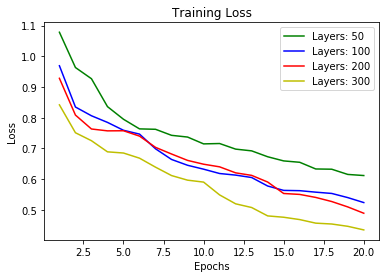

In [116]:
import matplotlib.pyplot as plt
epoch_no = range(1, len(train_loss_50))

plt.title('Training Loss')
plt.plot(epoch_no, train_loss_50[1:], color = 'g', label = "Layers: 50")
plt.plot(epoch_no, train_loss_100[1:] , color = 'b', label = "Layers: 100")
plt.plot(epoch_no, train_loss_200[1:] , color = 'r', label = "Layers: 200")
plt.plot(epoch_no, train_loss_300[1:] , color = 'y', label = "Layers: 300")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

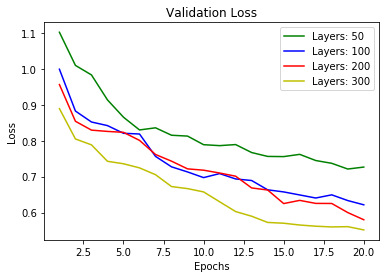

In [117]:
import matplotlib.pyplot as plt
epoch_no = range(1, len(train_loss_50))

plt.title('Validation Loss')
plt.plot(epoch_no, valid_loss_50[1:], color = 'g', label = "Layers: 50")
plt.plot(epoch_no, valid_loss_100[1:] , color = 'b', label = "Layers: 100")
plt.plot(epoch_no, valid_loss_200[1:] , color = 'r', label = "Layers: 200")
plt.plot(epoch_no, valid_loss_300[1:] , color = 'y', label = "Layers: 300")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

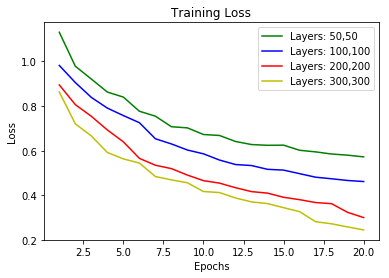

In [118]:
import matplotlib.pyplot as plt
epoch_no = range(1, len(train_loss_50_50))

plt.title('Training Loss')
plt.plot(epoch_no, train_loss_50_50[1:], color = 'g', label = "Layers: 50,50")
plt.plot(epoch_no, train_loss_100_100[1:] , color = 'b', label = "Layers: 100,100")
plt.plot(epoch_no, train_loss_200_200[1:] , color = 'r', label = "Layers: 200,200")
plt.plot(epoch_no, train_loss_300_300[1:] , color = 'y', label = "Layers: 300,300")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

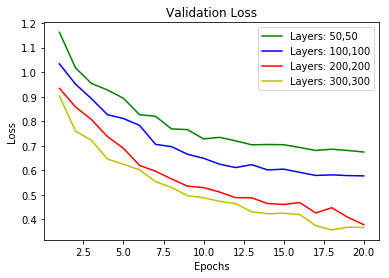

In [119]:
import matplotlib.pyplot as plt
epoch_no = range(1, len(valid_loss_50_50))

plt.title('Validation Loss')
plt.plot(epoch_no, valid_loss_50_50[1:], color = 'g', label = "Layers: 50,50")
plt.plot(epoch_no, valid_loss_100_100[1:] , color = 'b', label = "Layers: 100,100")
plt.plot(epoch_no, valid_loss_200_200[1:] , color = 'r', label = "Layers: 200,200")
plt.plot(epoch_no, valid_loss_300_300[1:] , color = 'y', label = "Layers: 300,300")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

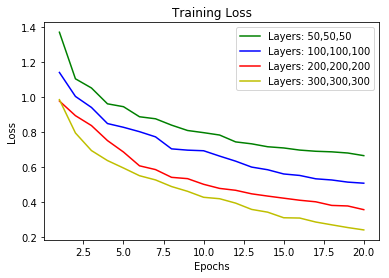

In [120]:
import matplotlib.pyplot as plt
epoch_no = range(1, len(train_loss_50_50_50))

plt.title('Training Loss')
plt.plot(epoch_no, train_loss_50_50_50[1:], color = 'g', label = "Layers: 50,50,50")
plt.plot(epoch_no, train_loss_100_100_100[1:] , color = 'b', label = "Layers: 100,100,100")
plt.plot(epoch_no, train_loss_200_200_200[1:] , color = 'r', label = "Layers: 200,200,200")
plt.plot(epoch_no, train_loss_300_300_300[1:], color = 'y', label = "Layers: 300,300,300")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

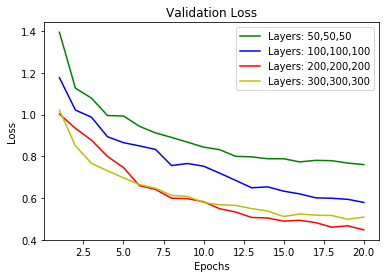

In [121]:
import matplotlib.pyplot as plt
epoch_no = range(1, len(train_loss_50_50_50))

plt.title('Validation Loss')
plt.plot(epoch_no, valid_loss_50_50_50[1:], color = 'g', label = "Layers: 50,50,50")
plt.plot(epoch_no, valid_loss_100_100_100[1:] , color = 'b', label = "Layers: 100,100,100")
plt.plot(epoch_no, valid_loss_200_200_200[1:] , color = 'r', label = "Layers: 200,200,200")
plt.plot(epoch_no, valid_loss_300_300_300[1:] , color = 'y', label = "Layers: 300,300,300")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

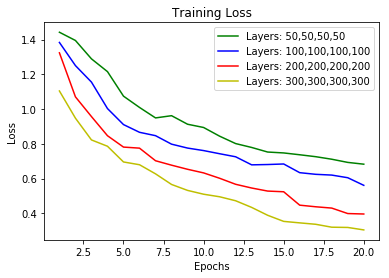

In [122]:
import matplotlib.pyplot as plt
epoch_no = range(1, len(train_loss_50_50_50_50))

plt.title('Training Loss')
plt.plot(epoch_no, train_loss_50_50_50_50[1:], color = 'g', label = "Layers: 50,50,50,50")
plt.plot(epoch_no, train_loss_100_100_100_100[1:] , color = 'b', label = "Layers: 100,100,100,100")
plt.plot(epoch_no, train_loss_200_200_200_200[1:] , color = 'r', label = "Layers: 200,200,200,200")
plt.plot(epoch_no, train_loss_300_300_300_300[1:] , color = 'y', label = "Layers: 300,300,300,300")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

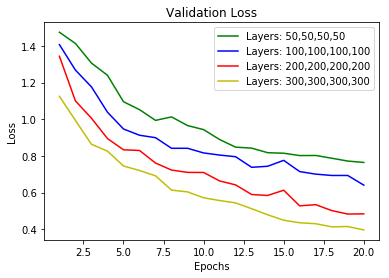

In [136]:
import matplotlib.pyplot as plt
epoch_no = range(1, len(valid_loss_50_50_50_50))

plt.title('Validation Loss')
plt.plot(epoch_no, valid_loss_50_50_50_50[1:], color = 'g', label = "Layers: 50,50,50,50")
plt.plot(epoch_no, valid_loss_100_100_100_100[1:] , color = 'b', label = "Layers: 100,100,100,100")
plt.plot(epoch_no, valid_loss_200_200_200_200[1:] , color = 'r', label = "Layers: 200,200,200,200")
plt.plot(epoch_no, valid_loss_300_300_300_300[1:] , color = 'y', label = "Layers: 300,300,300,300")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

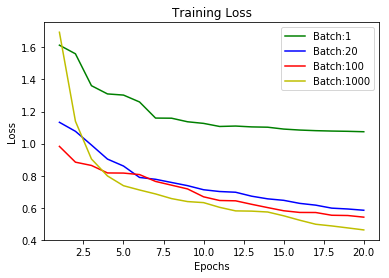

In [169]:
import matplotlib.pyplot as plt
epoch_no = range(1, len(train_loss_b1))

plt.title('Training Loss')
plt.plot(epoch_no, train_loss_b1[1:], color = 'g', label = "Batch:1")
plt.plot(epoch_no, train_loss_b20[1:] , color = 'b', label = "Batch:20")
plt.plot(epoch_no, train_loss_b100[1:] , color = 'r', label = "Batch:100")
plt.plot(epoch_no, train_loss_b1000[1:] , color = 'y', label = "Batch:1000")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

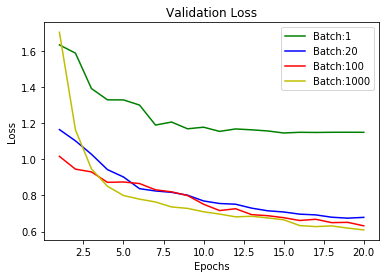

In [170]:
import matplotlib.pyplot as plt
epoch_no = range(1, len(valid_loss_b1))

plt.title('Validation Loss')
plt.plot(epoch_no, valid_loss_b1[1:], color = 'g', label = "Batch:1")
plt.plot(epoch_no, valid_loss_b20[1:] , color = 'b', label = "Batch:20")
plt.plot(epoch_no, valid_loss_b100[1:] , color = 'r', label = "Batch:100")
plt.plot(epoch_no, valid_loss_b1000[1:] , color = 'y', label = "Batch:1000")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

In [228]:
train_loss_gd = [2.304537485174211,
 1.846059646333584,
 1.4123117346980978,
 1.379488157235537,
 1.2800339894063366,
 1.2420925271070904,
 1.2065926954381327,
 1.1579987693049874,
 1.1282016852749663,
 1.0958785936812627,
 1.067021861952434,
 1.0112887379913935,
 0.9868886792982332,
 0.9597427162264768,
 0.9358548066846056,
 0.9253352944678881,
 0.8725492922760824,
 0.8618370111269393,
 0.8450810814126194,
 0.8265980398275956]

train_loss_mom = [2.318279199683379,
 1.8690166304347433,
 1.390578337750111,
 1.4202349508284207,
 1.3377711368446759,
 1.3142102501318753,
 1.2176535122884704,
 1.2055072288984838,
 1.1580993767810306,
 1.1314701814264578,
 1.080171930527539,
 1.0552608328293873,
 1.0495242817823534,
 1.0326689734897219,
 1.0067443908970595,
 0.9812860165335506,
 0.962536776855625,
 0.9304093479368554,
 0.921615438430967,
 0.9135726681180816]



train_loss_nag = [2.3158485928212973,
 1.8605183300074757,
 1.3782721717813884,
 1.3629512519471252,
 1.3079250788831978,
 1.3234964230194568,
 1.2731933318397373,
 1.26048949864804,
 1.1832449121575188,
 1.1625728635201553,
 1.1350098971163365,
 1.0945166835726827,
 1.0351039296039677,
 1.0214980225718342,
 0.9947472793959019,
 0.9743378429744164,
 0.9477637980391211,
 0.9211830297832864,
 0.9043558644933156,
 0.8925524030414356]

valid_loss_gd = [2.304587695841989,
 1.849236196849924,
 1.4323994497126302,
 1.406772994222742,
 1.3200360402622242,
 1.2790493993677765,
 1.2533589092294548,
 1.198315540775206,
 1.1888911444236874,
 1.1394052832935517,
 1.1120767285067434,
 1.073722105053454,
 1.0498603268760431,
 1.0238651834604122,
 1.0101217768593347,
 1.000882673766193,
 0.9630266127206222,
 0.9591182910003643,
 0.9477760463268377,
 0.9250949546604686]
valid_loss_mom = [2.3183478811474743,
 1.8721198607790783,
 1.4145610196380745,
 1.440996127720789,
 1.3653293950200198,
 1.3398304332064768,
 1.2450889814462252,
 1.2483804239606275,
 1.1956919775532115,
 1.174063013115182,
 1.1311315562632853,
 1.1117348714234092,
 1.1141582049263008,
 1.0950272978270736,
 1.0613345336177098,
 1.0442526132320968,
 1.0304688695642457,
 1.0090424225671022,
 0.9950981356077784,
 0.9956214191410734]
valid_loss_nag =[2.3158975041223218,
 1.8638128718225688,
 1.4022729374525484,
 1.3814303907977705,
 1.3298295754499359,
 1.3576114037218565,
 1.3122372704134262,
 1.2856936065440607,
 1.2228009221428684,
 1.195356113872175,
 1.1782986509833921,
 1.129306989317382,
 1.0771261491466881,
 1.0773980854679057,
 1.0598819954716998,
 1.0264559074833697,
 1.0208949551852098,
 0.9991535100298689,
 0.980685648213866,
 0.974805471813009]








train_loss_adam = train_loss_300_300_300_300
valid_loss_adam = valid_loss_300_300_300_300

19

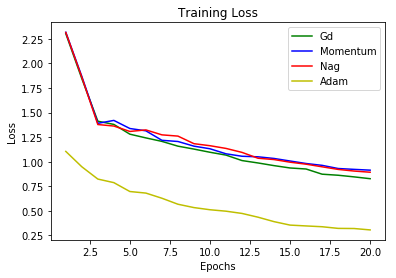

In [231]:
import matplotlib.pyplot as plt
epoch_no = range(1, len(train_loss_gd)+1)

plt.title('Training Loss')
plt.plot(epoch_no, train_loss_gd, color = 'g', label = "Gd")
plt.plot(epoch_no, train_loss_mom , color = 'b', label = "Momentum")
plt.plot(epoch_no, train_loss_nag , color = 'r', label = "Nag")
plt.plot(epoch_no,  train_loss_adam[1:] , color = 'y', label = "Adam")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

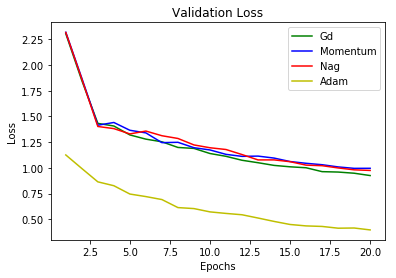

In [237]:
import matplotlib.pyplot as plt
epoch_no = range(1, len(valid_loss_gd)+1)

plt.title('Validation Loss')
plt.plot(epoch_no, valid_loss_gd, color = 'g', label = "Gd")
plt.plot(epoch_no, valid_loss_mom , color = 'b', label = "Momentum")
plt.plot(epoch_no, valid_loss_nag , color = 'r', label = "Nag")
plt.plot(epoch_no,  valid_loss_adam[1:] , color = 'y', label = "Adam")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

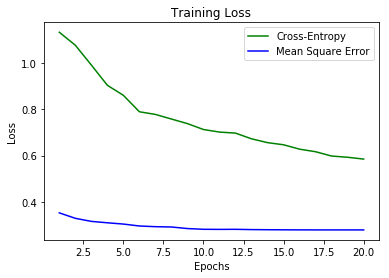

In [177]:
import matplotlib.pyplot as plt
epoch_no = range(1, len(train_loss_sq))

plt.title('Training Loss')
plt.plot(epoch_no, train_loss_ce[1:], color = 'g', label = "Cross-Entropy")
plt.plot(epoch_no, train_loss_sq[1:] , color = 'b', label = "Mean Square Error")
#plt.plot(epoch_no, train_loss_nag[1:] , color = 'r', label = "Nag")
#plt.plot(epoch_no,  train_loss_adam[1:] , color = 'y', label = "Adam")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

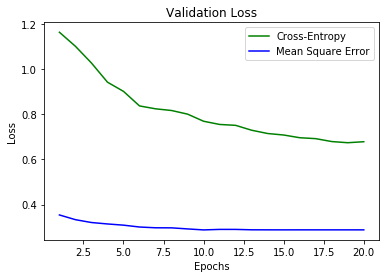

In [176]:
import matplotlib.pyplot as plt
epoch_no = range(1, len(valid_loss_ce))

plt.title('Validation Loss')
plt.plot(epoch_no, valid_loss_ce[1:], color = 'g', label = "Cross-Entropy")
plt.plot(epoch_no, valid_loss_sq[1:] , color = 'b', label = "Mean Square Error")
# plt.plot(epoch_no, valid_loss_nag , color = 'r', label = "Batch:100")
# plt.plot(epoch_no, valid_loss_b1000[1:] , color = 'y', label = "Batch:1000")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

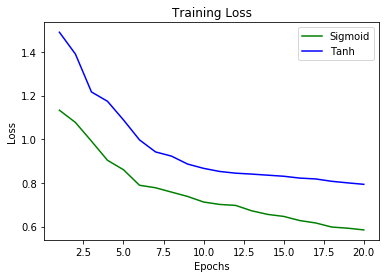

In [178]:
import matplotlib.pyplot as plt
epoch_no = range(1, len(train_loss_sig))

plt.title('Training Loss')
plt.plot(epoch_no, train_loss_sig[1:], color = 'g', label = "Sigmoid")
plt.plot(epoch_no, train_loss_tan[1:] , color = 'b', label = "Tanh")
#plt.plot(epoch_no, train_loss_nag[1:] , color = 'r', label = "Nag")
#plt.plot(epoch_no,  train_loss_adam[1:] , color = 'y', label = "Adam")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

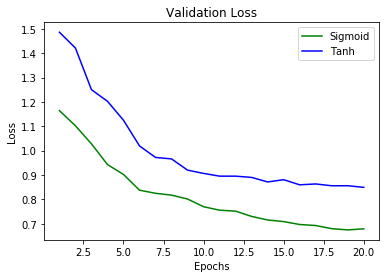

In [179]:
import matplotlib.pyplot as plt
epoch_no = range(1, len(valid_loss_sig))

plt.title('Validation Loss')
plt.plot(epoch_no, valid_loss_sig[1:], color = 'g', label = "Sigmoid")
plt.plot(epoch_no, valid_loss_tan[1:] , color = 'b', label = "Tanh")
# plt.plot(epoch_no, valid_loss_nag , color = 'r', label = "Batch:100")
# plt.plot(epoch_no, valid_loss_b1000[1:] , color = 'y', label = "Batch:1000")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

In [226]:
def pca(pca_n_components, train_data, valid_data, test_data):
    from sklearn.decomposition import PCA 
    train_data_arr = np.array(train_data)
    x_train = train_data_arr[:,1:785]
    y_train = train_data_arr[:,785:]
    
    valid_data_arr = np.array(valid_data)
    x_valid = valid_data_arr[:,1:785]
    y_valid = valid_data_arr[:,785:]
    
    test_data_arr = np.array(test_data)
    x_test = test_data_arr[:,1:785]
    y_test = test_data_arr[:,785:]
    
    pca = PCA(n_components=pca_n_components).fit(x_train)
    x_train =pca.transform(x_train)
    x_valid= pca.transform(x_valid)
    x_test= pca.transform(x_test)
    
    train_data = np.concatenate((x_train,y_train), axis =1)
    valid_data = np.concatenate((x_valid,y_valid), axis =1)
    test_data = np.concatenate((x_test,y_test), axis =1)
    
    train_data_df = pd.DataFrame(train_data)
    valid_data_df = pd.DataFrame(valid_data)
    test_data_df = pd.DataFrame(test_data)
    
    train_data_df.to_csv( 'pca_train_data_{}.csv'.format(pca_n_components)) 
    valid_data_df.to_csv( 'pca_valid_data_{}.csv'.format(pca_n_components)) 
    test_data_df.to_csv( 'pca_test_data_{}.csv'.format(pca_n_components)) 
    
    return train_data, valid_data, test_data

In [227]:
tr, va, te = pca(200, train_data, valid_data, test_data)

In [240]:
train_data.columns

Index(['id', 'feat0', 'feat1', 'feat2', 'feat3', 'feat4', 'feat5', 'feat6',
       'feat7', 'feat8',
       ...
       'feat775', 'feat776', 'feat777', 'feat778', 'feat779', 'feat780',
       'feat781', 'feat782', 'feat783', 'label'],
      dtype='object', length=786)

In [245]:
a = pd.read_csv('pca_valid_data_200.csv')

In [246]:
a.shape

(5000, 202)

In [258]:
te.shape

(10000, 200)

In [254]:
type(tr)

numpy.ndarray